In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
import time
from PIL import Image, ImageDraw

In [3]:
ROOT_DIR = '../mask_rcnn'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class PumpkinsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "pumpkins"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (pumpkins)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = PumpkinsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [27]:
data = []
for file in sorted(os.listdir(r'path_to_directory\train_data')):
    data.append(file)

df_train_data = pd.DataFrame(data, columns=['imageid'])
df_train_data['imageid'] = df_train_data['imageid'].str.replace('.jpg','')

train_data_imageid = df_train_data['imageid'].tolist()

print(len(train_data_imageid))

data = []
for file in sorted(os.listdir(r'path_to_directory\validation_data')):
    data.append(file)

df_validation_data = pd.DataFrame(data, columns=['imageid'])
df_validation_data['imageid'] = df_validation_data['imageid'].str.replace('.jpg','')

validation_data_imageid = df_validation_data['imageid'].tolist()

print(len(validation_data_imageid))


data = []
for file in sorted(os.listdir(r'path_to_directory\train_mask')):
    data.append(file)

df_train_mask = pd.DataFrame(data, columns=['imageid'])
df_train_mask['imageid'] = df_train_mask['imageid'].str.replace('.png','')

train_mask_imageid = df_train_mask['imageid'].tolist()

print(len(train_mask_imageid))


data = []
for file in sorted(os.listdir(r'path_to_directory\validation_mask')):
    data.append(file)

df_validation_mask = pd.DataFrame(data, columns=['imageid'])
df_validation_mask['imageid'] = df_validation_mask['imageid'].str.replace('.png','')

validation_mask_imageid = df_validation_mask['imageid'].tolist()

print(len(validation_mask_imageid))


713
35
1855
111


<ipython-input-27-45af0cbe00b0>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train_data['imageid'] = df_train_data['imageid'].str.replace('.jpg','')
<ipython-input-27-45af0cbe00b0>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_validation_data['imageid'] = df_validation_data['imageid'].str.replace('.jpg','')
<ipython-input-27-45af0cbe00b0>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train_mask['imageid'] = df_train_mask['imageid'].str.replace('.png','')
<ipython-input-27-45af0cbe00b0>:41: FutureWarning: The default value of regex will change from True to False in a future version.
  df_validation_mask['imageid'] = df_validation_mask['imageid'].str.replace('.png','')


In [28]:
data = []
for file in sorted(os.listdir(r'path_to_directory\mask')):
    data.append(file)

In [121]:
matching = [s for s in data if "0b71a1cee8c0b4ab" in s]
matching

['0b71a1cee8c0b4ab_m05zsy_366d02c7.png',
 '0b71a1cee8c0b4ab_m05zsy_73eac057.png',
 '0b71a1cee8c0b4ab_m05zsy_ec8e68a3.png']

In [115]:
validation_mask_imageid

['000b567c26dd4e5d_m05zsy_cfccb6b2',
 '00a554e4545e8b5d_m05zsy_14c3c5e1',
 '00a554e4545e8b5d_m05zsy_7f2e5054',
 '00a554e4545e8b5d_m05zsy_8a4422a5',
 '00ba6c5fe033b7df_m05zsy_c18a2eff',
 '00c2ee786e4695c2_m05zsy_d14a6c7b',
 '00c2ee786e4695c2_m05zsy_d4076f0f',
 '00c2ee786e4695c2_m05zsy_fa9f1b6b',
 '00cfc79900e827d8_m05zsy_a2613cce',
 '00cfc79900e827d8_m05zsy_ddbed9dc',
 '00d7d27487cdc8d0_m05zsy_38d0692d',
 '00d7d27487cdc8d0_m05zsy_8bfa7799',
 '00d7d27487cdc8d0_m05zsy_d598a664',
 '00d7d27487cdc8d0_m05zsy_f6293498',
 '00ddedffd4b2e308_m05zsy_03da6c0f',
 '00ddedffd4b2e308_m05zsy_c8ad6b68',
 '00ddedffd4b2e308_m05zsy_edb6bbf5',
 '00dea25c2fa2c8cc_m05zsy_0887c9e6',
 '00dea25c2fa2c8cc_m05zsy_24adfa31',
 '00dea25c2fa2c8cc_m05zsy_2fc3770b',
 '00dea25c2fa2c8cc_m05zsy_7f8da2ad',
 '00dea25c2fa2c8cc_m05zsy_a0f18234',
 '00dea25c2fa2c8cc_m05zsy_aa9442eb',
 '00dea25c2fa2c8cc_m05zsy_b27d4f2e',
 '00dea25c2fa2c8cc_m05zsy_b58545b8',
 '00dfd888871f354a_m05zsy_1dce76ab',
 '00e4eef9d8d69690_m05zsy_2d1c79f1',
 

In [114]:
from PIL import Image
def resize(path, image_list, form):
    for image in image_list:
        img = Image.open('path_to_directory\\{}\\{}.{}'.format(path, image, form))
        img = img.resize((512,512), Image.ANTIALIAS)
        img.save('path_to_directory\\{}\\{}.{}'.format(path, image, form))
        
        
resize('train_data', train_data_imageid, 'jpg')
resize('validation_data', validation_data_imageid, 'jpg')
resize('train_mask', train_mask_imageid, 'png')
resize('validation_mask', validation_mask_imageid, 'png')

In [29]:
class PumpkinsDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, image_ids, form, image_group):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """    
        self.add_class('pumpkins', 1, 'pumpkins')
       
        # Add the image using the base method from utils.Dataset
        for image in image_ids:
            self.add_image('pumpkins', 
                           image_id=image, 
                           path=('path_to_directory\\{}_data\\{}.{}'.format(image_group, image, form)), 
                           labels=1,
                           height=512, width=512)
            
            
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        image_id = info['id']
        data = []
        for file in sorted(os.listdir(r'path_to_directory\mask')):
            data.append(file)
            
        matching = [s for s in data if image_id in s]
        
        result = [] 
        
        for match in matching:
            im = Image.open('path_to_directory\\mask\\{}'.format(match))
            im = np.asarray(im)
            im = im.reshape((im.shape[0], im.shape[1], 1))
            result.append(im)

        im = np.dstack(result)
        return im, np.array([1 for _ in range(im.shape[-1])])
    

In [30]:

dataset_train = PumpkinsDataset()
dataset_train.load_data(train_data_imageid, 'jpg', 'train')
dataset_train.prepare()

dataset_val = PumpkinsDataset()
dataset_val.load_data(validation_data_imageid, 'jpg', 'validation')
dataset_val.prepare()

In [161]:
# from skimage.io import imread
# im = imread("path_to_directory\\train\\mask\\000b567c26dd4e5d_m05zsy_cfccb6b2.png")
# im.shape

from PIL import Image
im = Image.open('path_to_directory\\train\\mask\\000b567c26dd4e5d.png')
im = np.asarray(im)
print(im.shape)
im = im.reshape((im.shape[0], im.shape[1], 1))

im2 = Image.open('path_to_directory\\train\\mask\\00ba6c5fe033b7df.png')
im2 = np.asarray(im2)
print(im2.shape)
im2 = im2.reshape((im2.shape[0], im2.shape[1], 1))

im = np.dstack((im,im2)).shape)

SyntaxError: unmatched ')' (<ipython-input-161-ae196c985dcb>, line 16)

In [165]:
dataset_train.load_mask(1)


{'id': '00105eff22b1046b', 'source': 'pumpkins', 'path': 'path_to_directory\\train_data\\00105eff22b1046b.jpg', 'labels': 1, 'height': 512, 'width': 512}


(512, 512, 3)
(512, 512, 1) 1
[1]


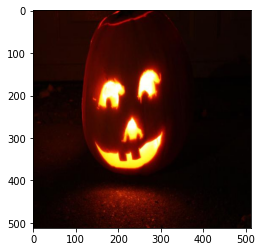

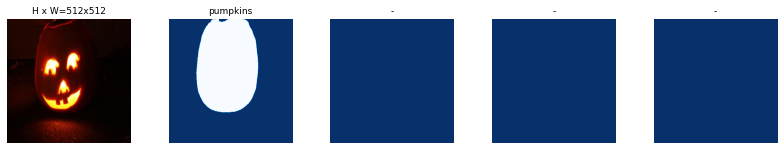

In [183]:
import matplotlib.pyplot as plt
dataset = dataset_val
num = 11
image = dataset.load_image(num)
print(image.shape)
plt.imshow(image)
mask, class_ids = dataset.load_mask(num)
print(class_ids)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names )

(512, 512, 5) 5


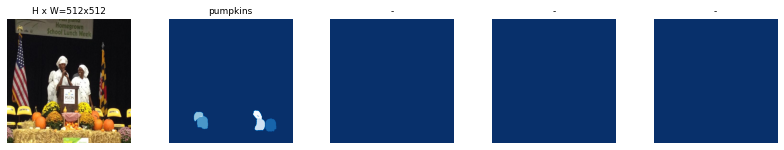

(512, 512, 3) 3


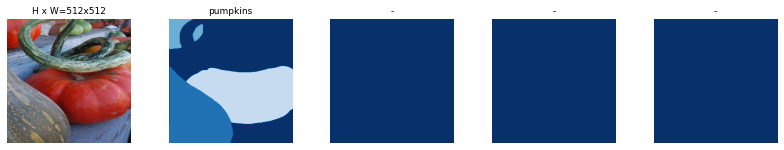

(512, 512, 3) 3


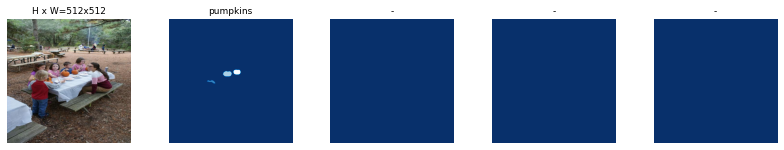

(512, 512, 1) 1


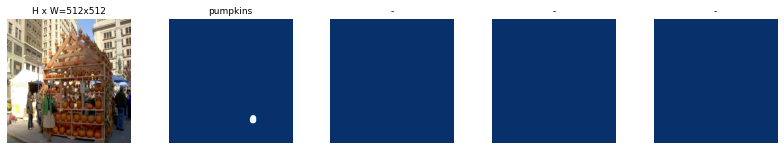

(512, 512, 1) 1


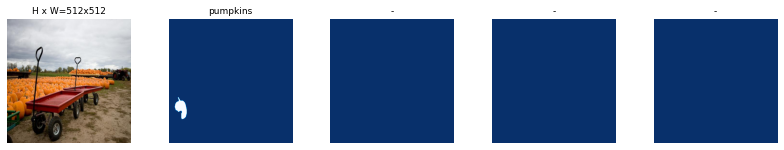

(512, 512, 1) 1


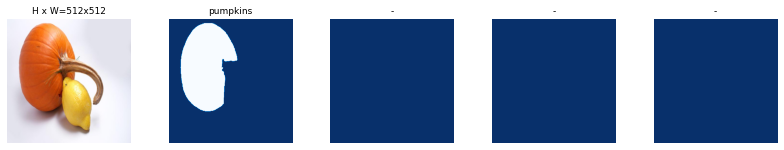

(512, 512, 1) 1


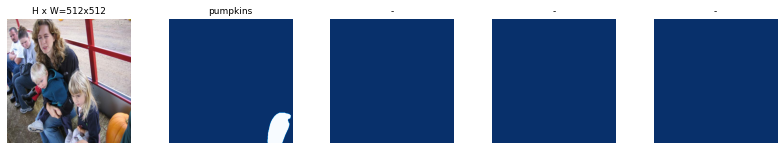

(512, 512, 1) 1


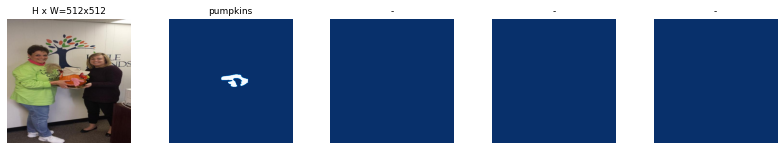

(512, 512, 2) 2


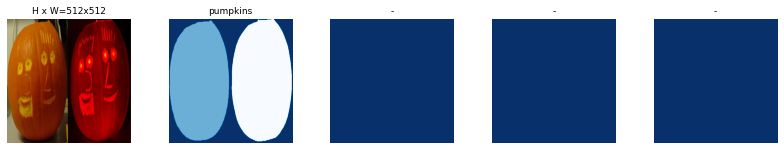

(512, 512, 2) 2


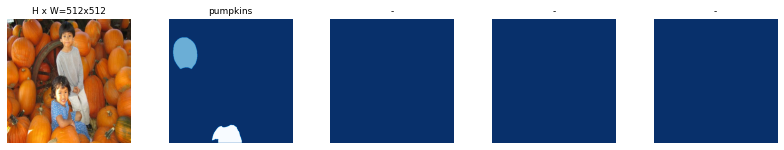

(512, 512, 4) 4


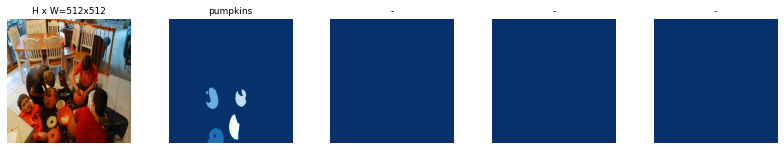

(512, 512, 1) 1


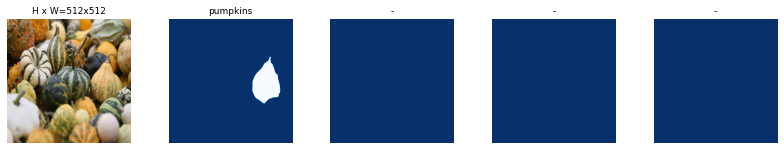

(512, 512, 1) 1


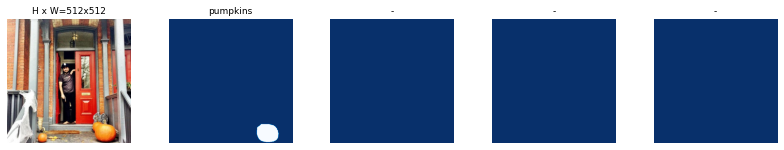

(512, 512, 1) 1


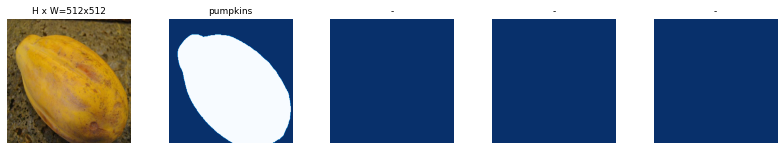

(512, 512, 5) 5


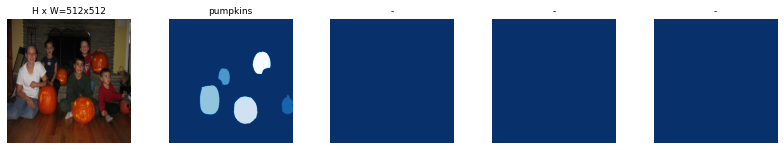

(512, 512, 1) 1


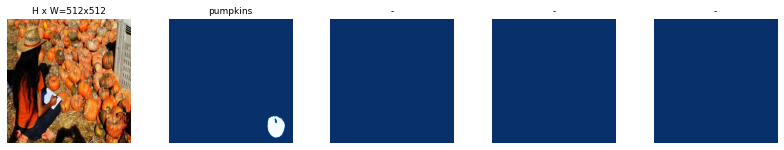

(512, 512, 1) 1


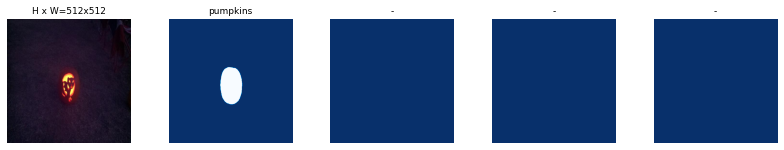

(512, 512, 2) 2


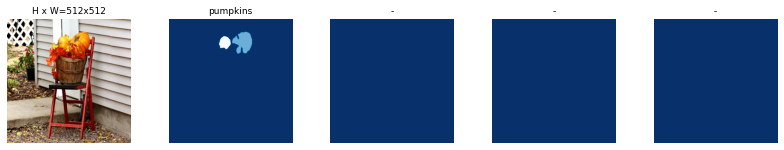

(512, 512, 2) 2


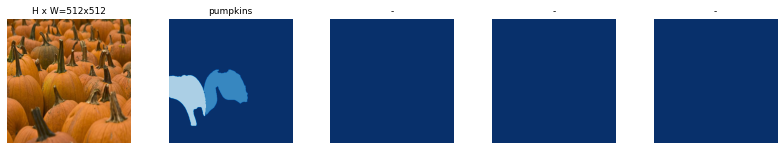

(512, 512, 2) 2


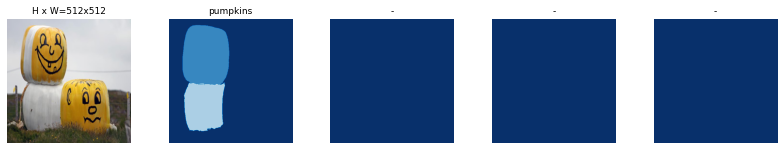

(512, 512, 8) 8


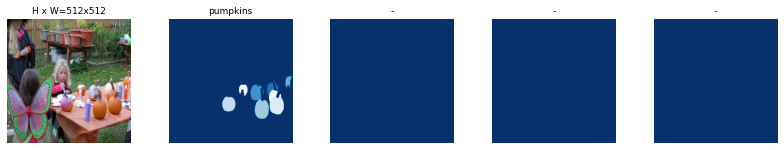

(512, 512, 3) 3


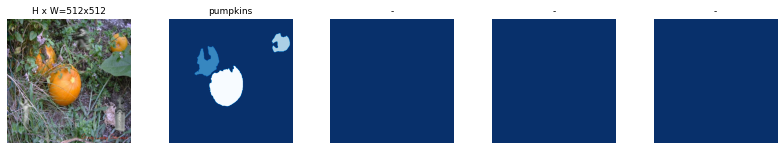

(512, 512, 3) 3


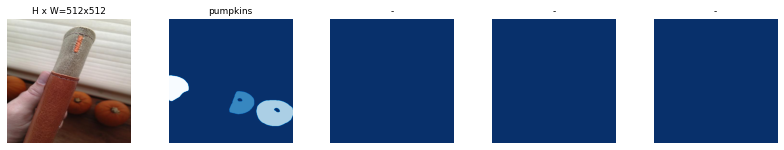

(512, 512, 2) 2


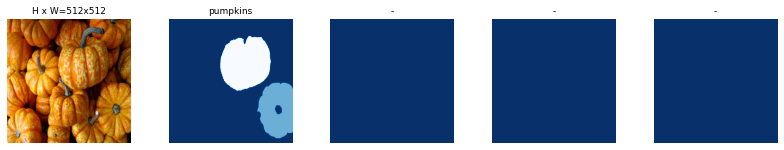

(512, 512, 3) 3


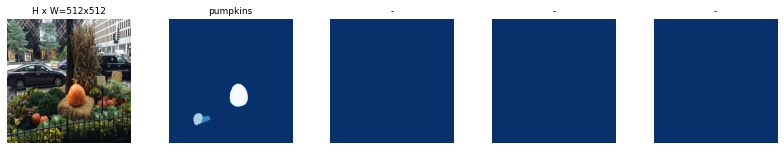

(512, 512, 2) 2


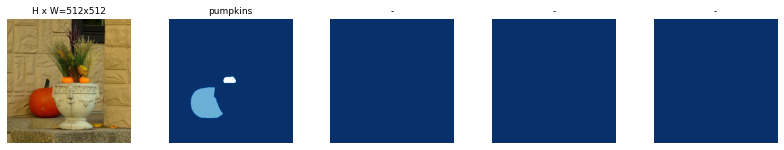

(512, 512, 1) 1


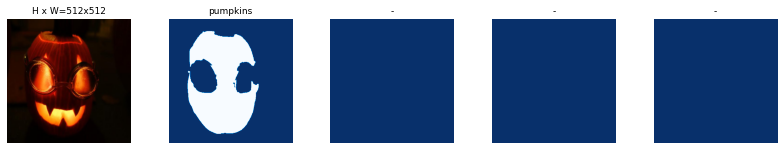

(512, 512, 1) 1


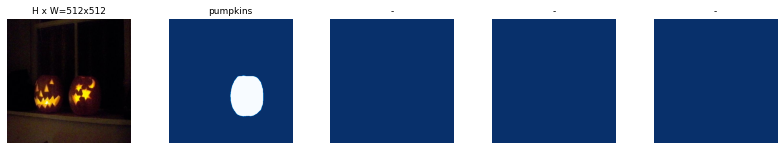

(512, 512, 1) 1


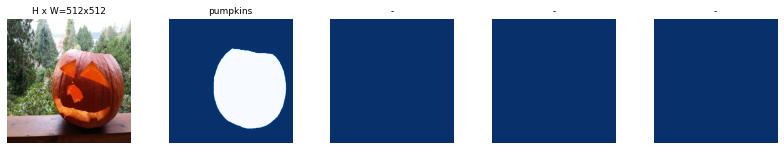

(512, 512, 1) 1


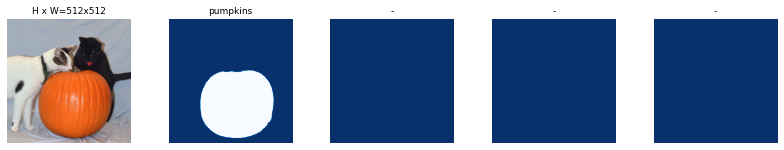

(512, 512, 1) 1


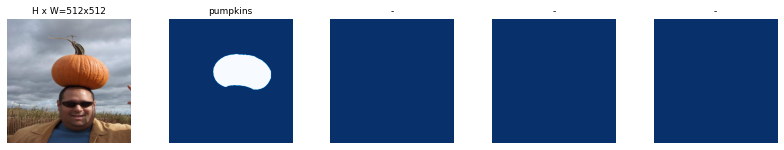

(512, 512, 5) 5


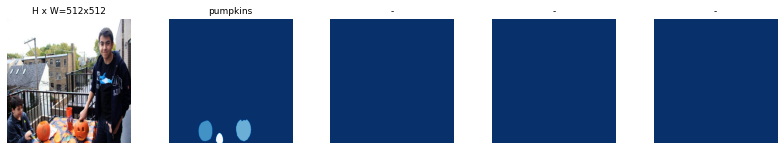

(512, 512, 1) 1


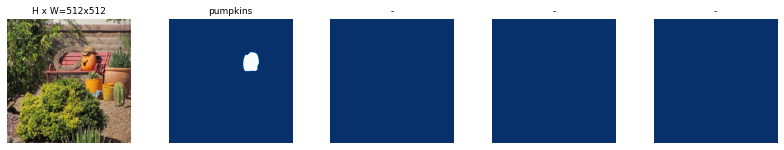

(512, 512, 1) 1


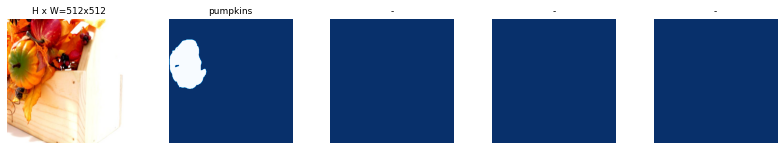

(512, 512, 1) 1


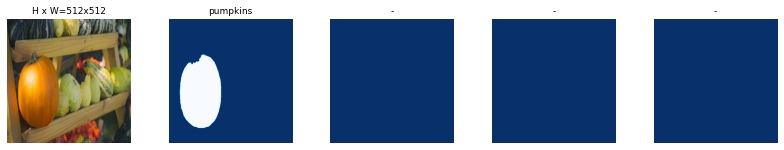

(512, 512, 3) 3


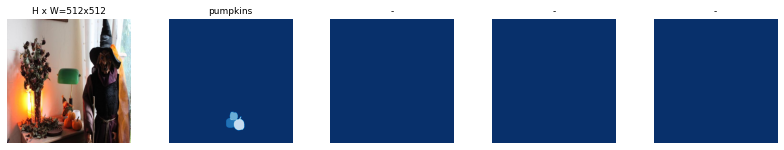

(512, 512, 1) 1


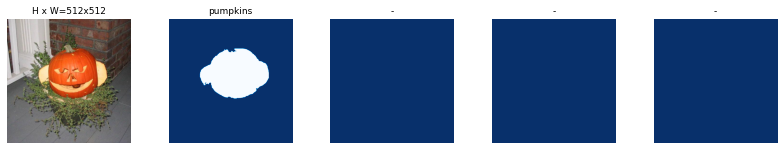

(512, 512, 1) 1


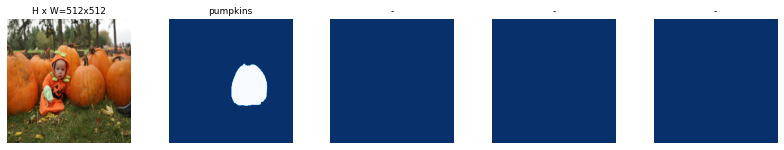

(512, 512, 8) 8


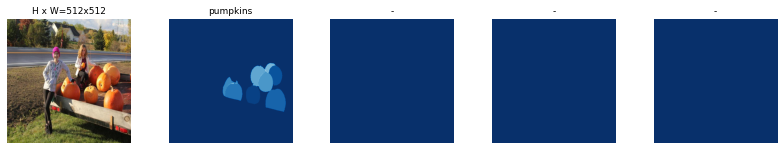

(512, 512, 4) 4


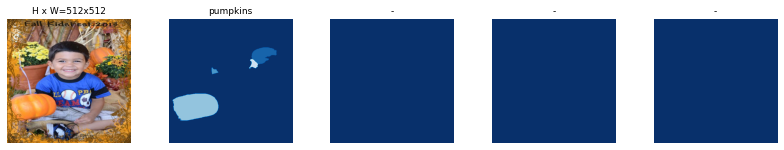

(512, 512, 1) 1


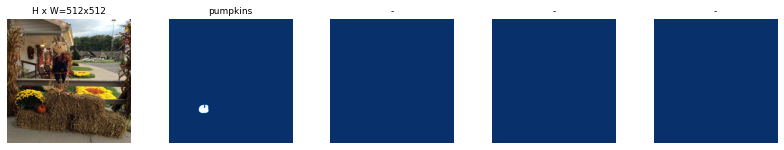

(512, 512, 1) 1


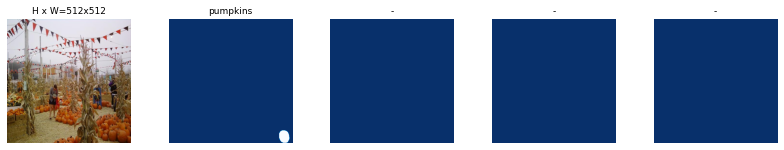

(512, 512, 1) 1


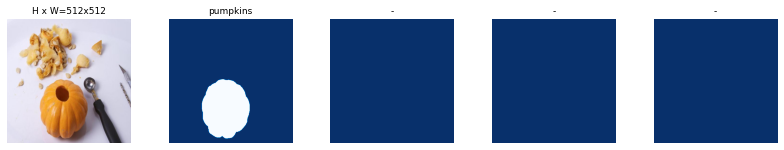

(512, 512, 2) 2


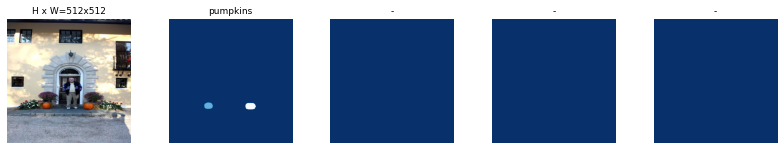

(512, 512, 1) 1


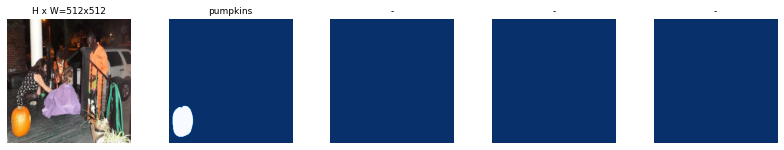

(512, 512, 1) 1


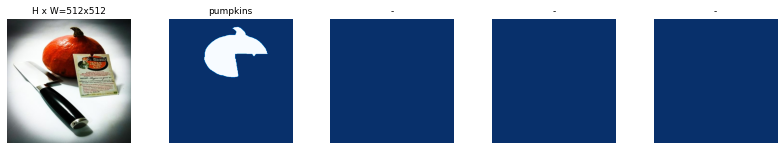

(512, 512, 1) 1


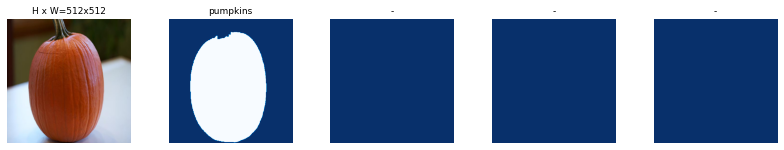

(512, 512, 1) 1


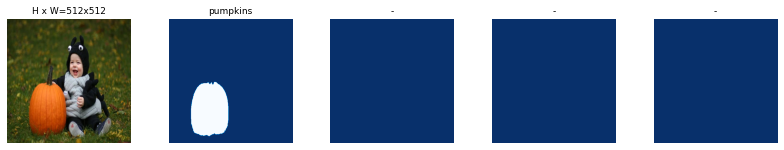

(512, 512, 2) 2


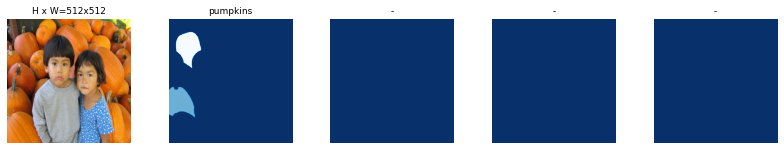

(512, 512, 1) 1


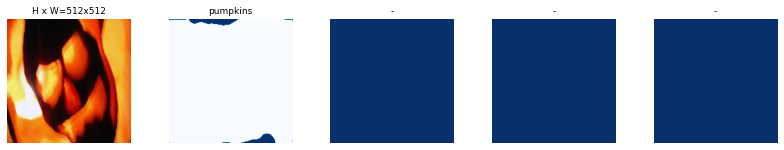

(512, 512, 1) 1


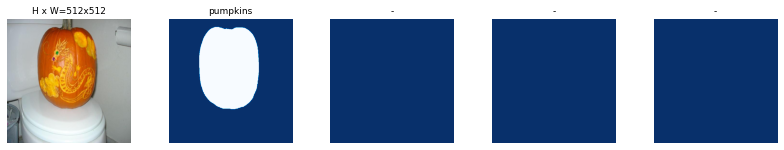

(512, 512, 1) 1


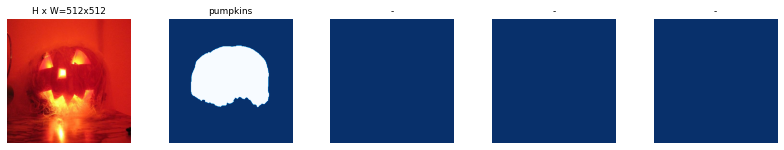

(512, 512, 1) 1


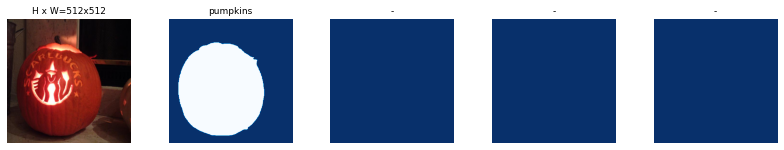

(512, 512, 1) 1


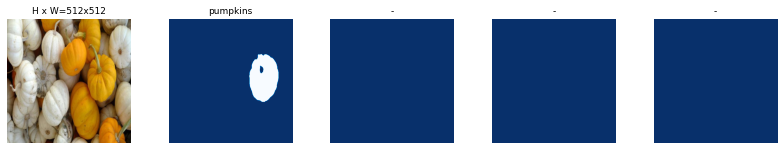

(512, 512, 2) 2


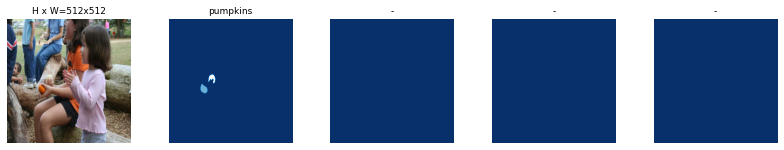

(512, 512, 1) 1


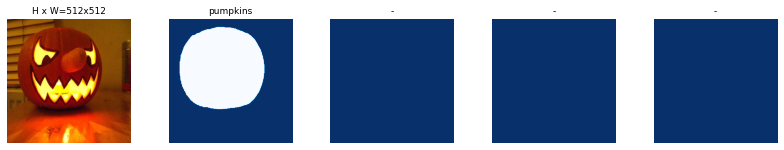

(512, 512, 8) 8


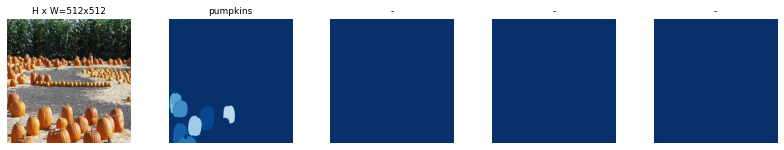

(512, 512, 3) 3


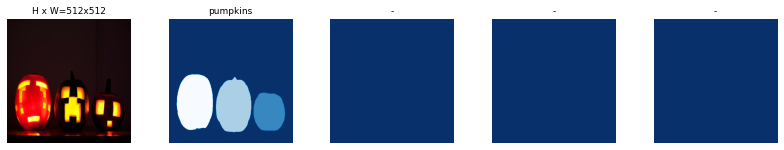

(512, 512, 1) 1


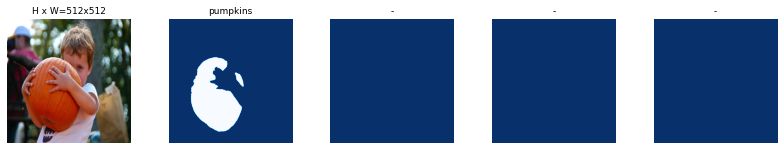

(512, 512, 3) 3


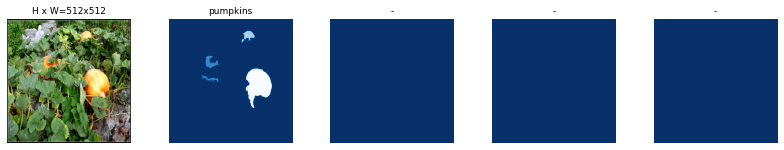

(512, 512, 3) 3


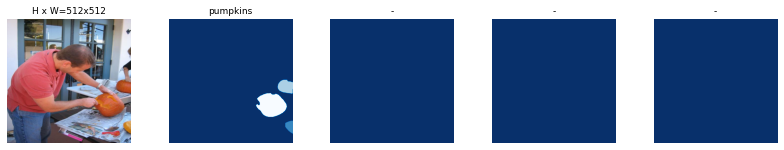

(512, 512, 1) 1


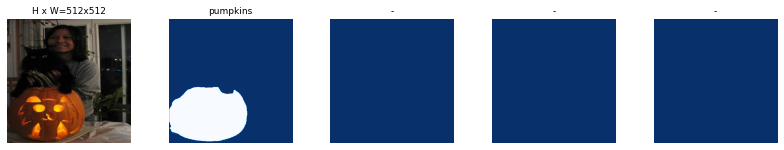

(512, 512, 4) 4


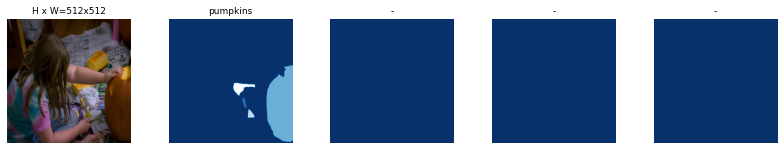

(512, 512, 2) 2


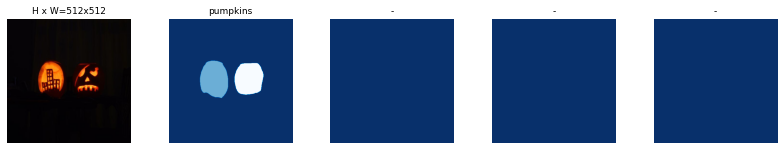

(512, 512, 2) 2


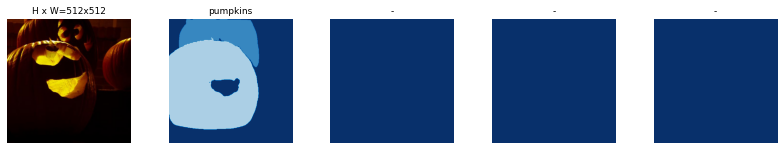

(512, 512, 11) 11


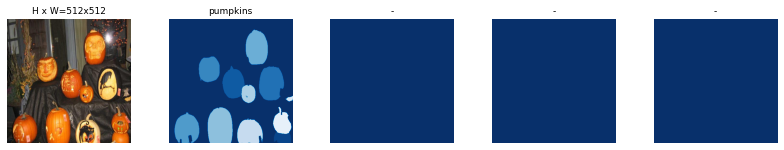

(512, 512, 1) 1


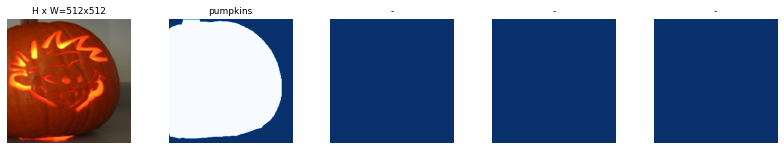

(512, 512, 1) 1


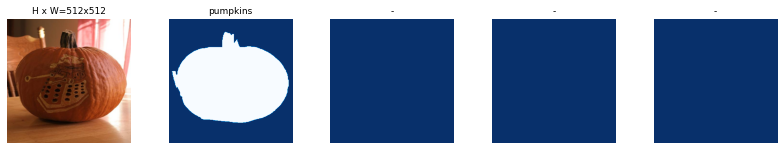

(512, 512, 2) 2


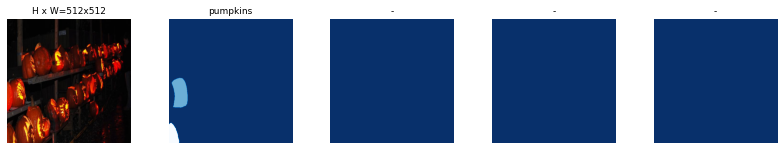

(512, 512, 5) 5


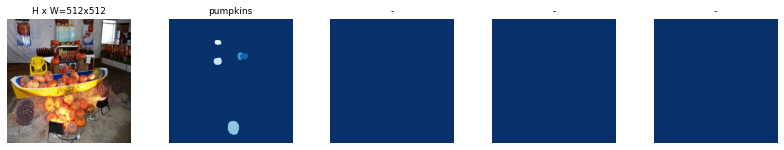

(512, 512, 13) 13


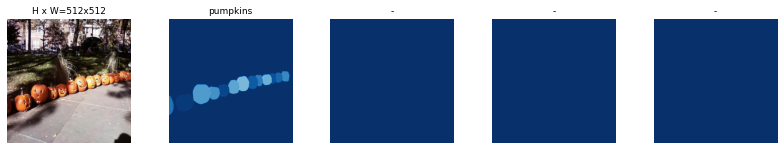

(512, 512, 2) 2


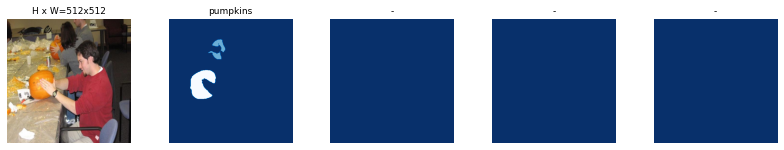

(512, 512, 1) 1


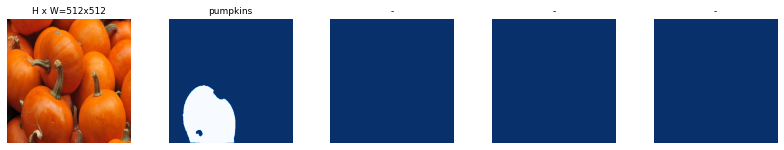

(512, 512, 1) 1


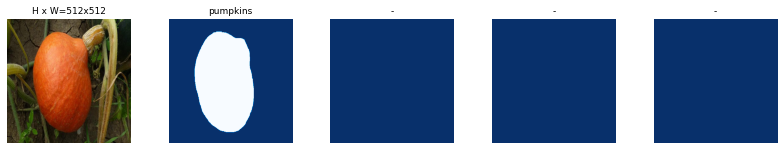

(512, 512, 2) 2


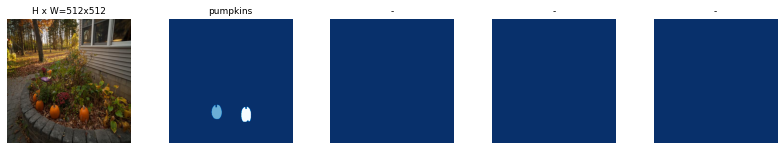

(512, 512, 2) 2


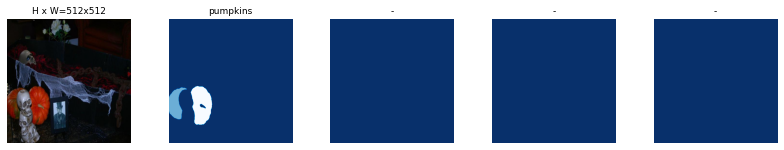

(512, 512, 1) 1


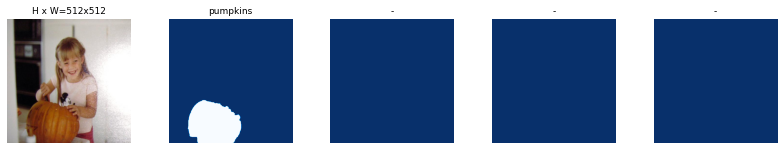

(512, 512, 6) 6


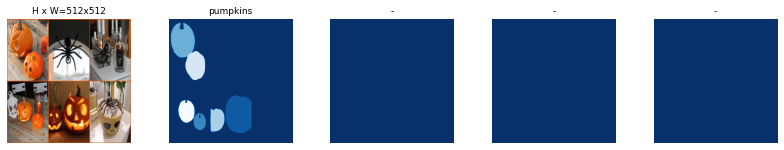

(512, 512, 2) 2


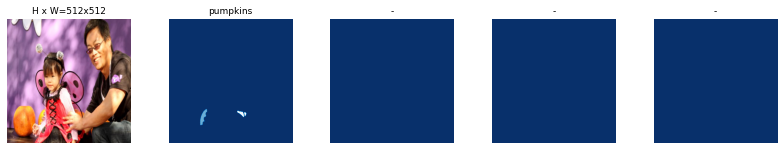

(512, 512, 1) 1


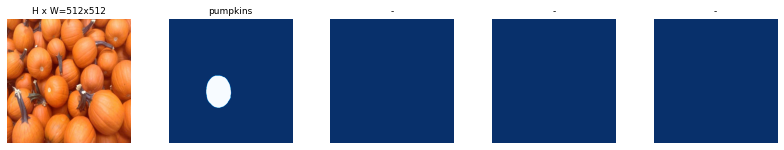

(512, 512, 1) 1


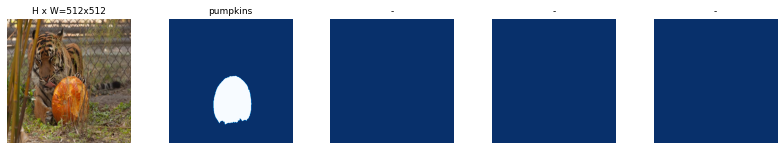

(512, 512, 4) 4


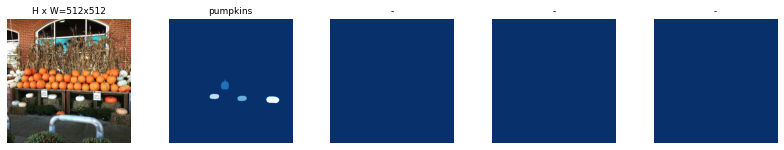

(512, 512, 4) 4


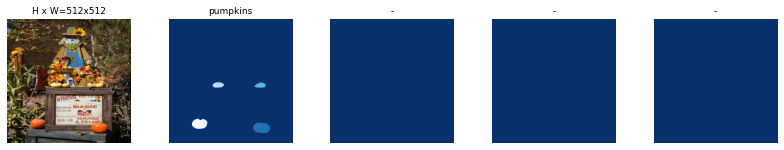

(512, 512, 1) 1


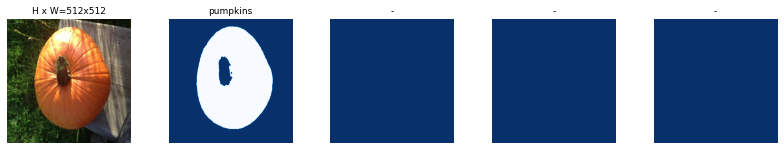

(512, 512, 1) 1


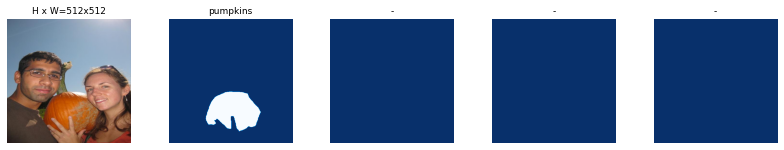

(512, 512, 1) 1


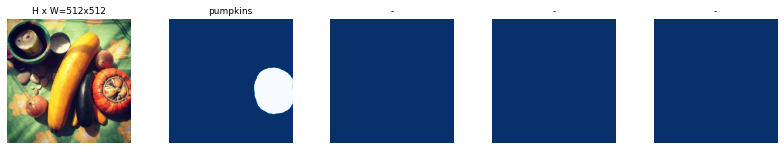

(512, 512, 3) 3


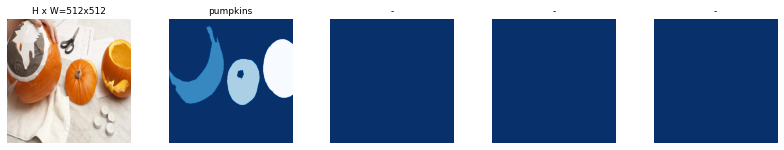

(512, 512, 1) 1


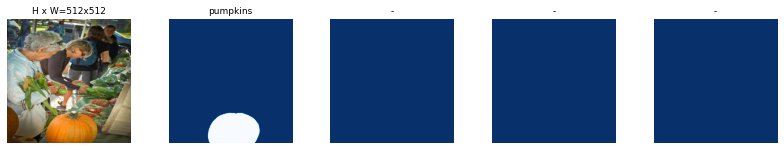

(512, 512, 1) 1


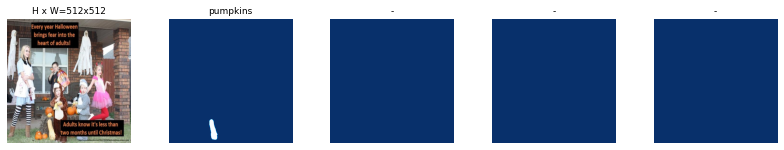

(512, 512, 2) 2


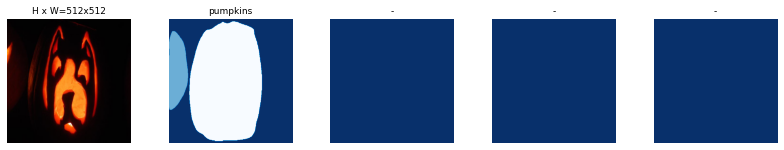

(512, 512, 1) 1


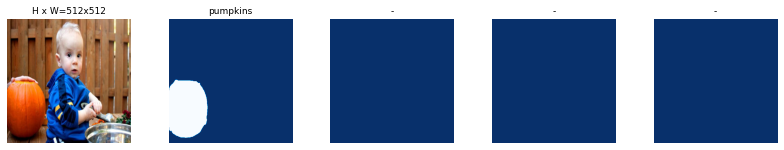

(512, 512, 1) 1


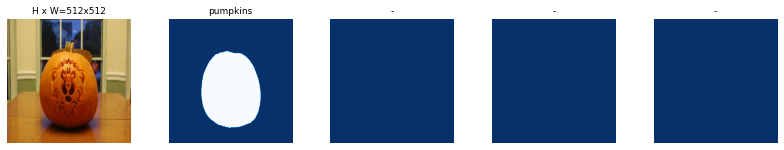

(512, 512, 1) 1


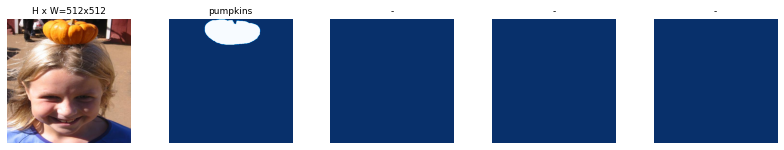

(512, 512, 1) 1


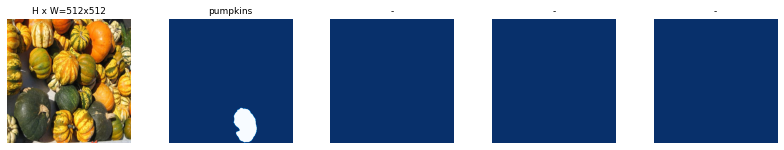

(512, 512, 1) 1


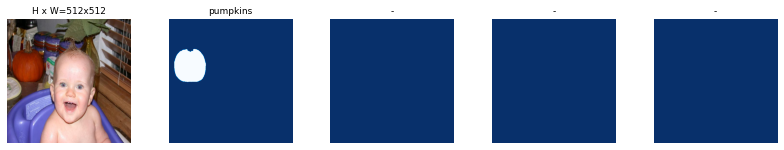

(512, 512, 2) 2


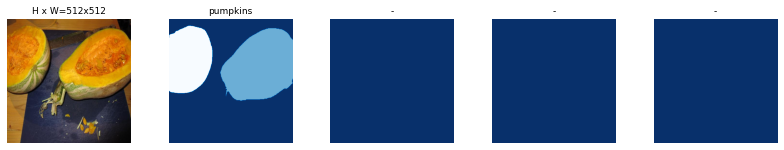

(512, 512, 1) 1


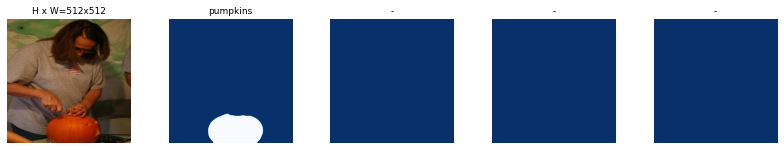

(512, 512, 1) 1


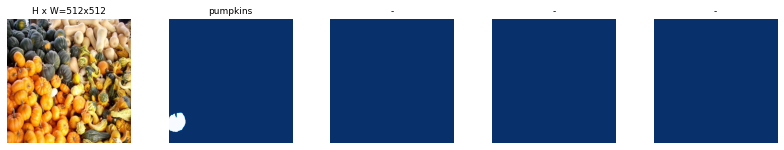

(512, 512, 2) 2


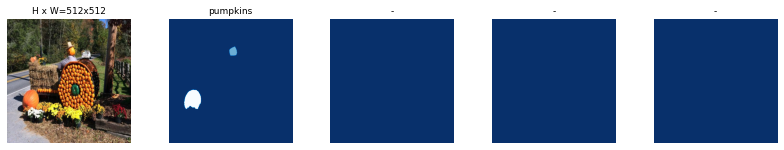

In [175]:
dataset = dataset_train
image_ids = [i for i in range(1,100)]
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [31]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [32]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [33]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../mask_rcnn\logs\pumpkins20210325T1025\mask_rcnn_pumpkins_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Ti

e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
e:\programs\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume

  1/500 [..............................] - ETA: 1:02:21 - batch: 0.0000e+00 - size: 1.0000 - loss: 7.1491 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 2.8782 - mrcnn_class_loss: 1.5514 - mrcnn_bbox_loss: 1.4552 - mrcnn_mask_loss: 1.2475(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 6:47 - batch: 0.5000 - size: 1.0000 - loss: 5.4696 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.9672 - mrcnn_class_loss: 1.1188 - mrcnn_bbox_loss: 1.4722 - mrcnn_mask_loss: 0.8965       (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 4:40 - batch: 1.0000 - size: 1.0000 - loss: 4.0878 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.7039 - mrcnn_class_loss: 0.7490 - mrcnn_bbox_loss: 0.9814 - mrcnn_mask_loss: 0.5977(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 3:57 - batch: 1.5000 - size: 1.0000 - loss: 4.8030 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 2.4333 - mrcnn_class_loss: 0.7082 - mrcnn_bbox_loss: 1.0263 - mrcnn_mask_loss: 0.5931(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 3:37 - batch: 2.0000 - size: 1.0000 - loss: 4.6205 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 2.2782 - mrcnn_class_loss: 0.5891 - mrcnn_bbox_loss: 1.2078 - mrcnn_mask_loss: 0.5036(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 3:25 - batch: 2.5000 - size: 1.0000 - loss: 4.4555 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 2.2512 - mrcnn_class_loss: 0.5119 - mrcnn_bbox_loss: 1.1706 - mrcnn_mask_loss: 0.4776(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 3:17 - batch: 3.0000 - size: 1.0000 - loss: 4.9867 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 2.8335 - mrcnn_class_loss: 0.4566 - mrcnn_bbox_loss: 1.1597 - mrcnn_mask_loss: 0.4751(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 3:14 - batch: 3.5000 - size: 1.0000 - loss: 4.8588 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 2.6071 - mrcnn_class_loss: 0.4838 - mrcnn_bbox_loss: 1.2177 - mrcnn_mask_loss: 0.4869(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 3:10 - batch: 4.0000 - size: 1.0000 - loss: 4.5274 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 2.3603 - mrcnn_class_loss: 0.4411 - mrcnn_bbox_loss: 1.2002 - mrcnn_mask_loss: 0.4684(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 3:06 - batch: 4.5000 - size: 1.0000 - loss: 4.3396 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 2.2053 - mrcnn_class_loss: 0.4289 - mrcnn_bbox_loss: 1.2170 - mrcnn_mask_loss: 0.4356(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 3:04 - batch: 5.0000 - size: 1.0000 - loss: 4.2583 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 2.1668 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 1.2175 - mrcnn_mask_loss: 0.4312(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 3:03 - batch: 5.5000 - size: 1.0000 - loss: 4.1156 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 2.1004 - mrcnn_class_loss: 0.3661 - mrcnn_bbox_loss: 1.1702 - mrcnn_mask_loss: 0.4223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 3:04 - batch: 6.0000 - size: 1.0000 - loss: 3.8690 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 2.0056 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 1.0802 - mrcnn_mask_loss: 0.3898(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 3:01 - batch: 6.5000 - size: 1.0000 - loss: 3.6622 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.8936 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 1.0262 - mrcnn_mask_loss: 0.3762(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:58 - batch: 7.0000 - size: 1.0000 - loss: 3.4684 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.7903 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.9719 - mrcnn_mask_loss: 0.3635(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 3:02 - batch: 7.5000 - size: 1.0000 - loss: 3.5097 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.7920 - mrcnn_class_loss: 0.3246 - mrcnn_bbox_loss: 0.9733 - mrcnn_mask_loss: 0.3653(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 3:00 - batch: 8.0000 - size: 1.0000 - loss: 3.3442 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.7246 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.9161 - mrcnn_mask_loss: 0.3438(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:58 - batch: 8.5000 - size: 1.0000 - loss: 3.2481 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.7158 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.8652 - mrcnn_mask_loss: 0.3247(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 3:00 - batch: 9.0000 - size: 1.0000 - loss: 3.2927 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.7759 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.8724 - mrcnn_mask_loss: 0.3140(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 3:00 - batch: 9.5000 - size: 1.0000 - loss: 3.3416 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.7614 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.8982 - mrcnn_mask_loss: 0.3059(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:58 - batch: 10.0000 - size: 1.0000 - loss: 3.2608 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.7506 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.8555 - mrcnn_mask_loss: 0.2914(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 3:00 - batch: 10.5000 - size: 1.0000 - loss: 3.1975 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.7209 - mrcnn_class_loss: 0.2892 - mrcnn_bbox_loss: 0.8429 - mrcnn_mask_loss: 0.2833(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 3:00 - batch: 11.0000 - size: 1.0000 - loss: 3.1399 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.6732 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.8464 - mrcnn_mask_loss: 0.2772(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:58 - batch: 11.5000 - size: 1.0000 - loss: 3.1733 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.7128 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.8520 - mrcnn_mask_loss: 0.2737(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:57 - batch: 12.0000 - size: 1.0000 - loss: 3.1092 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.6746 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.8432 - mrcnn_mask_loss: 0.2671(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:57 - batch: 12.5000 - size: 1.0000 - loss: 3.0096 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.6286 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.8108 - mrcnn_mask_loss: 0.2569(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:57 - batch: 13.0000 - size: 1.0000 - loss: 2.9818 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.6111 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.8016 - mrcnn_mask_loss: 0.2525(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:56 - batch: 13.5000 - size: 1.0000 - loss: 2.9638 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.6121 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.7864 - mrcnn_mask_loss: 0.2503(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:55 - batch: 14.0000 - size: 1.0000 - loss: 2.9163 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.5932 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.7729 - mrcnn_mask_loss: 0.2440(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:54 - batch: 14.5000 - size: 1.0000 - loss: 2.8857 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.5849 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.7631 - mrcnn_mask_loss: 0.2382(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:52 - batch: 15.0000 - size: 1.0000 - loss: 2.8220 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.5464 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.7527 - mrcnn_mask_loss: 0.2320(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:52 - batch: 15.5000 - size: 1.0000 - loss: 2.9313 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.6626 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.7446 - mrcnn_mask_loss: 0.2374(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:51 - batch: 16.0000 - size: 1.0000 - loss: 2.9629 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.6352 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.7556 - mrcnn_mask_loss: 0.2569(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:50 - batch: 16.5000 - size: 1.0000 - loss: 2.9486 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.6425 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.7470 - mrcnn_mask_loss: 0.2515(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:49 - batch: 17.0000 - size: 1.0000 - loss: 2.8897 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.6007 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.7416 - mrcnn_mask_loss: 0.2471(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:49 - batch: 17.5000 - size: 1.0000 - loss: 2.8791 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.5748 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.7450 - mrcnn_mask_loss: 0.2598(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:49 - batch: 18.0000 - size: 1.0000 - loss: 2.8640 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.5580 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.7461 - mrcnn_mask_loss: 0.2677(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:48 - batch: 18.5000 - size: 1.0000 - loss: 2.8374 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.5538 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.7360 - mrcnn_mask_loss: 0.2625(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:48 - batch: 19.0000 - size: 1.0000 - loss: 2.8289 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.5401 - mrcnn_class_loss: 0.2354 - mrcnn_bbox_loss: 0.7340 - mrcnn_mask_loss: 0.2674(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:47 - batch: 19.5000 - size: 1.0000 - loss: 2.8504 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.5706 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.7292 - mrcnn_mask_loss: 0.2674(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:46 - batch: 20.0000 - size: 1.0000 - loss: 2.8324 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.5403 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.7256 - mrcnn_mask_loss: 0.2734(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:45 - batch: 20.5000 - size: 1.0000 - loss: 2.8404 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.5454 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.7293 - mrcnn_mask_loss: 0.2738(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:45 - batch: 21.0000 - size: 1.0000 - loss: 2.8664 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.5657 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.7290 - mrcnn_mask_loss: 0.2796(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:44 - batch: 21.5000 - size: 1.0000 - loss: 2.8214 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.5497 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.7124 - mrcnn_mask_loss: 0.2732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:43 - batch: 22.0000 - size: 1.0000 - loss: 2.8160 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.5445 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.7205 - mrcnn_mask_loss: 0.2699(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:43 - batch: 22.5000 - size: 1.0000 - loss: 2.8259 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.5635 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.7135 - mrcnn_mask_loss: 0.2716(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:43 - batch: 23.0000 - size: 1.0000 - loss: 2.8089 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.5533 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.7094 - mrcnn_mask_loss: 0.2694(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:42 - batch: 23.5000 - size: 1.0000 - loss: 2.8399 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.5872 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.7121 - mrcnn_mask_loss: 0.2666(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:41 - batch: 24.0000 - size: 1.0000 - loss: 2.8363 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.5867 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.7156 - mrcnn_mask_loss: 0.2633(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:41 - batch: 24.5000 - size: 1.0000 - loss: 2.8172 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.5747 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.7144 - mrcnn_mask_loss: 0.2601(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:40 - batch: 25.0000 - size: 1.0000 - loss: 2.7982 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.5605 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.7125 - mrcnn_mask_loss: 0.2614(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:39 - batch: 25.5000 - size: 1.0000 - loss: 2.7623 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.5329 - mrcnn_class_loss: 0.2128 - mrcnn_bbox_loss: 0.7102 - mrcnn_mask_loss: 0.2580(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:38 - batch: 26.0000 - size: 1.0000 - loss: 2.7458 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.5171 - mrcnn_class_loss: 0.2094 - mrcnn_bbox_loss: 0.7153 - mrcnn_mask_loss: 0.2564(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:38 - batch: 26.5000 - size: 1.0000 - loss: 2.7232 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.5023 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.7097 - mrcnn_mask_loss: 0.2547(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:38 - batch: 27.0000 - size: 1.0000 - loss: 2.7344 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.5138 - mrcnn_class_loss: 0.2080 - mrcnn_bbox_loss: 0.7124 - mrcnn_mask_loss: 0.2531(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:39 - batch: 27.5000 - size: 1.0000 - loss: 2.7048 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.4943 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.7063 - mrcnn_mask_loss: 0.2513(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:38 - batch: 28.0000 - size: 1.0000 - loss: 2.7072 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.5018 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.7059 - mrcnn_mask_loss: 0.2500(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:37 - batch: 28.5000 - size: 1.0000 - loss: 2.6786 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4861 - mrcnn_class_loss: 0.2000 - mrcnn_bbox_loss: 0.6982 - mrcnn_mask_loss: 0.2482(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:37 - batch: 29.0000 - size: 1.0000 - loss: 2.6741 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4956 - mrcnn_class_loss: 0.1973 - mrcnn_bbox_loss: 0.6903 - mrcnn_mask_loss: 0.2454(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:36 - batch: 29.5000 - size: 1.0000 - loss: 2.6611 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.4941 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.6834 - mrcnn_mask_loss: 0.2430(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:36 - batch: 30.0000 - size: 1.0000 - loss: 2.6355 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.4817 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.2430(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:36 - batch: 30.5000 - size: 1.0000 - loss: 2.6522 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.5081 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.6684 - mrcnn_mask_loss: 0.2406(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:35 - batch: 31.0000 - size: 1.0000 - loss: 2.6325 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4994 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.6632 - mrcnn_mask_loss: 0.2384(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:35 - batch: 31.5000 - size: 1.0000 - loss: 2.6562 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.5112 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.6642 - mrcnn_mask_loss: 0.2482(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:34 - batch: 32.0000 - size: 1.0000 - loss: 2.6509 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.5034 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.6667 - mrcnn_mask_loss: 0.2491(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:33 - batch: 32.5000 - size: 1.0000 - loss: 2.6256 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.4872 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.6616 - mrcnn_mask_loss: 0.2478(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:33 - batch: 33.0000 - size: 1.0000 - loss: 2.5963 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.4679 - mrcnn_class_loss: 0.1838 - mrcnn_bbox_loss: 0.6574 - mrcnn_mask_loss: 0.2449(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:33 - batch: 33.5000 - size: 1.0000 - loss: 2.5884 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.6624 - mrcnn_mask_loss: 0.2440(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:33 - batch: 34.0000 - size: 1.0000 - loss: 2.5820 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.4540 - mrcnn_class_loss: 0.1794 - mrcnn_bbox_loss: 0.6619 - mrcnn_mask_loss: 0.2425(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:32 - batch: 34.5000 - size: 1.0000 - loss: 2.5616 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.6570 - mrcnn_mask_loss: 0.2419(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:32 - batch: 35.0000 - size: 1.0000 - loss: 2.5328 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4218 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.6511 - mrcnn_mask_loss: 0.2394(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:31 - batch: 35.5000 - size: 1.0000 - loss: 2.5250 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.4148 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.6500 - mrcnn_mask_loss: 0.2407(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:31 - batch: 36.0000 - size: 1.0000 - loss: 2.5118 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.4079 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.6439 - mrcnn_mask_loss: 0.2388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:30 - batch: 36.5000 - size: 1.0000 - loss: 2.4976 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.4017 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.6411 - mrcnn_mask_loss: 0.2363(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:30 - batch: 37.0000 - size: 1.0000 - loss: 2.4853 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.3974 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.6379 - mrcnn_mask_loss: 0.2339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:29 - batch: 37.5000 - size: 1.0000 - loss: 2.4709 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.3910 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.6349 - mrcnn_mask_loss: 0.2317(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:29 - batch: 38.0000 - size: 1.0000 - loss: 2.4513 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.3851 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.6266 - mrcnn_mask_loss: 0.2286(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:29 - batch: 38.5000 - size: 1.0000 - loss: 2.4390 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.6225 - mrcnn_mask_loss: 0.2265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:28 - batch: 39.0000 - size: 1.0000 - loss: 2.4312 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.3806 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.6181 - mrcnn_mask_loss: 0.2260(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:28 - batch: 39.5000 - size: 1.0000 - loss: 2.4119 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.3678 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.6141 - mrcnn_mask_loss: 0.2238(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:28 - batch: 40.0000 - size: 1.0000 - loss: 2.4022 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.3631 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.6104 - mrcnn_mask_loss: 0.2228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:28 - batch: 40.5000 - size: 1.0000 - loss: 2.3932 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.3617 - mrcnn_class_loss: 0.1650 - mrcnn_bbox_loss: 0.6047 - mrcnn_mask_loss: 0.2219(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:27 - batch: 41.0000 - size: 1.0000 - loss: 2.3784 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.3550 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.6010 - mrcnn_mask_loss: 0.2197(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:26 - batch: 41.5000 - size: 1.0000 - loss: 2.3858 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.3566 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.2284(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:26 - batch: 42.0000 - size: 1.0000 - loss: 2.3768 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.3519 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.2266(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:26 - batch: 42.5000 - size: 1.0000 - loss: 2.3987 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.3568 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.5955 - mrcnn_mask_loss: 0.2348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:26 - batch: 43.0000 - size: 1.0000 - loss: 2.3991 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.3473 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.5961 - mrcnn_mask_loss: 0.2396(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:25 - batch: 43.5000 - size: 1.0000 - loss: 2.3883 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.3402 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.5936 - mrcnn_mask_loss: 0.2388(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:25 - batch: 44.0000 - size: 1.0000 - loss: 2.3784 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.3314 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.5908 - mrcnn_mask_loss: 0.2394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:24 - batch: 44.5000 - size: 1.0000 - loss: 2.3697 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.3266 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.2395(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:24 - batch: 45.0000 - size: 1.0000 - loss: 2.3580 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.3183 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.5877 - mrcnn_mask_loss: 0.2394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:23 - batch: 45.5000 - size: 1.0000 - loss: 2.3510 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.3158 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.5850 - mrcnn_mask_loss: 0.2394(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:23 - batch: 46.0000 - size: 1.0000 - loss: 2.3393 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.3084 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.5822 - mrcnn_mask_loss: 0.2392(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:23 - batch: 46.5000 - size: 1.0000 - loss: 2.3709 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.3399 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.5818 - mrcnn_mask_loss: 0.2406(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:22 - batch: 47.0000 - size: 1.0000 - loss: 2.3601 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.3331 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.5786 - mrcnn_mask_loss: 0.2413(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:23 - batch: 47.5000 - size: 1.0000 - loss: 2.3541 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.3302 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.5758 - mrcnn_mask_loss: 0.2402(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:22 - batch: 48.0000 - size: 1.0000 - loss: 2.3502 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.3239 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.5752 - mrcnn_mask_loss: 0.2405(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:22 - batch: 48.5000 - size: 1.0000 - loss: 2.3377 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.3172 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.5721 - mrcnn_mask_loss: 0.2387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:21 - batch: 49.0000 - size: 1.0000 - loss: 2.3351 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.3170 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.2373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:21 - batch: 49.5000 - size: 1.0000 - loss: 2.3272 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.3129 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.5698 - mrcnn_mask_loss: 0.2373(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:21 - batch: 50.0000 - size: 1.0000 - loss: 2.3186 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.3069 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.2373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:20 - batch: 50.5000 - size: 1.0000 - loss: 2.3234 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.3110 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.5664 - mrcnn_mask_loss: 0.2411(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:20 - batch: 51.0000 - size: 1.0000 - loss: 2.3148 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.3041 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.5647 - mrcnn_mask_loss: 0.2424(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:20 - batch: 51.5000 - size: 1.0000 - loss: 2.3048 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.2985 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.2411(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:19 - batch: 52.0000 - size: 1.0000 - loss: 2.2917 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.2901 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.5615 - mrcnn_mask_loss: 0.2392(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:19 - batch: 52.5000 - size: 1.0000 - loss: 2.2928 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.2927 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.5601 - mrcnn_mask_loss: 0.2396(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:19 - batch: 53.0000 - size: 1.0000 - loss: 2.2988 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.3016 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.5582 - mrcnn_mask_loss: 0.2385(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:18 - batch: 53.5000 - size: 1.0000 - loss: 2.2901 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.2984 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.5555 - mrcnn_mask_loss: 0.2374(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:18 - batch: 54.0000 - size: 1.0000 - loss: 2.2922 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.3015 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.5542 - mrcnn_mask_loss: 0.2371(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:18 - batch: 54.5000 - size: 1.0000 - loss: 2.2866 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.2969 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.5539 - mrcnn_mask_loss: 0.2378(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:17 - batch: 55.0000 - size: 1.0000 - loss: 2.2996 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.3010 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.5526 - mrcnn_mask_loss: 0.2479(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:17 - batch: 55.5000 - size: 1.0000 - loss: 2.2867 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.2910 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.5516 - mrcnn_mask_loss: 0.2465(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:16 - batch: 56.0000 - size: 1.0000 - loss: 2.2808 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.2918 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.5478 - mrcnn_mask_loss: 0.2451(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:16 - batch: 56.5000 - size: 1.0000 - loss: 2.2686 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 1.2847 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.2438(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:16 - batch: 57.0000 - size: 1.0000 - loss: 2.2706 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 1.2799 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.5469 - mrcnn_mask_loss: 0.2438(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:15 - batch: 57.5000 - size: 1.0000 - loss: 2.2659 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.2794 - mrcnn_class_loss: 0.1627 - mrcnn_bbox_loss: 0.5437 - mrcnn_mask_loss: 0.2439(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:15 - batch: 58.0000 - size: 1.0000 - loss: 2.2697 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.2859 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.2442(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:14 - batch: 58.5000 - size: 1.0000 - loss: 2.2659 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.2823 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.2448(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:14 - batch: 59.0000 - size: 1.0000 - loss: 2.2659 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 1.2842 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.2434(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:13 - batch: 59.5000 - size: 1.0000 - loss: 2.2678 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.2898 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.5393 - mrcnn_mask_loss: 0.2422(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:13 - batch: 60.0000 - size: 1.0000 - loss: 2.2592 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.2845 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.5375 - mrcnn_mask_loss: 0.2407(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:12 - batch: 60.5000 - size: 1.0000 - loss: 2.2602 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.2883 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.5360 - mrcnn_mask_loss: 0.2401(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:12 - batch: 61.0000 - size: 1.0000 - loss: 2.2563 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.2834 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.5349 - mrcnn_mask_loss: 0.2411(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:12 - batch: 61.5000 - size: 1.0000 - loss: 2.2459 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2779 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.5318 - mrcnn_mask_loss: 0.2403(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:12 - batch: 62.0000 - size: 1.0000 - loss: 2.2536 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2884 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.2407(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:11 - batch: 62.5000 - size: 1.0000 - loss: 2.2458 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.2853 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.5276 - mrcnn_mask_loss: 0.2394(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:11 - batch: 63.0000 - size: 1.0000 - loss: 2.2456 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.2867 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.5261 - mrcnn_mask_loss: 0.2403(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:10 - batch: 63.5000 - size: 1.0000 - loss: 2.2467 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.2876 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.2411(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:10 - batch: 64.0000 - size: 1.0000 - loss: 2.2441 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2872 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.5257 - mrcnn_mask_loss: 0.2403(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:10 - batch: 64.5000 - size: 1.0000 - loss: 2.2389 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.2831 - mrcnn_class_loss: 0.1561 - mrcnn_bbox_loss: 0.5238 - mrcnn_mask_loss: 0.2406(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:09 - batch: 65.0000 - size: 1.0000 - loss: 2.2378 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2806 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.5227 - mrcnn_mask_loss: 0.2424(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:09 - batch: 65.5000 - size: 1.0000 - loss: 2.2337 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.2768 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.5219 - mrcnn_mask_loss: 0.2430(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:09 - batch: 66.0000 - size: 1.0000 - loss: 2.2455 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2864 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.2438(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:08 - batch: 66.5000 - size: 1.0000 - loss: 2.2403 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.2854 - mrcnn_class_loss: 0.1569 - mrcnn_bbox_loss: 0.5200 - mrcnn_mask_loss: 0.2429(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:08 - batch: 67.0000 - size: 1.0000 - loss: 2.2285 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.2768 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.5175 - mrcnn_mask_loss: 0.2417(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:08 - batch: 67.5000 - size: 1.0000 - loss: 2.2224 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.2743 - mrcnn_class_loss: 0.1571 - mrcnn_bbox_loss: 0.5151 - mrcnn_mask_loss: 0.2411(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:07 - batch: 68.0000 - size: 1.0000 - loss: 2.2255 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.2799 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.5148 - mrcnn_mask_loss: 0.2401(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:07 - batch: 68.5000 - size: 1.0000 - loss: 2.2142 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.2713 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.5132 - mrcnn_mask_loss: 0.2403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:06 - batch: 69.0000 - size: 1.0000 - loss: 2.2078 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 0.1541 - mrcnn_bbox_loss: 0.5114 - mrcnn_mask_loss: 0.2398(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:06 - batch: 69.5000 - size: 1.0000 - loss: 2.1983 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.2623 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.2398(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:06 - batch: 70.0000 - size: 1.0000 - loss: 2.1909 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.2598 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.5060 - mrcnn_mask_loss: 0.2385(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:05 - batch: 70.5000 - size: 1.0000 - loss: 2.1857 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.2558 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.2383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:05 - batch: 71.0000 - size: 1.0000 - loss: 2.1764 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2516 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.2372(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:05 - batch: 71.5000 - size: 1.0000 - loss: 2.1692 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2475 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.2363(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:04 - batch: 72.0000 - size: 1.0000 - loss: 2.1827 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.2618 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.4983 - mrcnn_mask_loss: 0.2363(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:04 - batch: 72.5000 - size: 1.0000 - loss: 2.1743 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.2573 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.2354(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:04 - batch: 73.0000 - size: 1.0000 - loss: 2.1701 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.2540 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.2354(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:03 - batch: 73.5000 - size: 1.0000 - loss: 2.1695 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.2502 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.4963 - mrcnn_mask_loss: 0.2359(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:03 - batch: 74.0000 - size: 1.0000 - loss: 2.1626 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.2462 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.2347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:03 - batch: 74.5000 - size: 1.0000 - loss: 2.1550 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.2429 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.2340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:02 - batch: 75.0000 - size: 1.0000 - loss: 2.1424 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.2359 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.2325(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:02 - batch: 75.5000 - size: 1.0000 - loss: 2.1369 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.2345 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.4860 - mrcnn_mask_loss: 0.2320(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:01 - batch: 76.0000 - size: 1.0000 - loss: 2.1296 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.2314 - mrcnn_class_loss: 0.1484 - mrcnn_bbox_loss: 0.4837 - mrcnn_mask_loss: 0.2311(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:01 - batch: 76.5000 - size: 1.0000 - loss: 2.1214 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.2267 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.2302(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:00 - batch: 77.0000 - size: 1.0000 - loss: 2.1123 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.2214 - mrcnn_class_loss: 0.1469 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.2293(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:00 - batch: 77.5000 - size: 1.0000 - loss: 2.1109 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.2239 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.2287(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:00 - batch: 78.0000 - size: 1.0000 - loss: 2.1125 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.2227 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.2296(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 1:59 - batch: 78.5000 - size: 1.0000 - loss: 2.1076 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2182 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.2297(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 1:59 - batch: 79.0000 - size: 1.0000 - loss: 2.0995 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2124 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.2290(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 1:59 - batch: 79.5000 - size: 1.0000 - loss: 2.0936 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2106 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.4709 - mrcnn_mask_loss: 0.2279(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 1:58 - batch: 80.0000 - size: 1.0000 - loss: 2.0973 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2182 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.4688 - mrcnn_mask_loss: 0.2269(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 1:58 - batch: 80.5000 - size: 1.0000 - loss: 2.0931 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.2152 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.4678 - mrcnn_mask_loss: 0.2272(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 1:58 - batch: 81.0000 - size: 1.0000 - loss: 2.0943 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2155 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.2270(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 1:57 - batch: 81.5000 - size: 1.0000 - loss: 2.0879 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2119 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.4662 - mrcnn_mask_loss: 0.2263(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 1:57 - batch: 82.0000 - size: 1.0000 - loss: 2.0825 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.2087 - mrcnn_class_loss: 0.1483 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.2254(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 1:57 - batch: 82.5000 - size: 1.0000 - loss: 2.0804 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2093 - mrcnn_class_loss: 0.1483 - mrcnn_bbox_loss: 0.4640 - mrcnn_mask_loss: 0.2244(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:56 - batch: 83.0000 - size: 1.0000 - loss: 2.0744 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.2051 - mrcnn_class_loss: 0.1483 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.2241(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:56 - batch: 83.5000 - size: 1.0000 - loss: 2.0723 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.2022 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.4607 - mrcnn_mask_loss: 0.2275(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:55 - batch: 84.0000 - size: 1.0000 - loss: 2.0640 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.1976 - mrcnn_class_loss: 0.1469 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.2265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:55 - batch: 84.5000 - size: 1.0000 - loss: 2.0720 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.2051 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.4597 - mrcnn_mask_loss: 0.2270(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:55 - batch: 85.0000 - size: 1.0000 - loss: 2.0685 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.2047 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.4578 - mrcnn_mask_loss: 0.2264(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:55 - batch: 85.5000 - size: 1.0000 - loss: 2.0723 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.2118 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.2255(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:54 - batch: 86.0000 - size: 1.0000 - loss: 2.0715 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.2127 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.4551 - mrcnn_mask_loss: 0.2251(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:54 - batch: 86.5000 - size: 1.0000 - loss: 2.0673 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 1.2113 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.4532 - mrcnn_mask_loss: 0.2245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:54 - batch: 87.0000 - size: 1.0000 - loss: 2.0639 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 1.2084 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.4528 - mrcnn_mask_loss: 0.2251(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:53 - batch: 87.5000 - size: 1.0000 - loss: 2.0549 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.2029 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.2241(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:53 - batch: 88.0000 - size: 1.0000 - loss: 2.0525 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 1.2011 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.4495 - mrcnn_mask_loss: 0.2238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:52 - batch: 88.5000 - size: 1.0000 - loss: 2.0448 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.1966 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.2231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:52 - batch: 89.0000 - size: 1.0000 - loss: 2.0403 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 1.1944 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.2224(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:52 - batch: 89.5000 - size: 1.0000 - loss: 2.0314 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.1889 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.4446 - mrcnn_mask_loss: 0.2216(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:51 - batch: 90.0000 - size: 1.0000 - loss: 2.0390 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.1926 - mrcnn_class_loss: 0.1457 - mrcnn_bbox_loss: 0.4444 - mrcnn_mask_loss: 0.2231(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:51 - batch: 90.5000 - size: 1.0000 - loss: 2.0359 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.1924 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.2225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:50 - batch: 91.0000 - size: 1.0000 - loss: 2.0343 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.1922 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.4415 - mrcnn_mask_loss: 0.2219(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:50 - batch: 91.5000 - size: 1.0000 - loss: 2.0304 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.1912 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.2212(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:50 - batch: 92.0000 - size: 1.0000 - loss: 2.0222 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.1863 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.4379 - mrcnn_mask_loss: 0.2204(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:49 - batch: 92.5000 - size: 1.0000 - loss: 2.0168 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.1836 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.4366 - mrcnn_mask_loss: 0.2197(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:49 - batch: 93.0000 - size: 1.0000 - loss: 2.0161 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.1826 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.2196(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:49 - batch: 93.5000 - size: 1.0000 - loss: 2.0231 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.1914 - mrcnn_class_loss: 0.1444 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.2192(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:48 - batch: 94.0000 - size: 1.0000 - loss: 2.0170 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.1882 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.2185(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:48 - batch: 94.5000 - size: 1.0000 - loss: 2.0140 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.1871 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.2178(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:48 - batch: 95.0000 - size: 1.0000 - loss: 2.0077 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.1832 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.4303 - mrcnn_mask_loss: 0.2173(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:47 - batch: 95.5000 - size: 1.0000 - loss: 2.0062 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.1837 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.2167(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:47 - batch: 96.0000 - size: 1.0000 - loss: 2.0054 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.1857 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.2161(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:47 - batch: 96.5000 - size: 1.0000 - loss: 1.9986 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.1831 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.2150(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:46 - batch: 97.0000 - size: 1.0000 - loss: 2.0030 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 1.1902 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.2143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:46 - batch: 97.5000 - size: 1.0000 - loss: 1.9949 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 1.1848 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.2137(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:45 - batch: 98.0000 - size: 1.0000 - loss: 1.9901 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 1.1807 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.2146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:45 - batch: 98.5000 - size: 1.0000 - loss: 1.9832 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 1.1769 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.2138(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:45 - batch: 99.0000 - size: 1.0000 - loss: 1.9774 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.1738 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.2130(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:44 - batch: 99.5000 - size: 1.0000 - loss: 1.9779 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.1737 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.2132(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:44 - batch: 100.0000 - size: 1.0000 - loss: 1.9770 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.1719 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.2155(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:44 - batch: 100.5000 - size: 1.0000 - loss: 1.9725 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.1696 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.2151(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:43 - batch: 101.0000 - size: 1.0000 - loss: 1.9687 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.1671 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.2147(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:43 - batch: 101.5000 - size: 1.0000 - loss: 1.9693 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.1658 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.2172(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:43 - batch: 102.0000 - size: 1.0000 - loss: 1.9743 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.2168(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:42 - batch: 102.5000 - size: 1.0000 - loss: 1.9872 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.1853 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.2179(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:42 - batch: 103.0000 - size: 1.0000 - loss: 1.9813 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.1817 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.2178(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:41 - batch: 103.5000 - size: 1.0000 - loss: 1.9776 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.1788 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.2177(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:41 - batch: 104.0000 - size: 1.0000 - loss: 1.9737 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.1751 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.2185(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:41 - batch: 104.5000 - size: 1.0000 - loss: 1.9682 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.1712 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.2185(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:40 - batch: 105.0000 - size: 1.0000 - loss: 1.9623 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1670 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.4085 - mrcnn_mask_loss: 0.2181(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:40 - batch: 105.5000 - size: 1.0000 - loss: 1.9588 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.2181(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:40 - batch: 106.0000 - size: 1.0000 - loss: 1.9524 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1604 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.4067 - mrcnn_mask_loss: 0.2175(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:39 - batch: 106.5000 - size: 1.0000 - loss: 1.9531 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1629 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.4055 - mrcnn_mask_loss: 0.2175(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:39 - batch: 107.0000 - size: 1.0000 - loss: 1.9537 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1639 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.2188(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:39 - batch: 107.5000 - size: 1.0000 - loss: 1.9589 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1713 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.4031 - mrcnn_mask_loss: 0.2184(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:38 - batch: 108.0000 - size: 1.0000 - loss: 1.9581 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 0.2185(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:38 - batch: 108.5000 - size: 1.0000 - loss: 1.9528 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.1690 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.2183(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:37 - batch: 109.0000 - size: 1.0000 - loss: 1.9512 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.1692 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.2177(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:37 - batch: 109.5000 - size: 1.0000 - loss: 1.9454 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.1657 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.2174(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:37 - batch: 110.0000 - size: 1.0000 - loss: 1.9428 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.2173(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:36 - batch: 110.5000 - size: 1.0000 - loss: 1.9384 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.2167(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:36 - batch: 111.0000 - size: 1.0000 - loss: 1.9379 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.1589 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.2168(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:36 - batch: 111.5000 - size: 1.0000 - loss: 1.9357 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.1583 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.2162(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:35 - batch: 112.0000 - size: 1.0000 - loss: 1.9393 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.1642 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.2156(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:35 - batch: 112.5000 - size: 1.0000 - loss: 1.9356 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.1626 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.3937 - mrcnn_mask_loss: 0.2151(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:34 - batch: 113.0000 - size: 1.0000 - loss: 1.9302 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1591 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.2146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:34 - batch: 113.5000 - size: 1.0000 - loss: 1.9241 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.1558 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.2139(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:34 - batch: 114.0000 - size: 1.0000 - loss: 1.9291 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.1614 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.2141(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:34 - batch: 114.5000 - size: 1.0000 - loss: 1.9329 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.2159(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:33 - batch: 115.0000 - size: 1.0000 - loss: 1.9316 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.1605 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.2160(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:33 - batch: 115.5000 - size: 1.0000 - loss: 1.9287 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.1576 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.2161(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:33 - batch: 116.0000 - size: 1.0000 - loss: 1.9243 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.1553 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.2156(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:32 - batch: 116.5000 - size: 1.0000 - loss: 1.9201 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1524 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.2153(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:32 - batch: 117.0000 - size: 1.0000 - loss: 1.9232 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1561 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.2154(512, 512, 39) 39


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:32 - batch: 117.5000 - size: 1.0000 - loss: 1.9245 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1554 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.2162(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:32 - batch: 118.0000 - size: 1.0000 - loss: 1.9276 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1604 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.2157(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:31 - batch: 118.5000 - size: 1.0000 - loss: 1.9240 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1590 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.2152(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:31 - batch: 119.0000 - size: 1.0000 - loss: 1.9247 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.1598 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.2154(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:31 - batch: 119.5000 - size: 1.0000 - loss: 1.9289 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.1661 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.2149(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:30 - batch: 120.0000 - size: 1.0000 - loss: 1.9261 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.1639 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.2150(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:30 - batch: 120.5000 - size: 1.0000 - loss: 1.9278 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.1648 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.3806 - mrcnn_mask_loss: 0.2152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:30 - batch: 121.0000 - size: 1.0000 - loss: 1.9252 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1633 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.3795 - mrcnn_mask_loss: 0.2152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:29 - batch: 121.5000 - size: 1.0000 - loss: 1.9214 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1615 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.2148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:29 - batch: 122.0000 - size: 1.0000 - loss: 1.9193 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.2142(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:29 - batch: 122.5000 - size: 1.0000 - loss: 1.9206 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.1624 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.2143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:28 - batch: 123.0000 - size: 1.0000 - loss: 1.9187 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1604 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.2144(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:28 - batch: 123.5000 - size: 1.0000 - loss: 1.9142 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1573 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.2140(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:27 - batch: 124.0000 - size: 1.0000 - loss: 1.9119 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1568 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.2137(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:27 - batch: 124.5000 - size: 1.0000 - loss: 1.9112 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.1552 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.3752 - mrcnn_mask_loss: 0.2138(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:27 - batch: 125.0000 - size: 1.0000 - loss: 1.9058 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.1519 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.3742 - mrcnn_mask_loss: 0.2132(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:26 - batch: 125.5000 - size: 1.0000 - loss: 1.9021 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.1493 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.2129(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:26 - batch: 126.0000 - size: 1.0000 - loss: 1.9026 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.1503 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.2127(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:26 - batch: 126.5000 - size: 1.0000 - loss: 1.8974 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.1460 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.3722 - mrcnn_mask_loss: 0.2128(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:25 - batch: 127.0000 - size: 1.0000 - loss: 1.8933 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.1441 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3711 - mrcnn_mask_loss: 0.2122(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:25 - batch: 127.5000 - size: 1.0000 - loss: 1.8925 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.1427 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.2123(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:25 - batch: 128.0000 - size: 1.0000 - loss: 1.8874 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.1399 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.2117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:24 - batch: 128.5000 - size: 1.0000 - loss: 1.8834 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.1374 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.3686 - mrcnn_mask_loss: 0.2111(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:24 - batch: 129.0000 - size: 1.0000 - loss: 1.8809 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.1359 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.2115(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:23 - batch: 129.5000 - size: 1.0000 - loss: 1.8785 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.1345 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.2112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:23 - batch: 130.0000 - size: 1.0000 - loss: 1.8744 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1324 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.2105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:23 - batch: 130.5000 - size: 1.0000 - loss: 1.8728 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1307 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3670 - mrcnn_mask_loss: 0.2108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:22 - batch: 131.0000 - size: 1.0000 - loss: 1.8727 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1285 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.2121(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:22 - batch: 131.5000 - size: 1.0000 - loss: 1.8686 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.2114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:22 - batch: 132.0000 - size: 1.0000 - loss: 1.8683 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.1257 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.2119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:21 - batch: 132.5000 - size: 1.0000 - loss: 1.8688 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1267 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3659 - mrcnn_mask_loss: 0.2121(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:21 - batch: 133.0000 - size: 1.0000 - loss: 1.8687 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1281 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.2119(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:21 - batch: 133.5000 - size: 1.0000 - loss: 1.8682 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1294 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.3638 - mrcnn_mask_loss: 0.2117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:20 - batch: 134.0000 - size: 1.0000 - loss: 1.8642 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1255 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.2118(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:20 - batch: 134.5000 - size: 1.0000 - loss: 1.8626 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.1245 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.3635 - mrcnn_mask_loss: 0.2117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:19 - batch: 135.0000 - size: 1.0000 - loss: 1.8590 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1222 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.2113(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:19 - batch: 135.5000 - size: 1.0000 - loss: 1.8560 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.2110(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:19 - batch: 136.0000 - size: 1.0000 - loss: 1.8537 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.1182 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:19 - batch: 136.5000 - size: 1.0000 - loss: 1.8544 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1200 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.2104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:18 - batch: 137.0000 - size: 1.0000 - loss: 1.8507 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.1167 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.2106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:18 - batch: 137.5000 - size: 1.0000 - loss: 1.8486 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.1164 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.2102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:17 - batch: 138.0000 - size: 1.0000 - loss: 1.8469 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 1.1159 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.3591 - mrcnn_mask_loss: 0.2103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:17 - batch: 138.5000 - size: 1.0000 - loss: 1.8437 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 1.1143 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.2099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:17 - batch: 139.0000 - size: 1.0000 - loss: 1.8434 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 1.1158 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.2094(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:16 - batch: 139.5000 - size: 1.0000 - loss: 1.8403 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 1.1138 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.2090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:16 - batch: 140.0000 - size: 1.0000 - loss: 1.8409 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 1.1153 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.3565 - mrcnn_mask_loss: 0.2086(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:16 - batch: 140.5000 - size: 1.0000 - loss: 1.8381 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.1132 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.2083(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:15 - batch: 141.0000 - size: 1.0000 - loss: 1.8355 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.1127 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.2078(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:15 - batch: 141.5000 - size: 1.0000 - loss: 1.8314 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.1100 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.2072(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:15 - batch: 142.0000 - size: 1.0000 - loss: 1.8278 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.1082 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.2067(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:14 - batch: 142.5000 - size: 1.0000 - loss: 1.8310 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.1135 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 0.2062(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:14 - batch: 143.0000 - size: 1.0000 - loss: 1.8292 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.1114 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.2069(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:14 - batch: 143.5000 - size: 1.0000 - loss: 1.8250 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.1091 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 0.2066(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:13 - batch: 144.0000 - size: 1.0000 - loss: 1.8200 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.1056 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.3503 - mrcnn_mask_loss: 0.2063(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:13 - batch: 144.5000 - size: 1.0000 - loss: 1.8188 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.1031 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.2068(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:12 - batch: 145.0000 - size: 1.0000 - loss: 1.8201 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 1.1058 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.3495 - mrcnn_mask_loss: 0.2062(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:12 - batch: 145.5000 - size: 1.0000 - loss: 1.8167 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.1031 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.2061(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:12 - batch: 146.0000 - size: 1.0000 - loss: 1.8186 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.1062 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.3486 - mrcnn_mask_loss: 0.2062(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:11 - batch: 146.5000 - size: 1.0000 - loss: 1.8141 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1030 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.3481 - mrcnn_mask_loss: 0.2058(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:11 - batch: 147.0000 - size: 1.0000 - loss: 1.8131 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1035 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 0.2053(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:11 - batch: 147.5000 - size: 1.0000 - loss: 1.8123 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1042 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.2049(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:10 - batch: 148.0000 - size: 1.0000 - loss: 1.8129 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1064 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.2044(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:10 - batch: 148.5000 - size: 1.0000 - loss: 1.8096 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1044 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.2042(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:10 - batch: 149.0000 - size: 1.0000 - loss: 1.8063 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1025 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2037(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:09 - batch: 149.5000 - size: 1.0000 - loss: 1.8104 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.1018 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.2043(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:09 - batch: 150.0000 - size: 1.0000 - loss: 1.8107 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.0997 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.2046(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:09 - batch: 150.5000 - size: 1.0000 - loss: 1.8115 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1018 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.2043(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:08 - batch: 151.0000 - size: 1.0000 - loss: 1.8139 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1010 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.2056(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:08 - batch: 151.5000 - size: 1.0000 - loss: 1.8135 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1002 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.2056(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:08 - batch: 152.0000 - size: 1.0000 - loss: 1.8137 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1011 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2055(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:07 - batch: 152.5000 - size: 1.0000 - loss: 1.8183 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1071 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2050(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:07 - batch: 153.0000 - size: 1.0000 - loss: 1.8196 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.1086 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.2053(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:07 - batch: 153.5000 - size: 1.0000 - loss: 1.8239 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1105 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.3430 - mrcnn_mask_loss: 0.2073(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:06 - batch: 154.0000 - size: 1.0000 - loss: 1.8196 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1072 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.2069(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:06 - batch: 154.5000 - size: 1.0000 - loss: 1.8165 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1045 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.2064(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:06 - batch: 155.0000 - size: 1.0000 - loss: 1.8144 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1036 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.3408 - mrcnn_mask_loss: 0.2060(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:05 - batch: 155.5000 - size: 1.0000 - loss: 1.8122 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1029 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3400 - mrcnn_mask_loss: 0.2056(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:05 - batch: 156.0000 - size: 1.0000 - loss: 1.8103 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1016 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.2055(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:04 - batch: 156.5000 - size: 1.0000 - loss: 1.8071 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.0999 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.2052(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:04 - batch: 157.0000 - size: 1.0000 - loss: 1.8208 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1107 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3383 - mrcnn_mask_loss: 0.2084(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:04 - batch: 157.5000 - size: 1.0000 - loss: 1.8184 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1086 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.2084(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:03 - batch: 158.0000 - size: 1.0000 - loss: 1.8150 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1067 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.3369 - mrcnn_mask_loss: 0.2080(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:03 - batch: 158.5000 - size: 1.0000 - loss: 1.8128 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1052 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3362 - mrcnn_mask_loss: 0.2078(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:03 - batch: 159.0000 - size: 1.0000 - loss: 1.8117 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1040 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.2079(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:02 - batch: 159.5000 - size: 1.0000 - loss: 1.8143 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.1080 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3350 - mrcnn_mask_loss: 0.2074(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:02 - batch: 160.0000 - size: 1.0000 - loss: 1.8133 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1075 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.2078(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:02 - batch: 160.5000 - size: 1.0000 - loss: 1.8114 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1065 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.2074(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:01 - batch: 161.0000 - size: 1.0000 - loss: 1.8119 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1071 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2078(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:01 - batch: 161.5000 - size: 1.0000 - loss: 1.8099 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1055 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3333 - mrcnn_mask_loss: 0.2074(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:01 - batch: 162.0000 - size: 1.0000 - loss: 1.8086 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1050 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.2072(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:00 - batch: 162.5000 - size: 1.0000 - loss: 1.8072 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1053 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 0.2067(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:00 - batch: 163.0000 - size: 1.0000 - loss: 1.8109 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1078 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3319 - mrcnn_mask_loss: 0.2074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:00 - batch: 163.5000 - size: 1.0000 - loss: 1.8090 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1076 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3312 - mrcnn_mask_loss: 0.2070(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 59s - batch: 164.0000 - size: 1.0000 - loss: 1.8073 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1065 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.2076 (512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 59s - batch: 164.5000 - size: 1.0000 - loss: 1.8075 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1066 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.3301 - mrcnn_mask_loss: 0.2083(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 59s - batch: 165.0000 - size: 1.0000 - loss: 1.8080 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1064 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3302 - mrcnn_mask_loss: 0.2081(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 58s - batch: 165.5000 - size: 1.0000 - loss: 1.8075 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1071 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.3294 - mrcnn_mask_loss: 0.2079(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 58s - batch: 166.0000 - size: 1.0000 - loss: 1.8175 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1105 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.3312 - mrcnn_mask_loss: 0.2092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 58s - batch: 166.5000 - size: 1.0000 - loss: 1.8149 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1091 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3306 - mrcnn_mask_loss: 0.2090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 57s - batch: 167.0000 - size: 1.0000 - loss: 1.8115 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.1071 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.2087(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 57s - batch: 167.5000 - size: 1.0000 - loss: 1.8082 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.1049 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.2085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 56s - batch: 168.0000 - size: 1.0000 - loss: 1.8065 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.1039 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.2084(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 56s - batch: 168.5000 - size: 1.0000 - loss: 1.8075 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.1065 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.3275 - mrcnn_mask_loss: 0.2080(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 56s - batch: 169.0000 - size: 1.0000 - loss: 1.8073 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.1068 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.2079(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 55s - batch: 169.5000 - size: 1.0000 - loss: 1.8081 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.1088 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.2077(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 55s - batch: 170.0000 - size: 1.0000 - loss: 1.8052 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.1061 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2079(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 55s - batch: 170.5000 - size: 1.0000 - loss: 1.8031 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.1048 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2076(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 54s - batch: 171.0000 - size: 1.0000 - loss: 1.8024 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1024 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.2101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 54s - batch: 171.5000 - size: 1.0000 - loss: 1.8000 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1013 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2097(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 54s - batch: 172.0000 - size: 1.0000 - loss: 1.7984 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1001 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.3237 - mrcnn_mask_loss: 0.2094(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 53s - batch: 172.5000 - size: 1.0000 - loss: 1.8032 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1034 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.3237 - mrcnn_mask_loss: 0.2098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 53s - batch: 173.0000 - size: 1.0000 - loss: 1.8013 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1012 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.2100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 53s - batch: 173.5000 - size: 1.0000 - loss: 1.7991 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1000 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.3229 - mrcnn_mask_loss: 0.2097(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 52s - batch: 174.0000 - size: 1.0000 - loss: 1.7980 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.1004 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.3222 - mrcnn_mask_loss: 0.2095(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 52s - batch: 174.5000 - size: 1.0000 - loss: 1.8041 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1051 - mrcnn_class_loss: 0.1388 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.2100(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 52s - batch: 175.0000 - size: 1.0000 - loss: 1.8096 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1114 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2098(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 51s - batch: 175.5000 - size: 1.0000 - loss: 1.8063 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1087 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.2096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 51s - batch: 176.0000 - size: 1.0000 - loss: 1.8094 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1133 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.2092(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 51s - batch: 176.5000 - size: 1.0000 - loss: 1.8089 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1121 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.2092(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 50s - batch: 177.0000 - size: 1.0000 - loss: 1.8090 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1117 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.2095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 50s - batch: 177.5000 - size: 1.0000 - loss: 1.8069 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1101 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2096(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 50s - batch: 178.0000 - size: 1.0000 - loss: 1.8090 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1107 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.3200 - mrcnn_mask_loss: 0.2106(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 49s - batch: 178.5000 - size: 1.0000 - loss: 1.8056 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1083 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.2102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 49s - batch: 179.0000 - size: 1.0000 - loss: 1.8055 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.2100(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 49s - batch: 179.5000 - size: 1.0000 - loss: 1.8043 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1089 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.2098(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 48s - batch: 180.0000 - size: 1.0000 - loss: 1.8023 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.1079 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 0.2095(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 48s - batch: 180.5000 - size: 1.0000 - loss: 1.8023 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.1090 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.3173 - mrcnn_mask_loss: 0.2092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 48s - batch: 181.0000 - size: 1.0000 - loss: 1.7998 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.1077 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.3167 - mrcnn_mask_loss: 0.2089(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 47s - batch: 181.5000 - size: 1.0000 - loss: 1.7978 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.1069 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.2086(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 47s - batch: 182.0000 - size: 1.0000 - loss: 1.7958 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.1059 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.2087(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 46s - batch: 182.5000 - size: 1.0000 - loss: 1.7945 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.1050 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.2087(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 46s - batch: 183.0000 - size: 1.0000 - loss: 1.7976 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.1078 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.3152 - mrcnn_mask_loss: 0.2093(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 46s - batch: 183.5000 - size: 1.0000 - loss: 1.8008 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.1103 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.2096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 45s - batch: 184.0000 - size: 1.0000 - loss: 1.7992 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1103 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.3147 - mrcnn_mask_loss: 0.2091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 45s - batch: 184.5000 - size: 1.0000 - loss: 1.7956 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1078 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.3142 - mrcnn_mask_loss: 0.2087(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 45s - batch: 185.0000 - size: 1.0000 - loss: 1.7931 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1064 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.2083(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 44s - batch: 185.5000 - size: 1.0000 - loss: 1.7928 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1060 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.2084(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 44s - batch: 186.0000 - size: 1.0000 - loss: 1.7902 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1037 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.2084(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 44s - batch: 186.5000 - size: 1.0000 - loss: 1.7895 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1030 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.2087(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 43s - batch: 187.0000 - size: 1.0000 - loss: 1.7877 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1017 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.2085(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 43s - batch: 187.5000 - size: 1.0000 - loss: 1.7858 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.1003 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.3113 - mrcnn_mask_loss: 0.2083(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 43s - batch: 188.0000 - size: 1.0000 - loss: 1.7826 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.0985 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.2078(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 42s - batch: 188.5000 - size: 1.0000 - loss: 1.7807 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.0976 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.2075(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 42s - batch: 189.0000 - size: 1.0000 - loss: 1.7776 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0956 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.2071(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 42s - batch: 189.5000 - size: 1.0000 - loss: 1.7778 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0965 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.2070(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 41s - batch: 190.0000 - size: 1.0000 - loss: 1.7764 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0965 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.2066(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 41s - batch: 190.5000 - size: 1.0000 - loss: 1.7754 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.0967 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.2062(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 41s - batch: 191.0000 - size: 1.0000 - loss: 1.7717 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0942 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.2058(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 40s - batch: 191.5000 - size: 1.0000 - loss: 1.7712 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.0927 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.2059(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 40s - batch: 192.0000 - size: 1.0000 - loss: 1.7693 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.0910 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.2058(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 40s - batch: 192.5000 - size: 1.0000 - loss: 1.7671 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.0899 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.2054(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 39s - batch: 193.0000 - size: 1.0000 - loss: 1.7635 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0873 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.2052(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 39s - batch: 193.5000 - size: 1.0000 - loss: 1.7619 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0867 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.2051(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 38s - batch: 194.0000 - size: 1.0000 - loss: 1.7597 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0845 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.3048 - mrcnn_mask_loss: 0.2048(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 38s - batch: 194.5000 - size: 1.0000 - loss: 1.7583 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.0840 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.2045(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 38s - batch: 195.0000 - size: 1.0000 - loss: 1.7557 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.0825 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.2043(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 37s - batch: 195.5000 - size: 1.0000 - loss: 1.7530 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0808 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2041(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 37s - batch: 196.0000 - size: 1.0000 - loss: 1.7494 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0786 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.2037(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 37s - batch: 196.5000 - size: 1.0000 - loss: 1.7493 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0775 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.2040(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 36s - batch: 197.0000 - size: 1.0000 - loss: 1.7498 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0787 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.2037(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 36s - batch: 197.5000 - size: 1.0000 - loss: 1.7479 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0772 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.2036(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 36s - batch: 198.0000 - size: 1.0000 - loss: 1.7478 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0777 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2037(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 35s - batch: 198.5000 - size: 1.0000 - loss: 1.7450 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.0754 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.2035(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 35s - batch: 199.0000 - size: 1.0000 - loss: 1.7429 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0743 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.2032(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 35s - batch: 199.5000 - size: 1.0000 - loss: 1.7413 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0730 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.2035(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 34s - batch: 200.0000 - size: 1.0000 - loss: 1.7402 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0721 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.2033(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 34s - batch: 200.5000 - size: 1.0000 - loss: 1.7369 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.0698 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.2029(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 34s - batch: 201.0000 - size: 1.0000 - loss: 1.7352 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.0684 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.2029(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 33s - batch: 201.5000 - size: 1.0000 - loss: 1.7365 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.0707 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2025(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 33s - batch: 202.0000 - size: 1.0000 - loss: 1.7352 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.0694 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.2027(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 33s - batch: 202.5000 - size: 1.0000 - loss: 1.7361 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.0697 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2028(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 32s - batch: 203.0000 - size: 1.0000 - loss: 1.7337 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0682 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.2026(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 32s - batch: 203.5000 - size: 1.0000 - loss: 1.7335 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0685 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.2023(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 31s - batch: 204.0000 - size: 1.0000 - loss: 1.7323 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0679 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2023(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 31s - batch: 204.5000 - size: 1.0000 - loss: 1.7303 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0661 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.2021(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 31s - batch: 205.0000 - size: 1.0000 - loss: 1.7265 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0636 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2018(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 30s - batch: 205.5000 - size: 1.0000 - loss: 1.7229 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0611 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2016(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 30s - batch: 206.0000 - size: 1.0000 - loss: 1.7195 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0588 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2012(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 30s - batch: 206.5000 - size: 1.0000 - loss: 1.7204 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0589 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.2012(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 29s - batch: 207.0000 - size: 1.0000 - loss: 1.7183 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0580 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.2008(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 29s - batch: 207.5000 - size: 1.0000 - loss: 1.7158 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 1.0568 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.2004(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 29s - batch: 208.0000 - size: 1.0000 - loss: 1.7158 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0568 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.2002(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 28s - batch: 208.5000 - size: 1.0000 - loss: 1.7135 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0548 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.2004(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 28s - batch: 209.0000 - size: 1.0000 - loss: 1.7132 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0539 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2012(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 28s - batch: 209.5000 - size: 1.0000 - loss: 1.7112 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 1.0531 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.2009(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 27s - batch: 210.0000 - size: 1.0000 - loss: 1.7095 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 1.0526 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2005(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 27s - batch: 210.5000 - size: 1.0000 - loss: 1.7072 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 1.0513 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.2934 - mrcnn_mask_loss: 0.2005(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 27s - batch: 211.0000 - size: 1.0000 - loss: 1.7043 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.0494 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.2002(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 26s - batch: 211.5000 - size: 1.0000 - loss: 1.7014 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.0474 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.2926 - mrcnn_mask_loss: 0.2000(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 26s - batch: 212.0000 - size: 1.0000 - loss: 1.7005 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.0459 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.2004(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 26s - batch: 212.5000 - size: 1.0000 - loss: 1.6989 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.0451 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.2924 - mrcnn_mask_loss: 0.2002(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 25s - batch: 213.0000 - size: 1.0000 - loss: 1.6982 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.0450 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.2000(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 25s - batch: 213.5000 - size: 1.0000 - loss: 1.6956 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.0430 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.2918 - mrcnn_mask_loss: 0.1999(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 24s - batch: 214.0000 - size: 1.0000 - loss: 1.6923 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.0409 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.1996(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 24s - batch: 214.5000 - size: 1.0000 - loss: 1.6918 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.0414 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.2908 - mrcnn_mask_loss: 0.1994(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 24s - batch: 215.0000 - size: 1.0000 - loss: 1.6889 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.0394 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.1992(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 23s - batch: 215.5000 - size: 1.0000 - loss: 1.6897 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.0407 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 0.1990(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 23s - batch: 216.0000 - size: 1.0000 - loss: 1.6893 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.0412 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.1986(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 23s - batch: 216.5000 - size: 1.0000 - loss: 1.6862 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0389 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.1984(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 22s - batch: 217.0000 - size: 1.0000 - loss: 1.6850 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0378 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.1984(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 22s - batch: 217.5000 - size: 1.0000 - loss: 1.6824 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0363 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.1981(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 22s - batch: 218.0000 - size: 1.0000 - loss: 1.6816 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0358 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.1979(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 21s - batch: 218.5000 - size: 1.0000 - loss: 1.6804 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.0353 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.1979(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 21s - batch: 219.0000 - size: 1.0000 - loss: 1.6838 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0393 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.1978(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 21s - batch: 219.5000 - size: 1.0000 - loss: 1.6811 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.0374 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.1975(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 20s - batch: 220.0000 - size: 1.0000 - loss: 1.6822 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.0393 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.1973(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 20s - batch: 220.5000 - size: 1.0000 - loss: 1.6813 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.0383 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.1976(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 20s - batch: 221.0000 - size: 1.0000 - loss: 1.6801 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.0381 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.1973(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 19s - batch: 221.5000 - size: 1.0000 - loss: 1.6798 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.0369 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.2860 - mrcnn_mask_loss: 0.1974(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 19s - batch: 222.0000 - size: 1.0000 - loss: 1.6770 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.0352 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.2855 - mrcnn_mask_loss: 0.1971(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 18s - batch: 222.5000 - size: 1.0000 - loss: 1.6753 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.0341 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.2853 - mrcnn_mask_loss: 0.1969(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 18s - batch: 223.0000 - size: 1.0000 - loss: 1.6734 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.0334 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.2847 - mrcnn_mask_loss: 0.1965(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 18s - batch: 223.5000 - size: 1.0000 - loss: 1.6713 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.0325 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.1962(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 17s - batch: 224.0000 - size: 1.0000 - loss: 1.6686 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.0307 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.2838 - mrcnn_mask_loss: 0.1959(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 17s - batch: 224.5000 - size: 1.0000 - loss: 1.6670 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0298 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.1958(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 17s - batch: 225.0000 - size: 1.0000 - loss: 1.6675 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0298 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.1961(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 16s - batch: 225.5000 - size: 1.0000 - loss: 1.6658 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0288 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.1961(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 16s - batch: 226.0000 - size: 1.0000 - loss: 1.6636 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0274 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.1959(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 16s - batch: 226.5000 - size: 1.0000 - loss: 1.6623 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0266 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.1957(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 15s - batch: 227.0000 - size: 1.0000 - loss: 1.6600 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0254 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.2822 - mrcnn_mask_loss: 0.1953(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 15s - batch: 227.5000 - size: 1.0000 - loss: 1.6576 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.0240 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.1951(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 15s - batch: 228.0000 - size: 1.0000 - loss: 1.6551 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.0223 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.1948(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 14s - batch: 228.5000 - size: 1.0000 - loss: 1.6535 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.0209 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.1946(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 14s - batch: 229.0000 - size: 1.0000 - loss: 1.6530 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 1.0213 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.1944(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 14s - batch: 229.5000 - size: 1.0000 - loss: 1.6507 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.0201 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2809 - mrcnn_mask_loss: 0.1941(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 13s - batch: 230.0000 - size: 1.0000 - loss: 1.6501 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.0195 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.1944(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 13s - batch: 230.5000 - size: 1.0000 - loss: 1.6480 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.0177 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2803 - mrcnn_mask_loss: 0.1942(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 12s - batch: 231.0000 - size: 1.0000 - loss: 1.6451 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.0157 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.1940(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 12s - batch: 231.5000 - size: 1.0000 - loss: 1.6437 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.0142 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.1937(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 12s - batch: 232.0000 - size: 1.0000 - loss: 1.6443 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.0153 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.1935(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 11s - batch: 232.5000 - size: 1.0000 - loss: 1.6438 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.0153 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.2791 - mrcnn_mask_loss: 0.1933(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 11s - batch: 233.0000 - size: 1.0000 - loss: 1.6409 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0135 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.1930(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 11s - batch: 233.5000 - size: 1.0000 - loss: 1.6409 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0141 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2784 - mrcnn_mask_loss: 0.1927(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 10s - batch: 234.0000 - size: 1.0000 - loss: 1.6419 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0153 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2782 - mrcnn_mask_loss: 0.1927(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 10s - batch: 234.5000 - size: 1.0000 - loss: 1.6409 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0153 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2778 - mrcnn_mask_loss: 0.1923(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 10s - batch: 235.0000 - size: 1.0000 - loss: 1.6404 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0147 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.1929(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 1.6389 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0141 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.1926 (512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 9s - batch: 236.0000 - size: 1.0000 - loss: 1.6402 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0140 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.1927(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 1.6393 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0135 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.1926(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 1.6394 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0138 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.2767 - mrcnn_mask_loss: 0.1925(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 8s - batch: 237.5000 - size: 1.0000 - loss: 1.6373 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0127 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.1923(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 1.6355 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0117 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.2757 - mrcnn_mask_loss: 0.1920(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 1.6336 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.0106 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.1917(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 7s - batch: 239.0000 - size: 1.0000 - loss: 1.6349 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.0118 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.1918(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 1.6325 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.0103 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2752 - mrcnn_mask_loss: 0.1916(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 1.6305 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.0092 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.2747 - mrcnn_mask_loss: 0.1913(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 1.6283 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0076 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2743 - mrcnn_mask_loss: 0.1913(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 5s - batch: 241.0000 - size: 1.0000 - loss: 1.6269 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0060 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.1914(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 1.6264 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.0059 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.1914(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 1.6269 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0051 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.2734 - mrcnn_mask_loss: 0.1935(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 1.6272 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0049 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.1940(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 1.6247 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0032 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.1938(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 1.6234 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0022 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.1937(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 1.6231 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0027 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.2720 - mrcnn_mask_loss: 0.1935(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 1.6239 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.0043 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.1933(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 1.6247 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0055 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.2712 - mrcnn_mask_loss: 0.1932(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 1.6230 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0043 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2708 - mrcnn_mask_loss: 0.1932(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 1.6226 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0034 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.2707 - mrcnn_mask_loss: 0.1932(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 1.6237 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0046 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2707 - mrcnn_mask_loss: 0.1932(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 1.6225 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0038 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.1934(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 1.6218 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0032 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1934(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 1.6205 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.1933(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 1.6218 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0037 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.1932(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 1.6193 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.1929(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.6196 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0033 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.1927(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
e:\programs\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 235s 455ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.6196 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0033 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.1927 - val_loss: 1.5047 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 1.0477 - val_mrcnn_class_loss: 0.1264 - val_mrcnn_bbox_loss: 0.1886 - val_mrcnn_mask_loss: 0.1217
Epoch 2/4
(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 2:54 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.6637 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.9608 - mrcnn_class_loss: 0.5028 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.0641(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 2:39 - batch: 0.5000 - size: 1.0000 - loss: 1.8919 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.4580 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.0691    (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 2:39 - batch: 1.0000 - size: 1.0000 - loss: 1.4432 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.0642 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.0644(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:41 - batch: 1.5000 - size: 1.0000 - loss: 1.4034 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.9227 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.1145(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:40 - batch: 2.0000 - size: 1.0000 - loss: 1.2225 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.8191 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.0999(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:42 - batch: 2.5000 - size: 1.0000 - loss: 1.2207 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.8130 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:41 - batch: 3.0000 - size: 1.0000 - loss: 1.1676 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.7901 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:41 - batch: 3.5000 - size: 1.0000 - loss: 1.1838 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.7766 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.1113(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:54 - batch: 4.0000 - size: 1.0000 - loss: 1.2618 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.7922 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1824 - mrcnn_mask_loss: 0.1430(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:52 - batch: 4.5000 - size: 1.0000 - loss: 1.2426 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.7921 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.1450(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:54 - batch: 5.0000 - size: 1.0000 - loss: 1.2259 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.7620 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.1501(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:52 - batch: 5.5000 - size: 1.0000 - loss: 1.2254 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.7190 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1767(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:53 - batch: 6.0000 - size: 1.0000 - loss: 1.1950 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.7119 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.1668(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:56 - batch: 6.5000 - size: 1.0000 - loss: 1.3689 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.8585 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1791 - mrcnn_mask_loss: 0.1707(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:55 - batch: 7.0000 - size: 1.0000 - loss: 1.3437 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.8224 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.1823(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:55 - batch: 7.5000 - size: 1.0000 - loss: 1.3719 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.8482 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.1913(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:53 - batch: 8.0000 - size: 1.0000 - loss: 1.3901 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8725 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.1898(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:52 - batch: 8.5000 - size: 1.0000 - loss: 1.4642 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.8815 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2215(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:51 - batch: 9.0000 - size: 1.0000 - loss: 1.4480 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.8719 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2183(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:50 - batch: 9.5000 - size: 1.0000 - loss: 1.4092 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.8473 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.2122(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:49 - batch: 10.0000 - size: 1.0000 - loss: 1.3751 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.8133 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.2111(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:48 - batch: 10.5000 - size: 1.0000 - loss: 1.3614 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.8134 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.2050 - mrcnn_mask_loss: 0.2047(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:47 - batch: 11.0000 - size: 1.0000 - loss: 1.3403 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8004 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.2051(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:46 - batch: 11.5000 - size: 1.0000 - loss: 1.3657 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8188 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.2089(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:45 - batch: 12.0000 - size: 1.0000 - loss: 1.3223 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7902 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2043(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:44 - batch: 12.5000 - size: 1.0000 - loss: 1.2852 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7633 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.2015(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:44 - batch: 13.0000 - size: 1.0000 - loss: 1.2663 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7533 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.1989(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:44 - batch: 13.5000 - size: 1.0000 - loss: 1.2541 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7483 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.1949(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:43 - batch: 14.0000 - size: 1.0000 - loss: 1.2447 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.1936(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:42 - batch: 14.5000 - size: 1.0000 - loss: 1.2153 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7207 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.1887(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:42 - batch: 15.0000 - size: 1.0000 - loss: 1.1986 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.1867(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:42 - batch: 15.5000 - size: 1.0000 - loss: 1.2098 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7051 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.1867(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:42 - batch: 16.0000 - size: 1.0000 - loss: 1.2072 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7005 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.1868(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:42 - batch: 16.5000 - size: 1.0000 - loss: 1.2089 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.6949 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.1864(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:41 - batch: 17.0000 - size: 1.0000 - loss: 1.2113 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.7023 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.1844(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:41 - batch: 17.5000 - size: 1.0000 - loss: 1.2179 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7055 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.1848(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:40 - batch: 18.0000 - size: 1.0000 - loss: 1.2160 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7081 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.1814(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:41 - batch: 18.5000 - size: 1.0000 - loss: 1.2618 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7274 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.1990(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:40 - batch: 19.0000 - size: 1.0000 - loss: 1.2792 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7541 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.1956(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:43 - batch: 19.5000 - size: 1.0000 - loss: 1.2659 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7492 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.1929(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:43 - batch: 20.0000 - size: 1.0000 - loss: 1.2720 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.1902(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:42 - batch: 20.5000 - size: 1.0000 - loss: 1.2441 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7420 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1941 - mrcnn_mask_loss: 0.1870(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:44 - batch: 21.0000 - size: 1.0000 - loss: 1.2391 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7370 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.1860(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:47 - batch: 21.5000 - size: 1.0000 - loss: 1.2358 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7386 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1951 - mrcnn_mask_loss: 0.1841(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:47 - batch: 22.0000 - size: 1.0000 - loss: 1.2216 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7292 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.1813(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:47 - batch: 22.5000 - size: 1.0000 - loss: 1.2627 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.7587 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.1835(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:46 - batch: 23.0000 - size: 1.0000 - loss: 1.2448 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7458 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.1812(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:46 - batch: 23.5000 - size: 1.0000 - loss: 1.2306 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7357 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1943 - mrcnn_mask_loss: 0.1786(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:45 - batch: 24.0000 - size: 1.0000 - loss: 1.2415 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7527 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.1765(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:44 - batch: 24.5000 - size: 1.0000 - loss: 1.2401 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.7563 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.1755(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:44 - batch: 25.0000 - size: 1.0000 - loss: 1.2600 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7621 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.1817(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:43 - batch: 25.5000 - size: 1.0000 - loss: 1.2556 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7603 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.1807(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:43 - batch: 26.0000 - size: 1.0000 - loss: 1.2575 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7584 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.1818(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:43 - batch: 26.5000 - size: 1.0000 - loss: 1.3021 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.7948 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1943 - mrcnn_mask_loss: 0.1831(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:42 - batch: 27.0000 - size: 1.0000 - loss: 1.2939 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.1821(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:41 - batch: 27.5000 - size: 1.0000 - loss: 1.2851 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7854 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.1795(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:41 - batch: 28.0000 - size: 1.0000 - loss: 1.2688 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7729 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.1782(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:41 - batch: 28.5000 - size: 1.0000 - loss: 1.2650 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7688 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.1769(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:40 - batch: 29.0000 - size: 1.0000 - loss: 1.2547 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7635 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.1747(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:40 - batch: 29.5000 - size: 1.0000 - loss: 1.2530 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.1726(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:39 - batch: 30.0000 - size: 1.0000 - loss: 1.3150 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8294 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1872 - mrcnn_mask_loss: 0.1729(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:38 - batch: 30.5000 - size: 1.0000 - loss: 1.3064 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8286 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.1701(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:38 - batch: 31.0000 - size: 1.0000 - loss: 1.3083 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8316 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1835 - mrcnn_mask_loss: 0.1706(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:37 - batch: 31.5000 - size: 1.0000 - loss: 1.2919 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8201 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.1698(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:37 - batch: 32.0000 - size: 1.0000 - loss: 1.3064 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8236 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.1719(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:36 - batch: 32.5000 - size: 1.0000 - loss: 1.2938 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8144 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1715(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:36 - batch: 33.0000 - size: 1.0000 - loss: 1.2825 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.1717(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:38 - batch: 33.5000 - size: 1.0000 - loss: 1.2776 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8012 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.1710(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:37 - batch: 34.0000 - size: 1.0000 - loss: 1.2682 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.1691(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:39 - batch: 34.5000 - size: 1.0000 - loss: 1.3078 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8234 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.1733(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:38 - batch: 35.0000 - size: 1.0000 - loss: 1.3112 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8259 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.1740(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:38 - batch: 35.5000 - size: 1.0000 - loss: 1.3123 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8302 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1775 - mrcnn_mask_loss: 0.1733(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:37 - batch: 36.0000 - size: 1.0000 - loss: 1.3170 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8266 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.1843(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:37 - batch: 36.5000 - size: 1.0000 - loss: 1.3330 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8435 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.1833(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:36 - batch: 37.0000 - size: 1.0000 - loss: 1.3322 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8464 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.1818(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:35 - batch: 37.5000 - size: 1.0000 - loss: 1.3305 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8482 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.1807(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:35 - batch: 38.0000 - size: 1.0000 - loss: 1.3277 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8483 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.1794(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:35 - batch: 38.5000 - size: 1.0000 - loss: 1.3403 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8502 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.1868(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:34 - batch: 39.0000 - size: 1.0000 - loss: 1.3429 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8521 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.1865(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:34 - batch: 39.5000 - size: 1.0000 - loss: 1.3311 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8438 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.1849(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:33 - batch: 40.0000 - size: 1.0000 - loss: 1.3319 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8477 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.1842(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:33 - batch: 40.5000 - size: 1.0000 - loss: 1.3248 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8417 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.1851(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:32 - batch: 41.0000 - size: 1.0000 - loss: 1.3262 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8341 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.1898(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:32 - batch: 41.5000 - size: 1.0000 - loss: 1.3159 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8261 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.1901(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:31 - batch: 42.0000 - size: 1.0000 - loss: 1.3052 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8189 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.1893(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:31 - batch: 42.5000 - size: 1.0000 - loss: 1.3015 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8169 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.1897(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:31 - batch: 43.0000 - size: 1.0000 - loss: 1.3010 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.1897(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:30 - batch: 43.5000 - size: 1.0000 - loss: 1.2984 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8147 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.1901(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:29 - batch: 44.0000 - size: 1.0000 - loss: 1.2906 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8098 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.1891(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:29 - batch: 44.5000 - size: 1.0000 - loss: 1.2887 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8103 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.1891(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:29 - batch: 45.0000 - size: 1.0000 - loss: 1.2835 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1901(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:28 - batch: 45.5000 - size: 1.0000 - loss: 1.2920 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8101 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.1900(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:28 - batch: 46.0000 - size: 1.0000 - loss: 1.2851 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8057 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.1890(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:27 - batch: 46.5000 - size: 1.0000 - loss: 1.2838 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8061 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1887(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:27 - batch: 47.0000 - size: 1.0000 - loss: 1.2898 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.1896(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:26 - batch: 47.5000 - size: 1.0000 - loss: 1.2883 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.1898(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:26 - batch: 48.0000 - size: 1.0000 - loss: 1.2873 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8035 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1892(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:26 - batch: 48.5000 - size: 1.0000 - loss: 1.2860 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8033 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.1887(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:25 - batch: 49.0000 - size: 1.0000 - loss: 1.2854 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8045 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.1882(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:25 - batch: 49.5000 - size: 1.0000 - loss: 1.2904 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8086 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1886(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:25 - batch: 50.0000 - size: 1.0000 - loss: 1.2861 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1888(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:24 - batch: 50.5000 - size: 1.0000 - loss: 1.2815 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8030 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.1881(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:24 - batch: 51.0000 - size: 1.0000 - loss: 1.2891 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8086 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1879(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:23 - batch: 51.5000 - size: 1.0000 - loss: 1.2844 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.1866(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:22 - batch: 52.0000 - size: 1.0000 - loss: 1.2783 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8044 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.1852(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:22 - batch: 52.5000 - size: 1.0000 - loss: 1.2752 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8027 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.1843(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:22 - batch: 53.0000 - size: 1.0000 - loss: 1.2766 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8013 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1838(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:22 - batch: 53.5000 - size: 1.0000 - loss: 1.2792 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8032 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.1835(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:21 - batch: 54.0000 - size: 1.0000 - loss: 1.2818 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8050 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.1830(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:21 - batch: 54.5000 - size: 1.0000 - loss: 1.2790 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8034 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.1821(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:21 - batch: 55.0000 - size: 1.0000 - loss: 1.2791 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8010 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.1826(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:20 - batch: 55.5000 - size: 1.0000 - loss: 1.2786 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8030 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.1820(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:20 - batch: 56.0000 - size: 1.0000 - loss: 1.2756 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8007 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.1824(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:20 - batch: 56.5000 - size: 1.0000 - loss: 1.2721 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1846(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:20 - batch: 57.0000 - size: 1.0000 - loss: 1.2659 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7923 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.1836(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:19 - batch: 57.5000 - size: 1.0000 - loss: 1.2697 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7954 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.1842(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:19 - batch: 58.0000 - size: 1.0000 - loss: 1.2757 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.1840(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:18 - batch: 58.5000 - size: 1.0000 - loss: 1.2732 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8001 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.1831(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:18 - batch: 59.0000 - size: 1.0000 - loss: 1.2740 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.7996 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.1833(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:17 - batch: 59.5000 - size: 1.0000 - loss: 1.2661 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7947 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.1820(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:17 - batch: 60.0000 - size: 1.0000 - loss: 1.2613 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7907 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.1812(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:16 - batch: 60.5000 - size: 1.0000 - loss: 1.2596 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7914 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.1807(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:16 - batch: 61.0000 - size: 1.0000 - loss: 1.2593 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7899 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.1806(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:16 - batch: 61.5000 - size: 1.0000 - loss: 1.2557 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7875 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.1797(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:16 - batch: 62.0000 - size: 1.0000 - loss: 1.2581 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7882 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.1806(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:15 - batch: 62.5000 - size: 1.0000 - loss: 1.2620 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7898 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.1840(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:15 - batch: 63.0000 - size: 1.0000 - loss: 1.2574 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7868 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.1840(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:15 - batch: 63.5000 - size: 1.0000 - loss: 1.2557 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7875 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.1829(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:14 - batch: 64.0000 - size: 1.0000 - loss: 1.2550 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7857 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.1834(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:14 - batch: 64.5000 - size: 1.0000 - loss: 1.2552 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7851 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.1830(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:14 - batch: 65.0000 - size: 1.0000 - loss: 1.2553 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7863 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.1821(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:13 - batch: 65.5000 - size: 1.0000 - loss: 1.2598 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.7915 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.1818(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:13 - batch: 66.0000 - size: 1.0000 - loss: 1.2565 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7906 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.1810(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:12 - batch: 66.5000 - size: 1.0000 - loss: 1.2551 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7885 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.1814(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:12 - batch: 67.0000 - size: 1.0000 - loss: 1.2552 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7879 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.1815(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:11 - batch: 67.5000 - size: 1.0000 - loss: 1.2544 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7885 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.1809(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:11 - batch: 68.0000 - size: 1.0000 - loss: 1.2559 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7893 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.1805(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:11 - batch: 68.5000 - size: 1.0000 - loss: 1.2480 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7839 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.1798(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:10 - batch: 69.0000 - size: 1.0000 - loss: 1.2436 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.1794(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:10 - batch: 69.5000 - size: 1.0000 - loss: 1.2399 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7792 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_loss: 0.1787(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:09 - batch: 70.0000 - size: 1.0000 - loss: 1.2358 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7758 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_loss: 0.1783(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:09 - batch: 70.5000 - size: 1.0000 - loss: 1.2560 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7932 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.1800(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:08 - batch: 71.0000 - size: 1.0000 - loss: 1.2595 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7985 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.1793(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:08 - batch: 71.5000 - size: 1.0000 - loss: 1.2562 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7960 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_loss: 0.1790(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:07 - batch: 72.0000 - size: 1.0000 - loss: 1.2555 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7969 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.1784(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:07 - batch: 72.5000 - size: 1.0000 - loss: 1.2567 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8007 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1776(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:06 - batch: 73.0000 - size: 1.0000 - loss: 1.2579 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7983 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.1795(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:06 - batch: 73.5000 - size: 1.0000 - loss: 1.2554 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7967 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.1791(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:06 - batch: 74.0000 - size: 1.0000 - loss: 1.2585 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1787(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:05 - batch: 74.5000 - size: 1.0000 - loss: 1.2597 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.8005 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1805(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:05 - batch: 75.0000 - size: 1.0000 - loss: 1.2580 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7996 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.1800(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:04 - batch: 75.5000 - size: 1.0000 - loss: 1.2666 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8092 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.1797(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:04 - batch: 76.0000 - size: 1.0000 - loss: 1.2652 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8090 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1790(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:03 - batch: 76.5000 - size: 1.0000 - loss: 1.2624 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8083 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.1782(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:03 - batch: 77.0000 - size: 1.0000 - loss: 1.2716 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8173 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1777(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:03 - batch: 77.5000 - size: 1.0000 - loss: 1.2692 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8151 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.1776(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:02 - batch: 78.0000 - size: 1.0000 - loss: 1.2653 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8116 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.1772(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:02 - batch: 78.5000 - size: 1.0000 - loss: 1.2617 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8101 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.1765(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:02 - batch: 79.0000 - size: 1.0000 - loss: 1.2683 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8182 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.1763(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:01 - batch: 79.5000 - size: 1.0000 - loss: 1.2661 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8169 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.1761(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:01 - batch: 80.0000 - size: 1.0000 - loss: 1.2663 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8160 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.1779(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:01 - batch: 80.5000 - size: 1.0000 - loss: 1.2607 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8118 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1772(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:00 - batch: 81.0000 - size: 1.0000 - loss: 1.2628 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1764(512, 512, 23) 23


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:01 - batch: 81.5000 - size: 1.0000 - loss: 1.2657 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.1770(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:00 - batch: 82.0000 - size: 1.0000 - loss: 1.2663 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1767(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:00 - batch: 82.5000 - size: 1.0000 - loss: 1.2639 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1763(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:59 - batch: 83.0000 - size: 1.0000 - loss: 1.2637 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8178 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1755(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:59 - batch: 83.5000 - size: 1.0000 - loss: 1.2615 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8172 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1748(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:59 - batch: 84.0000 - size: 1.0000 - loss: 1.2579 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8147 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.1742(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:58 - batch: 84.5000 - size: 1.0000 - loss: 1.2634 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1755(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:58 - batch: 85.0000 - size: 1.0000 - loss: 1.2641 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8176 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1765(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:57 - batch: 85.5000 - size: 1.0000 - loss: 1.2616 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.1758(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:57 - batch: 86.0000 - size: 1.0000 - loss: 1.2560 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8127 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.1752(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:57 - batch: 86.5000 - size: 1.0000 - loss: 1.2571 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8144 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.1749(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:57 - batch: 87.0000 - size: 1.0000 - loss: 1.2583 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8169 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1744(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:57 - batch: 87.5000 - size: 1.0000 - loss: 1.2892 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8379 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.1818(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:56 - batch: 88.0000 - size: 1.0000 - loss: 1.2892 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8395 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1810(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:56 - batch: 88.5000 - size: 1.0000 - loss: 1.2916 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8437 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1803(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:56 - batch: 89.0000 - size: 1.0000 - loss: 1.3057 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8580 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1808(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:55 - batch: 89.5000 - size: 1.0000 - loss: 1.3136 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8595 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.1839(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:55 - batch: 90.0000 - size: 1.0000 - loss: 1.3129 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8596 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.1839(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:55 - batch: 90.5000 - size: 1.0000 - loss: 1.3084 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8569 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.1832(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:54 - batch: 91.0000 - size: 1.0000 - loss: 1.3077 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8575 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.1827(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:54 - batch: 91.5000 - size: 1.0000 - loss: 1.3075 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8572 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.1827(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:53 - batch: 92.0000 - size: 1.0000 - loss: 1.3027 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8539 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1820(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:53 - batch: 92.5000 - size: 1.0000 - loss: 1.2996 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8514 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.1814(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:53 - batch: 93.0000 - size: 1.0000 - loss: 1.2980 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8490 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1820(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:52 - batch: 93.5000 - size: 1.0000 - loss: 1.2935 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8454 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1814(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:52 - batch: 94.0000 - size: 1.0000 - loss: 1.3022 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8520 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.1827(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:51 - batch: 94.5000 - size: 1.0000 - loss: 1.2973 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8483 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1821(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:51 - batch: 95.0000 - size: 1.0000 - loss: 1.2962 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8478 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1817(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:51 - batch: 95.5000 - size: 1.0000 - loss: 1.2943 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8481 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1807(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:50 - batch: 96.0000 - size: 1.0000 - loss: 1.2948 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8497 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.1803(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:50 - batch: 96.5000 - size: 1.0000 - loss: 1.2950 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1805(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:50 - batch: 97.0000 - size: 1.0000 - loss: 1.2995 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8544 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1803(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:49 - batch: 97.5000 - size: 1.0000 - loss: 1.3001 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8563 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.1797(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:49 - batch: 98.0000 - size: 1.0000 - loss: 1.3047 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8567 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1844(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:49 - batch: 98.5000 - size: 1.0000 - loss: 1.3045 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8567 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1844(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:48 - batch: 99.0000 - size: 1.0000 - loss: 1.3017 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8553 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1838(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:48 - batch: 99.5000 - size: 1.0000 - loss: 1.2977 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1835(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:47 - batch: 100.0000 - size: 1.0000 - loss: 1.2970 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8522 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1836(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:47 - batch: 100.5000 - size: 1.0000 - loss: 1.2961 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8509 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1838(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:47 - batch: 101.0000 - size: 1.0000 - loss: 1.2921 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8480 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1833(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:46 - batch: 101.5000 - size: 1.0000 - loss: 1.2916 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8474 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1837(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:46 - batch: 102.0000 - size: 1.0000 - loss: 1.2901 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8461 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1837(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:46 - batch: 102.5000 - size: 1.0000 - loss: 1.2919 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8466 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1844(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:45 - batch: 103.0000 - size: 1.0000 - loss: 1.2896 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8446 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1841(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:45 - batch: 103.5000 - size: 1.0000 - loss: 1.2889 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8448 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1838(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:45 - batch: 104.0000 - size: 1.0000 - loss: 1.2907 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8441 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.1843(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:44 - batch: 104.5000 - size: 1.0000 - loss: 1.2886 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8431 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1841(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:44 - batch: 105.0000 - size: 1.0000 - loss: 1.3009 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1846(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:44 - batch: 105.5000 - size: 1.0000 - loss: 1.3097 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8563 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.1861(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:43 - batch: 106.0000 - size: 1.0000 - loss: 1.3084 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8546 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1859(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:43 - batch: 106.5000 - size: 1.0000 - loss: 1.3064 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1861(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:43 - batch: 107.0000 - size: 1.0000 - loss: 1.3066 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8544 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.1855(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:42 - batch: 107.5000 - size: 1.0000 - loss: 1.3072 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8536 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1866(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:42 - batch: 108.0000 - size: 1.0000 - loss: 1.3072 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8524 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.1864(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:42 - batch: 108.5000 - size: 1.0000 - loss: 1.3042 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8508 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1860(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:41 - batch: 109.0000 - size: 1.0000 - loss: 1.3025 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8500 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1855(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:41 - batch: 109.5000 - size: 1.0000 - loss: 1.3025 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1861(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:41 - batch: 110.0000 - size: 1.0000 - loss: 1.3008 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8477 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1857(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:40 - batch: 110.5000 - size: 1.0000 - loss: 1.2966 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8446 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.1851(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:40 - batch: 111.0000 - size: 1.0000 - loss: 1.2935 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8425 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1846(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:39 - batch: 111.5000 - size: 1.0000 - loss: 1.2918 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8412 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1843(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:39 - batch: 112.0000 - size: 1.0000 - loss: 1.2910 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8414 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.1840(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:39 - batch: 112.5000 - size: 1.0000 - loss: 1.2936 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8426 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1841(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:38 - batch: 113.0000 - size: 1.0000 - loss: 1.2933 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8430 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1836(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:38 - batch: 113.5000 - size: 1.0000 - loss: 1.2897 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.1829(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:37 - batch: 114.0000 - size: 1.0000 - loss: 1.2880 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8395 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.1832(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:37 - batch: 114.5000 - size: 1.0000 - loss: 1.2891 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8415 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1829(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:37 - batch: 115.0000 - size: 1.0000 - loss: 1.2914 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8450 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.1824(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:36 - batch: 115.5000 - size: 1.0000 - loss: 1.2883 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8426 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1821(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:36 - batch: 116.0000 - size: 1.0000 - loss: 1.2862 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8408 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1820(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:36 - batch: 116.5000 - size: 1.0000 - loss: 1.2855 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8414 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1814(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:35 - batch: 117.0000 - size: 1.0000 - loss: 1.2884 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8446 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1811(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:35 - batch: 117.5000 - size: 1.0000 - loss: 1.2887 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8429 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1818(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:34 - batch: 118.0000 - size: 1.0000 - loss: 1.2858 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8410 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1812(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:34 - batch: 118.5000 - size: 1.0000 - loss: 1.2872 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8408 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1824(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:34 - batch: 119.0000 - size: 1.0000 - loss: 1.2844 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8391 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1818(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:33 - batch: 119.5000 - size: 1.0000 - loss: 1.2803 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8363 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1813(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:33 - batch: 120.0000 - size: 1.0000 - loss: 1.2765 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8336 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1807(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:32 - batch: 120.5000 - size: 1.0000 - loss: 1.2756 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8332 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1804(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:32 - batch: 121.0000 - size: 1.0000 - loss: 1.2731 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8314 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1800(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:32 - batch: 121.5000 - size: 1.0000 - loss: 1.2719 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8298 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1799(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:31 - batch: 122.0000 - size: 1.0000 - loss: 1.2710 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8284 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1802(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:31 - batch: 122.5000 - size: 1.0000 - loss: 1.2733 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8305 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1799(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:31 - batch: 123.0000 - size: 1.0000 - loss: 1.2706 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8279 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1799(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:30 - batch: 123.5000 - size: 1.0000 - loss: 1.2687 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8264 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1795(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:30 - batch: 124.0000 - size: 1.0000 - loss: 1.2688 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8260 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1792(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:30 - batch: 124.5000 - size: 1.0000 - loss: 1.2665 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8233 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1792(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:29 - batch: 125.0000 - size: 1.0000 - loss: 1.2660 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8227 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1795(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:29 - batch: 125.5000 - size: 1.0000 - loss: 1.2648 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8219 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1793(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:28 - batch: 126.0000 - size: 1.0000 - loss: 1.2643 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8231 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1785(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:28 - batch: 126.5000 - size: 1.0000 - loss: 1.2620 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8212 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1786(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:28 - batch: 127.0000 - size: 1.0000 - loss: 1.2646 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8251 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1781(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:27 - batch: 127.5000 - size: 1.0000 - loss: 1.2657 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8263 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1780(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:27 - batch: 128.0000 - size: 1.0000 - loss: 1.2638 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8250 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1776(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:26 - batch: 128.5000 - size: 1.0000 - loss: 1.2624 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8243 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1773(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:26 - batch: 129.0000 - size: 1.0000 - loss: 1.2585 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8216 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1768(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:26 - batch: 129.5000 - size: 1.0000 - loss: 1.2576 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8215 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1764(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:25 - batch: 130.0000 - size: 1.0000 - loss: 1.2564 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8205 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1764(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:25 - batch: 130.5000 - size: 1.0000 - loss: 1.2576 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8209 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1767(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:25 - batch: 131.0000 - size: 1.0000 - loss: 1.2553 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8194 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1765(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:24 - batch: 131.5000 - size: 1.0000 - loss: 1.2525 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8171 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1761(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:24 - batch: 132.0000 - size: 1.0000 - loss: 1.2515 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8164 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1761(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:23 - batch: 132.5000 - size: 1.0000 - loss: 1.2510 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1762(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:23 - batch: 133.0000 - size: 1.0000 - loss: 1.2533 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8182 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1760(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:23 - batch: 133.5000 - size: 1.0000 - loss: 1.2502 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1755(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:22 - batch: 134.0000 - size: 1.0000 - loss: 1.2524 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1760(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:22 - batch: 134.5000 - size: 1.0000 - loss: 1.2498 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8157 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1756(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:22 - batch: 135.0000 - size: 1.0000 - loss: 1.2523 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1762(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:21 - batch: 135.5000 - size: 1.0000 - loss: 1.2518 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8169 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1759(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:21 - batch: 136.0000 - size: 1.0000 - loss: 1.2516 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8154 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1770(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:20 - batch: 136.5000 - size: 1.0000 - loss: 1.2482 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8126 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1766(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:20 - batch: 137.0000 - size: 1.0000 - loss: 1.2479 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8128 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1763(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:20 - batch: 137.5000 - size: 1.0000 - loss: 1.2449 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8104 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1764(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:19 - batch: 138.0000 - size: 1.0000 - loss: 1.2422 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8083 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1761(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:19 - batch: 138.5000 - size: 1.0000 - loss: 1.2399 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8067 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1758(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:19 - batch: 139.0000 - size: 1.0000 - loss: 1.2381 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1756(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:18 - batch: 139.5000 - size: 1.0000 - loss: 1.2361 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8029 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1757(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:18 - batch: 140.0000 - size: 1.0000 - loss: 1.2357 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8027 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1756(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:17 - batch: 140.5000 - size: 1.0000 - loss: 1.2370 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1754(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:17 - batch: 141.0000 - size: 1.0000 - loss: 1.2350 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8031 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1751(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:17 - batch: 141.5000 - size: 1.0000 - loss: 1.2374 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8056 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1753(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:16 - batch: 142.0000 - size: 1.0000 - loss: 1.2379 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8054 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1755(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:16 - batch: 142.5000 - size: 1.0000 - loss: 1.2396 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8076 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1751(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:16 - batch: 143.0000 - size: 1.0000 - loss: 1.2389 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8080 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1746(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:15 - batch: 143.5000 - size: 1.0000 - loss: 1.2364 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8054 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1743(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:15 - batch: 144.0000 - size: 1.0000 - loss: 1.2358 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8049 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1743(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:14 - batch: 144.5000 - size: 1.0000 - loss: 1.2327 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8026 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1739(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:14 - batch: 145.0000 - size: 1.0000 - loss: 1.2340 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1736(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:14 - batch: 145.5000 - size: 1.0000 - loss: 1.2338 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8041 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1732(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:13 - batch: 146.0000 - size: 1.0000 - loss: 1.2326 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8036 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1730(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:13 - batch: 146.5000 - size: 1.0000 - loss: 1.2312 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8033 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.1725(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:13 - batch: 147.0000 - size: 1.0000 - loss: 1.2362 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8090 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1724(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:12 - batch: 147.5000 - size: 1.0000 - loss: 1.2342 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8081 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1720(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:12 - batch: 148.0000 - size: 1.0000 - loss: 1.2335 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8080 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.1716(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:11 - batch: 148.5000 - size: 1.0000 - loss: 1.2341 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8074 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:11 - batch: 149.0000 - size: 1.0000 - loss: 1.2320 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8060 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1728(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:11 - batch: 149.5000 - size: 1.0000 - loss: 1.2309 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1723(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:10 - batch: 150.0000 - size: 1.0000 - loss: 1.2392 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:10 - batch: 150.5000 - size: 1.0000 - loss: 1.2380 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8119 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1733(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:10 - batch: 151.0000 - size: 1.0000 - loss: 1.2371 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8119 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1730(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:09 - batch: 151.5000 - size: 1.0000 - loss: 1.2365 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8119 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1727(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:09 - batch: 152.0000 - size: 1.0000 - loss: 1.2344 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8100 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1726(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:09 - batch: 152.5000 - size: 1.0000 - loss: 1.2336 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8103 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1721(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:08 - batch: 153.0000 - size: 1.0000 - loss: 1.2304 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8081 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1717(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:08 - batch: 153.5000 - size: 1.0000 - loss: 1.2294 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1717(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:07 - batch: 154.0000 - size: 1.0000 - loss: 1.2271 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8049 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1717(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:07 - batch: 154.5000 - size: 1.0000 - loss: 1.2292 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1716(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:07 - batch: 155.0000 - size: 1.0000 - loss: 1.2281 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8065 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.1712(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:06 - batch: 155.5000 - size: 1.0000 - loss: 1.2306 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8080 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.1715(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:06 - batch: 156.0000 - size: 1.0000 - loss: 1.2311 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8078 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1713(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:06 - batch: 156.5000 - size: 1.0000 - loss: 1.2336 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8094 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1721(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:05 - batch: 157.0000 - size: 1.0000 - loss: 1.2346 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8091 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1727(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:05 - batch: 157.5000 - size: 1.0000 - loss: 1.2318 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8072 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1723(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:05 - batch: 158.0000 - size: 1.0000 - loss: 1.2308 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8068 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1720(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:04 - batch: 158.5000 - size: 1.0000 - loss: 1.2338 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8083 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1728(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:04 - batch: 159.0000 - size: 1.0000 - loss: 1.2339 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8087 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1726(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:04 - batch: 159.5000 - size: 1.0000 - loss: 1.2343 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8086 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1727(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:03 - batch: 160.0000 - size: 1.0000 - loss: 1.2335 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8085 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1724(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:03 - batch: 160.5000 - size: 1.0000 - loss: 1.2350 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8107 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1722(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:03 - batch: 161.0000 - size: 1.0000 - loss: 1.2364 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8107 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1724(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:02 - batch: 161.5000 - size: 1.0000 - loss: 1.2405 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8132 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.1731(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:02 - batch: 162.0000 - size: 1.0000 - loss: 1.2399 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8124 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:01 - batch: 162.5000 - size: 1.0000 - loss: 1.2381 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8115 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1729(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:01 - batch: 163.0000 - size: 1.0000 - loss: 1.2367 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8101 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1730(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:01 - batch: 163.5000 - size: 1.0000 - loss: 1.2339 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1726(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:00 - batch: 164.0000 - size: 1.0000 - loss: 1.2337 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1725(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:00 - batch: 164.5000 - size: 1.0000 - loss: 1.2330 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8073 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1726(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:00 - batch: 165.0000 - size: 1.0000 - loss: 1.2323 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.1723(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 59s - batch: 165.5000 - size: 1.0000 - loss: 1.2317 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8072 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1720 (512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 59s - batch: 166.0000 - size: 1.0000 - loss: 1.2322 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8070 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.1722(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 59s - batch: 166.5000 - size: 1.0000 - loss: 1.2319 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8069 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.1720(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 58s - batch: 167.0000 - size: 1.0000 - loss: 1.2310 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8053 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.1721(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 58s - batch: 167.5000 - size: 1.0000 - loss: 1.2290 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8039 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1720(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 58s - batch: 168.0000 - size: 1.0000 - loss: 1.2308 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.1722(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 57s - batch: 168.5000 - size: 1.0000 - loss: 1.2325 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1721(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 57s - batch: 169.0000 - size: 1.0000 - loss: 1.2300 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.1719(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 57s - batch: 169.5000 - size: 1.0000 - loss: 1.2299 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1718(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 56s - batch: 170.0000 - size: 1.0000 - loss: 1.2283 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8031 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.1717(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 56s - batch: 170.5000 - size: 1.0000 - loss: 1.2260 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8017 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.1714(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 55s - batch: 171.0000 - size: 1.0000 - loss: 1.2269 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8017 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.1726(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 55s - batch: 171.5000 - size: 1.0000 - loss: 1.2268 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8026 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1722(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 55s - batch: 172.0000 - size: 1.0000 - loss: 1.2244 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1718(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 54s - batch: 172.5000 - size: 1.0000 - loss: 1.2249 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8016 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1716(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 54s - batch: 173.0000 - size: 1.0000 - loss: 1.2229 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8000 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1714(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 54s - batch: 173.5000 - size: 1.0000 - loss: 1.2226 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8003 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1382 - mrcnn_mask_loss: 0.1711(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 53s - batch: 174.0000 - size: 1.0000 - loss: 1.2227 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8003 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1715(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 53s - batch: 174.5000 - size: 1.0000 - loss: 1.2209 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1713(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 52s - batch: 175.0000 - size: 1.0000 - loss: 1.2212 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7998 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1709(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 52s - batch: 175.5000 - size: 1.0000 - loss: 1.2200 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7994 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1705(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 52s - batch: 176.0000 - size: 1.0000 - loss: 1.2179 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7980 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1703(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 51s - batch: 176.5000 - size: 1.0000 - loss: 1.2187 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7987 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1704(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 51s - batch: 177.0000 - size: 1.0000 - loss: 1.2179 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7972 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1709(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 51s - batch: 177.5000 - size: 1.0000 - loss: 1.2175 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7971 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1707(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 50s - batch: 178.0000 - size: 1.0000 - loss: 1.2171 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7968 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1706(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 50s - batch: 178.5000 - size: 1.0000 - loss: 1.2153 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7954 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1704(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 50s - batch: 179.0000 - size: 1.0000 - loss: 1.2159 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7958 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1701(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 49s - batch: 179.5000 - size: 1.0000 - loss: 1.2143 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7948 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1699(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 49s - batch: 180.0000 - size: 1.0000 - loss: 1.2156 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1698(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 49s - batch: 180.5000 - size: 1.0000 - loss: 1.2165 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7977 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1697(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 48s - batch: 181.0000 - size: 1.0000 - loss: 1.2155 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7975 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1695(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 48s - batch: 181.5000 - size: 1.0000 - loss: 1.2224 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8004 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1697(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 47s - batch: 182.0000 - size: 1.0000 - loss: 1.2200 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1694(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 47s - batch: 182.5000 - size: 1.0000 - loss: 1.2174 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7968 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1693(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 47s - batch: 183.0000 - size: 1.0000 - loss: 1.2185 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7963 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1700(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 46s - batch: 183.5000 - size: 1.0000 - loss: 1.2164 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7951 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1697(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 46s - batch: 184.0000 - size: 1.0000 - loss: 1.2136 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7929 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1695(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 46s - batch: 184.5000 - size: 1.0000 - loss: 1.2125 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7924 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1693(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 45s - batch: 185.0000 - size: 1.0000 - loss: 1.2124 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7928 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1693(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 45s - batch: 185.5000 - size: 1.0000 - loss: 1.2154 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7965 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1691(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 45s - batch: 186.0000 - size: 1.0000 - loss: 1.2158 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1692(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 44s - batch: 186.5000 - size: 1.0000 - loss: 1.2199 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7970 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1718(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 44s - batch: 187.0000 - size: 1.0000 - loss: 1.2191 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7965 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1718(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 43s - batch: 187.5000 - size: 1.0000 - loss: 1.2179 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7959 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1715(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 43s - batch: 188.0000 - size: 1.0000 - loss: 1.2165 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7950 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1714(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 43s - batch: 188.5000 - size: 1.0000 - loss: 1.2139 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7931 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1371 - mrcnn_mask_loss: 0.1711(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 42s - batch: 189.0000 - size: 1.0000 - loss: 1.2144 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7936 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1716(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 42s - batch: 189.5000 - size: 1.0000 - loss: 1.2188 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7978 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1718(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 42s - batch: 190.0000 - size: 1.0000 - loss: 1.2195 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7970 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1720(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 41s - batch: 190.5000 - size: 1.0000 - loss: 1.2201 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7975 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1718(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 41s - batch: 191.0000 - size: 1.0000 - loss: 1.2192 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7973 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1716(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 41s - batch: 191.5000 - size: 1.0000 - loss: 1.2227 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7997 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1726(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 40s - batch: 192.0000 - size: 1.0000 - loss: 1.2215 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7984 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1731(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 40s - batch: 192.5000 - size: 1.0000 - loss: 1.2199 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7974 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1730(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 40s - batch: 193.0000 - size: 1.0000 - loss: 1.2238 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8007 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1728(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 39s - batch: 193.5000 - size: 1.0000 - loss: 1.2260 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8017 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1730(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 39s - batch: 194.0000 - size: 1.0000 - loss: 1.2263 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8017 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1730(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 38s - batch: 194.5000 - size: 1.0000 - loss: 1.2238 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7998 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1728(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 38s - batch: 195.0000 - size: 1.0000 - loss: 1.2259 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8010 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1727(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 38s - batch: 195.5000 - size: 1.0000 - loss: 1.2255 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8013 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1724(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 37s - batch: 196.0000 - size: 1.0000 - loss: 1.2270 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8033 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.1721(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 37s - batch: 196.5000 - size: 1.0000 - loss: 1.2271 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8030 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1719(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 37s - batch: 197.0000 - size: 1.0000 - loss: 1.2256 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8025 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1715(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 36s - batch: 197.5000 - size: 1.0000 - loss: 1.2280 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8029 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1719(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 36s - batch: 198.0000 - size: 1.0000 - loss: 1.2296 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1721(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 36s - batch: 198.5000 - size: 1.0000 - loss: 1.2300 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8041 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1725(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 35s - batch: 199.0000 - size: 1.0000 - loss: 1.2357 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8063 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1739(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 35s - batch: 199.5000 - size: 1.0000 - loss: 1.2378 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8069 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1748(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 35s - batch: 200.0000 - size: 1.0000 - loss: 1.2374 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8068 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1746(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 34s - batch: 200.5000 - size: 1.0000 - loss: 1.2360 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1745(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 34s - batch: 201.0000 - size: 1.0000 - loss: 1.2391 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8068 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.1750(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 33s - batch: 201.5000 - size: 1.0000 - loss: 1.2389 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8070 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.1748(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 33s - batch: 202.0000 - size: 1.0000 - loss: 1.2370 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1745(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 33s - batch: 202.5000 - size: 1.0000 - loss: 1.2366 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 32s - batch: 203.0000 - size: 1.0000 - loss: 1.2352 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8047 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1741(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 32s - batch: 203.5000 - size: 1.0000 - loss: 1.2346 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8040 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1743(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 32s - batch: 204.0000 - size: 1.0000 - loss: 1.2329 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8022 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1741(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 31s - batch: 204.5000 - size: 1.0000 - loss: 1.2314 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8009 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1740(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 31s - batch: 205.0000 - size: 1.0000 - loss: 1.2329 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8019 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1741(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 31s - batch: 205.5000 - size: 1.0000 - loss: 1.2319 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8010 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1740(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 30s - batch: 206.0000 - size: 1.0000 - loss: 1.2414 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8095 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1741(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 30s - batch: 206.5000 - size: 1.0000 - loss: 1.2405 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8089 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1739(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 30s - batch: 207.0000 - size: 1.0000 - loss: 1.2415 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8093 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 29s - batch: 207.5000 - size: 1.0000 - loss: 1.2413 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8089 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 29s - batch: 208.0000 - size: 1.0000 - loss: 1.2399 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1739(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 29s - batch: 208.5000 - size: 1.0000 - loss: 1.2380 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8063 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1741(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 28s - batch: 209.0000 - size: 1.0000 - loss: 1.2357 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8047 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1738(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 28s - batch: 209.5000 - size: 1.0000 - loss: 1.2348 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8039 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1736(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 28s - batch: 210.0000 - size: 1.0000 - loss: 1.2351 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8045 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1371 - mrcnn_mask_loss: 0.1735(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 27s - batch: 210.5000 - size: 1.0000 - loss: 1.2339 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8037 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1371 - mrcnn_mask_loss: 0.1734(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 27s - batch: 211.0000 - size: 1.0000 - loss: 1.2324 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8027 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1731(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 26s - batch: 211.5000 - size: 1.0000 - loss: 1.2356 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8057 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1730(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 26s - batch: 212.0000 - size: 1.0000 - loss: 1.2355 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8056 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1729(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 26s - batch: 212.5000 - size: 1.0000 - loss: 1.2345 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8049 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1725(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 25s - batch: 213.0000 - size: 1.0000 - loss: 1.2354 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8058 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1729(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 25s - batch: 213.5000 - size: 1.0000 - loss: 1.2421 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8110 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1731(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 25s - batch: 214.0000 - size: 1.0000 - loss: 1.2409 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8099 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1731(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 24s - batch: 214.5000 - size: 1.0000 - loss: 1.2404 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8095 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1730(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 24s - batch: 215.0000 - size: 1.0000 - loss: 1.2420 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8097 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 24s - batch: 215.5000 - size: 1.0000 - loss: 1.2492 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.1736(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 23s - batch: 216.0000 - size: 1.0000 - loss: 1.2498 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8146 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1761(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 23s - batch: 216.5000 - size: 1.0000 - loss: 1.2486 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1758(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 23s - batch: 217.0000 - size: 1.0000 - loss: 1.2473 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8125 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1758(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 22s - batch: 217.5000 - size: 1.0000 - loss: 1.2463 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8118 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1756(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 22s - batch: 218.0000 - size: 1.0000 - loss: 1.2442 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8102 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1756(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 21s - batch: 218.5000 - size: 1.0000 - loss: 1.2437 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8097 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1754(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 21s - batch: 219.0000 - size: 1.0000 - loss: 1.2422 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8089 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1752(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 21s - batch: 219.5000 - size: 1.0000 - loss: 1.2407 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8076 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1752(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 20s - batch: 220.0000 - size: 1.0000 - loss: 1.2409 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1751(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 20s - batch: 220.5000 - size: 1.0000 - loss: 1.2578 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8251 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1752(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 20s - batch: 221.0000 - size: 1.0000 - loss: 1.2573 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8250 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1751(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 19s - batch: 221.5000 - size: 1.0000 - loss: 1.2560 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8239 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1750(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 19s - batch: 222.0000 - size: 1.0000 - loss: 1.2543 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8226 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1749(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 19s - batch: 222.5000 - size: 1.0000 - loss: 1.2526 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8214 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1748(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 18s - batch: 223.0000 - size: 1.0000 - loss: 1.2540 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8212 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1760(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 18s - batch: 223.5000 - size: 1.0000 - loss: 1.2532 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8208 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1759(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 18s - batch: 224.0000 - size: 1.0000 - loss: 1.2512 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8195 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1756(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 17s - batch: 224.5000 - size: 1.0000 - loss: 1.2510 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8191 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1756(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 17s - batch: 225.0000 - size: 1.0000 - loss: 1.2490 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8176 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.1756(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 17s - batch: 225.5000 - size: 1.0000 - loss: 1.2468 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1755(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 16s - batch: 226.0000 - size: 1.0000 - loss: 1.2468 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8160 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.1753(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 16s - batch: 226.5000 - size: 1.0000 - loss: 1.2522 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8205 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.1754(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 15s - batch: 227.0000 - size: 1.0000 - loss: 1.2504 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8192 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1752(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 15s - batch: 227.5000 - size: 1.0000 - loss: 1.2502 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8196 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1750(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 15s - batch: 228.0000 - size: 1.0000 - loss: 1.2497 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8195 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1342 - mrcnn_mask_loss: 0.1748(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 14s - batch: 228.5000 - size: 1.0000 - loss: 1.2489 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8195 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1745(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 14s - batch: 229.0000 - size: 1.0000 - loss: 1.2494 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8207 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.1743(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 14s - batch: 229.5000 - size: 1.0000 - loss: 1.2489 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8206 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1740(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 13s - batch: 230.0000 - size: 1.0000 - loss: 1.2486 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8195 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1740(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 13s - batch: 230.5000 - size: 1.0000 - loss: 1.2475 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.1740(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 13s - batch: 231.0000 - size: 1.0000 - loss: 1.2492 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8186 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.1741(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 12s - batch: 231.5000 - size: 1.0000 - loss: 1.2509 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8192 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 12s - batch: 232.0000 - size: 1.0000 - loss: 1.2515 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8199 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 12s - batch: 232.5000 - size: 1.0000 - loss: 1.2571 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.1746(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 11s - batch: 233.0000 - size: 1.0000 - loss: 1.2565 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8245 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1744(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 11s - batch: 233.5000 - size: 1.0000 - loss: 1.2555 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8239 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1741(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 10s - batch: 234.0000 - size: 1.0000 - loss: 1.2554 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.1737(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 10s - batch: 234.5000 - size: 1.0000 - loss: 1.2557 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8258 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1734(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 10s - batch: 235.0000 - size: 1.0000 - loss: 1.2561 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8257 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1734(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 1.2563 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8261 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1734 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 9s - batch: 236.0000 - size: 1.0000 - loss: 1.2557 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8259 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1733(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 1.2543 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1731(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 8s - batch: 237.0000 - size: 1.0000 - loss: 1.2532 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8238 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1730(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 8s - batch: 237.5000 - size: 1.0000 - loss: 1.2526 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8234 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.1729(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 1.2509 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8220 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1728(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 1.2511 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8211 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.1738(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 7s - batch: 239.0000 - size: 1.0000 - loss: 1.2490 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8196 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1736(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 1.2478 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8185 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1736(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 1.2462 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8174 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1734(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 1.2467 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8181 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 1.2464 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1729(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 1.2470 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8180 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1736(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 1.2475 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8178 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1737(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 4s - batch: 242.5000 - size: 1.0000 - loss: 1.2481 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1738(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 1.2478 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1738(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 1.2488 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8182 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.1742(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 1.2491 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8186 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1742(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 1.2479 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8177 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1740(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 1.2460 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8163 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1738(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 1.2465 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8170 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1736(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 1.2468 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8163 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1739(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 1.2468 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8162 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1738(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 1.2448 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8150 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1735(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 1.2449 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8150 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1734(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 1.2435 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8140 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1732(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 1.2418 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.8126 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1731(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 1.2400 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8113 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1729(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.2386 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8105 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1727(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 180s 361ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.2386 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8105 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1727 - val_loss: 1.6535 - val_rpn_class_loss: 0.0154 - val_rpn_bbox_loss: 0.8455 - val_mrcnn_class_loss: 0.2351 - val_mrcnn_bbox_loss: 0.1059 - val_mrcnn_mask_loss: 0.4515
Epoch 3/4
(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 2:54 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.6029 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.8215 - mrcnn_class_loss: 0.3952 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.2813(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 3:17 - batch: 0.5000 - size: 1.0000 - loss: 1.5744 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.7902 - mrcnn_class_loss: 0.3168 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.3028    (512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 4:18 - batch: 1.0000 - size: 1.0000 - loss: 1.3726 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.7301 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2461(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 3:46 - batch: 1.5000 - size: 1.0000 - loss: 1.2067 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6904 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2021(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 3:31 - batch: 2.0000 - size: 1.0000 - loss: 1.1322 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6153 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.1994(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 3:20 - batch: 2.5000 - size: 1.0000 - loss: 1.0446 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5945 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1808(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 3:13 - batch: 3.0000 - size: 1.0000 - loss: 1.0951 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6895 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1616(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 3:10 - batch: 3.5000 - size: 1.0000 - loss: 1.0730 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1501(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 3:07 - batch: 4.0000 - size: 1.0000 - loss: 1.0959 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7193 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1444(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 3:03 - batch: 4.5000 - size: 1.0000 - loss: 1.0290 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6757 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 3:01 - batch: 5.0000 - size: 1.0000 - loss: 0.9766 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6343 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1389(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:59 - batch: 5.5000 - size: 1.0000 - loss: 1.0107 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6300 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.1474(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:56 - batch: 6.0000 - size: 1.0000 - loss: 0.9986 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6315 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.1386(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:55 - batch: 6.5000 - size: 1.0000 - loss: 0.9540 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6052 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1309(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:54 - batch: 7.0000 - size: 1.0000 - loss: 0.9867 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6333 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 3:06 - batch: 7.5000 - size: 1.0000 - loss: 0.9817 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1405(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 3:05 - batch: 8.0000 - size: 1.0000 - loss: 0.9673 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.6193 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1367(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 3:03 - batch: 8.5000 - size: 1.0000 - loss: 0.9450 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.6038 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1349(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 3:01 - batch: 9.0000 - size: 1.0000 - loss: 1.0112 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.6703 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1334(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 3:00 - batch: 9.5000 - size: 1.0000 - loss: 1.0407 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6649 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.1372(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:58 - batch: 10.0000 - size: 1.0000 - loss: 1.0740 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7026 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.1377(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:57 - batch: 10.5000 - size: 1.0000 - loss: 1.0526 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6816 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.1358(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:56 - batch: 11.0000 - size: 1.0000 - loss: 1.0306 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6667 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1322(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:54 - batch: 11.5000 - size: 1.0000 - loss: 1.0122 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6536 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1288(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:53 - batch: 12.0000 - size: 1.0000 - loss: 1.0079 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6433 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1290(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:52 - batch: 12.5000 - size: 1.0000 - loss: 1.0290 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.6640 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1293(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:51 - batch: 13.0000 - size: 1.0000 - loss: 1.0151 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.6573 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1282(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:50 - batch: 13.5000 - size: 1.0000 - loss: 1.0296 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6785 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1264(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:49 - batch: 14.0000 - size: 1.0000 - loss: 1.0232 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6761 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.1262(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:48 - batch: 14.5000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6629 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1252(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:47 - batch: 15.0000 - size: 1.0000 - loss: 0.9898 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6457 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:46 - batch: 15.5000 - size: 1.0000 - loss: 1.0397 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.6958 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.1244(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:46 - batch: 16.0000 - size: 1.0000 - loss: 1.0344 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6968 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:45 - batch: 16.5000 - size: 1.0000 - loss: 1.0120 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1209(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:45 - batch: 17.0000 - size: 1.0000 - loss: 1.0347 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.6958 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.1208(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:45 - batch: 17.5000 - size: 1.0000 - loss: 1.0256 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.1209(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:44 - batch: 18.0000 - size: 1.0000 - loss: 1.0133 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6745 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.1213(512, 512, 39) 39


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:49 - batch: 18.5000 - size: 1.0000 - loss: 1.0478 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6796 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1313(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:48 - batch: 19.0000 - size: 1.0000 - loss: 1.0546 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.6846 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1361(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:50 - batch: 19.5000 - size: 1.0000 - loss: 1.0502 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.6834 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:49 - batch: 20.0000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1349(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:49 - batch: 20.5000 - size: 1.0000 - loss: 1.0535 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1337(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:48 - batch: 21.0000 - size: 1.0000 - loss: 1.0419 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.6710 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1320(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:47 - batch: 21.5000 - size: 1.0000 - loss: 1.0311 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.6628 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1316(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:47 - batch: 22.0000 - size: 1.0000 - loss: 1.0410 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6639 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:48 - batch: 22.5000 - size: 1.0000 - loss: 1.0421 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6689 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1334(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:48 - batch: 23.0000 - size: 1.0000 - loss: 1.0607 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6823 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1352(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:47 - batch: 23.5000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.6783 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1335(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:47 - batch: 24.0000 - size: 1.0000 - loss: 1.0427 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6725 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1318(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:46 - batch: 24.5000 - size: 1.0000 - loss: 1.0766 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6878 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.1375(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:46 - batch: 25.0000 - size: 1.0000 - loss: 1.0754 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6828 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1409(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:46 - batch: 25.5000 - size: 1.0000 - loss: 1.0624 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6742 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1397(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:45 - batch: 26.0000 - size: 1.0000 - loss: 1.0955 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.7114 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1384(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:45 - batch: 26.5000 - size: 1.0000 - loss: 1.0876 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.7067 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1370(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:45 - batch: 27.0000 - size: 1.0000 - loss: 1.0994 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:44 - batch: 27.5000 - size: 1.0000 - loss: 1.0915 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:43 - batch: 28.0000 - size: 1.0000 - loss: 1.0991 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.7170 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1392(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:43 - batch: 28.5000 - size: 1.0000 - loss: 1.1048 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.7158 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1409(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:43 - batch: 29.0000 - size: 1.0000 - loss: 1.0929 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.7054 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1391(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:42 - batch: 29.5000 - size: 1.0000 - loss: 1.0957 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.7074 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1394(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:42 - batch: 30.0000 - size: 1.0000 - loss: 1.0938 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7037 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.1409(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:41 - batch: 30.5000 - size: 1.0000 - loss: 1.1134 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7257 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1399(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:41 - batch: 31.0000 - size: 1.0000 - loss: 1.1176 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7268 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.1411(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:42 - batch: 31.5000 - size: 1.0000 - loss: 1.1107 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7195 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.1431(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:42 - batch: 32.0000 - size: 1.0000 - loss: 1.1066 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7195 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1420(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:42 - batch: 32.5000 - size: 1.0000 - loss: 1.1079 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1406(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:43 - batch: 33.0000 - size: 1.0000 - loss: 1.1022 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7191 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.1397(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:42 - batch: 33.5000 - size: 1.0000 - loss: 1.0974 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1386(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:42 - batch: 34.0000 - size: 1.0000 - loss: 1.1184 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7351 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1383(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:41 - batch: 34.5000 - size: 1.0000 - loss: 1.1111 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.7278 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1382(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:41 - batch: 35.0000 - size: 1.0000 - loss: 1.1201 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.7407 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1368(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:40 - batch: 35.5000 - size: 1.0000 - loss: 1.1102 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7339 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1358(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:39 - batch: 36.0000 - size: 1.0000 - loss: 1.1189 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7460 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:39 - batch: 36.5000 - size: 1.0000 - loss: 1.1084 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7380 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:38 - batch: 37.0000 - size: 1.0000 - loss: 1.1126 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7418 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:37 - batch: 37.5000 - size: 1.0000 - loss: 1.1156 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:37 - batch: 38.0000 - size: 1.0000 - loss: 1.1061 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7378 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1331(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:36 - batch: 38.5000 - size: 1.0000 - loss: 1.1151 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7359 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1350(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:36 - batch: 39.0000 - size: 1.0000 - loss: 1.1117 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7316 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1352(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:36 - batch: 39.5000 - size: 1.0000 - loss: 1.1140 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.7351 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:35 - batch: 40.0000 - size: 1.0000 - loss: 1.1031 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7274 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1340(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:36 - batch: 40.5000 - size: 1.0000 - loss: 1.1025 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7276 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:36 - batch: 41.0000 - size: 1.0000 - loss: 1.1026 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7279 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:35 - batch: 41.5000 - size: 1.0000 - loss: 1.0920 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7197 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1340(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:34 - batch: 42.0000 - size: 1.0000 - loss: 1.0895 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7178 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:34 - batch: 42.5000 - size: 1.0000 - loss: 1.0963 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7275 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1332(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:33 - batch: 43.0000 - size: 1.0000 - loss: 1.0876 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7210 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1325(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:35 - batch: 43.5000 - size: 1.0000 - loss: 1.0910 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.1328(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:34 - batch: 44.0000 - size: 1.0000 - loss: 1.0883 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7211 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.1317(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:34 - batch: 44.5000 - size: 1.0000 - loss: 1.0932 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7280 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.1307(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:33 - batch: 45.0000 - size: 1.0000 - loss: 1.0913 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7265 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1166 - mrcnn_mask_loss: 0.1323(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:33 - batch: 45.5000 - size: 1.0000 - loss: 1.0879 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7251 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1166 - mrcnn_mask_loss: 0.1314(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:32 - batch: 46.0000 - size: 1.0000 - loss: 1.0805 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7202 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.1305(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:32 - batch: 46.5000 - size: 1.0000 - loss: 1.1121 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7508 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.1304(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:31 - batch: 47.0000 - size: 1.0000 - loss: 1.1164 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7548 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1306(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:31 - batch: 47.5000 - size: 1.0000 - loss: 1.1111 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7506 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1299(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:30 - batch: 48.0000 - size: 1.0000 - loss: 1.1123 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7471 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1322(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:30 - batch: 48.5000 - size: 1.0000 - loss: 1.1084 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7407 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1324(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:29 - batch: 49.0000 - size: 1.0000 - loss: 1.1069 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1317(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:29 - batch: 49.5000 - size: 1.0000 - loss: 1.1092 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7454 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1309(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:29 - batch: 50.0000 - size: 1.0000 - loss: 1.1128 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7474 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.1315(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:28 - batch: 50.5000 - size: 1.0000 - loss: 1.1050 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7403 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.1307(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:28 - batch: 51.0000 - size: 1.0000 - loss: 1.1005 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7376 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1300(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:27 - batch: 51.5000 - size: 1.0000 - loss: 1.1007 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7387 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.1301(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:27 - batch: 52.0000 - size: 1.0000 - loss: 1.1062 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7446 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1295(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:26 - batch: 52.5000 - size: 1.0000 - loss: 1.1155 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7535 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1292(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:26 - batch: 53.0000 - size: 1.0000 - loss: 1.1076 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7467 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1288(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:25 - batch: 53.5000 - size: 1.0000 - loss: 1.1117 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7483 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.1302(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:25 - batch: 54.0000 - size: 1.0000 - loss: 1.1132 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7467 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1321(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:24 - batch: 54.5000 - size: 1.0000 - loss: 1.1231 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7482 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1336(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:24 - batch: 55.0000 - size: 1.0000 - loss: 1.1252 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1335(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:24 - batch: 55.5000 - size: 1.0000 - loss: 1.1307 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7561 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:23 - batch: 56.0000 - size: 1.0000 - loss: 1.1327 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7604 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.1327(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:23 - batch: 56.5000 - size: 1.0000 - loss: 1.1501 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7719 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1355(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:22 - batch: 57.0000 - size: 1.0000 - loss: 1.1530 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7702 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1389(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:22 - batch: 57.5000 - size: 1.0000 - loss: 1.1577 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7748 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1386(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:21 - batch: 58.0000 - size: 1.0000 - loss: 1.1574 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7703 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1401(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:21 - batch: 58.5000 - size: 1.0000 - loss: 1.1552 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7704 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:20 - batch: 59.0000 - size: 1.0000 - loss: 1.1491 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1389(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:20 - batch: 59.5000 - size: 1.0000 - loss: 1.1448 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7626 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:19 - batch: 60.0000 - size: 1.0000 - loss: 1.1379 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7573 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1376(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:19 - batch: 60.5000 - size: 1.0000 - loss: 1.1383 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7579 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:19 - batch: 61.0000 - size: 1.0000 - loss: 1.1367 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7582 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1369(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:18 - batch: 61.5000 - size: 1.0000 - loss: 1.1413 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7584 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1378(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:18 - batch: 62.0000 - size: 1.0000 - loss: 1.1376 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7556 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:18 - batch: 62.5000 - size: 1.0000 - loss: 1.1394 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7592 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.1373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:17 - batch: 63.0000 - size: 1.0000 - loss: 1.1369 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7578 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1372(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:17 - batch: 63.5000 - size: 1.0000 - loss: 1.1355 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7565 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1367(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:17 - batch: 64.0000 - size: 1.0000 - loss: 1.1300 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7524 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1362(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:16 - batch: 64.5000 - size: 1.0000 - loss: 1.1277 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7508 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1359(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:16 - batch: 65.0000 - size: 1.0000 - loss: 1.1230 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7467 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1357(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:16 - batch: 65.5000 - size: 1.0000 - loss: 1.1337 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1380(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:15 - batch: 66.0000 - size: 1.0000 - loss: 1.1374 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7523 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1420(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:15 - batch: 66.5000 - size: 1.0000 - loss: 1.1461 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7579 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1436(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:14 - batch: 67.0000 - size: 1.0000 - loss: 1.1444 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7560 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1451(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:14 - batch: 67.5000 - size: 1.0000 - loss: 1.1444 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7556 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1445(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:14 - batch: 68.0000 - size: 1.0000 - loss: 1.1459 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7559 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1443(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:13 - batch: 68.5000 - size: 1.0000 - loss: 1.1438 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7540 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1443(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:13 - batch: 69.0000 - size: 1.0000 - loss: 1.1422 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7536 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1437(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:12 - batch: 69.5000 - size: 1.0000 - loss: 1.1380 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7511 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1431(512, 512, 39) 39


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:13 - batch: 70.0000 - size: 1.0000 - loss: 1.1439 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7514 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1455(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:13 - batch: 70.5000 - size: 1.0000 - loss: 1.1480 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7557 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.1452(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:13 - batch: 71.0000 - size: 1.0000 - loss: 1.1547 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7547 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1541(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:12 - batch: 71.5000 - size: 1.0000 - loss: 1.1534 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7539 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1536(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:12 - batch: 72.0000 - size: 1.0000 - loss: 1.1515 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7526 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1536(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:11 - batch: 72.5000 - size: 1.0000 - loss: 1.1498 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1535(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:11 - batch: 73.0000 - size: 1.0000 - loss: 1.1523 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7509 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1562(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:10 - batch: 73.5000 - size: 1.0000 - loss: 1.1540 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1557(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:10 - batch: 74.0000 - size: 1.0000 - loss: 1.1547 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7559 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1553(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:09 - batch: 74.5000 - size: 1.0000 - loss: 1.1515 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7542 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1548(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:09 - batch: 75.0000 - size: 1.0000 - loss: 1.1500 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7532 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1550(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:08 - batch: 75.5000 - size: 1.0000 - loss: 1.1460 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7504 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1551(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:08 - batch: 76.0000 - size: 1.0000 - loss: 1.1420 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7471 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1547(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:08 - batch: 76.5000 - size: 1.0000 - loss: 1.1414 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7456 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1552(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:07 - batch: 77.0000 - size: 1.0000 - loss: 1.1418 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7475 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1548(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:07 - batch: 77.5000 - size: 1.0000 - loss: 1.1408 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1563(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:06 - batch: 78.0000 - size: 1.0000 - loss: 1.1423 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7472 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1559(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:06 - batch: 78.5000 - size: 1.0000 - loss: 1.1419 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7467 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1560(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:05 - batch: 79.0000 - size: 1.0000 - loss: 1.1432 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1555(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:05 - batch: 79.5000 - size: 1.0000 - loss: 1.1474 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1557(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:05 - batch: 80.0000 - size: 1.0000 - loss: 1.1476 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7501 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1554(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:04 - batch: 80.5000 - size: 1.0000 - loss: 1.1480 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7502 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1552(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:04 - batch: 81.0000 - size: 1.0000 - loss: 1.1472 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:03 - batch: 81.5000 - size: 1.0000 - loss: 1.1543 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7545 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1562(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:03 - batch: 82.0000 - size: 1.0000 - loss: 1.1559 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7543 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1572(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:03 - batch: 82.5000 - size: 1.0000 - loss: 1.1608 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7592 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1573(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 2:02 - batch: 83.0000 - size: 1.0000 - loss: 1.1590 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7584 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1570(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 2:02 - batch: 83.5000 - size: 1.0000 - loss: 1.1619 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7578 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1593(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 2:01 - batch: 84.0000 - size: 1.0000 - loss: 1.1607 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1588(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 2:01 - batch: 84.5000 - size: 1.0000 - loss: 1.1647 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7630 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1582(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 2:01 - batch: 85.0000 - size: 1.0000 - loss: 1.1669 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7652 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1585(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 2:00 - batch: 85.5000 - size: 1.0000 - loss: 1.1666 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7655 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1582(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 2:00 - batch: 86.0000 - size: 1.0000 - loss: 1.1643 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7651 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1575(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:59 - batch: 86.5000 - size: 1.0000 - loss: 1.1602 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7612 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1573(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:59 - batch: 87.0000 - size: 1.0000 - loss: 1.1572 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1567(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:58 - batch: 87.5000 - size: 1.0000 - loss: 1.1553 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1563(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:58 - batch: 88.0000 - size: 1.0000 - loss: 1.1555 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1559(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:58 - batch: 88.5000 - size: 1.0000 - loss: 1.1540 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1553(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:57 - batch: 89.0000 - size: 1.0000 - loss: 1.1538 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1549(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:57 - batch: 89.5000 - size: 1.0000 - loss: 1.1537 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1548(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:57 - batch: 90.0000 - size: 1.0000 - loss: 1.1626 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7637 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1556(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:56 - batch: 90.5000 - size: 1.0000 - loss: 1.1585 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7607 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1550(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:56 - batch: 91.0000 - size: 1.0000 - loss: 1.1584 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7610 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1548(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:56 - batch: 91.5000 - size: 1.0000 - loss: 1.1588 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7605 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1550(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:55 - batch: 92.0000 - size: 1.0000 - loss: 1.1579 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1558(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:55 - batch: 92.5000 - size: 1.0000 - loss: 1.1616 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7625 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1552(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:54 - batch: 93.0000 - size: 1.0000 - loss: 1.1625 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7606 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1566(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:54 - batch: 93.5000 - size: 1.0000 - loss: 1.1616 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7610 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1560(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:54 - batch: 94.0000 - size: 1.0000 - loss: 1.1588 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7597 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1555(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:53 - batch: 94.5000 - size: 1.0000 - loss: 1.1590 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7590 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:53 - batch: 95.0000 - size: 1.0000 - loss: 1.1551 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7558 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1557(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:52 - batch: 95.5000 - size: 1.0000 - loss: 1.1507 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7521 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:52 - batch: 96.0000 - size: 1.0000 - loss: 1.1478 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7507 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1550(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:52 - batch: 96.5000 - size: 1.0000 - loss: 1.1478 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7507 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.1546(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:51 - batch: 97.0000 - size: 1.0000 - loss: 1.1470 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7484 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1549(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:51 - batch: 97.5000 - size: 1.0000 - loss: 1.1454 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7475 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.1547(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:50 - batch: 98.0000 - size: 1.0000 - loss: 1.1433 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7470 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1541(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:50 - batch: 98.5000 - size: 1.0000 - loss: 1.1394 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1536(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:50 - batch: 99.0000 - size: 1.0000 - loss: 1.1368 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1533(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:49 - batch: 99.5000 - size: 1.0000 - loss: 1.1357 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1535(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:49 - batch: 100.0000 - size: 1.0000 - loss: 1.1326 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7396 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1531(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:48 - batch: 100.5000 - size: 1.0000 - loss: 1.1304 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7379 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1532(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:48 - batch: 101.0000 - size: 1.0000 - loss: 1.1287 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1532(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:48 - batch: 101.5000 - size: 1.0000 - loss: 1.1277 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1529(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:47 - batch: 102.0000 - size: 1.0000 - loss: 1.1305 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7384 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1531(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:47 - batch: 102.5000 - size: 1.0000 - loss: 1.1287 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7362 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1534(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:46 - batch: 103.0000 - size: 1.0000 - loss: 1.1262 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7333 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1534(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:46 - batch: 103.5000 - size: 1.0000 - loss: 1.1373 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7434 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1544(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:46 - batch: 104.0000 - size: 1.0000 - loss: 1.1376 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7451 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1538(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:45 - batch: 104.5000 - size: 1.0000 - loss: 1.1362 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7440 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1535(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:45 - batch: 105.0000 - size: 1.0000 - loss: 1.1353 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1529(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:44 - batch: 105.5000 - size: 1.0000 - loss: 1.1398 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7456 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1537(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:44 - batch: 106.0000 - size: 1.0000 - loss: 1.1442 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7481 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1549(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:44 - batch: 106.5000 - size: 1.0000 - loss: 1.1417 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7465 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1547(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:44 - batch: 107.0000 - size: 1.0000 - loss: 1.1402 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7443 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.1546(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:43 - batch: 107.5000 - size: 1.0000 - loss: 1.1454 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1548(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:43 - batch: 108.0000 - size: 1.0000 - loss: 1.1422 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7464 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1545(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:43 - batch: 108.5000 - size: 1.0000 - loss: 1.1406 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7450 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1547(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:42 - batch: 109.0000 - size: 1.0000 - loss: 1.1401 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7456 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1542(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:42 - batch: 109.5000 - size: 1.0000 - loss: 1.1378 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7447 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1536(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:41 - batch: 110.0000 - size: 1.0000 - loss: 1.1348 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7419 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1537(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:41 - batch: 110.5000 - size: 1.0000 - loss: 1.1407 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7455 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1539(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:41 - batch: 111.0000 - size: 1.0000 - loss: 1.1374 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7435 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1534(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:40 - batch: 111.5000 - size: 1.0000 - loss: 1.1355 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7414 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1534(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:40 - batch: 112.0000 - size: 1.0000 - loss: 1.1356 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7421 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1529(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:39 - batch: 112.5000 - size: 1.0000 - loss: 1.1341 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7409 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1526(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:39 - batch: 113.0000 - size: 1.0000 - loss: 1.1311 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7386 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1524(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:39 - batch: 113.5000 - size: 1.0000 - loss: 1.1330 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7403 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1529(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:38 - batch: 114.0000 - size: 1.0000 - loss: 1.1386 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7414 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1539(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:38 - batch: 114.5000 - size: 1.0000 - loss: 1.1398 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1537(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:38 - batch: 115.0000 - size: 1.0000 - loss: 1.1368 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1535(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:37 - batch: 115.5000 - size: 1.0000 - loss: 1.1332 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7378 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1534(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:37 - batch: 116.0000 - size: 1.0000 - loss: 1.1309 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1530(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:37 - batch: 116.5000 - size: 1.0000 - loss: 1.1322 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7349 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1541(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:36 - batch: 117.0000 - size: 1.0000 - loss: 1.1285 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7321 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1537(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:36 - batch: 117.5000 - size: 1.0000 - loss: 1.1313 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7316 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1548(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:36 - batch: 118.0000 - size: 1.0000 - loss: 1.1286 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7299 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1544(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:35 - batch: 118.5000 - size: 1.0000 - loss: 1.1275 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7281 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1549(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:35 - batch: 119.0000 - size: 1.0000 - loss: 1.1270 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7274 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1553(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:34 - batch: 119.5000 - size: 1.0000 - loss: 1.1306 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7305 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1559(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:34 - batch: 120.0000 - size: 1.0000 - loss: 1.1315 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7326 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1555(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:34 - batch: 120.5000 - size: 1.0000 - loss: 1.1323 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7324 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1560(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:33 - batch: 121.0000 - size: 1.0000 - loss: 1.1289 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7295 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1556(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:33 - batch: 121.5000 - size: 1.0000 - loss: 1.1332 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7305 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.1562(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:33 - batch: 122.0000 - size: 1.0000 - loss: 1.1314 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7297 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1558(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:32 - batch: 122.5000 - size: 1.0000 - loss: 1.1338 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7328 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1554(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:32 - batch: 123.0000 - size: 1.0000 - loss: 1.1364 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7327 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1559(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:32 - batch: 123.5000 - size: 1.0000 - loss: 1.1367 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7326 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1561(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:31 - batch: 124.0000 - size: 1.0000 - loss: 1.1339 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7307 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1559(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:31 - batch: 124.5000 - size: 1.0000 - loss: 1.1345 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7318 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:30 - batch: 125.0000 - size: 1.0000 - loss: 1.1321 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7291 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1562(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:30 - batch: 125.5000 - size: 1.0000 - loss: 1.1372 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1574(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:30 - batch: 126.0000 - size: 1.0000 - loss: 1.1355 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.1571(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:29 - batch: 126.5000 - size: 1.0000 - loss: 1.1335 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7284 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1567(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:29 - batch: 127.0000 - size: 1.0000 - loss: 1.1345 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7284 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1571(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:29 - batch: 127.5000 - size: 1.0000 - loss: 1.1334 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7269 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1575(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:28 - batch: 128.0000 - size: 1.0000 - loss: 1.1332 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7253 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1575(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:28 - batch: 128.5000 - size: 1.0000 - loss: 1.1312 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1576(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:28 - batch: 129.0000 - size: 1.0000 - loss: 1.1298 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7227 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1573(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:27 - batch: 129.5000 - size: 1.0000 - loss: 1.1288 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1579(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:27 - batch: 130.0000 - size: 1.0000 - loss: 1.1265 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7188 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1576(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:26 - batch: 130.5000 - size: 1.0000 - loss: 1.1234 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7167 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1572(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:26 - batch: 131.0000 - size: 1.0000 - loss: 1.1209 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7145 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1571(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:26 - batch: 131.5000 - size: 1.0000 - loss: 1.1197 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7140 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1569(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:25 - batch: 132.0000 - size: 1.0000 - loss: 1.1190 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7138 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1566(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:25 - batch: 132.5000 - size: 1.0000 - loss: 1.1169 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7122 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1564(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:25 - batch: 133.0000 - size: 1.0000 - loss: 1.1171 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1567(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:24 - batch: 133.5000 - size: 1.0000 - loss: 1.1212 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7136 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1588(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:24 - batch: 134.0000 - size: 1.0000 - loss: 1.1243 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7134 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1596(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:23 - batch: 134.5000 - size: 1.0000 - loss: 1.1235 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7125 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1600(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:23 - batch: 135.0000 - size: 1.0000 - loss: 1.1253 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7116 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1608(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:23 - batch: 135.5000 - size: 1.0000 - loss: 1.1277 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7127 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1622(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:22 - batch: 136.0000 - size: 1.0000 - loss: 1.1296 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7153 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1618(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:22 - batch: 136.5000 - size: 1.0000 - loss: 1.1289 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7137 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1625(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:22 - batch: 137.0000 - size: 1.0000 - loss: 1.1284 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7137 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1624(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:21 - batch: 137.5000 - size: 1.0000 - loss: 1.1285 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7141 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1623(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:21 - batch: 138.0000 - size: 1.0000 - loss: 1.1271 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7132 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1621(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:20 - batch: 138.5000 - size: 1.0000 - loss: 1.1289 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7145 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1623(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:20 - batch: 139.0000 - size: 1.0000 - loss: 1.1280 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7131 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.1627(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:20 - batch: 139.5000 - size: 1.0000 - loss: 1.1264 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7120 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1627(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:19 - batch: 140.0000 - size: 1.0000 - loss: 1.1261 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7122 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1625(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:19 - batch: 140.5000 - size: 1.0000 - loss: 1.1274 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7120 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1630(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:19 - batch: 141.0000 - size: 1.0000 - loss: 1.1275 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7120 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1632(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:18 - batch: 141.5000 - size: 1.0000 - loss: 1.1270 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7108 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1634(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:18 - batch: 142.0000 - size: 1.0000 - loss: 1.1282 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7121 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1637(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:18 - batch: 142.5000 - size: 1.0000 - loss: 1.1286 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1634(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:17 - batch: 143.0000 - size: 1.0000 - loss: 1.1261 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1635(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:17 - batch: 143.5000 - size: 1.0000 - loss: 1.1254 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7092 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.1631(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:17 - batch: 144.0000 - size: 1.0000 - loss: 1.1255 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.1630(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:16 - batch: 144.5000 - size: 1.0000 - loss: 1.1249 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1629(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:16 - batch: 145.0000 - size: 1.0000 - loss: 1.1247 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1628(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:15 - batch: 145.5000 - size: 1.0000 - loss: 1.1232 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7069 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1638(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:15 - batch: 146.0000 - size: 1.0000 - loss: 1.1259 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7083 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1643(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:15 - batch: 146.5000 - size: 1.0000 - loss: 1.1233 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7067 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1640(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:14 - batch: 147.0000 - size: 1.0000 - loss: 1.1239 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7081 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1637(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:14 - batch: 147.5000 - size: 1.0000 - loss: 1.1240 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7076 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1636(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:13 - batch: 148.0000 - size: 1.0000 - loss: 1.1239 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7081 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1633(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:13 - batch: 148.5000 - size: 1.0000 - loss: 1.1216 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7065 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1632(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:13 - batch: 149.0000 - size: 1.0000 - loss: 1.1201 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7056 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1629(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:12 - batch: 149.5000 - size: 1.0000 - loss: 1.1199 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7042 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1633(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:12 - batch: 150.0000 - size: 1.0000 - loss: 1.1193 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7040 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1630(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:12 - batch: 150.5000 - size: 1.0000 - loss: 1.1190 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1627(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:11 - batch: 151.0000 - size: 1.0000 - loss: 1.1220 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7070 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1629(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:11 - batch: 151.5000 - size: 1.0000 - loss: 1.1219 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7073 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1627(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:11 - batch: 152.0000 - size: 1.0000 - loss: 1.1275 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1630(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:10 - batch: 152.5000 - size: 1.0000 - loss: 1.1281 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7116 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1637(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:10 - batch: 153.0000 - size: 1.0000 - loss: 1.1269 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7096 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1636(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:09 - batch: 153.5000 - size: 1.0000 - loss: 1.1253 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7086 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1633(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:09 - batch: 154.0000 - size: 1.0000 - loss: 1.1262 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1632(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:09 - batch: 154.5000 - size: 1.0000 - loss: 1.1276 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7117 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1629(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:08 - batch: 155.0000 - size: 1.0000 - loss: 1.1265 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1631(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:08 - batch: 155.5000 - size: 1.0000 - loss: 1.1301 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7132 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1632(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:07 - batch: 156.0000 - size: 1.0000 - loss: 1.1289 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7129 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1630(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:07 - batch: 156.5000 - size: 1.0000 - loss: 1.1262 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7109 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1629(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:07 - batch: 157.0000 - size: 1.0000 - loss: 1.1250 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7100 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1629(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:06 - batch: 157.5000 - size: 1.0000 - loss: 1.1241 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7097 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1628(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:06 - batch: 158.0000 - size: 1.0000 - loss: 1.1235 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7098 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1626(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:06 - batch: 158.5000 - size: 1.0000 - loss: 1.1217 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7085 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1627(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:05 - batch: 159.0000 - size: 1.0000 - loss: 1.1201 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7078 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1624(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:05 - batch: 159.5000 - size: 1.0000 - loss: 1.1176 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1621(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:04 - batch: 160.0000 - size: 1.0000 - loss: 1.1181 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7048 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1625(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:04 - batch: 160.5000 - size: 1.0000 - loss: 1.1163 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7033 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1623(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:04 - batch: 161.0000 - size: 1.0000 - loss: 1.1153 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7023 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1621(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:03 - batch: 161.5000 - size: 1.0000 - loss: 1.1141 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7011 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1618(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:03 - batch: 162.0000 - size: 1.0000 - loss: 1.1138 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7014 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1616(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:02 - batch: 162.5000 - size: 1.0000 - loss: 1.1122 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7004 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1614(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:02 - batch: 163.0000 - size: 1.0000 - loss: 1.1113 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6988 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1616(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:02 - batch: 163.5000 - size: 1.0000 - loss: 1.1128 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1623(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:01 - batch: 164.0000 - size: 1.0000 - loss: 1.1126 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6984 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1627(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:01 - batch: 164.5000 - size: 1.0000 - loss: 1.1131 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6991 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1626(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:01 - batch: 165.0000 - size: 1.0000 - loss: 1.1106 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6972 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1624(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:00 - batch: 165.5000 - size: 1.0000 - loss: 1.1103 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6969 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1624(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:00 - batch: 166.0000 - size: 1.0000 - loss: 1.1145 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6999 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1627(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:00 - batch: 166.5000 - size: 1.0000 - loss: 1.1131 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1624(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 59s - batch: 167.0000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6980 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1621 (512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 59s - batch: 167.5000 - size: 1.0000 - loss: 1.1110 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6977 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1618(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 59s - batch: 168.0000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1615(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 58s - batch: 168.5000 - size: 1.0000 - loss: 1.1121 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1615(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 58s - batch: 169.0000 - size: 1.0000 - loss: 1.1121 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6991 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1619(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 57s - batch: 169.5000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6995 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1616(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 57s - batch: 170.0000 - size: 1.0000 - loss: 1.1090 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6978 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1613(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 57s - batch: 170.5000 - size: 1.0000 - loss: 1.1102 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6972 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1619(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 56s - batch: 171.0000 - size: 1.0000 - loss: 1.1122 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6985 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1626(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 56s - batch: 171.5000 - size: 1.0000 - loss: 1.1109 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6973 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1625(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 56s - batch: 172.0000 - size: 1.0000 - loss: 1.1091 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6960 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1622(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 55s - batch: 172.5000 - size: 1.0000 - loss: 1.1073 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6947 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1620(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 55s - batch: 173.0000 - size: 1.0000 - loss: 1.1097 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6967 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1627(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 55s - batch: 173.5000 - size: 1.0000 - loss: 1.1098 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6975 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1624(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 54s - batch: 174.0000 - size: 1.0000 - loss: 1.1089 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6969 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1623(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 54s - batch: 174.5000 - size: 1.0000 - loss: 1.1084 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6966 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1622(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 54s - batch: 175.0000 - size: 1.0000 - loss: 1.1066 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6956 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1618(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 53s - batch: 175.5000 - size: 1.0000 - loss: 1.1068 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6954 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1620(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 53s - batch: 176.0000 - size: 1.0000 - loss: 1.1050 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6942 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1618(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 52s - batch: 176.5000 - size: 1.0000 - loss: 1.1077 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6974 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1617(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 52s - batch: 177.0000 - size: 1.0000 - loss: 1.1074 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6976 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1614(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 52s - batch: 177.5000 - size: 1.0000 - loss: 1.1088 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1613(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 51s - batch: 178.0000 - size: 1.0000 - loss: 1.1069 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6973 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1613(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 51s - batch: 178.5000 - size: 1.0000 - loss: 1.1119 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7006 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1617(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 51s - batch: 179.0000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7000 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1618(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 50s - batch: 179.5000 - size: 1.0000 - loss: 1.1099 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1614(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 50s - batch: 180.0000 - size: 1.0000 - loss: 1.1094 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1611(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 49s - batch: 180.5000 - size: 1.0000 - loss: 1.1102 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6996 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1612(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 49s - batch: 181.0000 - size: 1.0000 - loss: 1.1093 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6992 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1611(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 49s - batch: 181.5000 - size: 1.0000 - loss: 1.1095 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7000 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1608(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 48s - batch: 182.0000 - size: 1.0000 - loss: 1.1077 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1605(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 48s - batch: 182.5000 - size: 1.0000 - loss: 1.1062 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6979 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1603(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 48s - batch: 183.0000 - size: 1.0000 - loss: 1.1045 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6968 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1600(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 47s - batch: 183.5000 - size: 1.0000 - loss: 1.1028 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6958 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.1597(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 47s - batch: 184.0000 - size: 1.0000 - loss: 1.1014 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6950 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1595(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 47s - batch: 184.5000 - size: 1.0000 - loss: 1.1009 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6946 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1596(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 46s - batch: 185.0000 - size: 1.0000 - loss: 1.0996 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6939 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1594(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 46s - batch: 185.5000 - size: 1.0000 - loss: 1.0977 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6926 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1593(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 45s - batch: 186.0000 - size: 1.0000 - loss: 1.0962 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6912 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1596(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 45s - batch: 186.5000 - size: 1.0000 - loss: 1.0946 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6903 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1594(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 45s - batch: 187.0000 - size: 1.0000 - loss: 1.0935 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6899 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1591(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 44s - batch: 187.5000 - size: 1.0000 - loss: 1.0911 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6881 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1589(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 44s - batch: 188.0000 - size: 1.0000 - loss: 1.0897 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6872 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.1586(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 44s - batch: 188.5000 - size: 1.0000 - loss: 1.0884 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1584(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 43s - batch: 189.0000 - size: 1.0000 - loss: 1.0869 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6850 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1582(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 43s - batch: 189.5000 - size: 1.0000 - loss: 1.0866 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6853 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1579(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 42s - batch: 190.0000 - size: 1.0000 - loss: 1.0859 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6848 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1578(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 42s - batch: 190.5000 - size: 1.0000 - loss: 1.0838 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6834 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1576(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 42s - batch: 191.0000 - size: 1.0000 - loss: 1.0848 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1576(512, 512, 18) 18


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 42s - batch: 191.5000 - size: 1.0000 - loss: 1.0870 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1582(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 41s - batch: 192.0000 - size: 1.0000 - loss: 1.0872 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1583(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 41s - batch: 192.5000 - size: 1.0000 - loss: 1.0920 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6875 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1587(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 40s - batch: 193.0000 - size: 1.0000 - loss: 1.0902 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6859 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1586(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 40s - batch: 193.5000 - size: 1.0000 - loss: 1.0919 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6862 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1588(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 40s - batch: 194.0000 - size: 1.0000 - loss: 1.0919 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6856 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1588(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 40s - batch: 194.5000 - size: 1.0000 - loss: 1.0931 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6862 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.1590(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 39s - batch: 195.0000 - size: 1.0000 - loss: 1.0934 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.1587(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 39s - batch: 195.5000 - size: 1.0000 - loss: 1.0945 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6893 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1583(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 38s - batch: 196.0000 - size: 1.0000 - loss: 1.0943 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6892 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1582(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 38s - batch: 196.5000 - size: 1.0000 - loss: 1.0952 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6895 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.1581(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 38s - batch: 197.0000 - size: 1.0000 - loss: 1.0936 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6885 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1580(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 37s - batch: 197.5000 - size: 1.0000 - loss: 1.0949 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6899 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.1580(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 37s - batch: 198.0000 - size: 1.0000 - loss: 1.0937 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6891 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1579(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 37s - batch: 198.5000 - size: 1.0000 - loss: 1.0917 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6876 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1577(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 36s - batch: 199.0000 - size: 1.0000 - loss: 1.0929 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6865 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1586(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 36s - batch: 199.5000 - size: 1.0000 - loss: 1.0927 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6856 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1586(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 36s - batch: 200.0000 - size: 1.0000 - loss: 1.0915 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6847 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.1584(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 35s - batch: 200.5000 - size: 1.0000 - loss: 1.0899 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1582(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 35s - batch: 201.0000 - size: 1.0000 - loss: 1.0906 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6841 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1587(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 34s - batch: 201.5000 - size: 1.0000 - loss: 1.0910 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6845 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1588(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 34s - batch: 202.0000 - size: 1.0000 - loss: 1.0897 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1587(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 34s - batch: 202.5000 - size: 1.0000 - loss: 1.0881 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6828 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1584(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 33s - batch: 203.0000 - size: 1.0000 - loss: 1.0905 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6851 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1587(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 33s - batch: 203.5000 - size: 1.0000 - loss: 1.0884 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1585(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 33s - batch: 204.0000 - size: 1.0000 - loss: 1.0870 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1585(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 32s - batch: 204.5000 - size: 1.0000 - loss: 1.0863 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6823 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1583(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 32s - batch: 205.0000 - size: 1.0000 - loss: 1.0876 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6835 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1582(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 32s - batch: 205.5000 - size: 1.0000 - loss: 1.0868 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6832 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1580(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 31s - batch: 206.0000 - size: 1.0000 - loss: 1.0876 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6835 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1582(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 31s - batch: 206.5000 - size: 1.0000 - loss: 1.0877 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1581(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 30s - batch: 207.0000 - size: 1.0000 - loss: 1.0865 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6827 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1579(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 30s - batch: 207.5000 - size: 1.0000 - loss: 1.0860 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1578(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 30s - batch: 208.0000 - size: 1.0000 - loss: 1.0846 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6813 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1577(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 29s - batch: 208.5000 - size: 1.0000 - loss: 1.0866 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6826 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1581(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 29s - batch: 209.0000 - size: 1.0000 - loss: 1.0867 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6827 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1583(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 29s - batch: 209.5000 - size: 1.0000 - loss: 1.0855 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6821 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1580(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 28s - batch: 210.0000 - size: 1.0000 - loss: 1.0849 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6818 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1578(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 28s - batch: 210.5000 - size: 1.0000 - loss: 1.0855 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6827 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1576(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 28s - batch: 211.0000 - size: 1.0000 - loss: 1.0867 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.1575(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 27s - batch: 211.5000 - size: 1.0000 - loss: 1.0847 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1573(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 27s - batch: 212.0000 - size: 1.0000 - loss: 1.0832 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1571(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 26s - batch: 212.5000 - size: 1.0000 - loss: 1.0822 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6802 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1570(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 26s - batch: 213.0000 - size: 1.0000 - loss: 1.0821 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6807 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1568(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 26s - batch: 213.5000 - size: 1.0000 - loss: 1.0815 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6810 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1564(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 25s - batch: 214.0000 - size: 1.0000 - loss: 1.0821 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6813 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.1563(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 25s - batch: 214.5000 - size: 1.0000 - loss: 1.0809 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6806 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1560(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 25s - batch: 215.0000 - size: 1.0000 - loss: 1.0794 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6792 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1560(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 24s - batch: 215.5000 - size: 1.0000 - loss: 1.0793 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6794 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1558(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 24s - batch: 216.0000 - size: 1.0000 - loss: 1.0803 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6800 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1558(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 23s - batch: 216.5000 - size: 1.0000 - loss: 1.0819 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6817 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1559(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 23s - batch: 217.0000 - size: 1.0000 - loss: 1.0847 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6844 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1559(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 23s - batch: 217.5000 - size: 1.0000 - loss: 1.0859 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1558(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 22s - batch: 218.0000 - size: 1.0000 - loss: 1.0845 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 22s - batch: 218.5000 - size: 1.0000 - loss: 1.0834 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6845 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1553(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 22s - batch: 219.0000 - size: 1.0000 - loss: 1.0835 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1556(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 21s - batch: 219.5000 - size: 1.0000 - loss: 1.0824 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6833 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1554(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 21s - batch: 220.0000 - size: 1.0000 - loss: 1.0831 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6829 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1558(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 21s - batch: 220.5000 - size: 1.0000 - loss: 1.0827 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6831 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1556(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 20s - batch: 221.0000 - size: 1.0000 - loss: 1.0811 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6820 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1554(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 20s - batch: 221.5000 - size: 1.0000 - loss: 1.0813 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6817 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1554(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 19s - batch: 222.0000 - size: 1.0000 - loss: 1.0816 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 19s - batch: 222.5000 - size: 1.0000 - loss: 1.0800 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6812 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.1553(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 19s - batch: 223.0000 - size: 1.0000 - loss: 1.0810 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6815 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1557(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 18s - batch: 223.5000 - size: 1.0000 - loss: 1.0802 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6809 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1555(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 18s - batch: 224.0000 - size: 1.0000 - loss: 1.0797 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1553(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 18s - batch: 224.5000 - size: 1.0000 - loss: 1.0804 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6817 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1552(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 17s - batch: 225.0000 - size: 1.0000 - loss: 1.0798 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6806 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1552(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 17s - batch: 225.5000 - size: 1.0000 - loss: 1.0808 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6805 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1555(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 17s - batch: 226.0000 - size: 1.0000 - loss: 1.0818 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6807 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1556(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 16s - batch: 226.5000 - size: 1.0000 - loss: 1.0801 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6797 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1554(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 16s - batch: 227.0000 - size: 1.0000 - loss: 1.0797 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6792 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1552(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 15s - batch: 227.5000 - size: 1.0000 - loss: 1.0782 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6780 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1551(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 15s - batch: 228.0000 - size: 1.0000 - loss: 1.0786 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1549(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 15s - batch: 228.5000 - size: 1.0000 - loss: 1.0770 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6774 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1548(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 14s - batch: 229.0000 - size: 1.0000 - loss: 1.0753 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6761 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1547(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 14s - batch: 229.5000 - size: 1.0000 - loss: 1.0777 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6783 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1550(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 14s - batch: 230.0000 - size: 1.0000 - loss: 1.0791 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6781 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1553(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 13s - batch: 230.5000 - size: 1.0000 - loss: 1.0779 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6774 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1552(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 13s - batch: 231.0000 - size: 1.0000 - loss: 1.0770 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6768 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1550(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 13s - batch: 231.5000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1548(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 12s - batch: 232.0000 - size: 1.0000 - loss: 1.0759 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6761 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1547(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 12s - batch: 232.5000 - size: 1.0000 - loss: 1.0752 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6758 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1546(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 11s - batch: 233.0000 - size: 1.0000 - loss: 1.0745 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6757 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.1544(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 11s - batch: 233.5000 - size: 1.0000 - loss: 1.0743 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1541(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 11s - batch: 234.0000 - size: 1.0000 - loss: 1.0742 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6761 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1541(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 10s - batch: 234.5000 - size: 1.0000 - loss: 1.0755 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6779 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1539(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 10s - batch: 235.0000 - size: 1.0000 - loss: 1.0743 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6775 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1536(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 10s - batch: 235.5000 - size: 1.0000 - loss: 1.0728 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6766 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1534(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 9s - batch: 236.0000 - size: 1.0000 - loss: 1.0720 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6759 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1533 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 1.0722 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6762 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1532(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 9s - batch: 237.0000 - size: 1.0000 - loss: 1.0725 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6771 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1531(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 8s - batch: 237.5000 - size: 1.0000 - loss: 1.0751 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6792 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1535(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 1.0741 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6785 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1533(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 1.0740 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6787 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1531(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 7s - batch: 239.0000 - size: 1.0000 - loss: 1.0728 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6781 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.1529(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 1.0735 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6794 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1527(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 1.0721 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6782 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1525(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 1.0705 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6770 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1525(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 1.0710 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6769 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1527(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 1.0721 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6784 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.1525(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 1.0707 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6775 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1524(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 5s - batch: 242.5000 - size: 1.0000 - loss: 1.0693 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6767 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1522(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 1.0684 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6759 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1522(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 1.0682 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6755 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1522(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 1.0669 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6747 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1520(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 1.0675 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1518(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 1.0692 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6770 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1522(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 1.0683 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6764 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1521(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 1.0670 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.1521(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 1.0672 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1520(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 1.0655 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6744 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.1519(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 1.0646 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6739 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.1518(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 1.0643 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6738 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1518(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 1.0657 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6752 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1518(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 1.0655 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6752 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1518(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.0648 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6751 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.1516(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 184s 368ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.0648 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6751 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.1516 - val_loss: 0.7527 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.5863 - val_mrcnn_class_loss: 0.0369 - val_mrcnn_bbox_loss: 0.0591 - val_mrcnn_mask_loss: 0.0605
Epoch 4/4
(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 2:46 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.7591 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0665(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 2:55 - batch: 0.5000 - size: 1.0000 - loss: 0.9189 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6716 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.1034    (512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 3:02 - batch: 1.0000 - size: 1.0000 - loss: 1.0058 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.7063 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1049(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 2:58 - batch: 1.5000 - size: 1.0000 - loss: 0.9390 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.0914(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 2:58 - batch: 2.0000 - size: 1.0000 - loss: 1.1449 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.8670 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.1061(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 2:55 - batch: 2.5000 - size: 1.0000 - loss: 0.9884 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1007(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 2:53 - batch: 3.0000 - size: 1.0000 - loss: 0.9265 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.6817 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.0981(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 2:57 - batch: 3.5000 - size: 1.0000 - loss: 0.8823 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.6432 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.0961(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 2:54 - batch: 4.0000 - size: 1.0000 - loss: 0.8349 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.6070 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.0928(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 2:53 - batch: 4.5000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5911 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.0935(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 2:51 - batch: 5.0000 - size: 1.0000 - loss: 0.9174 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.6210 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.1196(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 2:51 - batch: 5.5000 - size: 1.0000 - loss: 0.9153 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.6360 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1127(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 2:49 - batch: 6.0000 - size: 1.0000 - loss: 0.9418 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1073(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 2:50 - batch: 6.5000 - size: 1.0000 - loss: 0.9908 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.7077 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 2:49 - batch: 7.0000 - size: 1.0000 - loss: 0.9484 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.6767 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1097(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 2:48 - batch: 7.5000 - size: 1.0000 - loss: 0.9334 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.6542 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 2:47 - batch: 8.0000 - size: 1.0000 - loss: 0.9202 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.6410 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1094(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 2:47 - batch: 8.5000 - size: 1.0000 - loss: 0.9152 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.6211 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1145(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 2:47 - batch: 9.0000 - size: 1.0000 - loss: 0.9460 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.6207 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 2:47 - batch: 9.5000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.6199 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1219(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 2:55 - batch: 10.0000 - size: 1.0000 - loss: 0.9639 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.6225 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.1170 - mrcnn_mask_loss: 0.1263(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 2:55 - batch: 10.5000 - size: 1.0000 - loss: 0.9707 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1314(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 2:54 - batch: 11.0000 - size: 1.0000 - loss: 0.9577 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.6094 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1284(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 2:53 - batch: 11.5000 - size: 1.0000 - loss: 0.9807 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.6415 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1258(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 2:53 - batch: 12.0000 - size: 1.0000 - loss: 0.9728 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.6355 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1250(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 2:52 - batch: 12.5000 - size: 1.0000 - loss: 0.9692 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.6378 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.1235(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 2:51 - batch: 13.0000 - size: 1.0000 - loss: 0.9796 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 2:51 - batch: 13.5000 - size: 1.0000 - loss: 0.9839 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.6635 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1209(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 2:50 - batch: 14.0000 - size: 1.0000 - loss: 0.9727 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 2:50 - batch: 14.5000 - size: 1.0000 - loss: 0.9630 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.6430 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 2:49 - batch: 15.0000 - size: 1.0000 - loss: 0.9619 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.6399 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1250(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 2:48 - batch: 15.5000 - size: 1.0000 - loss: 0.9567 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.6287 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1229(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 2:50 - batch: 16.0000 - size: 1.0000 - loss: 0.9697 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6291 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1233(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 2:49 - batch: 16.5000 - size: 1.0000 - loss: 0.9929 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6535 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 2:49 - batch: 17.0000 - size: 1.0000 - loss: 1.0311 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6892 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1280(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 2:48 - batch: 17.5000 - size: 1.0000 - loss: 1.0399 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6986 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1258(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 2:48 - batch: 18.0000 - size: 1.0000 - loss: 1.0330 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6933 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1251(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 2:47 - batch: 18.5000 - size: 1.0000 - loss: 1.0449 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1258(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 2:48 - batch: 19.0000 - size: 1.0000 - loss: 1.0606 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7048 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1291(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 2:49 - batch: 19.5000 - size: 1.0000 - loss: 1.0477 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6909 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1301(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 2:48 - batch: 20.0000 - size: 1.0000 - loss: 1.0420 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6889 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1290(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 2:48 - batch: 20.5000 - size: 1.0000 - loss: 1.0427 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6903 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1274(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 2:47 - batch: 21.0000 - size: 1.0000 - loss: 1.0347 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6858 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1266(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 2:47 - batch: 21.5000 - size: 1.0000 - loss: 1.0280 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6773 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 2:46 - batch: 22.0000 - size: 1.0000 - loss: 1.0118 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6649 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1247(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 2:45 - batch: 22.5000 - size: 1.0000 - loss: 0.9989 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 2:45 - batch: 23.0000 - size: 1.0000 - loss: 0.9892 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6422 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1251(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 2:44 - batch: 23.5000 - size: 1.0000 - loss: 1.0106 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6640 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1244(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 2:43 - batch: 24.0000 - size: 1.0000 - loss: 0.9987 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.6540 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1240(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 2:43 - batch: 24.5000 - size: 1.0000 - loss: 1.0076 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6679 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 2:42 - batch: 25.0000 - size: 1.0000 - loss: 1.0126 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6742 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 2:41 - batch: 25.5000 - size: 1.0000 - loss: 1.0241 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6889 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 2:41 - batch: 26.0000 - size: 1.0000 - loss: 1.0126 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6803 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1210(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 2:40 - batch: 26.5000 - size: 1.0000 - loss: 1.0098 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6795 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1199(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 2:40 - batch: 27.0000 - size: 1.0000 - loss: 1.0063 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1204(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 2:41 - batch: 27.5000 - size: 1.0000 - loss: 1.0176 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6812 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1200(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 2:41 - batch: 28.0000 - size: 1.0000 - loss: 1.0161 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.6818 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1192(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 2:40 - batch: 28.5000 - size: 1.0000 - loss: 1.0065 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6757 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1186(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 2:39 - batch: 29.0000 - size: 1.0000 - loss: 1.0048 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6762 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1181(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 2:39 - batch: 29.5000 - size: 1.0000 - loss: 1.0072 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.6759 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1206(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 2:39 - batch: 30.0000 - size: 1.0000 - loss: 1.0058 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6726 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1211(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 2:38 - batch: 30.5000 - size: 1.0000 - loss: 1.0067 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6773 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1200(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 2:38 - batch: 31.0000 - size: 1.0000 - loss: 0.9969 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6687 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1204(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 2:37 - batch: 31.5000 - size: 1.0000 - loss: 0.9885 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6630 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1195(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 2:37 - batch: 32.0000 - size: 1.0000 - loss: 0.9836 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6619 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1183(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 2:36 - batch: 32.5000 - size: 1.0000 - loss: 0.9770 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.6587 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1172(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 2:36 - batch: 33.0000 - size: 1.0000 - loss: 0.9664 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.6515 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1161(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 2:35 - batch: 33.5000 - size: 1.0000 - loss: 0.9614 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.6489 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1156(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 2:35 - batch: 34.0000 - size: 1.0000 - loss: 0.9784 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6521 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1181(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 2:34 - batch: 34.5000 - size: 1.0000 - loss: 0.9734 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6461 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1197(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 2:34 - batch: 35.0000 - size: 1.0000 - loss: 1.0052 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.6684 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1231(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 2:34 - batch: 35.5000 - size: 1.0000 - loss: 1.0027 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6682 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1228(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 2:33 - batch: 36.0000 - size: 1.0000 - loss: 1.0009 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6653 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 2:33 - batch: 36.5000 - size: 1.0000 - loss: 0.9965 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6614 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 2:32 - batch: 37.0000 - size: 1.0000 - loss: 0.9922 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6580 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1216(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 2:33 - batch: 37.5000 - size: 1.0000 - loss: 0.9965 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6615 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 2:32 - batch: 38.0000 - size: 1.0000 - loss: 0.9871 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6549 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1207(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 2:32 - batch: 38.5000 - size: 1.0000 - loss: 0.9851 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6506 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1210(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 2:31 - batch: 39.0000 - size: 1.0000 - loss: 0.9937 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6552 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1240(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 2:31 - batch: 39.5000 - size: 1.0000 - loss: 0.9879 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.6524 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 2:30 - batch: 40.0000 - size: 1.0000 - loss: 0.9887 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6499 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 2:30 - batch: 40.5000 - size: 1.0000 - loss: 0.9808 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6445 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1219(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 2:30 - batch: 41.0000 - size: 1.0000 - loss: 0.9799 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6443 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1216(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 2:29 - batch: 41.5000 - size: 1.0000 - loss: 0.9747 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6383 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1227(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 2:29 - batch: 42.0000 - size: 1.0000 - loss: 0.9881 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6477 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 2:28 - batch: 42.5000 - size: 1.0000 - loss: 0.9843 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 2:28 - batch: 43.0000 - size: 1.0000 - loss: 0.9782 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6405 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 2:27 - batch: 43.5000 - size: 1.0000 - loss: 0.9774 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6395 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1241(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 2:27 - batch: 44.0000 - size: 1.0000 - loss: 0.9717 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6360 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 2:26 - batch: 44.5000 - size: 1.0000 - loss: 0.9661 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 2:26 - batch: 45.0000 - size: 1.0000 - loss: 0.9748 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6422 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 2:26 - batch: 45.5000 - size: 1.0000 - loss: 0.9802 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6473 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1235(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 2:26 - batch: 46.0000 - size: 1.0000 - loss: 0.9938 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6558 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1246(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 2:25 - batch: 46.5000 - size: 1.0000 - loss: 0.9911 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 2:25 - batch: 47.0000 - size: 1.0000 - loss: 0.9991 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6552 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1243(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 2:25 - batch: 47.5000 - size: 1.0000 - loss: 0.9971 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6525 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1257(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 2:24 - batch: 48.0000 - size: 1.0000 - loss: 0.9902 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6478 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1248(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 2:24 - batch: 48.5000 - size: 1.0000 - loss: 0.9921 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6497 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1252(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 2:23 - batch: 49.0000 - size: 1.0000 - loss: 0.9896 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1264(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 2:23 - batch: 49.5000 - size: 1.0000 - loss: 0.9869 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6421 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 2:22 - batch: 50.0000 - size: 1.0000 - loss: 0.9806 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6376 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1256(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 2:22 - batch: 50.5000 - size: 1.0000 - loss: 0.9884 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6385 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1280(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 2:22 - batch: 51.0000 - size: 1.0000 - loss: 0.9825 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6338 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1275(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 2:21 - batch: 51.5000 - size: 1.0000 - loss: 0.9829 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6330 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1281(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 2:21 - batch: 52.0000 - size: 1.0000 - loss: 0.9836 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6332 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1292(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 2:21 - batch: 52.5000 - size: 1.0000 - loss: 0.9854 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6339 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1293(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 2:20 - batch: 53.0000 - size: 1.0000 - loss: 0.9838 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6345 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1284(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 2:20 - batch: 53.5000 - size: 1.0000 - loss: 0.9784 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6309 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1281(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 2:19 - batch: 54.0000 - size: 1.0000 - loss: 0.9769 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6295 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1283(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 2:19 - batch: 54.5000 - size: 1.0000 - loss: 0.9738 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6257 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1281(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 2:18 - batch: 55.0000 - size: 1.0000 - loss: 0.9717 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6240 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1284(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 2:18 - batch: 55.5000 - size: 1.0000 - loss: 0.9714 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6240 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1283(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 2:18 - batch: 56.0000 - size: 1.0000 - loss: 0.9691 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1283(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 2:17 - batch: 56.5000 - size: 1.0000 - loss: 0.9663 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6205 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1283(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 2:17 - batch: 57.0000 - size: 1.0000 - loss: 0.9618 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6181 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1276(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 2:16 - batch: 57.5000 - size: 1.0000 - loss: 0.9640 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6218 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1272(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 2:16 - batch: 58.0000 - size: 1.0000 - loss: 0.9594 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6187 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1267(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 2:15 - batch: 58.5000 - size: 1.0000 - loss: 0.9557 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6153 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1262(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 2:15 - batch: 59.0000 - size: 1.0000 - loss: 0.9570 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6156 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1259(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 2:15 - batch: 59.5000 - size: 1.0000 - loss: 0.9613 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6204 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1256(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 2:15 - batch: 60.0000 - size: 1.0000 - loss: 0.9646 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6192 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 2:15 - batch: 60.5000 - size: 1.0000 - loss: 0.9588 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.6154 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1257(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 2:14 - batch: 61.0000 - size: 1.0000 - loss: 0.9567 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1259(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 2:14 - batch: 61.5000 - size: 1.0000 - loss: 0.9564 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6132 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1258(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 2:13 - batch: 62.0000 - size: 1.0000 - loss: 0.9511 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1254(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 2:13 - batch: 62.5000 - size: 1.0000 - loss: 0.9461 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6065 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1248(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 2:13 - batch: 63.0000 - size: 1.0000 - loss: 0.9419 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6034 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 2:12 - batch: 63.5000 - size: 1.0000 - loss: 0.9382 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6018 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1239(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 2:12 - batch: 64.0000 - size: 1.0000 - loss: 0.9388 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6009 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 2:11 - batch: 64.5000 - size: 1.0000 - loss: 0.9368 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5991 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1237(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 2:11 - batch: 65.0000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6009 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 2:11 - batch: 65.5000 - size: 1.0000 - loss: 0.9378 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 2:11 - batch: 66.0000 - size: 1.0000 - loss: 0.9400 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5997 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 2:10 - batch: 66.5000 - size: 1.0000 - loss: 0.9434 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6023 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1247(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 2:10 - batch: 67.0000 - size: 1.0000 - loss: 0.9441 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6037 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 2:09 - batch: 67.5000 - size: 1.0000 - loss: 0.9395 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6010 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1244(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 2:09 - batch: 68.0000 - size: 1.0000 - loss: 0.9432 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6013 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1252(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 2:09 - batch: 68.5000 - size: 1.0000 - loss: 0.9385 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 2:08 - batch: 69.0000 - size: 1.0000 - loss: 0.9345 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5954 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1243(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 2:08 - batch: 69.5000 - size: 1.0000 - loss: 0.9387 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5971 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1252(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 2:08 - batch: 70.0000 - size: 1.0000 - loss: 0.9363 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5953 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1252(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 2:07 - batch: 70.5000 - size: 1.0000 - loss: 0.9370 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5983 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 2:07 - batch: 71.0000 - size: 1.0000 - loss: 0.9360 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5988 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1238(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 2:07 - batch: 71.5000 - size: 1.0000 - loss: 0.9388 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5986 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1248(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 2:06 - batch: 72.0000 - size: 1.0000 - loss: 0.9360 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5948 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 2:06 - batch: 72.5000 - size: 1.0000 - loss: 0.9480 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1364(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 2:06 - batch: 73.0000 - size: 1.0000 - loss: 0.9471 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5944 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1369(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 2:05 - batch: 73.5000 - size: 1.0000 - loss: 0.9503 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5938 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1381(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 2:05 - batch: 74.0000 - size: 1.0000 - loss: 0.9526 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5941 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1410(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 2:04 - batch: 74.5000 - size: 1.0000 - loss: 0.9490 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5905 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1413(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 2:04 - batch: 75.0000 - size: 1.0000 - loss: 0.9495 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5910 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1419(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 2:04 - batch: 75.5000 - size: 1.0000 - loss: 0.9507 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5924 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1419(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 2:03 - batch: 76.0000 - size: 1.0000 - loss: 0.9496 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5896 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1429(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 2:03 - batch: 76.5000 - size: 1.0000 - loss: 0.9463 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1434(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 2:03 - batch: 77.0000 - size: 1.0000 - loss: 0.9485 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5872 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1450(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 2:02 - batch: 77.5000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1455(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 2:02 - batch: 78.0000 - size: 1.0000 - loss: 0.9514 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5886 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1462(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 2:02 - batch: 78.5000 - size: 1.0000 - loss: 0.9490 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5867 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1464(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 2:02 - batch: 79.0000 - size: 1.0000 - loss: 0.9462 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5846 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1465(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 2:01 - batch: 79.5000 - size: 1.0000 - loss: 0.9501 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1473(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 2:01 - batch: 80.0000 - size: 1.0000 - loss: 0.9486 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5830 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1476(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 2:01 - batch: 80.5000 - size: 1.0000 - loss: 0.9506 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5817 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1487(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 2:01 - batch: 81.0000 - size: 1.0000 - loss: 0.9542 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5816 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1493(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 2:01 - batch: 81.5000 - size: 1.0000 - loss: 0.9539 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1489(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 2:00 - batch: 82.0000 - size: 1.0000 - loss: 0.9526 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1486(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 2:00 - batch: 82.5000 - size: 1.0000 - loss: 0.9503 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1486(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 1:59 - batch: 83.0000 - size: 1.0000 - loss: 0.9491 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5803 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1484(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 1:59 - batch: 83.5000 - size: 1.0000 - loss: 0.9470 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1482(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 1:59 - batch: 84.0000 - size: 1.0000 - loss: 0.9437 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5773 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1478(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 1:58 - batch: 84.5000 - size: 1.0000 - loss: 0.9402 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5742 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1483(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 1:58 - batch: 85.0000 - size: 1.0000 - loss: 0.9385 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5737 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1477(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 1:58 - batch: 85.5000 - size: 1.0000 - loss: 0.9383 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5730 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1477(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 1:57 - batch: 86.0000 - size: 1.0000 - loss: 0.9455 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1492(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 1:57 - batch: 86.5000 - size: 1.0000 - loss: 0.9488 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1494(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 1:57 - batch: 87.0000 - size: 1.0000 - loss: 0.9493 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5787 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1502(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 1:57 - batch: 87.5000 - size: 1.0000 - loss: 0.9566 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5828 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1516(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 1:56 - batch: 88.0000 - size: 1.0000 - loss: 0.9550 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5827 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1510(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 1:56 - batch: 88.5000 - size: 1.0000 - loss: 0.9520 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1504(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 1:55 - batch: 89.0000 - size: 1.0000 - loss: 0.9499 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5795 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1503(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 1:55 - batch: 89.5000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5771 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1504(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 1:55 - batch: 90.0000 - size: 1.0000 - loss: 0.9456 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1503(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 1:54 - batch: 90.5000 - size: 1.0000 - loss: 0.9466 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1515(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 1:54 - batch: 91.0000 - size: 1.0000 - loss: 0.9437 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5726 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1511(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 1:54 - batch: 91.5000 - size: 1.0000 - loss: 0.9428 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5733 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1506(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 1:53 - batch: 92.0000 - size: 1.0000 - loss: 0.9385 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1501(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 1:53 - batch: 92.5000 - size: 1.0000 - loss: 0.9493 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1507(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 1:52 - batch: 93.0000 - size: 1.0000 - loss: 0.9515 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1508(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 1:52 - batch: 93.5000 - size: 1.0000 - loss: 0.9495 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1513(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 1:52 - batch: 94.0000 - size: 1.0000 - loss: 0.9497 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5792 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1510(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 1:51 - batch: 94.5000 - size: 1.0000 - loss: 0.9473 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5778 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1506(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 1:51 - batch: 95.0000 - size: 1.0000 - loss: 0.9451 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5769 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1502(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 1:50 - batch: 95.5000 - size: 1.0000 - loss: 0.9484 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1500(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 1:50 - batch: 96.0000 - size: 1.0000 - loss: 0.9502 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1501(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 1:50 - batch: 96.5000 - size: 1.0000 - loss: 0.9478 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1495(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 1:50 - batch: 97.0000 - size: 1.0000 - loss: 0.9463 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1494(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 1:49 - batch: 97.5000 - size: 1.0000 - loss: 0.9447 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1490(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 1:49 - batch: 98.0000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5824 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1484(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 1:48 - batch: 98.5000 - size: 1.0000 - loss: 0.9521 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1485(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 1:48 - batch: 99.0000 - size: 1.0000 - loss: 0.9517 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5886 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1483(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 1:48 - batch: 99.5000 - size: 1.0000 - loss: 0.9503 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5884 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1478(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 1:47 - batch: 100.0000 - size: 1.0000 - loss: 0.9519 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5905 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1477(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 1:47 - batch: 100.5000 - size: 1.0000 - loss: 0.9525 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5921 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1472(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 1:47 - batch: 101.0000 - size: 1.0000 - loss: 0.9491 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5900 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1467(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 1:46 - batch: 101.5000 - size: 1.0000 - loss: 0.9463 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5881 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1464(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 1:46 - batch: 102.0000 - size: 1.0000 - loss: 0.9482 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5899 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1465(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 1:46 - batch: 102.5000 - size: 1.0000 - loss: 0.9441 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1460(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 1:45 - batch: 103.0000 - size: 1.0000 - loss: 0.9419 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1459(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 1:45 - batch: 103.5000 - size: 1.0000 - loss: 0.9428 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1459(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 1:44 - batch: 104.0000 - size: 1.0000 - loss: 0.9410 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5839 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1457(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 1:44 - batch: 104.5000 - size: 1.0000 - loss: 0.9372 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5813 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1452(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 1:44 - batch: 105.0000 - size: 1.0000 - loss: 0.9420 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1467(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 1:43 - batch: 105.5000 - size: 1.0000 - loss: 0.9434 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1464(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 1:43 - batch: 106.0000 - size: 1.0000 - loss: 0.9450 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5830 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1468(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 1:43 - batch: 106.5000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5813 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1466(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 1:42 - batch: 107.0000 - size: 1.0000 - loss: 0.9423 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5819 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1461(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 1:42 - batch: 107.5000 - size: 1.0000 - loss: 0.9462 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5837 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1474(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 1:42 - batch: 108.0000 - size: 1.0000 - loss: 0.9469 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5850 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1471(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 1:41 - batch: 108.5000 - size: 1.0000 - loss: 0.9465 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5857 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1467(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 1:41 - batch: 109.0000 - size: 1.0000 - loss: 0.9456 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5860 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1463(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 1:40 - batch: 109.5000 - size: 1.0000 - loss: 0.9449 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1460(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 1:40 - batch: 110.0000 - size: 1.0000 - loss: 0.9461 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5875 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1460(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 1:40 - batch: 110.5000 - size: 1.0000 - loss: 0.9436 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5858 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1457(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 1:39 - batch: 111.0000 - size: 1.0000 - loss: 0.9473 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5870 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1466(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 1:39 - batch: 111.5000 - size: 1.0000 - loss: 0.9479 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5881 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1462(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 1:39 - batch: 112.0000 - size: 1.0000 - loss: 0.9498 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5902 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1459(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 1:38 - batch: 112.5000 - size: 1.0000 - loss: 0.9504 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1457(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 1:38 - batch: 113.0000 - size: 1.0000 - loss: 0.9507 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5919 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1453(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 1:38 - batch: 113.5000 - size: 1.0000 - loss: 0.9492 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1452(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 1:37 - batch: 114.0000 - size: 1.0000 - loss: 0.9488 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5905 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1449(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 1:37 - batch: 114.5000 - size: 1.0000 - loss: 0.9522 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5922 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1456(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 1:37 - batch: 115.0000 - size: 1.0000 - loss: 0.9489 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5901 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1452(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 1:36 - batch: 115.5000 - size: 1.0000 - loss: 0.9475 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5897 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1448(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 1:36 - batch: 116.0000 - size: 1.0000 - loss: 0.9463 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5883 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1446(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 1:36 - batch: 116.5000 - size: 1.0000 - loss: 0.9447 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5874 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1444(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 1:35 - batch: 117.0000 - size: 1.0000 - loss: 0.9522 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5935 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1449(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 1:35 - batch: 117.5000 - size: 1.0000 - loss: 0.9512 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5926 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1446(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 1:34 - batch: 118.0000 - size: 1.0000 - loss: 0.9525 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5949 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1442(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 1:34 - batch: 118.5000 - size: 1.0000 - loss: 0.9507 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5924 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1450(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 1:34 - batch: 119.0000 - size: 1.0000 - loss: 0.9485 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5913 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1446(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 1:33 - batch: 119.5000 - size: 1.0000 - loss: 0.9481 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5901 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1448(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 1:33 - batch: 120.0000 - size: 1.0000 - loss: 0.9453 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5877 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1445(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 1:33 - batch: 120.5000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5857 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1445(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 1:32 - batch: 121.0000 - size: 1.0000 - loss: 0.9444 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1449(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 1:32 - batch: 121.5000 - size: 1.0000 - loss: 0.9454 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1453(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 1:31 - batch: 122.0000 - size: 1.0000 - loss: 0.9456 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5858 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1451(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 1:31 - batch: 122.5000 - size: 1.0000 - loss: 0.9443 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5850 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1455(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 1:31 - batch: 123.0000 - size: 1.0000 - loss: 0.9439 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5849 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1453(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 1:30 - batch: 123.5000 - size: 1.0000 - loss: 0.9459 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1462(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 1:30 - batch: 124.0000 - size: 1.0000 - loss: 0.9435 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5844 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1459(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 1:30 - batch: 124.5000 - size: 1.0000 - loss: 0.9418 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1456(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 1:29 - batch: 125.0000 - size: 1.0000 - loss: 0.9393 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1455(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 1:29 - batch: 125.5000 - size: 1.0000 - loss: 0.9374 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1452(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 1:29 - batch: 126.0000 - size: 1.0000 - loss: 0.9368 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1448(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 1:28 - batch: 126.5000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5819 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1454(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 1:28 - batch: 127.0000 - size: 1.0000 - loss: 0.9383 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1453(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 1:27 - batch: 127.5000 - size: 1.0000 - loss: 0.9361 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1451(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 1:27 - batch: 128.0000 - size: 1.0000 - loss: 0.9341 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5774 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1448(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 1:27 - batch: 128.5000 - size: 1.0000 - loss: 0.9362 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5800 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1446(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 1:26 - batch: 129.0000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5820 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1442(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 1:26 - batch: 129.5000 - size: 1.0000 - loss: 0.9365 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1440(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 1:26 - batch: 130.0000 - size: 1.0000 - loss: 0.9379 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5832 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1437(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 1:25 - batch: 130.5000 - size: 1.0000 - loss: 0.9350 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1433(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 1:25 - batch: 131.0000 - size: 1.0000 - loss: 0.9332 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5805 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1429(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 1:25 - batch: 131.5000 - size: 1.0000 - loss: 0.9364 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5839 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1429(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 1:24 - batch: 132.0000 - size: 1.0000 - loss: 0.9350 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1425(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 1:24 - batch: 132.5000 - size: 1.0000 - loss: 0.9337 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1424(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 1:23 - batch: 133.0000 - size: 1.0000 - loss: 0.9311 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1420(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 1:23 - batch: 133.5000 - size: 1.0000 - loss: 0.9322 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5808 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1428(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 1:23 - batch: 134.0000 - size: 1.0000 - loss: 0.9325 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1432(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 1:22 - batch: 134.5000 - size: 1.0000 - loss: 0.9303 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5786 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1430(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 1:22 - batch: 135.0000 - size: 1.0000 - loss: 0.9316 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5808 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1426(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 1:22 - batch: 135.5000 - size: 1.0000 - loss: 0.9363 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5844 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1425(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 1:21 - batch: 136.0000 - size: 1.0000 - loss: 0.9345 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5825 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1422(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 1:21 - batch: 136.5000 - size: 1.0000 - loss: 0.9324 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1423(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 1:20 - batch: 137.0000 - size: 1.0000 - loss: 0.9299 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1419(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 1:20 - batch: 137.5000 - size: 1.0000 - loss: 0.9311 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5776 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1426(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 1:20 - batch: 138.0000 - size: 1.0000 - loss: 0.9309 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5769 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1431(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 1:19 - batch: 138.5000 - size: 1.0000 - loss: 0.9296 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1429(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 1:19 - batch: 139.0000 - size: 1.0000 - loss: 0.9297 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1433(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 1:19 - batch: 139.5000 - size: 1.0000 - loss: 0.9305 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1431(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 1:18 - batch: 140.0000 - size: 1.0000 - loss: 0.9306 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1432(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 1:18 - batch: 140.5000 - size: 1.0000 - loss: 0.9354 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1431(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 1:18 - batch: 141.0000 - size: 1.0000 - loss: 0.9334 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5804 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1427(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 1:17 - batch: 141.5000 - size: 1.0000 - loss: 0.9389 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5825 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1437(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 1:17 - batch: 142.0000 - size: 1.0000 - loss: 0.9403 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1439(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 1:17 - batch: 142.5000 - size: 1.0000 - loss: 0.9408 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1436(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 1:16 - batch: 143.0000 - size: 1.0000 - loss: 0.9385 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5835 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1435(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 1:16 - batch: 143.5000 - size: 1.0000 - loss: 0.9376 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1434(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 1:15 - batch: 144.0000 - size: 1.0000 - loss: 0.9383 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1441(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 1:15 - batch: 144.5000 - size: 1.0000 - loss: 0.9376 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1438(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 1:15 - batch: 145.0000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5818 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1436(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 1:14 - batch: 145.5000 - size: 1.0000 - loss: 0.9345 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5803 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1433(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 1:14 - batch: 146.0000 - size: 1.0000 - loss: 0.9320 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1431(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 1:14 - batch: 146.5000 - size: 1.0000 - loss: 0.9295 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5766 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1427(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 1:13 - batch: 147.0000 - size: 1.0000 - loss: 0.9297 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1429(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 1:13 - batch: 147.5000 - size: 1.0000 - loss: 0.9291 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1428(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 1:12 - batch: 148.0000 - size: 1.0000 - loss: 0.9289 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5757 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1429(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 1:12 - batch: 148.5000 - size: 1.0000 - loss: 0.9269 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5746 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1426(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 1:12 - batch: 149.0000 - size: 1.0000 - loss: 0.9250 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5730 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1426(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 1:11 - batch: 149.5000 - size: 1.0000 - loss: 0.9251 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1423(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 1:11 - batch: 150.0000 - size: 1.0000 - loss: 0.9259 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5744 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1424(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 1:11 - batch: 150.5000 - size: 1.0000 - loss: 0.9243 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1421(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 1:10 - batch: 151.0000 - size: 1.0000 - loss: 0.9245 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5739 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1422(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 1:10 - batch: 151.5000 - size: 1.0000 - loss: 0.9225 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5723 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1420(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 1:09 - batch: 152.0000 - size: 1.0000 - loss: 0.9229 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1417(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 1:09 - batch: 152.5000 - size: 1.0000 - loss: 0.9211 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1417(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 1:09 - batch: 153.0000 - size: 1.0000 - loss: 0.9186 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5703 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1413(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 1:08 - batch: 153.5000 - size: 1.0000 - loss: 0.9169 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5694 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1411(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 1:08 - batch: 154.0000 - size: 1.0000 - loss: 0.9185 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1413(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 1:08 - batch: 154.5000 - size: 1.0000 - loss: 0.9189 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5718 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1411(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 1:07 - batch: 155.0000 - size: 1.0000 - loss: 0.9172 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1409(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 1:07 - batch: 155.5000 - size: 1.0000 - loss: 0.9187 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5712 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1410(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 1:07 - batch: 156.0000 - size: 1.0000 - loss: 0.9187 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5715 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1407(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:06 - batch: 156.5000 - size: 1.0000 - loss: 0.9165 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5699 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1405(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:06 - batch: 157.0000 - size: 1.0000 - loss: 0.9159 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:05 - batch: 157.5000 - size: 1.0000 - loss: 0.9141 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1402(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:05 - batch: 158.0000 - size: 1.0000 - loss: 0.9132 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1401(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:05 - batch: 158.5000 - size: 1.0000 - loss: 0.9132 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1398(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:04 - batch: 159.0000 - size: 1.0000 - loss: 0.9129 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1395(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:04 - batch: 159.5000 - size: 1.0000 - loss: 0.9113 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5675 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1395(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:04 - batch: 160.0000 - size: 1.0000 - loss: 0.9096 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1392(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:03 - batch: 160.5000 - size: 1.0000 - loss: 0.9086 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1390(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:03 - batch: 161.0000 - size: 1.0000 - loss: 0.9091 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:03 - batch: 161.5000 - size: 1.0000 - loss: 0.9119 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5699 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1386(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:02 - batch: 162.0000 - size: 1.0000 - loss: 0.9107 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1384(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:02 - batch: 162.5000 - size: 1.0000 - loss: 0.9114 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1383(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:01 - batch: 163.0000 - size: 1.0000 - loss: 0.9124 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5711 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:01 - batch: 163.5000 - size: 1.0000 - loss: 0.9119 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5713 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1381(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:01 - batch: 164.0000 - size: 1.0000 - loss: 0.9114 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5715 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1379(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:00 - batch: 164.5000 - size: 1.0000 - loss: 0.9137 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1384(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:00 - batch: 165.0000 - size: 1.0000 - loss: 0.9152 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5717 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:00 - batch: 165.5000 - size: 1.0000 - loss: 0.9137 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5710 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1380(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 59s - batch: 166.0000 - size: 1.0000 - loss: 0.9124 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1378 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 59s - batch: 166.5000 - size: 1.0000 - loss: 0.9105 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 59s - batch: 167.0000 - size: 1.0000 - loss: 0.9103 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1375(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 58s - batch: 167.5000 - size: 1.0000 - loss: 0.9085 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5673 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1372(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 58s - batch: 168.0000 - size: 1.0000 - loss: 0.9089 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5675 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1373(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 58s - batch: 168.5000 - size: 1.0000 - loss: 0.9067 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5660 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 57s - batch: 169.0000 - size: 1.0000 - loss: 0.9058 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5654 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1370(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 57s - batch: 169.5000 - size: 1.0000 - loss: 0.9050 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1367(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 57s - batch: 170.0000 - size: 1.0000 - loss: 0.9050 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 56s - batch: 170.5000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1370(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 56s - batch: 171.0000 - size: 1.0000 - loss: 0.9046 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1372(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 56s - batch: 171.5000 - size: 1.0000 - loss: 0.9028 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5621 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1369(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 55s - batch: 172.0000 - size: 1.0000 - loss: 0.9092 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5677 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1372(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 55s - batch: 172.5000 - size: 1.0000 - loss: 0.9098 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1370(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 54s - batch: 173.0000 - size: 1.0000 - loss: 0.9088 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5677 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1368(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 54s - batch: 173.5000 - size: 1.0000 - loss: 0.9092 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1368(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 54s - batch: 174.0000 - size: 1.0000 - loss: 0.9084 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1369(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 53s - batch: 174.5000 - size: 1.0000 - loss: 0.9136 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5713 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1369(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 53s - batch: 175.0000 - size: 1.0000 - loss: 0.9156 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1368(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 53s - batch: 175.5000 - size: 1.0000 - loss: 0.9143 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5722 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 52s - batch: 176.0000 - size: 1.0000 - loss: 0.9146 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5716 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 52s - batch: 176.5000 - size: 1.0000 - loss: 0.9141 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 52s - batch: 177.0000 - size: 1.0000 - loss: 0.9129 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1363(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 51s - batch: 177.5000 - size: 1.0000 - loss: 0.9132 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1362(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 51s - batch: 178.0000 - size: 1.0000 - loss: 0.9118 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1362(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 50s - batch: 178.5000 - size: 1.0000 - loss: 0.9100 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1360(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 50s - batch: 179.0000 - size: 1.0000 - loss: 0.9100 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1361(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 50s - batch: 179.5000 - size: 1.0000 - loss: 0.9121 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1364(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 49s - batch: 180.0000 - size: 1.0000 - loss: 0.9109 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1362(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 49s - batch: 180.5000 - size: 1.0000 - loss: 0.9099 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1361(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 49s - batch: 181.0000 - size: 1.0000 - loss: 0.9095 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1362(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 48s - batch: 181.5000 - size: 1.0000 - loss: 0.9088 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1360(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 48s - batch: 182.0000 - size: 1.0000 - loss: 0.9072 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5655 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1360(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 48s - batch: 182.5000 - size: 1.0000 - loss: 0.9085 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1361(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 47s - batch: 183.0000 - size: 1.0000 - loss: 0.9066 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1359(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 47s - batch: 183.5000 - size: 1.0000 - loss: 0.9063 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1357(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 46s - batch: 184.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1354(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 46s - batch: 184.5000 - size: 1.0000 - loss: 0.9045 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1356(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 46s - batch: 185.0000 - size: 1.0000 - loss: 0.9033 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1355(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 45s - batch: 185.5000 - size: 1.0000 - loss: 0.9026 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1353(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 45s - batch: 186.0000 - size: 1.0000 - loss: 0.9054 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5647 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1353(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 45s - batch: 186.5000 - size: 1.0000 - loss: 0.9048 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1351(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 44s - batch: 187.0000 - size: 1.0000 - loss: 0.9042 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1349(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 44s - batch: 187.5000 - size: 1.0000 - loss: 0.9050 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1353(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 44s - batch: 188.0000 - size: 1.0000 - loss: 0.9047 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1354(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 43s - batch: 188.5000 - size: 1.0000 - loss: 0.9047 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 43s - batch: 189.0000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 43s - batch: 189.5000 - size: 1.0000 - loss: 0.9037 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5630 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1350(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 42s - batch: 190.0000 - size: 1.0000 - loss: 0.9042 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1349(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 42s - batch: 190.5000 - size: 1.0000 - loss: 0.9031 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5624 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 42s - batch: 191.0000 - size: 1.0000 - loss: 0.9024 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5623 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 41s - batch: 191.5000 - size: 1.0000 - loss: 0.9021 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5617 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 41s - batch: 192.0000 - size: 1.0000 - loss: 0.9004 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1346(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 40s - batch: 192.5000 - size: 1.0000 - loss: 0.9011 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5597 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 40s - batch: 193.0000 - size: 1.0000 - loss: 0.9005 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5592 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 40s - batch: 193.5000 - size: 1.0000 - loss: 0.9006 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1349(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 39s - batch: 194.0000 - size: 1.0000 - loss: 0.9000 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5581 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 39s - batch: 194.5000 - size: 1.0000 - loss: 0.8989 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5577 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1346(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 39s - batch: 195.0000 - size: 1.0000 - loss: 0.8995 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5578 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 38s - batch: 195.5000 - size: 1.0000 - loss: 0.8983 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5569 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1342(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 38s - batch: 196.0000 - size: 1.0000 - loss: 0.8998 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5567 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 38s - batch: 196.5000 - size: 1.0000 - loss: 0.8986 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5560 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1349(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 37s - batch: 197.0000 - size: 1.0000 - loss: 0.8976 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5551 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1351(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 37s - batch: 197.5000 - size: 1.0000 - loss: 0.8981 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5550 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 37s - batch: 198.0000 - size: 1.0000 - loss: 0.8966 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5541 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1352(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 36s - batch: 198.5000 - size: 1.0000 - loss: 0.8958 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1352(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 36s - batch: 199.0000 - size: 1.0000 - loss: 0.8957 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5528 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 35s - batch: 199.5000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5521 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1352(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 35s - batch: 200.0000 - size: 1.0000 - loss: 0.8950 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5517 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1355(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 35s - batch: 200.5000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5516 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1354(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 34s - batch: 201.0000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5511 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1352(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 34s - batch: 201.5000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5502 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1350(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 34s - batch: 202.0000 - size: 1.0000 - loss: 0.8918 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5499 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1348(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 33s - batch: 202.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5495 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 33s - batch: 203.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5484 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 33s - batch: 203.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1350(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 32s - batch: 204.0000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1353(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 32s - batch: 204.5000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5472 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 32s - batch: 205.0000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5463 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1349(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 31s - batch: 205.5000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5468 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 31s - batch: 206.0000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 30s - batch: 206.5000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 30s - batch: 207.0000 - size: 1.0000 - loss: 0.8853 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 30s - batch: 207.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 29s - batch: 208.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5490 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 29s - batch: 208.5000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5481 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 29s - batch: 209.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5473 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 28s - batch: 209.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 28s - batch: 210.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5465 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 28s - batch: 210.5000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1335(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 27s - batch: 211.0000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1336(512, 512, 23) 23


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 27s - batch: 211.5000 - size: 1.0000 - loss: 0.8883 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1337(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 27s - batch: 212.0000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 26s - batch: 212.5000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1335(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 26s - batch: 213.0000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5466 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1335(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 26s - batch: 213.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1338(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 25s - batch: 214.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5453 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 25s - batch: 214.5000 - size: 1.0000 - loss: 0.8850 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 24s - batch: 215.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 24s - batch: 215.5000 - size: 1.0000 - loss: 0.8854 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1335(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 24s - batch: 216.0000 - size: 1.0000 - loss: 0.8844 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1334(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 23s - batch: 216.5000 - size: 1.0000 - loss: 0.8832 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1333(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 23s - batch: 217.0000 - size: 1.0000 - loss: 0.8836 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1330(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 23s - batch: 217.5000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1330(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 22s - batch: 218.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5493 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1329(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 22s - batch: 218.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5487 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1334(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 22s - batch: 219.0000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5485 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 21s - batch: 219.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 21s - batch: 220.0000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5532 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1338(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 20s - batch: 220.5000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5547 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1340(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 20s - batch: 221.0000 - size: 1.0000 - loss: 0.8957 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5556 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1344(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 20s - batch: 221.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5545 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 19s - batch: 222.0000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5556 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1344(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 19s - batch: 222.5000 - size: 1.0000 - loss: 0.8957 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5547 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 19s - batch: 223.0000 - size: 1.0000 - loss: 0.8949 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1344(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 18s - batch: 223.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5544 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 18s - batch: 224.0000 - size: 1.0000 - loss: 0.8957 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5550 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 18s - batch: 224.5000 - size: 1.0000 - loss: 0.8947 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5543 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 17s - batch: 225.0000 - size: 1.0000 - loss: 0.8979 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5579 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 17s - batch: 225.5000 - size: 1.0000 - loss: 0.8981 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5584 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 16s - batch: 226.0000 - size: 1.0000 - loss: 0.8991 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 16s - batch: 226.5000 - size: 1.0000 - loss: 0.8994 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5605 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1338(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 16s - batch: 227.0000 - size: 1.0000 - loss: 0.9042 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1347(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 15s - batch: 227.5000 - size: 1.0000 - loss: 0.9032 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 15s - batch: 228.0000 - size: 1.0000 - loss: 0.9018 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 15s - batch: 228.5000 - size: 1.0000 - loss: 0.9013 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1343(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 14s - batch: 229.0000 - size: 1.0000 - loss: 0.9025 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 14s - batch: 229.5000 - size: 1.0000 - loss: 0.9028 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1343(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 14s - batch: 230.0000 - size: 1.0000 - loss: 0.9027 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 13s - batch: 230.5000 - size: 1.0000 - loss: 0.9020 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 13s - batch: 231.0000 - size: 1.0000 - loss: 0.9017 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 13s - batch: 231.5000 - size: 1.0000 - loss: 0.9006 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 12s - batch: 232.0000 - size: 1.0000 - loss: 0.8997 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1340(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 12s - batch: 232.5000 - size: 1.0000 - loss: 0.9022 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5605 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 11s - batch: 233.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1346(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 11s - batch: 233.5000 - size: 1.0000 - loss: 0.9008 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5594 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 11s - batch: 234.0000 - size: 1.0000 - loss: 0.8996 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1343(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 10s - batch: 234.5000 - size: 1.0000 - loss: 0.8986 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5578 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 10s - batch: 235.0000 - size: 1.0000 - loss: 0.8979 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5577 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 10s - batch: 235.5000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5623 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 9s - batch: 236.0000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1346 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 9s - batch: 236.5000 - size: 1.0000 - loss: 0.9025 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5609 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1347(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 9s - batch: 237.0000 - size: 1.0000 - loss: 0.9029 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 8s - batch: 237.5000 - size: 1.0000 - loss: 0.9015 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 8s - batch: 238.0000 - size: 1.0000 - loss: 0.9005 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5592 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 7s - batch: 238.5000 - size: 1.0000 - loss: 0.9003 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5593 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 7s - batch: 239.0000 - size: 1.0000 - loss: 0.8993 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1340(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 7s - batch: 239.5000 - size: 1.0000 - loss: 0.9007 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5599 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 6s - batch: 240.0000 - size: 1.0000 - loss: 0.9001 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5597 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 6s - batch: 240.5000 - size: 1.0000 - loss: 0.9029 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1344(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 6s - batch: 241.0000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 5s - batch: 241.5000 - size: 1.0000 - loss: 0.9059 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 5s - batch: 242.0000 - size: 1.0000 - loss: 0.9058 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 5s - batch: 242.5000 - size: 1.0000 - loss: 0.9050 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 4s - batch: 243.0000 - size: 1.0000 - loss: 0.9056 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5643 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 4s - batch: 243.5000 - size: 1.0000 - loss: 0.9065 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5652 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 3s - batch: 244.0000 - size: 1.0000 - loss: 0.9054 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5643 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 3s - batch: 244.5000 - size: 1.0000 - loss: 0.9040 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1342(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 3s - batch: 245.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 2s - batch: 245.5000 - size: 1.0000 - loss: 0.9046 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1344(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 2s - batch: 246.0000 - size: 1.0000 - loss: 0.9040 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1343(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 2s - batch: 246.5000 - size: 1.0000 - loss: 0.9034 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1343(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 1s - batch: 247.0000 - size: 1.0000 - loss: 0.9035 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 1s - batch: 247.5000 - size: 1.0000 - loss: 0.9035 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1346(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1352(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 0s - batch: 248.5000 - size: 1.0000 - loss: 0.9033 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1351(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 0.9023 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.9014 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5592 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 184s 368ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.9014 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5592 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1351 - val_loss: 0.9724 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.6548 - val_mrcnn_class_loss: 0.1168 - val_mrcnn_bbox_loss: 0.0859 - val_mrcnn_mask_loss: 0.1046
Training took 14.98 minutes


In [26]:
data = []
for file in sorted(os.listdir(r'path_to_directory\mask')):
    data.append(file)
for image in train_data_imageid:

    matching = [s for s in data if image in s]

    result = [] 

    for match in matching:
        im = Image.open('path_to_directory\\mask\\{}'.format(match))
        im = np.asarray(im)
        im = im.reshape((im.shape[0], im.shape[1], 1))
        result.append(im)
    if len(result) == 0 :
        print(image, len(result))

34790d4736cb812a 0


In [34]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../mask_rcnn\logs\pumpkins20210325T1025\mask_rcnn_pumpkins_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
e:\programs\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_6/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_6/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_6/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume

  1/500 [..............................] - ETA: 3:10:48 - batch: 0.0000e+00 - size: 1.0000 - loss: 4.3905 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 2.0020 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1125(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 10:41 - batch: 0.5000 - size: 1.0000 - loss: 2.7212 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 1.1634 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0877      (512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 7:56 - batch: 1.0000 - size: 1.0000 - loss: 2.2490 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.9209 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1016 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 6:55 - batch: 1.5000 - size: 1.0000 - loss: 1.9957 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1194(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 6:28 - batch: 2.0000 - size: 1.0000 - loss: 1.7499 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.6225 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1091(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 6:11 - batch: 2.5000 - size: 1.0000 - loss: 2.0091 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.6973 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1501(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 6:05 - batch: 3.0000 - size: 1.0000 - loss: 2.0361 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1724(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 6:09 - batch: 3.5000 - size: 1.0000 - loss: 2.2165 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6085 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1863(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 6:00 - batch: 4.0000 - size: 1.0000 - loss: 2.1684 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6020 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1779(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 5:53 - batch: 4.5000 - size: 1.0000 - loss: 2.6649 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.8317 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1909(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 5:49 - batch: 5.0000 - size: 1.0000 - loss: 2.5605 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8097 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.1799(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 5:45 - batch: 5.5000 - size: 1.0000 - loss: 2.4732 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.7962 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1692(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 5:42 - batch: 6.0000 - size: 1.0000 - loss: 2.4612 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.7777 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.1712(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 5:38 - batch: 6.5000 - size: 1.0000 - loss: 2.3705 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.7571 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1623(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 5:34 - batch: 7.0000 - size: 1.0000 - loss: 2.3270 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7504 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1608(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 5:31 - batch: 7.5000 - size: 1.0000 - loss: 2.2372 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1571(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 5:29 - batch: 8.0000 - size: 1.0000 - loss: 2.2689 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7266 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.1565(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 5:30 - batch: 8.5000 - size: 1.0000 - loss: 2.2927 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.7334 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1562(512, 512, 23) 23


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 5:35 - batch: 9.0000 - size: 1.0000 - loss: 2.3165 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7227 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1611(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 5:34 - batch: 9.5000 - size: 1.0000 - loss: 2.2976 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7175 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1580(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 5:32 - batch: 10.0000 - size: 1.0000 - loss: 2.2209 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6941 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.1533(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 5:29 - batch: 10.5000 - size: 1.0000 - loss: 2.1639 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.6664 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1596(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 5:27 - batch: 11.0000 - size: 1.0000 - loss: 2.1489 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.6582 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1593(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 5:28 - batch: 11.5000 - size: 1.0000 - loss: 2.1036 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.6463 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1561(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 5:26 - batch: 12.0000 - size: 1.0000 - loss: 2.0918 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.6516 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1520(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 5:24 - batch: 12.5000 - size: 1.0000 - loss: 2.0402 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6306 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1504(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 5:22 - batch: 13.0000 - size: 1.0000 - loss: 2.0787 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6340 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1494(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 5:20 - batch: 13.5000 - size: 1.0000 - loss: 2.0274 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6185 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1459(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 5:18 - batch: 14.0000 - size: 1.0000 - loss: 2.0071 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6132 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1427(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 5:17 - batch: 14.5000 - size: 1.0000 - loss: 2.0048 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6124 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1410(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 5:15 - batch: 15.0000 - size: 1.0000 - loss: 1.9553 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1380(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 5:13 - batch: 15.5000 - size: 1.0000 - loss: 1.9246 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 5:11 - batch: 16.0000 - size: 1.0000 - loss: 1.9205 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 5:10 - batch: 16.5000 - size: 1.0000 - loss: 1.9562 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1308(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 5:09 - batch: 17.0000 - size: 1.0000 - loss: 2.0023 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6169 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1360(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 5:08 - batch: 17.5000 - size: 1.0000 - loss: 2.0007 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.6076 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1390(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 5:06 - batch: 18.0000 - size: 1.0000 - loss: 1.9704 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5995 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1364(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 5:06 - batch: 18.5000 - size: 1.0000 - loss: 1.9952 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.5947 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.1390(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 5:08 - batch: 19.0000 - size: 1.0000 - loss: 1.9644 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5825 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 5:07 - batch: 19.5000 - size: 1.0000 - loss: 1.9366 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5756 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 5:06 - batch: 20.0000 - size: 1.0000 - loss: 1.9269 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5720 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1400(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 5:05 - batch: 20.5000 - size: 1.0000 - loss: 1.8895 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1386(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 5:03 - batch: 21.0000 - size: 1.0000 - loss: 1.9574 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1390(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 5:02 - batch: 21.5000 - size: 1.0000 - loss: 1.9447 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1369(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 5:01 - batch: 22.0000 - size: 1.0000 - loss: 1.9376 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5824 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1371(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 5:00 - batch: 22.5000 - size: 1.0000 - loss: 1.9167 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5713 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1367(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 4:59 - batch: 23.0000 - size: 1.0000 - loss: 1.9202 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5768 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1365(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 4:58 - batch: 23.5000 - size: 1.0000 - loss: 1.9064 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5720 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1370(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 4:57 - batch: 24.0000 - size: 1.0000 - loss: 1.8871 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5677 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1357(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 4:57 - batch: 24.5000 - size: 1.0000 - loss: 1.8942 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5651 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1366(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 4:56 - batch: 25.0000 - size: 1.0000 - loss: 1.8702 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5578 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 4:55 - batch: 25.5000 - size: 1.0000 - loss: 1.8722 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5599 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 4:54 - batch: 26.0000 - size: 1.0000 - loss: 1.8427 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1325(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 4:53 - batch: 26.5000 - size: 1.0000 - loss: 1.8239 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5453 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1314(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 4:52 - batch: 27.0000 - size: 1.0000 - loss: 1.8214 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1314(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 4:51 - batch: 27.5000 - size: 1.0000 - loss: 1.8321 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1358(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 4:50 - batch: 28.0000 - size: 1.0000 - loss: 1.8340 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1367(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 4:49 - batch: 28.5000 - size: 1.0000 - loss: 1.8300 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 4:49 - batch: 29.0000 - size: 1.0000 - loss: 1.8152 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 4:47 - batch: 29.5000 - size: 1.0000 - loss: 1.8063 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5287 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 4:46 - batch: 30.0000 - size: 1.0000 - loss: 1.8134 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1342(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 4:46 - batch: 30.5000 - size: 1.0000 - loss: 1.7937 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5235 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1329(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 4:45 - batch: 31.0000 - size: 1.0000 - loss: 1.7734 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1315(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 4:44 - batch: 31.5000 - size: 1.0000 - loss: 1.7672 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5173 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1305(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 4:43 - batch: 32.0000 - size: 1.0000 - loss: 1.7435 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1291(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 4:42 - batch: 32.5000 - size: 1.0000 - loss: 1.7277 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1282(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 4:41 - batch: 33.0000 - size: 1.0000 - loss: 1.7251 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1278(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 4:40 - batch: 33.5000 - size: 1.0000 - loss: 1.7343 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1286(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 4:39 - batch: 34.0000 - size: 1.0000 - loss: 1.7402 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1289(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 4:39 - batch: 34.5000 - size: 1.0000 - loss: 1.7243 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1279(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 4:38 - batch: 35.0000 - size: 1.0000 - loss: 1.7154 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1267(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 4:37 - batch: 35.5000 - size: 1.0000 - loss: 1.7176 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5082 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1257(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 4:36 - batch: 36.0000 - size: 1.0000 - loss: 1.7157 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5082 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1259(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 4:35 - batch: 36.5000 - size: 1.0000 - loss: 1.6975 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5021 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1248(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 4:34 - batch: 37.0000 - size: 1.0000 - loss: 1.6846 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4976 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 4:33 - batch: 37.5000 - size: 1.0000 - loss: 1.6670 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4925 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1226(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 4:32 - batch: 38.0000 - size: 1.0000 - loss: 1.6639 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4896 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 4:32 - batch: 38.5000 - size: 1.0000 - loss: 1.6661 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4904 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1227(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 4:31 - batch: 39.0000 - size: 1.0000 - loss: 1.6529 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4855 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1231(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 4:30 - batch: 39.5000 - size: 1.0000 - loss: 1.6451 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4834 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 4:29 - batch: 40.0000 - size: 1.0000 - loss: 1.6501 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 4:29 - batch: 40.5000 - size: 1.0000 - loss: 1.6414 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4809 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 4:28 - batch: 41.0000 - size: 1.0000 - loss: 1.6377 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4807 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1234(512, 512, 39) 39


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 4:29 - batch: 41.5000 - size: 1.0000 - loss: 1.6553 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4807 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1273(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 4:29 - batch: 42.0000 - size: 1.0000 - loss: 1.6461 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4777 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1272(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 4:28 - batch: 42.5000 - size: 1.0000 - loss: 1.6416 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4758 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1269(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 4:27 - batch: 43.0000 - size: 1.0000 - loss: 1.6454 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1259(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 4:26 - batch: 43.5000 - size: 1.0000 - loss: 1.6454 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4812 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1254(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 4:26 - batch: 44.0000 - size: 1.0000 - loss: 1.6547 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4813 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1270(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 4:25 - batch: 44.5000 - size: 1.0000 - loss: 1.6393 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4765 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1259(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 4:24 - batch: 45.0000 - size: 1.0000 - loss: 1.6557 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4776 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1279(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 4:23 - batch: 45.5000 - size: 1.0000 - loss: 1.6691 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1291(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 4:23 - batch: 46.0000 - size: 1.0000 - loss: 1.6624 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1295(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 4:22 - batch: 46.5000 - size: 1.0000 - loss: 1.6554 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4779 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1292(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 4:21 - batch: 47.0000 - size: 1.0000 - loss: 1.6502 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4736 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1297(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 4:20 - batch: 47.5000 - size: 1.0000 - loss: 1.6484 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4753 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1290(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 4:19 - batch: 48.0000 - size: 1.0000 - loss: 1.6441 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1290(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 4:19 - batch: 48.5000 - size: 1.0000 - loss: 1.6539 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4779 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1297(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 4:18 - batch: 49.0000 - size: 1.0000 - loss: 1.6483 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4772 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1288(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 4:17 - batch: 49.5000 - size: 1.0000 - loss: 1.6351 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4729 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1281(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 4:18 - batch: 50.0000 - size: 1.0000 - loss: 1.6408 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4725 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1289(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 4:17 - batch: 50.5000 - size: 1.0000 - loss: 1.6275 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4688 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1279(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 4:16 - batch: 51.0000 - size: 1.0000 - loss: 1.6285 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4704 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1272(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 4:16 - batch: 51.5000 - size: 1.0000 - loss: 1.6322 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4741 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1267(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 4:15 - batch: 52.0000 - size: 1.0000 - loss: 1.6408 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4759 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1268(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 4:14 - batch: 52.5000 - size: 1.0000 - loss: 1.6373 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4756 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1263(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 4:13 - batch: 53.0000 - size: 1.0000 - loss: 1.6350 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1267(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 4:13 - batch: 53.5000 - size: 1.0000 - loss: 1.6567 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1314(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 4:12 - batch: 54.0000 - size: 1.0000 - loss: 1.6488 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1308(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 4:11 - batch: 54.5000 - size: 1.0000 - loss: 1.6526 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4720 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1309(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 4:11 - batch: 55.0000 - size: 1.0000 - loss: 1.6555 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4725 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1313(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 4:10 - batch: 55.5000 - size: 1.0000 - loss: 1.6486 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4700 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1310(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 4:09 - batch: 56.0000 - size: 1.0000 - loss: 1.6447 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4705 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1302(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 4:09 - batch: 56.5000 - size: 1.0000 - loss: 1.6554 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4726 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1305(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 4:08 - batch: 57.0000 - size: 1.0000 - loss: 1.6458 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1299(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 4:08 - batch: 57.5000 - size: 1.0000 - loss: 1.6413 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1307(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 4:07 - batch: 58.0000 - size: 1.0000 - loss: 1.6336 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1301(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 4:06 - batch: 58.5000 - size: 1.0000 - loss: 1.6595 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1310(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 4:06 - batch: 59.0000 - size: 1.0000 - loss: 1.6740 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4835 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1309(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 4:05 - batch: 59.5000 - size: 1.0000 - loss: 1.6828 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4861 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1323(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 4:05 - batch: 60.0000 - size: 1.0000 - loss: 1.6760 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1318(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 4:04 - batch: 60.5000 - size: 1.0000 - loss: 1.6662 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4811 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1313(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 4:03 - batch: 61.0000 - size: 1.0000 - loss: 1.6599 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1309(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 4:02 - batch: 61.5000 - size: 1.0000 - loss: 1.6600 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1301(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 4:02 - batch: 62.0000 - size: 1.0000 - loss: 1.6559 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1299(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 4:01 - batch: 62.5000 - size: 1.0000 - loss: 1.6582 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4802 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1302(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 4:00 - batch: 63.0000 - size: 1.0000 - loss: 1.6569 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1300(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 4:00 - batch: 63.5000 - size: 1.0000 - loss: 1.6543 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4794 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1295(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 3:59 - batch: 64.0000 - size: 1.0000 - loss: 1.6575 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1295(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 3:58 - batch: 64.5000 - size: 1.0000 - loss: 1.6646 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1300(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 3:58 - batch: 65.0000 - size: 1.0000 - loss: 1.6869 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4956 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1295(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 3:57 - batch: 65.5000 - size: 1.0000 - loss: 1.6782 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4933 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1289(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 3:56 - batch: 66.0000 - size: 1.0000 - loss: 1.6707 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4900 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1294(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 3:55 - batch: 66.5000 - size: 1.0000 - loss: 1.6833 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1297(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 3:55 - batch: 67.0000 - size: 1.0000 - loss: 1.6909 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4967 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1298(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 3:54 - batch: 67.5000 - size: 1.0000 - loss: 1.6919 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4968 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1305(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 3:53 - batch: 68.0000 - size: 1.0000 - loss: 1.6864 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4934 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1303(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 3:53 - batch: 68.5000 - size: 1.0000 - loss: 1.6921 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1319(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 3:52 - batch: 69.0000 - size: 1.0000 - loss: 1.6873 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1317(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 3:51 - batch: 69.5000 - size: 1.0000 - loss: 1.7083 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1332(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 3:51 - batch: 70.0000 - size: 1.0000 - loss: 1.7048 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4981 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1330(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 3:50 - batch: 70.5000 - size: 1.0000 - loss: 1.6986 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4957 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1330(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 3:49 - batch: 71.0000 - size: 1.0000 - loss: 1.6930 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4945 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1328(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 3:49 - batch: 71.5000 - size: 1.0000 - loss: 1.6859 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4924 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1324(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 3:48 - batch: 72.0000 - size: 1.0000 - loss: 1.6777 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1321(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 3:47 - batch: 72.5000 - size: 1.0000 - loss: 1.6978 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4937 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1356(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 3:46 - batch: 73.0000 - size: 1.0000 - loss: 1.6905 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1358(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 3:46 - batch: 73.5000 - size: 1.0000 - loss: 1.6868 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1353(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 3:45 - batch: 74.0000 - size: 1.0000 - loss: 1.6806 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 3:44 - batch: 74.5000 - size: 1.0000 - loss: 1.6895 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4915 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1356(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 3:44 - batch: 75.0000 - size: 1.0000 - loss: 1.7007 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 3:43 - batch: 75.5000 - size: 1.0000 - loss: 1.7023 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1359(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 3:42 - batch: 76.0000 - size: 1.0000 - loss: 1.6942 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4937 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 3:42 - batch: 76.5000 - size: 1.0000 - loss: 1.6852 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4910 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1348(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 3:41 - batch: 77.0000 - size: 1.0000 - loss: 1.6813 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4890 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 3:40 - batch: 77.5000 - size: 1.0000 - loss: 1.6766 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4880 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1349(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 3:39 - batch: 78.0000 - size: 1.0000 - loss: 1.6698 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4859 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1344(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 3:39 - batch: 78.5000 - size: 1.0000 - loss: 1.6731 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4866 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1343(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 3:38 - batch: 79.0000 - size: 1.0000 - loss: 1.6693 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1343(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 3:38 - batch: 79.5000 - size: 1.0000 - loss: 1.6618 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4834 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 3:37 - batch: 80.0000 - size: 1.0000 - loss: 1.6568 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1336(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 3:36 - batch: 80.5000 - size: 1.0000 - loss: 1.6530 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1334(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 3:35 - batch: 81.0000 - size: 1.0000 - loss: 1.6457 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1330(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 3:35 - batch: 81.5000 - size: 1.0000 - loss: 1.6390 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4757 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1325(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 3:34 - batch: 82.0000 - size: 1.0000 - loss: 1.6339 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4736 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1328(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 3:34 - batch: 82.5000 - size: 1.0000 - loss: 1.6388 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4743 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1329(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 3:33 - batch: 83.0000 - size: 1.0000 - loss: 1.6419 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4751 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1332(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 3:32 - batch: 83.5000 - size: 1.0000 - loss: 1.6363 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1326(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 3:32 - batch: 84.0000 - size: 1.0000 - loss: 1.6405 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4763 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1327(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 3:31 - batch: 84.5000 - size: 1.0000 - loss: 1.6360 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4755 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1323(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 3:31 - batch: 85.0000 - size: 1.0000 - loss: 1.6364 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4748 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1328(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 3:30 - batch: 85.5000 - size: 1.0000 - loss: 1.6287 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4723 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1324(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 3:29 - batch: 86.0000 - size: 1.0000 - loss: 1.6284 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4714 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1326(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 3:29 - batch: 86.5000 - size: 1.0000 - loss: 1.6221 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1327(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 3:28 - batch: 87.0000 - size: 1.0000 - loss: 1.6171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4677 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1325(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 3:27 - batch: 87.5000 - size: 1.0000 - loss: 1.6130 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1321(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 3:27 - batch: 88.0000 - size: 1.0000 - loss: 1.6304 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1361(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 3:26 - batch: 88.5000 - size: 1.0000 - loss: 1.6295 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1361(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 3:25 - batch: 89.0000 - size: 1.0000 - loss: 1.6281 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1358(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 3:25 - batch: 89.5000 - size: 1.0000 - loss: 1.6248 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1354(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 3:24 - batch: 90.0000 - size: 1.0000 - loss: 1.6234 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4662 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1357(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 3:23 - batch: 90.5000 - size: 1.0000 - loss: 1.6216 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1357(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 3:23 - batch: 91.0000 - size: 1.0000 - loss: 1.6195 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1355(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 3:22 - batch: 91.5000 - size: 1.0000 - loss: 1.6173 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 3:21 - batch: 92.0000 - size: 1.0000 - loss: 1.6244 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1358(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 3:21 - batch: 92.5000 - size: 1.0000 - loss: 1.6165 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4635 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 3:20 - batch: 93.0000 - size: 1.0000 - loss: 1.6134 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 3:19 - batch: 93.5000 - size: 1.0000 - loss: 1.6099 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1342(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 3:19 - batch: 94.0000 - size: 1.0000 - loss: 1.6102 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 3:18 - batch: 94.5000 - size: 1.0000 - loss: 1.6051 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1338(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 3:17 - batch: 95.0000 - size: 1.0000 - loss: 1.6244 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1369(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 3:17 - batch: 95.5000 - size: 1.0000 - loss: 1.6181 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1365(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 3:16 - batch: 96.0000 - size: 1.0000 - loss: 1.6404 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4721 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 3:15 - batch: 96.5000 - size: 1.0000 - loss: 1.6346 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 3:15 - batch: 97.0000 - size: 1.0000 - loss: 1.6319 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4705 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1368(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 3:14 - batch: 97.5000 - size: 1.0000 - loss: 1.6344 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4718 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1374(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 3:13 - batch: 98.0000 - size: 1.0000 - loss: 1.6316 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4705 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1373(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 3:13 - batch: 98.5000 - size: 1.0000 - loss: 1.6274 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4684 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1374(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 3:12 - batch: 99.0000 - size: 1.0000 - loss: 1.6260 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4683 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1371(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 3:12 - batch: 99.5000 - size: 1.0000 - loss: 1.6206 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4667 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1366(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 3:11 - batch: 100.0000 - size: 1.0000 - loss: 1.6147 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1363(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 3:10 - batch: 100.5000 - size: 1.0000 - loss: 1.6104 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1361(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 3:10 - batch: 101.0000 - size: 1.0000 - loss: 1.6108 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1361(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 3:09 - batch: 101.5000 - size: 1.0000 - loss: 1.6140 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1364(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 3:09 - batch: 102.0000 - size: 1.0000 - loss: 1.6225 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1371(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 3:08 - batch: 102.5000 - size: 1.0000 - loss: 1.6236 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1367(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 3:08 - batch: 103.0000 - size: 1.0000 - loss: 1.6173 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4644 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1364(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 3:07 - batch: 103.5000 - size: 1.0000 - loss: 1.6168 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1361(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 3:06 - batch: 104.0000 - size: 1.0000 - loss: 1.6188 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1360(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 3:06 - batch: 104.5000 - size: 1.0000 - loss: 1.6152 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1355(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 3:05 - batch: 105.0000 - size: 1.0000 - loss: 1.6162 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 3:04 - batch: 105.5000 - size: 1.0000 - loss: 1.6146 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 3:03 - batch: 106.0000 - size: 1.0000 - loss: 1.6102 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1349(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 3:03 - batch: 106.5000 - size: 1.0000 - loss: 1.6128 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4621 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 3:02 - batch: 107.0000 - size: 1.0000 - loss: 1.6196 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4663 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1353(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 3:02 - batch: 107.5000 - size: 1.0000 - loss: 1.6231 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4682 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1354(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 3:01 - batch: 108.0000 - size: 1.0000 - loss: 1.6184 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1350(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 3:00 - batch: 108.5000 - size: 1.0000 - loss: 1.6182 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 3:00 - batch: 109.0000 - size: 1.0000 - loss: 1.6131 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 2:59 - batch: 109.5000 - size: 1.0000 - loss: 1.6108 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 2:58 - batch: 110.0000 - size: 1.0000 - loss: 1.6050 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1338(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 2:58 - batch: 110.5000 - size: 1.0000 - loss: 1.6078 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1338(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 2:57 - batch: 111.0000 - size: 1.0000 - loss: 1.6029 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1337(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 2:56 - batch: 111.5000 - size: 1.0000 - loss: 1.6032 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1335(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 2:56 - batch: 112.0000 - size: 1.0000 - loss: 1.6105 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1334(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 2:55 - batch: 112.5000 - size: 1.0000 - loss: 1.6114 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 2:54 - batch: 113.0000 - size: 1.0000 - loss: 1.6074 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1344(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 2:54 - batch: 113.5000 - size: 1.0000 - loss: 1.6122 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 2:53 - batch: 114.0000 - size: 1.0000 - loss: 1.6093 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1353(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 2:52 - batch: 114.5000 - size: 1.0000 - loss: 1.6041 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 2:52 - batch: 115.0000 - size: 1.0000 - loss: 1.6001 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4614 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1347(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 2:51 - batch: 115.5000 - size: 1.0000 - loss: 1.6030 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4622 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1347(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 2:51 - batch: 116.0000 - size: 1.0000 - loss: 1.5978 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4605 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1345(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 2:50 - batch: 116.5000 - size: 1.0000 - loss: 1.5993 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4603 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1359(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 2:49 - batch: 117.0000 - size: 1.0000 - loss: 1.5939 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4587 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1356(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 2:49 - batch: 117.5000 - size: 1.0000 - loss: 1.5908 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4582 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1352(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 2:48 - batch: 118.0000 - size: 1.0000 - loss: 1.6026 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1358(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 2:47 - batch: 118.5000 - size: 1.0000 - loss: 1.6010 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4634 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1353(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 2:47 - batch: 119.0000 - size: 1.0000 - loss: 1.6029 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4645 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 2:46 - batch: 119.5000 - size: 1.0000 - loss: 1.5979 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 2:45 - batch: 120.0000 - size: 1.0000 - loss: 1.5931 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4617 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 2:45 - batch: 120.5000 - size: 1.0000 - loss: 1.5916 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4611 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1348(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 2:44 - batch: 121.0000 - size: 1.0000 - loss: 1.5894 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1348(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 2:43 - batch: 121.5000 - size: 1.0000 - loss: 1.5874 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4589 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1349(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 2:43 - batch: 122.0000 - size: 1.0000 - loss: 1.5848 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1348(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 2:42 - batch: 122.5000 - size: 1.0000 - loss: 1.5861 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4579 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1349(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 2:41 - batch: 123.0000 - size: 1.0000 - loss: 1.5825 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4571 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1347(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 2:41 - batch: 123.5000 - size: 1.0000 - loss: 1.5789 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1349(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 2:40 - batch: 124.0000 - size: 1.0000 - loss: 1.5813 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 2:40 - batch: 124.5000 - size: 1.0000 - loss: 1.5788 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1379(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 2:39 - batch: 125.0000 - size: 1.0000 - loss: 1.5768 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1380(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 2:38 - batch: 125.5000 - size: 1.0000 - loss: 1.5733 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1377(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 2:38 - batch: 126.0000 - size: 1.0000 - loss: 1.5757 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1379(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 2:37 - batch: 126.5000 - size: 1.0000 - loss: 1.5756 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1378(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 2:37 - batch: 127.0000 - size: 1.0000 - loss: 1.5732 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1377(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 2:36 - batch: 127.5000 - size: 1.0000 - loss: 1.5729 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4492 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1374(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 2:35 - batch: 128.0000 - size: 1.0000 - loss: 1.5712 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 2:35 - batch: 128.5000 - size: 1.0000 - loss: 1.5686 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4479 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 2:34 - batch: 129.0000 - size: 1.0000 - loss: 1.5648 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4466 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1365(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 2:34 - batch: 129.5000 - size: 1.0000 - loss: 1.5623 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4461 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1362(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 2:33 - batch: 130.0000 - size: 1.0000 - loss: 1.5602 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4457 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1360(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 2:32 - batch: 130.5000 - size: 1.0000 - loss: 1.5657 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4473 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 2:32 - batch: 131.0000 - size: 1.0000 - loss: 1.5713 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1374(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 2:31 - batch: 131.5000 - size: 1.0000 - loss: 1.5686 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 2:30 - batch: 132.0000 - size: 1.0000 - loss: 1.5699 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1387(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 2:30 - batch: 132.5000 - size: 1.0000 - loss: 1.5736 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1393(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 2:29 - batch: 133.0000 - size: 1.0000 - loss: 1.5753 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4479 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1392(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 2:29 - batch: 133.5000 - size: 1.0000 - loss: 1.5713 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1392(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 2:28 - batch: 134.0000 - size: 1.0000 - loss: 1.5703 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 2:27 - batch: 134.5000 - size: 1.0000 - loss: 1.5678 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1389(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 2:27 - batch: 135.0000 - size: 1.0000 - loss: 1.5677 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1385(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 2:26 - batch: 135.5000 - size: 1.0000 - loss: 1.5712 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1392(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 2:25 - batch: 136.0000 - size: 1.0000 - loss: 1.5713 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1391(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 2:25 - batch: 136.5000 - size: 1.0000 - loss: 1.5723 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1393(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 2:24 - batch: 137.0000 - size: 1.0000 - loss: 1.5739 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1392(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 2:24 - batch: 137.5000 - size: 1.0000 - loss: 1.5715 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4478 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 2:23 - batch: 138.0000 - size: 1.0000 - loss: 1.5684 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1388(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 2:22 - batch: 138.5000 - size: 1.0000 - loss: 1.5676 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1391(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 2:22 - batch: 139.0000 - size: 1.0000 - loss: 1.5665 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4456 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 2:21 - batch: 139.5000 - size: 1.0000 - loss: 1.5717 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1397(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 2:20 - batch: 140.0000 - size: 1.0000 - loss: 1.5739 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1403(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 2:20 - batch: 140.5000 - size: 1.0000 - loss: 1.5699 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1399(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 2:19 - batch: 141.0000 - size: 1.0000 - loss: 1.5691 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1396(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 2:19 - batch: 141.5000 - size: 1.0000 - loss: 1.5678 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1393(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 2:18 - batch: 142.0000 - size: 1.0000 - loss: 1.5646 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1392(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 2:17 - batch: 142.5000 - size: 1.0000 - loss: 1.5634 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 2:17 - batch: 143.0000 - size: 1.0000 - loss: 1.5785 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1405(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 2:16 - batch: 143.5000 - size: 1.0000 - loss: 1.5766 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1405(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 2:15 - batch: 144.0000 - size: 1.0000 - loss: 1.5747 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1404(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 2:15 - batch: 144.5000 - size: 1.0000 - loss: 1.5735 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1401(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 2:14 - batch: 145.0000 - size: 1.0000 - loss: 1.5728 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1398(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 2:13 - batch: 145.5000 - size: 1.0000 - loss: 1.5691 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1396(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 2:13 - batch: 146.0000 - size: 1.0000 - loss: 1.5667 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1392(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 2:12 - batch: 146.5000 - size: 1.0000 - loss: 1.5646 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4444 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 2:11 - batch: 147.0000 - size: 1.0000 - loss: 1.5604 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4432 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 2:11 - batch: 147.5000 - size: 1.0000 - loss: 1.5569 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1384(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 2:10 - batch: 148.0000 - size: 1.0000 - loss: 1.5536 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1382(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 2:09 - batch: 148.5000 - size: 1.0000 - loss: 1.5494 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1380(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 2:09 - batch: 149.0000 - size: 1.0000 - loss: 1.5473 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1378(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 2:08 - batch: 149.5000 - size: 1.0000 - loss: 1.5444 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1376(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 2:07 - batch: 150.0000 - size: 1.0000 - loss: 1.5435 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 2:07 - batch: 150.5000 - size: 1.0000 - loss: 1.5462 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1382(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 2:06 - batch: 151.0000 - size: 1.0000 - loss: 1.5471 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1383(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 2:05 - batch: 151.5000 - size: 1.0000 - loss: 1.5473 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1385(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 2:05 - batch: 152.0000 - size: 1.0000 - loss: 1.5514 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4400 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 2:04 - batch: 152.5000 - size: 1.0000 - loss: 1.5480 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1384(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 2:03 - batch: 153.0000 - size: 1.0000 - loss: 1.5456 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1381(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 2:03 - batch: 153.5000 - size: 1.0000 - loss: 1.5450 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4379 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1382(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 2:02 - batch: 154.0000 - size: 1.0000 - loss: 1.5464 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1385(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 2:01 - batch: 154.5000 - size: 1.0000 - loss: 1.5421 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4359 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1382(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 2:01 - batch: 155.0000 - size: 1.0000 - loss: 1.5401 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4354 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1381(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 2:00 - batch: 155.5000 - size: 1.0000 - loss: 1.5405 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4353 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1380(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 2:00 - batch: 156.0000 - size: 1.0000 - loss: 1.5440 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 1:59 - batch: 156.5000 - size: 1.0000 - loss: 1.5408 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4359 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1380(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 1:58 - batch: 157.0000 - size: 1.0000 - loss: 1.5365 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4345 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1377(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 1:58 - batch: 157.5000 - size: 1.0000 - loss: 1.5346 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1377(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 1:57 - batch: 158.0000 - size: 1.0000 - loss: 1.5328 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4329 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1381(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 1:56 - batch: 158.5000 - size: 1.0000 - loss: 1.5309 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 1:56 - batch: 159.0000 - size: 1.0000 - loss: 1.5302 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:55 - batch: 159.5000 - size: 1.0000 - loss: 1.5278 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1377(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:54 - batch: 160.0000 - size: 1.0000 - loss: 1.5246 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1375(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:54 - batch: 160.5000 - size: 1.0000 - loss: 1.5395 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1386(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:53 - batch: 161.0000 - size: 1.0000 - loss: 1.5412 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:53 - batch: 161.5000 - size: 1.0000 - loss: 1.5386 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4334 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:52 - batch: 162.0000 - size: 1.0000 - loss: 1.5348 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4322 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:51 - batch: 162.5000 - size: 1.0000 - loss: 1.5324 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4316 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:51 - batch: 163.0000 - size: 1.0000 - loss: 1.5288 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1381(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:50 - batch: 163.5000 - size: 1.0000 - loss: 1.5258 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4293 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1378(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:49 - batch: 164.0000 - size: 1.0000 - loss: 1.5220 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1375(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:49 - batch: 164.5000 - size: 1.0000 - loss: 1.5221 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1376(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:48 - batch: 165.0000 - size: 1.0000 - loss: 1.5217 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1381(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:48 - batch: 165.5000 - size: 1.0000 - loss: 1.5186 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1378(512, 512, 18) 18


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:47 - batch: 166.0000 - size: 1.0000 - loss: 1.5229 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:46 - batch: 166.5000 - size: 1.0000 - loss: 1.5215 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4262 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1378(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:46 - batch: 167.0000 - size: 1.0000 - loss: 1.5295 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4278 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1387(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:45 - batch: 167.5000 - size: 1.0000 - loss: 1.5280 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:44 - batch: 168.0000 - size: 1.0000 - loss: 1.5253 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4260 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1385(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:44 - batch: 168.5000 - size: 1.0000 - loss: 1.5351 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4281 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1392(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:43 - batch: 169.0000 - size: 1.0000 - loss: 1.5358 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4281 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1392(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:43 - batch: 169.5000 - size: 1.0000 - loss: 1.5331 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4275 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1390(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:42 - batch: 170.0000 - size: 1.0000 - loss: 1.5310 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:41 - batch: 170.5000 - size: 1.0000 - loss: 1.5289 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4262 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1385(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:41 - batch: 171.0000 - size: 1.0000 - loss: 1.5303 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4256 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:40 - batch: 171.5000 - size: 1.0000 - loss: 1.5319 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1391(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:39 - batch: 172.0000 - size: 1.0000 - loss: 1.5289 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4248 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:39 - batch: 172.5000 - size: 1.0000 - loss: 1.5249 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:38 - batch: 173.0000 - size: 1.0000 - loss: 1.5221 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4230 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1385(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 1:37 - batch: 173.5000 - size: 1.0000 - loss: 1.5335 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1388(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 1:37 - batch: 174.0000 - size: 1.0000 - loss: 1.5350 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 1:36 - batch: 174.5000 - size: 1.0000 - loss: 1.5335 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1387(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 1:35 - batch: 175.0000 - size: 1.0000 - loss: 1.5325 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1385(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 1:35 - batch: 175.5000 - size: 1.0000 - loss: 1.5302 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1384(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 1:34 - batch: 176.0000 - size: 1.0000 - loss: 1.5290 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4252 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 1:33 - batch: 176.5000 - size: 1.0000 - loss: 1.5255 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1381(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 1:33 - batch: 177.0000 - size: 1.0000 - loss: 1.5225 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 1:32 - batch: 177.5000 - size: 1.0000 - loss: 1.5196 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 1:32 - batch: 178.0000 - size: 1.0000 - loss: 1.5204 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4230 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 1:31 - batch: 178.5000 - size: 1.0000 - loss: 1.5183 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1375(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 1:30 - batch: 179.0000 - size: 1.0000 - loss: 1.5209 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4244 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1372(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 1:30 - batch: 179.5000 - size: 1.0000 - loss: 1.5196 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1371(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 1:29 - batch: 180.0000 - size: 1.0000 - loss: 1.5226 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1375(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 1:28 - batch: 180.5000 - size: 1.0000 - loss: 1.5318 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4254 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1393(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 1:28 - batch: 181.0000 - size: 1.0000 - loss: 1.5376 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4274 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1400(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 1:27 - batch: 181.5000 - size: 1.0000 - loss: 1.5360 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4273 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1397(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 1:26 - batch: 182.0000 - size: 1.0000 - loss: 1.5458 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1400(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 1:26 - batch: 182.5000 - size: 1.0000 - loss: 1.5431 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4275 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1400(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 1:25 - batch: 183.0000 - size: 1.0000 - loss: 1.5402 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1397(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 1:24 - batch: 183.5000 - size: 1.0000 - loss: 1.5371 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 1:24 - batch: 184.0000 - size: 1.0000 - loss: 1.5342 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 1:23 - batch: 184.5000 - size: 1.0000 - loss: 1.5319 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1391(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 1:22 - batch: 185.0000 - size: 1.0000 - loss: 1.5326 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1388(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 1:22 - batch: 185.5000 - size: 1.0000 - loss: 1.5307 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4249 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1387(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 1:21 - batch: 186.0000 - size: 1.0000 - loss: 1.5290 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1388(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 1:20 - batch: 186.5000 - size: 1.0000 - loss: 1.5268 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4231 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1387(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 1:20 - batch: 187.0000 - size: 1.0000 - loss: 1.5271 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1390(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 1:19 - batch: 187.5000 - size: 1.0000 - loss: 1.5239 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1387(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 1:19 - batch: 188.0000 - size: 1.0000 - loss: 1.5214 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4202 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 1:18 - batch: 188.5000 - size: 1.0000 - loss: 1.5217 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1390(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 1:17 - batch: 189.0000 - size: 1.0000 - loss: 1.5208 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4201 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1388(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 1:17 - batch: 189.5000 - size: 1.0000 - loss: 1.5182 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4193 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 1:16 - batch: 190.0000 - size: 1.0000 - loss: 1.5157 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1385(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 1:15 - batch: 190.5000 - size: 1.0000 - loss: 1.5143 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1383(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 1:15 - batch: 191.0000 - size: 1.0000 - loss: 1.5112 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1381(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 1:14 - batch: 191.5000 - size: 1.0000 - loss: 1.5088 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4164 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1379(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 1:13 - batch: 192.0000 - size: 1.0000 - loss: 1.5056 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4154 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1378(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 1:13 - batch: 192.5000 - size: 1.0000 - loss: 1.5028 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1376(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 1:12 - batch: 193.0000 - size: 1.0000 - loss: 1.5014 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1374(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 1:11 - batch: 193.5000 - size: 1.0000 - loss: 1.5001 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4139 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1372(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 1:11 - batch: 194.0000 - size: 1.0000 - loss: 1.5063 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1370(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 1:10 - batch: 194.5000 - size: 1.0000 - loss: 1.5036 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1370(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 1:10 - batch: 195.0000 - size: 1.0000 - loss: 1.5023 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4164 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1367(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 1:09 - batch: 195.5000 - size: 1.0000 - loss: 1.5017 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4164 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1367(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 1:08 - batch: 196.0000 - size: 1.0000 - loss: 1.5009 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 1:08 - batch: 196.5000 - size: 1.0000 - loss: 1.4989 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4151 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1364(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 1:07 - batch: 197.0000 - size: 1.0000 - loss: 1.5007 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4162 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1363(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 1:06 - batch: 197.5000 - size: 1.0000 - loss: 1.4996 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4157 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1362(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 1:06 - batch: 198.0000 - size: 1.0000 - loss: 1.4992 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 1:05 - batch: 198.5000 - size: 1.0000 - loss: 1.4968 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4138 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1366(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 1:04 - batch: 199.0000 - size: 1.0000 - loss: 1.4974 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1366(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 1:04 - batch: 199.5000 - size: 1.0000 - loss: 1.4966 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1364(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 1:03 - batch: 200.0000 - size: 1.0000 - loss: 1.4988 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1366(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 1:02 - batch: 200.5000 - size: 1.0000 - loss: 1.4961 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4135 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1364(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 1:02 - batch: 201.0000 - size: 1.0000 - loss: 1.5013 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4164 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1362(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 1:01 - batch: 201.5000 - size: 1.0000 - loss: 1.5106 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4185 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1374(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 1:01 - batch: 202.0000 - size: 1.0000 - loss: 1.5109 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4187 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1373(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 1:00 - batch: 202.5000 - size: 1.0000 - loss: 1.5093 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1371(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 59s - batch: 203.0000 - size: 1.0000 - loss: 1.5110 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1372 (512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 59s - batch: 203.5000 - size: 1.0000 - loss: 1.5101 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1371(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 58s - batch: 204.0000 - size: 1.0000 - loss: 1.5119 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1370(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 57s - batch: 204.5000 - size: 1.0000 - loss: 1.5101 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1369(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 57s - batch: 205.0000 - size: 1.0000 - loss: 1.5072 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1367(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 56s - batch: 205.5000 - size: 1.0000 - loss: 1.5091 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1370(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 56s - batch: 206.0000 - size: 1.0000 - loss: 1.5093 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1370(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 55s - batch: 206.5000 - size: 1.0000 - loss: 1.5078 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1369(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 54s - batch: 207.0000 - size: 1.0000 - loss: 1.5080 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1369(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 54s - batch: 207.5000 - size: 1.0000 - loss: 1.5077 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 53s - batch: 208.0000 - size: 1.0000 - loss: 1.5067 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 52s - batch: 208.5000 - size: 1.0000 - loss: 1.5077 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1366(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 52s - batch: 209.0000 - size: 1.0000 - loss: 1.5072 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1368(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 51s - batch: 209.5000 - size: 1.0000 - loss: 1.5062 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1370(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 50s - batch: 210.0000 - size: 1.0000 - loss: 1.5041 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 50s - batch: 210.5000 - size: 1.0000 - loss: 1.5029 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1365(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 49s - batch: 211.0000 - size: 1.0000 - loss: 1.5041 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1364(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 48s - batch: 211.5000 - size: 1.0000 - loss: 1.5034 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4162 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1364(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 48s - batch: 212.0000 - size: 1.0000 - loss: 1.5003 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4153 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1362(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 47s - batch: 212.5000 - size: 1.0000 - loss: 1.4975 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1360(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 47s - batch: 213.0000 - size: 1.0000 - loss: 1.4951 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4137 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1358(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 46s - batch: 213.5000 - size: 1.0000 - loss: 1.4942 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4137 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1356(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 45s - batch: 214.0000 - size: 1.0000 - loss: 1.4948 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4134 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1359(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 45s - batch: 214.5000 - size: 1.0000 - loss: 1.4922 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4127 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1356(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 44s - batch: 215.0000 - size: 1.0000 - loss: 1.4890 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4117 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1354(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 43s - batch: 215.5000 - size: 1.0000 - loss: 1.4905 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4119 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1354(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 43s - batch: 216.0000 - size: 1.0000 - loss: 1.4888 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4115 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1353(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 42s - batch: 216.5000 - size: 1.0000 - loss: 1.4868 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1354(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 41s - batch: 217.0000 - size: 1.0000 - loss: 1.4841 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4100 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 41s - batch: 217.5000 - size: 1.0000 - loss: 1.4827 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 40s - batch: 218.0000 - size: 1.0000 - loss: 1.4798 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1347(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 40s - batch: 218.5000 - size: 1.0000 - loss: 1.4813 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 39s - batch: 219.0000 - size: 1.0000 - loss: 1.4818 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1350(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 38s - batch: 219.5000 - size: 1.0000 - loss: 1.4806 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1352(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 38s - batch: 220.0000 - size: 1.0000 - loss: 1.4801 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1351(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 37s - batch: 220.5000 - size: 1.0000 - loss: 1.4784 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1349(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 36s - batch: 221.0000 - size: 1.0000 - loss: 1.4762 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1347(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 36s - batch: 221.5000 - size: 1.0000 - loss: 1.4736 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1347(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 35s - batch: 222.0000 - size: 1.0000 - loss: 1.4750 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 34s - batch: 222.5000 - size: 1.0000 - loss: 1.4730 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 34s - batch: 223.0000 - size: 1.0000 - loss: 1.4718 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 33s - batch: 223.5000 - size: 1.0000 - loss: 1.4705 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1344(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 32s - batch: 224.0000 - size: 1.0000 - loss: 1.4712 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1344(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 32s - batch: 224.5000 - size: 1.0000 - loss: 1.4743 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1348(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 31s - batch: 225.0000 - size: 1.0000 - loss: 1.4722 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1346(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 31s - batch: 225.5000 - size: 1.0000 - loss: 1.4740 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1345(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 30s - batch: 226.0000 - size: 1.0000 - loss: 1.4710 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1343(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 29s - batch: 226.5000 - size: 1.0000 - loss: 1.4697 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1342(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 29s - batch: 227.0000 - size: 1.0000 - loss: 1.4686 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 28s - batch: 227.5000 - size: 1.0000 - loss: 1.4663 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4040 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 27s - batch: 228.0000 - size: 1.0000 - loss: 1.4636 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1336(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 27s - batch: 228.5000 - size: 1.0000 - loss: 1.4644 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 26s - batch: 229.0000 - size: 1.0000 - loss: 1.4624 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1335(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 25s - batch: 229.5000 - size: 1.0000 - loss: 1.4604 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1333(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 25s - batch: 230.0000 - size: 1.0000 - loss: 1.4590 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1332(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 24s - batch: 230.5000 - size: 1.0000 - loss: 1.4633 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 23s - batch: 231.0000 - size: 1.0000 - loss: 1.4612 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4012 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1339(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 23s - batch: 231.5000 - size: 1.0000 - loss: 1.4623 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1339(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 22s - batch: 232.0000 - size: 1.0000 - loss: 1.4624 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1338(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 21s - batch: 232.5000 - size: 1.0000 - loss: 1.4644 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1340(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 21s - batch: 233.0000 - size: 1.0000 - loss: 1.4626 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4010 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 20s - batch: 233.5000 - size: 1.0000 - loss: 1.4606 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4005 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1337(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 20s - batch: 234.0000 - size: 1.0000 - loss: 1.4650 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1339(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 19s - batch: 234.5000 - size: 1.0000 - loss: 1.4650 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1339(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 18s - batch: 235.0000 - size: 1.0000 - loss: 1.4642 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 18s - batch: 235.5000 - size: 1.0000 - loss: 1.4646 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1337(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 17s - batch: 236.0000 - size: 1.0000 - loss: 1.4631 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 16s - batch: 236.5000 - size: 1.0000 - loss: 1.4626 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1334(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 16s - batch: 237.0000 - size: 1.0000 - loss: 1.4601 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1332(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 15s - batch: 237.5000 - size: 1.0000 - loss: 1.4576 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4005 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1330(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 14s - batch: 238.0000 - size: 1.0000 - loss: 1.4578 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4000 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 14s - batch: 238.5000 - size: 1.0000 - loss: 1.4566 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3996 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1338(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 13s - batch: 239.0000 - size: 1.0000 - loss: 1.4548 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1336(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 12s - batch: 239.5000 - size: 1.0000 - loss: 1.4529 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1334(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 12s - batch: 240.0000 - size: 1.0000 - loss: 1.4571 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1334(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 11s - batch: 240.5000 - size: 1.0000 - loss: 1.4555 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4002 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1333(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 10s - batch: 241.0000 - size: 1.0000 - loss: 1.4559 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4005 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1333(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 10s - batch: 241.5000 - size: 1.0000 - loss: 1.4537 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3997 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1333(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 9s - batch: 242.0000 - size: 1.0000 - loss: 1.4522 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1335 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 9s - batch: 242.5000 - size: 1.0000 - loss: 1.4511 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3987 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1335(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 8s - batch: 243.0000 - size: 1.0000 - loss: 1.4512 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1333(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 7s - batch: 243.5000 - size: 1.0000 - loss: 1.4520 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1334(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 7s - batch: 244.0000 - size: 1.0000 - loss: 1.4598 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4023 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1335(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 6s - batch: 244.5000 - size: 1.0000 - loss: 1.4576 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1333(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 5s - batch: 245.0000 - size: 1.0000 - loss: 1.4571 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1331(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 5s - batch: 245.5000 - size: 1.0000 - loss: 1.4553 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1330(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 4s - batch: 246.0000 - size: 1.0000 - loss: 1.4533 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4009 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1329(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 3s - batch: 246.5000 - size: 1.0000 - loss: 1.4542 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1328(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 3s - batch: 247.0000 - size: 1.0000 - loss: 1.4547 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1329(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 2s - batch: 247.5000 - size: 1.0000 - loss: 1.4563 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1329(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 1.4555 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1328(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 1s - batch: 248.5000 - size: 1.0000 - loss: 1.4562 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1330(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 1.4548 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4010 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1329(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.4543 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4013 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1327(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
e:\programs\anaconda\envs\maskrcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 351s 658ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.4543 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4013 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1327 - val_loss: 1.0268 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.2809 - val_mrcnn_class_loss: 0.0585 - val_mrcnn_bbox_loss: 0.0630 - val_mrcnn_mask_loss: 0.1064
Epoch 6/8
(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 5:30 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3742 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0711(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 5:04 - batch: 0.5000 - size: 1.0000 - loss: 0.5734 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0508    (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 5:05 - batch: 1.0000 - size: 1.0000 - loss: 1.0343 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3243 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.0919(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 5:01 - batch: 1.5000 - size: 1.0000 - loss: 0.8319 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.0820(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 5:02 - batch: 2.0000 - size: 1.0000 - loss: 0.7797 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.0778(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 5:05 - batch: 2.5000 - size: 1.0000 - loss: 0.7413 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.0760(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 5:07 - batch: 3.0000 - size: 1.0000 - loss: 0.7806 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1745 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.0853(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 5:07 - batch: 3.5000 - size: 1.0000 - loss: 0.8454 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.0923(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 5:06 - batch: 4.0000 - size: 1.0000 - loss: 0.8135 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.0897(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 5:07 - batch: 4.5000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1010(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 5:05 - batch: 5.0000 - size: 1.0000 - loss: 0.8754 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.0976(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 5:05 - batch: 5.5000 - size: 1.0000 - loss: 0.8752 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0968(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 5:05 - batch: 6.0000 - size: 1.0000 - loss: 0.8608 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1029(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 5:06 - batch: 6.5000 - size: 1.0000 - loss: 0.8633 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1017(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 5:05 - batch: 7.0000 - size: 1.0000 - loss: 0.9382 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1030(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 5:04 - batch: 7.5000 - size: 1.0000 - loss: 0.9221 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1003(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 5:04 - batch: 8.0000 - size: 1.0000 - loss: 0.9843 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1179(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 5:03 - batch: 8.5000 - size: 1.0000 - loss: 0.9726 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1168(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 5:02 - batch: 9.0000 - size: 1.0000 - loss: 0.9698 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 5:01 - batch: 9.5000 - size: 1.0000 - loss: 0.9524 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 5:01 - batch: 10.0000 - size: 1.0000 - loss: 0.9304 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1966 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1079(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 5:01 - batch: 10.5000 - size: 1.0000 - loss: 0.9900 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1126(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 5:01 - batch: 11.0000 - size: 1.0000 - loss: 0.9709 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1111(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 5:01 - batch: 11.5000 - size: 1.0000 - loss: 0.9942 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1098(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 5:00 - batch: 12.0000 - size: 1.0000 - loss: 0.9941 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1147(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 5:00 - batch: 12.5000 - size: 1.0000 - loss: 1.0249 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1203(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 4:58 - batch: 13.0000 - size: 1.0000 - loss: 1.0180 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1193(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 4:58 - batch: 13.5000 - size: 1.0000 - loss: 1.0310 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1189(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 4:58 - batch: 14.0000 - size: 1.0000 - loss: 1.0663 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1236(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 4:58 - batch: 14.5000 - size: 1.0000 - loss: 1.0858 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1268(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 4:57 - batch: 15.0000 - size: 1.0000 - loss: 1.0608 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 4:56 - batch: 15.5000 - size: 1.0000 - loss: 1.0714 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1310(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 4:59 - batch: 16.0000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2342 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1288(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 4:58 - batch: 16.5000 - size: 1.0000 - loss: 1.0745 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1284(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 4:57 - batch: 17.0000 - size: 1.0000 - loss: 1.0811 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1305(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 4:57 - batch: 17.5000 - size: 1.0000 - loss: 1.0783 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1301(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 4:56 - batch: 18.0000 - size: 1.0000 - loss: 1.0883 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2476 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1310(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 4:55 - batch: 18.5000 - size: 1.0000 - loss: 1.1294 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1331(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 4:54 - batch: 19.0000 - size: 1.0000 - loss: 1.1195 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2587 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1339(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 4:53 - batch: 19.5000 - size: 1.0000 - loss: 1.1049 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1336(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 4:52 - batch: 20.0000 - size: 1.0000 - loss: 1.1282 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1350(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 4:52 - batch: 20.5000 - size: 1.0000 - loss: 1.2935 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3080 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1569(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 4:52 - batch: 21.0000 - size: 1.0000 - loss: 1.3088 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3109 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1555(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 4:52 - batch: 21.5000 - size: 1.0000 - loss: 1.2955 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3065 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1552(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 4:53 - batch: 22.0000 - size: 1.0000 - loss: 1.3335 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1557(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 4:52 - batch: 22.5000 - size: 1.0000 - loss: 1.3161 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3082 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1539(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 4:50 - batch: 23.0000 - size: 1.0000 - loss: 1.3693 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3355 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1552(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 4:49 - batch: 23.5000 - size: 1.0000 - loss: 1.3514 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3321 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1530(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 4:48 - batch: 24.0000 - size: 1.0000 - loss: 1.3525 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1524(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 4:50 - batch: 24.5000 - size: 1.0000 - loss: 1.3807 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3355 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1538(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 4:50 - batch: 25.0000 - size: 1.0000 - loss: 1.3878 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3414 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1525(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 4:49 - batch: 25.5000 - size: 1.0000 - loss: 1.4043 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3423 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1541(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 4:50 - batch: 26.0000 - size: 1.0000 - loss: 1.3847 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3379 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1522(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 4:50 - batch: 26.5000 - size: 1.0000 - loss: 1.3673 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3325 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1503(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 4:51 - batch: 27.0000 - size: 1.0000 - loss: 1.3491 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1488(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 4:51 - batch: 27.5000 - size: 1.0000 - loss: 1.3450 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1532(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 4:51 - batch: 28.0000 - size: 1.0000 - loss: 1.3376 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3241 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1522(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 4:52 - batch: 28.5000 - size: 1.0000 - loss: 1.3247 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3219 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1506(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 4:52 - batch: 29.0000 - size: 1.0000 - loss: 1.3260 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1501(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 4:52 - batch: 29.5000 - size: 1.0000 - loss: 1.3083 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3215 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1483(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 4:52 - batch: 30.0000 - size: 1.0000 - loss: 1.2891 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3166 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1464(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 4:52 - batch: 30.5000 - size: 1.0000 - loss: 1.2909 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1471(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 4:52 - batch: 31.0000 - size: 1.0000 - loss: 1.2877 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3146 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1476(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 4:58 - batch: 31.5000 - size: 1.0000 - loss: 1.3015 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1476(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 4:57 - batch: 32.0000 - size: 1.0000 - loss: 1.3002 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1485(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 4:57 - batch: 32.5000 - size: 1.0000 - loss: 1.2877 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1469(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 4:57 - batch: 33.0000 - size: 1.0000 - loss: 1.2734 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1456(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 4:56 - batch: 33.5000 - size: 1.0000 - loss: 1.2680 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1442(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 4:57 - batch: 34.0000 - size: 1.0000 - loss: 1.3300 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1445(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 4:56 - batch: 34.5000 - size: 1.0000 - loss: 1.3179 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3304 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1434(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 4:56 - batch: 35.0000 - size: 1.0000 - loss: 1.3016 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3259 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1419(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 4:55 - batch: 35.5000 - size: 1.0000 - loss: 1.2914 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3224 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1416(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 4:55 - batch: 36.0000 - size: 1.0000 - loss: 1.3066 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1431(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 4:54 - batch: 36.5000 - size: 1.0000 - loss: 1.3124 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1418(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 4:53 - batch: 37.0000 - size: 1.0000 - loss: 1.3000 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1407(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 4:53 - batch: 37.5000 - size: 1.0000 - loss: 1.2982 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3327 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1395(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 4:52 - batch: 38.0000 - size: 1.0000 - loss: 1.2911 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1394(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 4:51 - batch: 38.5000 - size: 1.0000 - loss: 1.2792 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1388(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 4:50 - batch: 39.0000 - size: 1.0000 - loss: 1.2661 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1379(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 4:49 - batch: 39.5000 - size: 1.0000 - loss: 1.2608 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3187 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1373(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 4:49 - batch: 40.0000 - size: 1.0000 - loss: 1.2511 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 4:48 - batch: 40.5000 - size: 1.0000 - loss: 1.2480 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3125 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1387(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 4:47 - batch: 41.0000 - size: 1.0000 - loss: 1.2381 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3097 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1378(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 4:47 - batch: 41.5000 - size: 1.0000 - loss: 1.2318 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1366(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 4:46 - batch: 42.0000 - size: 1.0000 - loss: 1.2368 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 4:45 - batch: 42.5000 - size: 1.0000 - loss: 1.2276 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3066 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1356(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 4:45 - batch: 43.0000 - size: 1.0000 - loss: 1.2170 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3041 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 4:44 - batch: 43.5000 - size: 1.0000 - loss: 1.2119 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1344(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 4:46 - batch: 44.0000 - size: 1.0000 - loss: 1.2384 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3070 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1358(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 4:45 - batch: 44.5000 - size: 1.0000 - loss: 1.2759 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3233 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1368(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 4:44 - batch: 45.0000 - size: 1.0000 - loss: 1.2661 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3204 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1359(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 4:45 - batch: 45.5000 - size: 1.0000 - loss: 1.2764 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3227 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1362(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 4:44 - batch: 46.0000 - size: 1.0000 - loss: 1.2773 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3243 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1358(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 4:43 - batch: 46.5000 - size: 1.0000 - loss: 1.2684 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1349(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 4:42 - batch: 47.0000 - size: 1.0000 - loss: 1.2572 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3181 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1339(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 4:42 - batch: 47.5000 - size: 1.0000 - loss: 1.2822 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1341(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 4:41 - batch: 48.0000 - size: 1.0000 - loss: 1.2799 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1332(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 4:40 - batch: 48.5000 - size: 1.0000 - loss: 1.2941 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3292 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1352(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 4:39 - batch: 49.0000 - size: 1.0000 - loss: 1.2863 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1345(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 4:39 - batch: 49.5000 - size: 1.0000 - loss: 1.2843 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1336(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 4:37 - batch: 50.0000 - size: 1.0000 - loss: 1.2825 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3275 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1335(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 4:37 - batch: 50.5000 - size: 1.0000 - loss: 1.2777 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1331(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 4:36 - batch: 51.0000 - size: 1.0000 - loss: 1.2699 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3241 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1322(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 4:35 - batch: 51.5000 - size: 1.0000 - loss: 1.2609 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1314(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 4:34 - batch: 52.0000 - size: 1.0000 - loss: 1.2534 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3203 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1304(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 4:33 - batch: 52.5000 - size: 1.0000 - loss: 1.2463 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1302(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 4:32 - batch: 53.0000 - size: 1.0000 - loss: 1.2432 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3167 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1295(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 4:31 - batch: 53.5000 - size: 1.0000 - loss: 1.2387 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3155 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1296(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 4:30 - batch: 54.0000 - size: 1.0000 - loss: 1.2317 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1289(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 4:30 - batch: 54.5000 - size: 1.0000 - loss: 1.2347 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1286(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 4:28 - batch: 55.0000 - size: 1.0000 - loss: 1.2278 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3120 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1280(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 4:28 - batch: 55.5000 - size: 1.0000 - loss: 1.2204 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3104 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1272(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 4:27 - batch: 56.0000 - size: 1.0000 - loss: 1.2244 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3119 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1276(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 4:26 - batch: 56.5000 - size: 1.0000 - loss: 1.2212 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3113 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1277(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 4:25 - batch: 57.0000 - size: 1.0000 - loss: 1.2165 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1274(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 4:24 - batch: 57.5000 - size: 1.0000 - loss: 1.2119 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1271(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 4:23 - batch: 58.0000 - size: 1.0000 - loss: 1.2100 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3073 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1281(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 4:22 - batch: 58.5000 - size: 1.0000 - loss: 1.2085 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3083 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1275(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 4:21 - batch: 59.0000 - size: 1.0000 - loss: 1.2032 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3071 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1271(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 4:20 - batch: 59.5000 - size: 1.0000 - loss: 1.1960 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3054 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1264(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 4:20 - batch: 60.0000 - size: 1.0000 - loss: 1.1997 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3046 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1284(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 4:19 - batch: 60.5000 - size: 1.0000 - loss: 1.2064 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3050 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1302(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 4:19 - batch: 61.0000 - size: 1.0000 - loss: 1.1981 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1296(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 4:18 - batch: 61.5000 - size: 1.0000 - loss: 1.2018 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3029 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1293(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 4:17 - batch: 62.0000 - size: 1.0000 - loss: 1.2002 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3019 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1291(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 4:16 - batch: 62.5000 - size: 1.0000 - loss: 1.2118 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3090 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1287(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 4:15 - batch: 63.0000 - size: 1.0000 - loss: 1.2053 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1280(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 4:14 - batch: 63.5000 - size: 1.0000 - loss: 1.2013 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1278(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 4:14 - batch: 64.0000 - size: 1.0000 - loss: 1.1962 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3042 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1275(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 4:13 - batch: 64.5000 - size: 1.0000 - loss: 1.1913 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1269(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 4:12 - batch: 65.0000 - size: 1.0000 - loss: 1.1935 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1264(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 4:11 - batch: 65.5000 - size: 1.0000 - loss: 1.1865 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3039 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1259(512, 512, 39) 39


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 4:12 - batch: 66.0000 - size: 1.0000 - loss: 1.2009 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3047 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1286(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 4:11 - batch: 66.5000 - size: 1.0000 - loss: 1.1991 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1299(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 4:10 - batch: 67.0000 - size: 1.0000 - loss: 1.1933 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3015 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1295(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 4:09 - batch: 67.5000 - size: 1.0000 - loss: 1.1907 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1296(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 4:09 - batch: 68.0000 - size: 1.0000 - loss: 1.1993 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3022 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1303(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 4:08 - batch: 68.5000 - size: 1.0000 - loss: 1.1927 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1298(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 4:07 - batch: 69.0000 - size: 1.0000 - loss: 1.1865 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1292(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 4:06 - batch: 69.5000 - size: 1.0000 - loss: 1.1814 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1289(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 4:06 - batch: 70.0000 - size: 1.0000 - loss: 1.2038 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3015 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1321(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 4:05 - batch: 70.5000 - size: 1.0000 - loss: 1.2046 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1319(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 4:04 - batch: 71.0000 - size: 1.0000 - loss: 1.2001 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3006 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1314(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 4:03 - batch: 71.5000 - size: 1.0000 - loss: 1.1960 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2987 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1308(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 4:03 - batch: 72.0000 - size: 1.0000 - loss: 1.2171 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1331(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 4:02 - batch: 72.5000 - size: 1.0000 - loss: 1.2125 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3015 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1327(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 4:01 - batch: 73.0000 - size: 1.0000 - loss: 1.2061 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2999 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1321(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 4:00 - batch: 73.5000 - size: 1.0000 - loss: 1.2018 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1319(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 4:00 - batch: 74.0000 - size: 1.0000 - loss: 1.2008 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1316(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 3:59 - batch: 74.5000 - size: 1.0000 - loss: 1.2180 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1322(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 3:58 - batch: 75.0000 - size: 1.0000 - loss: 1.2141 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1322(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 3:58 - batch: 75.5000 - size: 1.0000 - loss: 1.2177 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3000 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1324(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 3:57 - batch: 76.0000 - size: 1.0000 - loss: 1.2136 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1324(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 3:56 - batch: 76.5000 - size: 1.0000 - loss: 1.2078 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2975 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1320(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 3:55 - batch: 77.0000 - size: 1.0000 - loss: 1.2023 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1315(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 3:54 - batch: 77.5000 - size: 1.0000 - loss: 1.1969 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1309(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 3:54 - batch: 78.0000 - size: 1.0000 - loss: 1.1976 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2943 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1308(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 3:53 - batch: 78.5000 - size: 1.0000 - loss: 1.1943 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2931 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1305(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 3:52 - batch: 79.0000 - size: 1.0000 - loss: 1.1905 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1308(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 3:52 - batch: 79.5000 - size: 1.0000 - loss: 1.1874 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1302(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 3:51 - batch: 80.0000 - size: 1.0000 - loss: 1.1819 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1298(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 3:50 - batch: 80.5000 - size: 1.0000 - loss: 1.1803 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2895 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1298(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 3:50 - batch: 81.0000 - size: 1.0000 - loss: 1.1833 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1305(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 3:49 - batch: 81.5000 - size: 1.0000 - loss: 1.1826 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1304(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 3:48 - batch: 82.0000 - size: 1.0000 - loss: 1.1767 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2884 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1299(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 3:47 - batch: 82.5000 - size: 1.0000 - loss: 1.1879 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2930 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1299(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 3:46 - batch: 83.0000 - size: 1.0000 - loss: 1.1854 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2920 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1296(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 3:46 - batch: 83.5000 - size: 1.0000 - loss: 1.1807 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2908 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1292(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 3:45 - batch: 84.0000 - size: 1.0000 - loss: 1.1821 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1298(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 3:44 - batch: 84.5000 - size: 1.0000 - loss: 1.1775 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1294(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 3:43 - batch: 85.0000 - size: 1.0000 - loss: 1.1753 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2887 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1292(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 3:43 - batch: 85.5000 - size: 1.0000 - loss: 1.1712 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2874 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1292(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 3:42 - batch: 86.0000 - size: 1.0000 - loss: 1.1662 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1287(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 3:41 - batch: 86.5000 - size: 1.0000 - loss: 1.1664 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2874 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1285(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 3:40 - batch: 87.0000 - size: 1.0000 - loss: 1.1611 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2861 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1280(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 3:40 - batch: 87.5000 - size: 1.0000 - loss: 1.1576 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1277(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 3:39 - batch: 88.0000 - size: 1.0000 - loss: 1.1607 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1285(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 3:38 - batch: 88.5000 - size: 1.0000 - loss: 1.1573 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2839 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1283(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 3:37 - batch: 89.0000 - size: 1.0000 - loss: 1.1611 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2833 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1290(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 3:37 - batch: 89.5000 - size: 1.0000 - loss: 1.1560 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1286(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 3:36 - batch: 90.0000 - size: 1.0000 - loss: 1.1583 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2816 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1284(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 3:35 - batch: 90.5000 - size: 1.0000 - loss: 1.1530 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2802 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1279(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 3:34 - batch: 91.0000 - size: 1.0000 - loss: 1.1585 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2817 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1289(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 3:34 - batch: 91.5000 - size: 1.0000 - loss: 1.1561 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2811 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1286(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 3:33 - batch: 92.0000 - size: 1.0000 - loss: 1.1575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2802 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1286(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 3:32 - batch: 92.5000 - size: 1.0000 - loss: 1.1559 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2802 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1283(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 3:32 - batch: 93.0000 - size: 1.0000 - loss: 1.1531 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2798 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1279(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 3:31 - batch: 93.5000 - size: 1.0000 - loss: 1.1547 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1277(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 3:31 - batch: 94.0000 - size: 1.0000 - loss: 1.1543 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1277(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 3:30 - batch: 94.5000 - size: 1.0000 - loss: 1.1531 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1276(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 3:29 - batch: 95.0000 - size: 1.0000 - loss: 1.1498 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1273(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 3:28 - batch: 95.5000 - size: 1.0000 - loss: 1.1466 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1269(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 3:28 - batch: 96.0000 - size: 1.0000 - loss: 1.1431 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2778 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1265(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 3:27 - batch: 96.5000 - size: 1.0000 - loss: 1.1420 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2776 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1262(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 3:26 - batch: 97.0000 - size: 1.0000 - loss: 1.1375 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2765 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1259(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 3:25 - batch: 97.5000 - size: 1.0000 - loss: 1.1341 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2754 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1257(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 3:25 - batch: 98.0000 - size: 1.0000 - loss: 1.1329 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1260(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 3:24 - batch: 98.5000 - size: 1.0000 - loss: 1.1286 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1256(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 3:23 - batch: 99.0000 - size: 1.0000 - loss: 1.1262 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1252(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 3:23 - batch: 99.5000 - size: 1.0000 - loss: 1.1224 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1248(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 3:22 - batch: 100.0000 - size: 1.0000 - loss: 1.1230 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1251(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 3:21 - batch: 100.5000 - size: 1.0000 - loss: 1.1200 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1250(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 3:20 - batch: 101.0000 - size: 1.0000 - loss: 1.1198 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 3:20 - batch: 101.5000 - size: 1.0000 - loss: 1.1160 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 3:19 - batch: 102.0000 - size: 1.0000 - loss: 1.1175 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1245(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 3:18 - batch: 102.5000 - size: 1.0000 - loss: 1.1169 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1245(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 3:17 - batch: 103.0000 - size: 1.0000 - loss: 1.1145 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1241(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 3:17 - batch: 103.5000 - size: 1.0000 - loss: 1.1155 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2698 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 3:16 - batch: 104.0000 - size: 1.0000 - loss: 1.1168 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1242(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 3:15 - batch: 104.5000 - size: 1.0000 - loss: 1.1136 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1242(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 3:15 - batch: 105.0000 - size: 1.0000 - loss: 1.1105 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1239(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 3:14 - batch: 105.5000 - size: 1.0000 - loss: 1.1167 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1240(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 3:13 - batch: 106.0000 - size: 1.0000 - loss: 1.1180 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2719 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 3:12 - batch: 106.5000 - size: 1.0000 - loss: 1.1150 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1241(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 3:12 - batch: 107.0000 - size: 1.0000 - loss: 1.1151 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1240(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 3:11 - batch: 107.5000 - size: 1.0000 - loss: 1.1122 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 3:10 - batch: 108.0000 - size: 1.0000 - loss: 1.1086 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1233(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 3:10 - batch: 108.5000 - size: 1.0000 - loss: 1.1078 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1230(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 3:09 - batch: 109.0000 - size: 1.0000 - loss: 1.1076 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 3:08 - batch: 109.5000 - size: 1.0000 - loss: 1.1042 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1225(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 3:08 - batch: 110.0000 - size: 1.0000 - loss: 1.1055 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 3:07 - batch: 110.5000 - size: 1.0000 - loss: 1.1049 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 3:06 - batch: 111.0000 - size: 1.0000 - loss: 1.1016 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 3:05 - batch: 111.5000 - size: 1.0000 - loss: 1.1027 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1224(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 3:05 - batch: 112.0000 - size: 1.0000 - loss: 1.1011 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1223(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 3:04 - batch: 112.5000 - size: 1.0000 - loss: 1.1039 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1224(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 3:03 - batch: 113.0000 - size: 1.0000 - loss: 1.1024 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 3:03 - batch: 113.5000 - size: 1.0000 - loss: 1.1036 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 3:02 - batch: 114.0000 - size: 1.0000 - loss: 1.1002 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2653 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1231(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 3:01 - batch: 114.5000 - size: 1.0000 - loss: 1.0988 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 3:00 - batch: 115.0000 - size: 1.0000 - loss: 1.0977 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 3:00 - batch: 115.5000 - size: 1.0000 - loss: 1.0963 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2634 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1235(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 2:59 - batch: 116.0000 - size: 1.0000 - loss: 1.0930 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1232(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 2:59 - batch: 116.5000 - size: 1.0000 - loss: 1.0997 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2631 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1235(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 2:58 - batch: 117.0000 - size: 1.0000 - loss: 1.0976 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 2:57 - batch: 117.5000 - size: 1.0000 - loss: 1.0947 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2619 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 2:56 - batch: 118.0000 - size: 1.0000 - loss: 1.0934 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2623 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 2:56 - batch: 118.5000 - size: 1.0000 - loss: 1.0903 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1222(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 2:55 - batch: 119.0000 - size: 1.0000 - loss: 1.0876 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 2:54 - batch: 119.5000 - size: 1.0000 - loss: 1.0849 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1217(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 2:54 - batch: 120.0000 - size: 1.0000 - loss: 1.0835 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 2:53 - batch: 120.5000 - size: 1.0000 - loss: 1.0811 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1213(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 2:52 - batch: 121.0000 - size: 1.0000 - loss: 1.0802 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2580 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1214(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 2:51 - batch: 121.5000 - size: 1.0000 - loss: 1.0804 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1211(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 2:51 - batch: 122.0000 - size: 1.0000 - loss: 1.0794 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1208(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 2:50 - batch: 122.5000 - size: 1.0000 - loss: 1.0888 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1225(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 2:49 - batch: 123.0000 - size: 1.0000 - loss: 1.0863 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1222(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 2:49 - batch: 123.5000 - size: 1.0000 - loss: 1.0861 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2599 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 2:49 - batch: 124.0000 - size: 1.0000 - loss: 1.0845 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1218(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 2:48 - batch: 124.5000 - size: 1.0000 - loss: 1.0855 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1218(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 2:47 - batch: 125.0000 - size: 1.0000 - loss: 1.0941 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 2:47 - batch: 125.5000 - size: 1.0000 - loss: 1.0928 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1226(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 2:46 - batch: 126.0000 - size: 1.0000 - loss: 1.0918 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1224(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 2:45 - batch: 126.5000 - size: 1.0000 - loss: 1.1143 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1222(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 2:45 - batch: 127.0000 - size: 1.0000 - loss: 1.1129 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1222(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 2:44 - batch: 127.5000 - size: 1.0000 - loss: 1.1187 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1246(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 2:43 - batch: 128.0000 - size: 1.0000 - loss: 1.1262 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1255(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 2:43 - batch: 128.5000 - size: 1.0000 - loss: 1.1266 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1257(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 2:42 - batch: 129.0000 - size: 1.0000 - loss: 1.1252 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1255(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 2:41 - batch: 129.5000 - size: 1.0000 - loss: 1.1270 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2741 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1257(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 2:41 - batch: 130.0000 - size: 1.0000 - loss: 1.1257 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1254(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 2:40 - batch: 130.5000 - size: 1.0000 - loss: 1.1361 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1264(512, 512, 30) 30


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 2:40 - batch: 131.0000 - size: 1.0000 - loss: 1.1429 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1267(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 2:39 - batch: 131.5000 - size: 1.0000 - loss: 1.1425 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2757 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1264(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 2:39 - batch: 132.0000 - size: 1.0000 - loss: 1.1411 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1262(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 2:38 - batch: 132.5000 - size: 1.0000 - loss: 1.1382 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1259(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 2:37 - batch: 133.0000 - size: 1.0000 - loss: 1.1346 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1255(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 2:36 - batch: 133.5000 - size: 1.0000 - loss: 1.1337 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2733 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1256(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 2:36 - batch: 134.0000 - size: 1.0000 - loss: 1.1370 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1256(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 2:35 - batch: 134.5000 - size: 1.0000 - loss: 1.1339 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1254(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 2:34 - batch: 135.0000 - size: 1.0000 - loss: 1.1412 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1254(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 2:34 - batch: 135.5000 - size: 1.0000 - loss: 1.1428 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2791 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1255(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 2:33 - batch: 136.0000 - size: 1.0000 - loss: 1.1430 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2798 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1254(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 2:32 - batch: 136.5000 - size: 1.0000 - loss: 1.1411 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2792 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1252(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 2:32 - batch: 137.0000 - size: 1.0000 - loss: 1.1382 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1250(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 2:31 - batch: 137.5000 - size: 1.0000 - loss: 1.1358 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1247(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 2:30 - batch: 138.0000 - size: 1.0000 - loss: 1.1346 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1247(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 2:30 - batch: 138.5000 - size: 1.0000 - loss: 1.1332 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2766 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 2:29 - batch: 139.0000 - size: 1.0000 - loss: 1.1321 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 2:28 - batch: 139.5000 - size: 1.0000 - loss: 1.1290 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2760 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 2:27 - batch: 140.0000 - size: 1.0000 - loss: 1.1266 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2755 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 2:27 - batch: 140.5000 - size: 1.0000 - loss: 1.1248 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1236(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 2:26 - batch: 141.0000 - size: 1.0000 - loss: 1.1243 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1236(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 2:25 - batch: 141.5000 - size: 1.0000 - loss: 1.1220 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 2:25 - batch: 142.0000 - size: 1.0000 - loss: 1.1202 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2728 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1233(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 2:24 - batch: 142.5000 - size: 1.0000 - loss: 1.1239 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2733 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1236(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 2:23 - batch: 143.0000 - size: 1.0000 - loss: 1.1269 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2755 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1233(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 2:23 - batch: 143.5000 - size: 1.0000 - loss: 1.1241 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1231(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 2:22 - batch: 144.0000 - size: 1.0000 - loss: 1.1263 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1233(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 2:21 - batch: 144.5000 - size: 1.0000 - loss: 1.1241 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1233(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 2:21 - batch: 145.0000 - size: 1.0000 - loss: 1.1231 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 2:20 - batch: 145.5000 - size: 1.0000 - loss: 1.1204 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1229(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 2:19 - batch: 146.0000 - size: 1.0000 - loss: 1.1226 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1231(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 2:19 - batch: 146.5000 - size: 1.0000 - loss: 1.1218 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1229(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 2:18 - batch: 147.0000 - size: 1.0000 - loss: 1.1212 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 2:17 - batch: 147.5000 - size: 1.0000 - loss: 1.1185 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1224(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 2:17 - batch: 148.0000 - size: 1.0000 - loss: 1.1203 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 2:16 - batch: 148.5000 - size: 1.0000 - loss: 1.1188 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 2:15 - batch: 149.0000 - size: 1.0000 - loss: 1.1174 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2728 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 2:14 - batch: 149.5000 - size: 1.0000 - loss: 1.1156 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 2:14 - batch: 150.0000 - size: 1.0000 - loss: 1.1135 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1226(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 2:13 - batch: 150.5000 - size: 1.0000 - loss: 1.1126 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1224(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 2:12 - batch: 151.0000 - size: 1.0000 - loss: 1.1105 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1222(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 2:12 - batch: 151.5000 - size: 1.0000 - loss: 1.1117 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1227(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 2:11 - batch: 152.0000 - size: 1.0000 - loss: 1.1097 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2698 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 2:10 - batch: 152.5000 - size: 1.0000 - loss: 1.1071 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1223(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 2:10 - batch: 153.0000 - size: 1.0000 - loss: 1.1108 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 2:09 - batch: 153.5000 - size: 1.0000 - loss: 1.1087 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 2:08 - batch: 154.0000 - size: 1.0000 - loss: 1.1073 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2687 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 2:08 - batch: 154.5000 - size: 1.0000 - loss: 1.1087 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1233(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 2:07 - batch: 155.0000 - size: 1.0000 - loss: 1.1145 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1232(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 2:06 - batch: 155.5000 - size: 1.0000 - loss: 1.1147 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1232(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 2:06 - batch: 156.0000 - size: 1.0000 - loss: 1.1125 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1230(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 2:05 - batch: 156.5000 - size: 1.0000 - loss: 1.1100 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 2:04 - batch: 157.0000 - size: 1.0000 - loss: 1.1104 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 2:04 - batch: 157.5000 - size: 1.0000 - loss: 1.1077 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 2:03 - batch: 158.0000 - size: 1.0000 - loss: 1.1117 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 2:02 - batch: 158.5000 - size: 1.0000 - loss: 1.1104 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 2:01 - batch: 159.0000 - size: 1.0000 - loss: 1.1130 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1232(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 2:01 - batch: 159.5000 - size: 1.0000 - loss: 1.1123 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1231(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 2:00 - batch: 160.0000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1230(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:59 - batch: 160.5000 - size: 1.0000 - loss: 1.1103 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1228(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:59 - batch: 161.0000 - size: 1.0000 - loss: 1.1086 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1226(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:58 - batch: 161.5000 - size: 1.0000 - loss: 1.1100 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1227(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:58 - batch: 162.0000 - size: 1.0000 - loss: 1.1116 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:57 - batch: 162.5000 - size: 1.0000 - loss: 1.1090 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:56 - batch: 163.0000 - size: 1.0000 - loss: 1.1087 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1224(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:56 - batch: 163.5000 - size: 1.0000 - loss: 1.1079 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:55 - batch: 164.0000 - size: 1.0000 - loss: 1.1063 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1224(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:54 - batch: 164.5000 - size: 1.0000 - loss: 1.1054 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:53 - batch: 165.0000 - size: 1.0000 - loss: 1.1076 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1221(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:53 - batch: 165.5000 - size: 1.0000 - loss: 1.1082 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:52 - batch: 166.0000 - size: 1.0000 - loss: 1.1187 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2741 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1239(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:51 - batch: 166.5000 - size: 1.0000 - loss: 1.1210 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1241(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:51 - batch: 167.0000 - size: 1.0000 - loss: 1.1230 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1246(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:50 - batch: 167.5000 - size: 1.0000 - loss: 1.1207 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1243(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:49 - batch: 168.0000 - size: 1.0000 - loss: 1.1190 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1241(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:49 - batch: 168.5000 - size: 1.0000 - loss: 1.1230 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2761 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1248(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:48 - batch: 169.0000 - size: 1.0000 - loss: 1.1237 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2756 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1251(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:47 - batch: 169.5000 - size: 1.0000 - loss: 1.1224 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:47 - batch: 170.0000 - size: 1.0000 - loss: 1.1206 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:46 - batch: 170.5000 - size: 1.0000 - loss: 1.1177 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1246(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:45 - batch: 171.0000 - size: 1.0000 - loss: 1.1163 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1244(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:45 - batch: 171.5000 - size: 1.0000 - loss: 1.1141 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:44 - batch: 172.0000 - size: 1.0000 - loss: 1.1118 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1242(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:43 - batch: 172.5000 - size: 1.0000 - loss: 1.1114 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1240(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:43 - batch: 173.0000 - size: 1.0000 - loss: 1.1094 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 1:42 - batch: 173.5000 - size: 1.0000 - loss: 1.1085 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 1:41 - batch: 174.0000 - size: 1.0000 - loss: 1.1101 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 1:41 - batch: 174.5000 - size: 1.0000 - loss: 1.1108 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 1:40 - batch: 175.0000 - size: 1.0000 - loss: 1.1087 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 1:39 - batch: 175.5000 - size: 1.0000 - loss: 1.1085 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1236(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 1:38 - batch: 176.0000 - size: 1.0000 - loss: 1.1082 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2719 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1234(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 1:38 - batch: 176.5000 - size: 1.0000 - loss: 1.1076 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1233(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 1:37 - batch: 177.0000 - size: 1.0000 - loss: 1.1061 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1233(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 1:36 - batch: 177.5000 - size: 1.0000 - loss: 1.1083 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 1:36 - batch: 178.0000 - size: 1.0000 - loss: 1.1085 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1234(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 1:35 - batch: 178.5000 - size: 1.0000 - loss: 1.1066 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1233(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 1:34 - batch: 179.0000 - size: 1.0000 - loss: 1.1065 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 1:34 - batch: 179.5000 - size: 1.0000 - loss: 1.1049 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 1:33 - batch: 180.0000 - size: 1.0000 - loss: 1.1027 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 1:32 - batch: 180.5000 - size: 1.0000 - loss: 1.1014 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 1:32 - batch: 181.0000 - size: 1.0000 - loss: 1.0995 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1223(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 1:31 - batch: 181.5000 - size: 1.0000 - loss: 1.0999 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1227(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 1:30 - batch: 182.0000 - size: 1.0000 - loss: 1.1000 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 1:30 - batch: 182.5000 - size: 1.0000 - loss: 1.0986 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 1:29 - batch: 183.0000 - size: 1.0000 - loss: 1.0984 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1223(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 1:28 - batch: 183.5000 - size: 1.0000 - loss: 1.0986 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 1:28 - batch: 184.0000 - size: 1.0000 - loss: 1.0972 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 1:27 - batch: 184.5000 - size: 1.0000 - loss: 1.0955 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2680 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 1:26 - batch: 185.0000 - size: 1.0000 - loss: 1.0942 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1216(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 1:26 - batch: 185.5000 - size: 1.0000 - loss: 1.0955 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 1:25 - batch: 186.0000 - size: 1.0000 - loss: 1.0939 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2674 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1215(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 1:24 - batch: 186.5000 - size: 1.0000 - loss: 1.0929 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1213(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 1:24 - batch: 187.0000 - size: 1.0000 - loss: 1.0960 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1222(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 1:23 - batch: 187.5000 - size: 1.0000 - loss: 1.0997 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1225(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 1:22 - batch: 188.0000 - size: 1.0000 - loss: 1.0996 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 1:22 - batch: 188.5000 - size: 1.0000 - loss: 1.1111 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1235(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 1:21 - batch: 189.0000 - size: 1.0000 - loss: 1.1126 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1236(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 1:20 - batch: 189.5000 - size: 1.0000 - loss: 1.1105 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 1:20 - batch: 190.0000 - size: 1.0000 - loss: 1.1121 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1245(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 1:19 - batch: 190.5000 - size: 1.0000 - loss: 1.1126 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1245(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 1:18 - batch: 191.0000 - size: 1.0000 - loss: 1.1112 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 1:18 - batch: 191.5000 - size: 1.0000 - loss: 1.1091 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2687 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1242(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 1:17 - batch: 192.0000 - size: 1.0000 - loss: 1.1075 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1240(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 1:16 - batch: 192.5000 - size: 1.0000 - loss: 1.1110 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1242(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 1:16 - batch: 193.0000 - size: 1.0000 - loss: 1.1088 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1240(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 1:15 - batch: 193.5000 - size: 1.0000 - loss: 1.1116 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1242(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 1:14 - batch: 194.0000 - size: 1.0000 - loss: 1.1158 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1243(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 1:14 - batch: 194.5000 - size: 1.0000 - loss: 1.1197 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 1:13 - batch: 195.0000 - size: 1.0000 - loss: 1.1181 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1243(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 1:12 - batch: 195.5000 - size: 1.0000 - loss: 1.1191 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1242(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 1:12 - batch: 196.0000 - size: 1.0000 - loss: 1.1182 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1241(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 1:11 - batch: 196.5000 - size: 1.0000 - loss: 1.1218 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 1:10 - batch: 197.0000 - size: 1.0000 - loss: 1.1213 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1242(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 1:10 - batch: 197.5000 - size: 1.0000 - loss: 1.1206 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1240(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 1:09 - batch: 198.0000 - size: 1.0000 - loss: 1.1243 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1240(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 1:08 - batch: 198.5000 - size: 1.0000 - loss: 1.1244 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 1:08 - batch: 199.0000 - size: 1.0000 - loss: 1.1229 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1238(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 1:07 - batch: 199.5000 - size: 1.0000 - loss: 1.1237 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2722 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 1:06 - batch: 200.0000 - size: 1.0000 - loss: 1.1224 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 1:06 - batch: 200.5000 - size: 1.0000 - loss: 1.1214 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 1:05 - batch: 201.0000 - size: 1.0000 - loss: 1.1219 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1235(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 1:04 - batch: 201.5000 - size: 1.0000 - loss: 1.1229 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1235(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 1:04 - batch: 202.0000 - size: 1.0000 - loss: 1.1212 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 1:03 - batch: 202.5000 - size: 1.0000 - loss: 1.1200 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1234(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 1:02 - batch: 203.0000 - size: 1.0000 - loss: 1.1210 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1235(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 1:02 - batch: 203.5000 - size: 1.0000 - loss: 1.1192 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 1:01 - batch: 204.0000 - size: 1.0000 - loss: 1.1177 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1233(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 1:00 - batch: 204.5000 - size: 1.0000 - loss: 1.1196 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1234(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 1:00 - batch: 205.0000 - size: 1.0000 - loss: 1.1188 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 59s - batch: 205.5000 - size: 1.0000 - loss: 1.1173 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1233 (512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 58s - batch: 206.0000 - size: 1.0000 - loss: 1.1181 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2702 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 58s - batch: 206.5000 - size: 1.0000 - loss: 1.1165 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1233(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 57s - batch: 207.0000 - size: 1.0000 - loss: 1.1164 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 56s - batch: 207.5000 - size: 1.0000 - loss: 1.1143 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 55s - batch: 208.0000 - size: 1.0000 - loss: 1.1122 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2690 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 55s - batch: 208.5000 - size: 1.0000 - loss: 1.1121 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2690 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 54s - batch: 209.0000 - size: 1.0000 - loss: 1.1177 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 53s - batch: 209.5000 - size: 1.0000 - loss: 1.1179 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1230(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 53s - batch: 210.0000 - size: 1.0000 - loss: 1.1191 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1229(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 52s - batch: 210.5000 - size: 1.0000 - loss: 1.1217 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1229(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 51s - batch: 211.0000 - size: 1.0000 - loss: 1.1201 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 51s - batch: 211.5000 - size: 1.0000 - loss: 1.1183 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 50s - batch: 212.0000 - size: 1.0000 - loss: 1.1161 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 49s - batch: 212.5000 - size: 1.0000 - loss: 1.1143 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 49s - batch: 213.0000 - size: 1.0000 - loss: 1.1131 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 48s - batch: 213.5000 - size: 1.0000 - loss: 1.1122 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 47s - batch: 214.0000 - size: 1.0000 - loss: 1.1101 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 47s - batch: 214.5000 - size: 1.0000 - loss: 1.1088 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1217(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 46s - batch: 215.0000 - size: 1.0000 - loss: 1.1083 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1216(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 45s - batch: 215.5000 - size: 1.0000 - loss: 1.1092 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1215(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 45s - batch: 216.0000 - size: 1.0000 - loss: 1.1087 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1215(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 44s - batch: 216.5000 - size: 1.0000 - loss: 1.1118 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1218(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 43s - batch: 217.0000 - size: 1.0000 - loss: 1.1123 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1219(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 43s - batch: 217.5000 - size: 1.0000 - loss: 1.1151 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1217(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 42s - batch: 218.0000 - size: 1.0000 - loss: 1.1149 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 41s - batch: 218.5000 - size: 1.0000 - loss: 1.1138 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 41s - batch: 219.0000 - size: 1.0000 - loss: 1.1117 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1215(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 40s - batch: 219.5000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 39s - batch: 220.0000 - size: 1.0000 - loss: 1.1128 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1215(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 39s - batch: 220.5000 - size: 1.0000 - loss: 1.1114 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1215(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 38s - batch: 221.0000 - size: 1.0000 - loss: 1.1093 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1213(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 37s - batch: 221.5000 - size: 1.0000 - loss: 1.1078 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1211(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 37s - batch: 222.0000 - size: 1.0000 - loss: 1.1109 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 36s - batch: 222.5000 - size: 1.0000 - loss: 1.1089 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1221(512, 512, 23) 23


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 35s - batch: 223.0000 - size: 1.0000 - loss: 1.1123 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 35s - batch: 223.5000 - size: 1.0000 - loss: 1.1106 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 34s - batch: 224.0000 - size: 1.0000 - loss: 1.1104 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1221(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 33s - batch: 224.5000 - size: 1.0000 - loss: 1.1097 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1221(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 33s - batch: 225.0000 - size: 1.0000 - loss: 1.1110 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1221(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 32s - batch: 225.5000 - size: 1.0000 - loss: 1.1090 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 31s - batch: 226.0000 - size: 1.0000 - loss: 1.1076 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 31s - batch: 226.5000 - size: 1.0000 - loss: 1.1079 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1216(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 30s - batch: 227.0000 - size: 1.0000 - loss: 1.1092 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1217(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 29s - batch: 227.5000 - size: 1.0000 - loss: 1.1084 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 28s - batch: 228.0000 - size: 1.0000 - loss: 1.1075 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1216(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 28s - batch: 228.5000 - size: 1.0000 - loss: 1.1074 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1215(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 27s - batch: 229.0000 - size: 1.0000 - loss: 1.1069 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 26s - batch: 229.5000 - size: 1.0000 - loss: 1.1055 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1218(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 26s - batch: 230.0000 - size: 1.0000 - loss: 1.1037 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1217(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 25s - batch: 230.5000 - size: 1.0000 - loss: 1.1029 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1216(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 24s - batch: 231.0000 - size: 1.0000 - loss: 1.1016 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1216(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 24s - batch: 231.5000 - size: 1.0000 - loss: 1.1007 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1215(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 23s - batch: 232.0000 - size: 1.0000 - loss: 1.1013 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1216(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 22s - batch: 232.5000 - size: 1.0000 - loss: 1.1038 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2655 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1220(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 22s - batch: 233.0000 - size: 1.0000 - loss: 1.1044 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1220(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 21s - batch: 233.5000 - size: 1.0000 - loss: 1.1037 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 20s - batch: 234.0000 - size: 1.0000 - loss: 1.1026 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1219(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 20s - batch: 234.5000 - size: 1.0000 - loss: 1.1015 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1218(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 19s - batch: 235.0000 - size: 1.0000 - loss: 1.0996 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1216(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 18s - batch: 235.5000 - size: 1.0000 - loss: 1.0991 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2645 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1215(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 18s - batch: 236.0000 - size: 1.0000 - loss: 1.1067 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1220(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 17s - batch: 236.5000 - size: 1.0000 - loss: 1.1150 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 16s - batch: 237.0000 - size: 1.0000 - loss: 1.1135 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1226(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 16s - batch: 237.5000 - size: 1.0000 - loss: 1.1124 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1225(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 15s - batch: 238.0000 - size: 1.0000 - loss: 1.1145 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1230(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 14s - batch: 238.5000 - size: 1.0000 - loss: 1.1133 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2687 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1230(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 14s - batch: 239.0000 - size: 1.0000 - loss: 1.1114 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 13s - batch: 239.5000 - size: 1.0000 - loss: 1.1097 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1227(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 12s - batch: 240.0000 - size: 1.0000 - loss: 1.1082 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 12s - batch: 240.5000 - size: 1.0000 - loss: 1.1067 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1224(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 11s - batch: 241.0000 - size: 1.0000 - loss: 1.1053 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 10s - batch: 241.5000 - size: 1.0000 - loss: 1.1045 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 10s - batch: 242.0000 - size: 1.0000 - loss: 1.1025 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1221(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 9s - batch: 242.5000 - size: 1.0000 - loss: 1.1010 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1220 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 8s - batch: 243.0000 - size: 1.0000 - loss: 1.1031 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 8s - batch: 243.5000 - size: 1.0000 - loss: 1.1016 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 7s - batch: 244.0000 - size: 1.0000 - loss: 1.0997 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1222(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 6s - batch: 244.5000 - size: 1.0000 - loss: 1.0981 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2644 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1221(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 6s - batch: 245.0000 - size: 1.0000 - loss: 1.0979 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1221(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 5s - batch: 245.5000 - size: 1.0000 - loss: 1.0975 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1220(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 4s - batch: 246.0000 - size: 1.0000 - loss: 1.0960 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2639 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1219(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 4s - batch: 246.5000 - size: 1.0000 - loss: 1.0944 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2635 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1218(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 3s - batch: 247.0000 - size: 1.0000 - loss: 1.0932 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2632 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1217(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 2s - batch: 247.5000 - size: 1.0000 - loss: 1.0914 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2627 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1215(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 2s - batch: 248.0000 - size: 1.0000 - loss: 1.0897 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1214(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 1s - batch: 248.5000 - size: 1.0000 - loss: 1.0881 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1212(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 1.0869 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1212(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.0851 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1210(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1
(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 339s 679ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.0851 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1210 - val_loss: 0.9126 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 0.2378 - val_mrcnn_class_loss: 0.0834 - val_mrcnn_bbox_loss: 0.0320 - val_mrcnn_mask_loss: 0.0954
Epoch 7/8
(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 5:21 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.3616 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.3260 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.1559(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 5:22 - batch: 0.5000 - size: 1.0000 - loss: 0.9829 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1574    (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 5:18 - batch: 1.0000 - size: 1.0000 - loss: 0.7337 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1258(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 5:23 - batch: 1.5000 - size: 1.0000 - loss: 0.6740 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1189(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 5:21 - batch: 2.0000 - size: 1.0000 - loss: 0.5928 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1032(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 5:33 - batch: 2.5000 - size: 1.0000 - loss: 0.8539 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1329(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 5:35 - batch: 3.0000 - size: 1.0000 - loss: 0.8051 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1191(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 5:34 - batch: 3.5000 - size: 1.0000 - loss: 0.7496 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1175(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 5:33 - batch: 4.0000 - size: 1.0000 - loss: 0.7062 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1115(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 5:32 - batch: 4.5000 - size: 1.0000 - loss: 0.6857 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1049(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 5:30 - batch: 5.0000 - size: 1.0000 - loss: 0.6648 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1016(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 5:28 - batch: 5.5000 - size: 1.0000 - loss: 0.6749 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0972(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 5:26 - batch: 6.0000 - size: 1.0000 - loss: 0.6467 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.0919(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 5:24 - batch: 6.5000 - size: 1.0000 - loss: 0.6692 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0899(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 5:22 - batch: 7.0000 - size: 1.0000 - loss: 0.6601 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0908(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 5:21 - batch: 7.5000 - size: 1.0000 - loss: 0.6693 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0878(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 5:20 - batch: 8.0000 - size: 1.0000 - loss: 0.6713 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0860(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 5:21 - batch: 8.5000 - size: 1.0000 - loss: 0.8373 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0848(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 5:19 - batch: 9.0000 - size: 1.0000 - loss: 0.8113 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0823(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 5:18 - batch: 9.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0799(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 5:19 - batch: 10.0000 - size: 1.0000 - loss: 0.8606 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0847(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 5:17 - batch: 10.5000 - size: 1.0000 - loss: 0.8282 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0825(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 5:16 - batch: 11.0000 - size: 1.0000 - loss: 0.8040 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0804(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 5:17 - batch: 11.5000 - size: 1.0000 - loss: 0.8450 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0829(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 5:16 - batch: 12.0000 - size: 1.0000 - loss: 0.8365 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0809(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 5:15 - batch: 12.5000 - size: 1.0000 - loss: 0.8180 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0802(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 5:14 - batch: 13.0000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.0816(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 5:13 - batch: 13.5000 - size: 1.0000 - loss: 0.7817 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0808(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 5:11 - batch: 14.0000 - size: 1.0000 - loss: 0.7662 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0797(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 5:11 - batch: 14.5000 - size: 1.0000 - loss: 0.7570 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0795(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 5:11 - batch: 15.0000 - size: 1.0000 - loss: 0.7523 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1984 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0821(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 5:10 - batch: 15.5000 - size: 1.0000 - loss: 0.7401 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.0807(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 5:09 - batch: 16.0000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1914 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0803(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 5:09 - batch: 16.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0794(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 5:08 - batch: 17.0000 - size: 1.0000 - loss: 0.7205 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0822(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 5:09 - batch: 17.5000 - size: 1.0000 - loss: 0.7456 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1919 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0843(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 5:08 - batch: 18.0000 - size: 1.0000 - loss: 0.7395 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0829(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 5:07 - batch: 18.5000 - size: 1.0000 - loss: 0.7241 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0823(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 5:06 - batch: 19.0000 - size: 1.0000 - loss: 0.7239 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0819(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 5:06 - batch: 19.5000 - size: 1.0000 - loss: 0.7509 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0821(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 5:07 - batch: 20.0000 - size: 1.0000 - loss: 0.7435 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0821(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 5:06 - batch: 20.5000 - size: 1.0000 - loss: 0.7382 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0828(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 5:06 - batch: 21.0000 - size: 1.0000 - loss: 0.7512 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0830(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 5:06 - batch: 21.5000 - size: 1.0000 - loss: 0.8197 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2021 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1163(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 5:05 - batch: 22.0000 - size: 1.0000 - loss: 0.8380 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1149(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 5:05 - batch: 22.5000 - size: 1.0000 - loss: 0.8373 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1133(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 5:04 - batch: 23.0000 - size: 1.0000 - loss: 0.8470 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1122(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 5:04 - batch: 23.5000 - size: 1.0000 - loss: 0.8567 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1123(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 5:03 - batch: 24.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 5:02 - batch: 24.5000 - size: 1.0000 - loss: 0.8554 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1094(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 5:02 - batch: 25.0000 - size: 1.0000 - loss: 0.8431 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1086(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 5:01 - batch: 25.5000 - size: 1.0000 - loss: 0.8311 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 5:00 - batch: 26.0000 - size: 1.0000 - loss: 0.8255 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1075(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 4:59 - batch: 26.5000 - size: 1.0000 - loss: 0.8272 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1063(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 4:59 - batch: 27.0000 - size: 1.0000 - loss: 0.8448 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1065(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 4:59 - batch: 27.5000 - size: 1.0000 - loss: 0.8684 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1073(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 4:58 - batch: 28.0000 - size: 1.0000 - loss: 0.8556 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1060(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 4:58 - batch: 28.5000 - size: 1.0000 - loss: 0.8603 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1068(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 4:57 - batch: 29.0000 - size: 1.0000 - loss: 0.8551 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1058(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 4:56 - batch: 29.5000 - size: 1.0000 - loss: 0.8562 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1052(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 4:56 - batch: 30.0000 - size: 1.0000 - loss: 0.8585 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1054(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 4:55 - batch: 30.5000 - size: 1.0000 - loss: 0.8653 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1057(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 4:54 - batch: 31.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1048(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 4:53 - batch: 31.5000 - size: 1.0000 - loss: 0.8771 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1040(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 4:53 - batch: 32.0000 - size: 1.0000 - loss: 0.8940 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2411 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1031(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 4:52 - batch: 32.5000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2395 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1024(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 4:51 - batch: 33.0000 - size: 1.0000 - loss: 0.8774 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1014(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 4:50 - batch: 33.5000 - size: 1.0000 - loss: 0.8746 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1009(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 4:49 - batch: 34.0000 - size: 1.0000 - loss: 0.8738 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1013(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 4:49 - batch: 34.5000 - size: 1.0000 - loss: 0.8665 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1013(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 4:49 - batch: 35.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1025(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 4:48 - batch: 35.5000 - size: 1.0000 - loss: 0.8808 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2317 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1019(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 4:48 - batch: 36.0000 - size: 1.0000 - loss: 0.8752 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1019(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 4:47 - batch: 36.5000 - size: 1.0000 - loss: 0.8676 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1012(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 4:46 - batch: 37.0000 - size: 1.0000 - loss: 0.8618 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1005(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 4:45 - batch: 37.5000 - size: 1.0000 - loss: 0.8626 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1010(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 4:45 - batch: 38.0000 - size: 1.0000 - loss: 0.8707 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1018(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 4:44 - batch: 38.5000 - size: 1.0000 - loss: 0.8666 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1010(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 4:44 - batch: 39.0000 - size: 1.0000 - loss: 0.8677 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1003(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 4:43 - batch: 39.5000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1015(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 4:42 - batch: 40.0000 - size: 1.0000 - loss: 0.8638 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1010(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 4:41 - batch: 40.5000 - size: 1.0000 - loss: 0.8562 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1006(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 4:41 - batch: 41.0000 - size: 1.0000 - loss: 0.8592 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1042(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 4:40 - batch: 41.5000 - size: 1.0000 - loss: 0.8576 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1037(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 4:39 - batch: 42.0000 - size: 1.0000 - loss: 0.8527 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1035(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 4:40 - batch: 42.5000 - size: 1.0000 - loss: 0.8712 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1054(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 4:39 - batch: 43.0000 - size: 1.0000 - loss: 0.8687 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1048(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 4:38 - batch: 43.5000 - size: 1.0000 - loss: 0.8722 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1043(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 4:37 - batch: 44.0000 - size: 1.0000 - loss: 0.8658 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1039(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 4:36 - batch: 44.5000 - size: 1.0000 - loss: 0.8599 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1039(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 4:36 - batch: 45.0000 - size: 1.0000 - loss: 0.8738 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1042(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 4:35 - batch: 45.5000 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1038(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 4:34 - batch: 46.0000 - size: 1.0000 - loss: 0.8802 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1048(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 4:34 - batch: 46.5000 - size: 1.0000 - loss: 0.8775 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1042(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 4:33 - batch: 47.0000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1045(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 4:32 - batch: 47.5000 - size: 1.0000 - loss: 0.8779 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1040(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 4:31 - batch: 48.0000 - size: 1.0000 - loss: 0.8765 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1055(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 4:31 - batch: 48.5000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1050(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 4:30 - batch: 49.0000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1047(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 4:29 - batch: 49.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1057(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 4:28 - batch: 50.0000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1052(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 4:28 - batch: 50.5000 - size: 1.0000 - loss: 0.8822 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1057(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 4:27 - batch: 51.0000 - size: 1.0000 - loss: 0.8786 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1052(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 4:26 - batch: 51.5000 - size: 1.0000 - loss: 0.8717 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1045(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 4:25 - batch: 52.0000 - size: 1.0000 - loss: 0.8813 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1046(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 4:24 - batch: 52.5000 - size: 1.0000 - loss: 0.8774 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1050(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 4:24 - batch: 53.0000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2311 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1056(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 4:23 - batch: 53.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1051(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 4:23 - batch: 54.0000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1048(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 4:22 - batch: 54.5000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1057(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 4:21 - batch: 55.0000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1061(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 4:20 - batch: 55.5000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1066(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 4:19 - batch: 56.0000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1061(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 4:19 - batch: 56.5000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1071(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 4:18 - batch: 57.0000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 4:17 - batch: 57.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1074(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 4:17 - batch: 58.0000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 4:16 - batch: 58.5000 - size: 1.0000 - loss: 0.8948 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1069(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 4:15 - batch: 59.0000 - size: 1.0000 - loss: 0.8897 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1068(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 4:14 - batch: 59.5000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1063(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 4:14 - batch: 60.0000 - size: 1.0000 - loss: 0.9129 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1073(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 4:13 - batch: 60.5000 - size: 1.0000 - loss: 0.9080 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2305 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1068(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 4:12 - batch: 61.0000 - size: 1.0000 - loss: 0.9068 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2289 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1066(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 4:12 - batch: 61.5000 - size: 1.0000 - loss: 0.9029 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1064(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 4:11 - batch: 62.0000 - size: 1.0000 - loss: 0.8983 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1061(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 4:10 - batch: 62.5000 - size: 1.0000 - loss: 0.8994 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1069(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 4:09 - batch: 63.0000 - size: 1.0000 - loss: 0.9021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1065(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 4:09 - batch: 63.5000 - size: 1.0000 - loss: 0.8971 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1061(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 4:08 - batch: 64.0000 - size: 1.0000 - loss: 0.9010 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1067(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 4:07 - batch: 64.5000 - size: 1.0000 - loss: 0.9015 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1065(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 4:06 - batch: 65.0000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1062(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 4:06 - batch: 65.5000 - size: 1.0000 - loss: 0.8998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1086(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 4:05 - batch: 66.0000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1098(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 4:05 - batch: 66.5000 - size: 1.0000 - loss: 0.9161 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1102(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 4:04 - batch: 67.0000 - size: 1.0000 - loss: 0.9114 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1097(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 4:04 - batch: 67.5000 - size: 1.0000 - loss: 0.9123 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1097(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 4:03 - batch: 68.0000 - size: 1.0000 - loss: 0.9078 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 4:02 - batch: 68.5000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1088(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 4:02 - batch: 69.0000 - size: 1.0000 - loss: 0.9008 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 4:01 - batch: 69.5000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1082(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 4:00 - batch: 70.0000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1076(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 3:59 - batch: 70.5000 - size: 1.0000 - loss: 0.8968 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1078(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 3:59 - batch: 71.0000 - size: 1.0000 - loss: 0.9000 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1075(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 3:58 - batch: 71.5000 - size: 1.0000 - loss: 0.8992 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 3:57 - batch: 72.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 3:56 - batch: 72.5000 - size: 1.0000 - loss: 0.8980 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1085(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 3:56 - batch: 73.0000 - size: 1.0000 - loss: 0.8943 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1083(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 3:55 - batch: 73.5000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1080(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 3:55 - batch: 74.0000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2180 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1082(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 3:54 - batch: 74.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1079(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 3:53 - batch: 75.0000 - size: 1.0000 - loss: 0.8848 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1075(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 3:53 - batch: 75.5000 - size: 1.0000 - loss: 0.8834 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1072(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 3:52 - batch: 76.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1074(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 3:51 - batch: 76.5000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1072(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 3:50 - batch: 77.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1086(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 3:50 - batch: 77.5000 - size: 1.0000 - loss: 0.8843 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1082(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 3:49 - batch: 78.0000 - size: 1.0000 - loss: 0.8838 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1084(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 3:48 - batch: 78.5000 - size: 1.0000 - loss: 0.8825 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 3:47 - batch: 79.0000 - size: 1.0000 - loss: 0.8783 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1087(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 3:47 - batch: 79.5000 - size: 1.0000 - loss: 0.8807 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1088(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 3:46 - batch: 80.0000 - size: 1.0000 - loss: 0.8780 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1086(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 3:45 - batch: 80.5000 - size: 1.0000 - loss: 0.8809 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1087(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 3:45 - batch: 81.0000 - size: 1.0000 - loss: 0.8810 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1088(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 3:44 - batch: 81.5000 - size: 1.0000 - loss: 0.8767 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1084(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 3:43 - batch: 82.0000 - size: 1.0000 - loss: 0.8816 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 3:43 - batch: 82.5000 - size: 1.0000 - loss: 0.8774 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1089(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 3:42 - batch: 83.0000 - size: 1.0000 - loss: 0.8762 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1086(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 3:41 - batch: 83.5000 - size: 1.0000 - loss: 0.8734 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1083(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 3:41 - batch: 84.0000 - size: 1.0000 - loss: 0.8799 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 3:40 - batch: 84.5000 - size: 1.0000 - loss: 0.8774 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1082(512, 512, 17) 17


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 3:40 - batch: 85.0000 - size: 1.0000 - loss: 0.8896 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1088(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 3:39 - batch: 85.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1084(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 3:38 - batch: 86.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1083(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 3:38 - batch: 86.5000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 3:37 - batch: 87.0000 - size: 1.0000 - loss: 0.8970 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 3:36 - batch: 87.5000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 3:35 - batch: 88.0000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 3:35 - batch: 88.5000 - size: 1.0000 - loss: 0.8853 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1101(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 3:34 - batch: 89.0000 - size: 1.0000 - loss: 0.8837 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1099(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 3:33 - batch: 89.5000 - size: 1.0000 - loss: 0.8821 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1099(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 3:33 - batch: 90.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1109(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 3:32 - batch: 90.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 3:31 - batch: 91.0000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1110(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 3:31 - batch: 91.5000 - size: 1.0000 - loss: 0.8972 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 3:30 - batch: 92.0000 - size: 1.0000 - loss: 0.8959 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 3:29 - batch: 92.5000 - size: 1.0000 - loss: 0.8926 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1108(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 3:29 - batch: 93.0000 - size: 1.0000 - loss: 0.8948 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1106(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 3:28 - batch: 93.5000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1102(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 3:27 - batch: 94.0000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 3:27 - batch: 94.5000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1104(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 3:26 - batch: 95.0000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1101(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 3:25 - batch: 95.5000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 3:25 - batch: 96.0000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1099(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 3:24 - batch: 96.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 3:23 - batch: 97.0000 - size: 1.0000 - loss: 0.8827 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 3:22 - batch: 97.5000 - size: 1.0000 - loss: 0.8846 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 3:22 - batch: 98.0000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1098(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 3:21 - batch: 98.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 3:20 - batch: 99.0000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 3:20 - batch: 99.5000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 3:19 - batch: 100.0000 - size: 1.0000 - loss: 0.8839 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1097(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 3:18 - batch: 100.5000 - size: 1.0000 - loss: 0.8821 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 3:18 - batch: 101.0000 - size: 1.0000 - loss: 0.8850 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 3:17 - batch: 101.5000 - size: 1.0000 - loss: 0.8838 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 3:16 - batch: 102.0000 - size: 1.0000 - loss: 0.8830 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1092(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 3:16 - batch: 102.5000 - size: 1.0000 - loss: 0.8805 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 3:15 - batch: 103.0000 - size: 1.0000 - loss: 0.8771 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1087(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 3:14 - batch: 103.5000 - size: 1.0000 - loss: 0.8751 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1090(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 3:14 - batch: 104.0000 - size: 1.0000 - loss: 0.8740 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1089(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 3:13 - batch: 104.5000 - size: 1.0000 - loss: 0.8736 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1089(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 3:12 - batch: 105.0000 - size: 1.0000 - loss: 0.8753 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1087(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 3:11 - batch: 105.5000 - size: 1.0000 - loss: 0.8721 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1084(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 3:11 - batch: 106.0000 - size: 1.0000 - loss: 0.8737 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1082(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 3:10 - batch: 106.5000 - size: 1.0000 - loss: 0.8739 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1080(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 3:09 - batch: 107.0000 - size: 1.0000 - loss: 0.8787 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1079(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 3:09 - batch: 107.5000 - size: 1.0000 - loss: 0.8827 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1080(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 3:08 - batch: 108.0000 - size: 1.0000 - loss: 0.8811 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1077(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 3:07 - batch: 108.5000 - size: 1.0000 - loss: 0.8799 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1078(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 3:07 - batch: 109.0000 - size: 1.0000 - loss: 0.8784 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1077(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 3:06 - batch: 109.5000 - size: 1.0000 - loss: 0.8820 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1084(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 3:05 - batch: 110.0000 - size: 1.0000 - loss: 0.8838 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1089(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 3:05 - batch: 110.5000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1095(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 3:04 - batch: 111.0000 - size: 1.0000 - loss: 0.8883 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1093(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 3:03 - batch: 111.5000 - size: 1.0000 - loss: 0.8854 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 3:03 - batch: 112.0000 - size: 1.0000 - loss: 0.8829 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1087(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 3:02 - batch: 112.5000 - size: 1.0000 - loss: 0.8832 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1091(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 3:02 - batch: 113.0000 - size: 1.0000 - loss: 0.8803 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1089(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 3:01 - batch: 113.5000 - size: 1.0000 - loss: 0.8777 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1086(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 3:00 - batch: 114.0000 - size: 1.0000 - loss: 0.8761 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1086(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 2:59 - batch: 114.5000 - size: 1.0000 - loss: 0.8758 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1087(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 2:59 - batch: 115.0000 - size: 1.0000 - loss: 0.8737 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1085(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 2:58 - batch: 115.5000 - size: 1.0000 - loss: 0.8717 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1083(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 2:57 - batch: 116.0000 - size: 1.0000 - loss: 0.8766 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1118(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 2:57 - batch: 116.5000 - size: 1.0000 - loss: 0.8757 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1116(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 2:56 - batch: 117.0000 - size: 1.0000 - loss: 0.8738 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1114(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 2:55 - batch: 117.5000 - size: 1.0000 - loss: 0.8737 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1112(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 2:55 - batch: 118.0000 - size: 1.0000 - loss: 0.8778 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 2:54 - batch: 118.5000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1115(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 2:53 - batch: 119.0000 - size: 1.0000 - loss: 0.8746 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1120(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 2:53 - batch: 119.5000 - size: 1.0000 - loss: 0.8717 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1117(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 2:52 - batch: 120.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1115(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 2:51 - batch: 120.5000 - size: 1.0000 - loss: 0.8689 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1115(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 2:51 - batch: 121.0000 - size: 1.0000 - loss: 0.8675 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1113(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 2:50 - batch: 121.5000 - size: 1.0000 - loss: 0.8644 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 2:49 - batch: 122.0000 - size: 1.0000 - loss: 0.8684 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1110(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 2:49 - batch: 122.5000 - size: 1.0000 - loss: 0.8691 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1109(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 2:48 - batch: 123.0000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 2:47 - batch: 123.5000 - size: 1.0000 - loss: 0.8868 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 2:46 - batch: 124.0000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1109(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 2:46 - batch: 124.5000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 2:45 - batch: 125.0000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 2:44 - batch: 125.5000 - size: 1.0000 - loss: 0.8838 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1105(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 2:44 - batch: 126.0000 - size: 1.0000 - loss: 0.8847 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 2:43 - batch: 126.5000 - size: 1.0000 - loss: 0.8839 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 2:42 - batch: 127.0000 - size: 1.0000 - loss: 0.8823 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1103(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 2:42 - batch: 127.5000 - size: 1.0000 - loss: 0.8819 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1100(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 2:41 - batch: 128.0000 - size: 1.0000 - loss: 0.8848 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 2:40 - batch: 128.5000 - size: 1.0000 - loss: 0.8819 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 2:40 - batch: 129.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1099(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 2:39 - batch: 129.5000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 2:38 - batch: 130.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 2:38 - batch: 130.5000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 2:37 - batch: 131.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1093(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 2:36 - batch: 131.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1094(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 2:36 - batch: 132.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 2:35 - batch: 132.5000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1097(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 2:34 - batch: 133.0000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 2:34 - batch: 133.5000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1094(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 2:33 - batch: 134.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1092(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 2:32 - batch: 134.5000 - size: 1.0000 - loss: 0.9031 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2180 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 2:32 - batch: 135.0000 - size: 1.0000 - loss: 0.9006 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1103(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 2:31 - batch: 135.5000 - size: 1.0000 - loss: 0.9055 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1105(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 2:30 - batch: 136.0000 - size: 1.0000 - loss: 0.9066 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 2:30 - batch: 136.5000 - size: 1.0000 - loss: 0.9048 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1107(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 2:29 - batch: 137.0000 - size: 1.0000 - loss: 0.9027 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1105(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 2:28 - batch: 137.5000 - size: 1.0000 - loss: 0.9044 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 2:28 - batch: 138.0000 - size: 1.0000 - loss: 0.9031 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 2:27 - batch: 138.5000 - size: 1.0000 - loss: 0.9184 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 2:26 - batch: 139.0000 - size: 1.0000 - loss: 0.9168 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1104(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 2:26 - batch: 139.5000 - size: 1.0000 - loss: 0.9161 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 2:25 - batch: 140.0000 - size: 1.0000 - loss: 0.9148 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1106(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 2:24 - batch: 140.5000 - size: 1.0000 - loss: 0.9150 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 2:24 - batch: 141.0000 - size: 1.0000 - loss: 0.9129 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 2:23 - batch: 141.5000 - size: 1.0000 - loss: 0.9108 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1102(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 2:22 - batch: 142.0000 - size: 1.0000 - loss: 0.9146 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1107(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 2:22 - batch: 142.5000 - size: 1.0000 - loss: 0.9158 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1110(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 2:21 - batch: 143.0000 - size: 1.0000 - loss: 0.9140 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 2:20 - batch: 143.5000 - size: 1.0000 - loss: 0.9120 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 2:20 - batch: 144.0000 - size: 1.0000 - loss: 0.9103 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 2:19 - batch: 144.5000 - size: 1.0000 - loss: 0.9104 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1103(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 2:18 - batch: 145.0000 - size: 1.0000 - loss: 0.9081 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 2:18 - batch: 145.5000 - size: 1.0000 - loss: 0.9073 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1099(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 2:17 - batch: 146.0000 - size: 1.0000 - loss: 0.9061 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 2:16 - batch: 146.5000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 2:16 - batch: 147.0000 - size: 1.0000 - loss: 0.9032 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1099(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 2:15 - batch: 147.5000 - size: 1.0000 - loss: 0.9050 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1100(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 2:14 - batch: 148.0000 - size: 1.0000 - loss: 0.9129 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 2:14 - batch: 148.5000 - size: 1.0000 - loss: 0.9111 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 2:13 - batch: 149.0000 - size: 1.0000 - loss: 0.9089 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1108(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 2:12 - batch: 149.5000 - size: 1.0000 - loss: 0.9236 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1110(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 2:12 - batch: 150.0000 - size: 1.0000 - loss: 0.9359 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1115(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 2:11 - batch: 150.5000 - size: 1.0000 - loss: 0.9334 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 2:10 - batch: 151.0000 - size: 1.0000 - loss: 0.9315 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1110(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 2:10 - batch: 151.5000 - size: 1.0000 - loss: 0.9304 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 2:09 - batch: 152.0000 - size: 1.0000 - loss: 0.9301 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 2:08 - batch: 152.5000 - size: 1.0000 - loss: 0.9305 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 2:08 - batch: 153.0000 - size: 1.0000 - loss: 0.9302 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1107(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 2:07 - batch: 153.5000 - size: 1.0000 - loss: 0.9311 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 2:06 - batch: 154.0000 - size: 1.0000 - loss: 0.9298 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 2:06 - batch: 154.5000 - size: 1.0000 - loss: 0.9310 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1105(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 2:05 - batch: 155.0000 - size: 1.0000 - loss: 0.9307 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1109(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 2:04 - batch: 155.5000 - size: 1.0000 - loss: 0.9291 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1109(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 2:04 - batch: 156.0000 - size: 1.0000 - loss: 0.9273 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1107(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 2:03 - batch: 156.5000 - size: 1.0000 - loss: 0.9257 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 2:02 - batch: 157.0000 - size: 1.0000 - loss: 0.9255 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 2:02 - batch: 157.5000 - size: 1.0000 - loss: 0.9231 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 2:01 - batch: 158.0000 - size: 1.0000 - loss: 0.9211 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 2:00 - batch: 158.5000 - size: 1.0000 - loss: 0.9207 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1101(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 2:00 - batch: 159.0000 - size: 1.0000 - loss: 0.9208 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 1:59 - batch: 159.5000 - size: 1.0000 - loss: 0.9190 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1100(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 1:58 - batch: 160.0000 - size: 1.0000 - loss: 0.9245 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 1:58 - batch: 160.5000 - size: 1.0000 - loss: 0.9230 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 1:57 - batch: 161.0000 - size: 1.0000 - loss: 0.9219 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 1:56 - batch: 161.5000 - size: 1.0000 - loss: 0.9204 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1098(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 1:56 - batch: 162.0000 - size: 1.0000 - loss: 0.9220 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:55 - batch: 162.5000 - size: 1.0000 - loss: 0.9236 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:54 - batch: 163.0000 - size: 1.0000 - loss: 0.9219 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1109(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:54 - batch: 163.5000 - size: 1.0000 - loss: 0.9238 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2210 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:53 - batch: 164.0000 - size: 1.0000 - loss: 0.9329 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:52 - batch: 164.5000 - size: 1.0000 - loss: 0.9372 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1110(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:52 - batch: 165.0000 - size: 1.0000 - loss: 0.9416 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1118(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:51 - batch: 165.5000 - size: 1.0000 - loss: 0.9425 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1120(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:50 - batch: 166.0000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:50 - batch: 166.5000 - size: 1.0000 - loss: 0.9409 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1118(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:49 - batch: 167.0000 - size: 1.0000 - loss: 0.9442 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1119(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:49 - batch: 167.5000 - size: 1.0000 - loss: 0.9483 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:48 - batch: 168.0000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1118(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:47 - batch: 168.5000 - size: 1.0000 - loss: 0.9505 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1136(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:46 - batch: 169.0000 - size: 1.0000 - loss: 0.9504 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:46 - batch: 169.5000 - size: 1.0000 - loss: 0.9488 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:45 - batch: 170.0000 - size: 1.0000 - loss: 0.9495 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:44 - batch: 170.5000 - size: 1.0000 - loss: 0.9476 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1132(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:44 - batch: 171.0000 - size: 1.0000 - loss: 0.9455 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1130(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:43 - batch: 171.5000 - size: 1.0000 - loss: 0.9449 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1130(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:42 - batch: 172.0000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1129(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:42 - batch: 172.5000 - size: 1.0000 - loss: 0.9460 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2282 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:41 - batch: 173.0000 - size: 1.0000 - loss: 0.9444 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 1:40 - batch: 173.5000 - size: 1.0000 - loss: 0.9437 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1145(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 1:40 - batch: 174.0000 - size: 1.0000 - loss: 0.9473 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1154(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 1:39 - batch: 174.5000 - size: 1.0000 - loss: 0.9456 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1152(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 1:38 - batch: 175.0000 - size: 1.0000 - loss: 0.9459 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 1:38 - batch: 175.5000 - size: 1.0000 - loss: 0.9461 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1152(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 1:37 - batch: 176.0000 - size: 1.0000 - loss: 0.9488 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1152(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 1:36 - batch: 176.5000 - size: 1.0000 - loss: 0.9471 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1151(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 1:36 - batch: 177.0000 - size: 1.0000 - loss: 0.9468 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1151(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 1:35 - batch: 177.5000 - size: 1.0000 - loss: 0.9463 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2267 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1151(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 1:34 - batch: 178.0000 - size: 1.0000 - loss: 0.9447 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1150(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 1:34 - batch: 178.5000 - size: 1.0000 - loss: 0.9442 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1149(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 1:33 - batch: 179.0000 - size: 1.0000 - loss: 0.9432 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1148(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 1:33 - batch: 179.5000 - size: 1.0000 - loss: 0.9414 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1146(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 1:32 - batch: 180.0000 - size: 1.0000 - loss: 0.9472 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1148(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 1:31 - batch: 180.5000 - size: 1.0000 - loss: 0.9494 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 1:31 - batch: 181.0000 - size: 1.0000 - loss: 0.9482 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1149(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 1:30 - batch: 181.5000 - size: 1.0000 - loss: 0.9461 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1147(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 1:29 - batch: 182.0000 - size: 1.0000 - loss: 0.9445 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1146(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 1:29 - batch: 182.5000 - size: 1.0000 - loss: 0.9425 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 1:28 - batch: 183.0000 - size: 1.0000 - loss: 0.9428 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1144(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 1:27 - batch: 183.5000 - size: 1.0000 - loss: 0.9432 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1147(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 1:27 - batch: 184.0000 - size: 1.0000 - loss: 0.9421 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 1:26 - batch: 184.5000 - size: 1.0000 - loss: 0.9404 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1146(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 1:25 - batch: 185.0000 - size: 1.0000 - loss: 0.9387 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 1:25 - batch: 185.5000 - size: 1.0000 - loss: 0.9370 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 1:24 - batch: 186.0000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 1:23 - batch: 186.5000 - size: 1.0000 - loss: 0.9366 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1139(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 1:23 - batch: 187.0000 - size: 1.0000 - loss: 0.9381 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1140(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 1:22 - batch: 187.5000 - size: 1.0000 - loss: 0.9376 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1140(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 1:21 - batch: 188.0000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1143(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 1:21 - batch: 188.5000 - size: 1.0000 - loss: 0.9392 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1142(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 1:20 - batch: 189.0000 - size: 1.0000 - loss: 0.9387 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 1:19 - batch: 189.5000 - size: 1.0000 - loss: 0.9385 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 1:19 - batch: 190.0000 - size: 1.0000 - loss: 0.9366 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1141(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 1:18 - batch: 190.5000 - size: 1.0000 - loss: 0.9399 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 1:17 - batch: 191.0000 - size: 1.0000 - loss: 0.9390 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1142(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 1:17 - batch: 191.5000 - size: 1.0000 - loss: 0.9412 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1142(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 1:16 - batch: 192.0000 - size: 1.0000 - loss: 0.9451 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1144(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 1:15 - batch: 192.5000 - size: 1.0000 - loss: 0.9445 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1145(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 1:15 - batch: 193.0000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1147(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 1:14 - batch: 193.5000 - size: 1.0000 - loss: 0.9483 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1155(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 1:13 - batch: 194.0000 - size: 1.0000 - loss: 0.9471 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1153(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 1:13 - batch: 194.5000 - size: 1.0000 - loss: 0.9457 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 1:12 - batch: 195.0000 - size: 1.0000 - loss: 0.9440 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1150(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 1:11 - batch: 195.5000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 1:11 - batch: 196.0000 - size: 1.0000 - loss: 0.9415 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1147(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 1:10 - batch: 196.5000 - size: 1.0000 - loss: 0.9398 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1146(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 1:09 - batch: 197.0000 - size: 1.0000 - loss: 0.9420 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 1:09 - batch: 197.5000 - size: 1.0000 - loss: 0.9414 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1146(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 1:08 - batch: 198.0000 - size: 1.0000 - loss: 0.9439 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1147(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 1:07 - batch: 198.5000 - size: 1.0000 - loss: 0.9437 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1146(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 1:07 - batch: 199.0000 - size: 1.0000 - loss: 0.9439 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1145(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 1:06 - batch: 199.5000 - size: 1.0000 - loss: 0.9425 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1144(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 1:05 - batch: 200.0000 - size: 1.0000 - loss: 0.9446 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1144(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 1:05 - batch: 200.5000 - size: 1.0000 - loss: 0.9443 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 1:04 - batch: 201.0000 - size: 1.0000 - loss: 0.9429 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1142(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 1:03 - batch: 201.5000 - size: 1.0000 - loss: 0.9502 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1147(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 1:03 - batch: 202.0000 - size: 1.0000 - loss: 0.9510 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1148(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 1:02 - batch: 202.5000 - size: 1.0000 - loss: 0.9531 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 1:01 - batch: 203.0000 - size: 1.0000 - loss: 0.9523 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1150(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 1:01 - batch: 203.5000 - size: 1.0000 - loss: 0.9520 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1149(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 1:00 - batch: 204.0000 - size: 1.0000 - loss: 0.9509 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1147(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 1:00 - batch: 204.5000 - size: 1.0000 - loss: 0.9506 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1145(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 59s - batch: 205.0000 - size: 1.0000 - loss: 0.9511 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1143 (512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 58s - batch: 205.5000 - size: 1.0000 - loss: 0.9503 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1142(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 58s - batch: 206.0000 - size: 1.0000 - loss: 0.9513 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 57s - batch: 206.5000 - size: 1.0000 - loss: 0.9512 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 56s - batch: 207.0000 - size: 1.0000 - loss: 0.9498 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1144(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 56s - batch: 207.5000 - size: 1.0000 - loss: 0.9513 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1145(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 55s - batch: 208.0000 - size: 1.0000 - loss: 0.9507 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 54s - batch: 208.5000 - size: 1.0000 - loss: 0.9502 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1141(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 54s - batch: 209.0000 - size: 1.0000 - loss: 0.9489 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1141(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 53s - batch: 209.5000 - size: 1.0000 - loss: 0.9497 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1143(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 52s - batch: 210.0000 - size: 1.0000 - loss: 0.9512 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1142(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 52s - batch: 210.5000 - size: 1.0000 - loss: 0.9516 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 51s - batch: 211.0000 - size: 1.0000 - loss: 0.9519 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 50s - batch: 211.5000 - size: 1.0000 - loss: 0.9521 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 49s - batch: 212.0000 - size: 1.0000 - loss: 0.9509 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1142(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 49s - batch: 212.5000 - size: 1.0000 - loss: 0.9501 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 48s - batch: 213.0000 - size: 1.0000 - loss: 0.9501 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 47s - batch: 213.5000 - size: 1.0000 - loss: 0.9496 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1141(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 47s - batch: 214.0000 - size: 1.0000 - loss: 0.9487 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1140(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 46s - batch: 214.5000 - size: 1.0000 - loss: 0.9501 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1141(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 45s - batch: 215.0000 - size: 1.0000 - loss: 0.9493 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1141(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 45s - batch: 215.5000 - size: 1.0000 - loss: 0.9476 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1139(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 44s - batch: 216.0000 - size: 1.0000 - loss: 0.9460 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1137(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 43s - batch: 216.5000 - size: 1.0000 - loss: 0.9445 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 43s - batch: 217.0000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 42s - batch: 217.5000 - size: 1.0000 - loss: 0.9418 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1135(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 41s - batch: 218.0000 - size: 1.0000 - loss: 0.9432 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1139(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 41s - batch: 218.5000 - size: 1.0000 - loss: 0.9429 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1138(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 40s - batch: 219.0000 - size: 1.0000 - loss: 0.9424 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1137(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 39s - batch: 219.5000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1135(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 39s - batch: 220.0000 - size: 1.0000 - loss: 0.9403 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 38s - batch: 220.5000 - size: 1.0000 - loss: 0.9384 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 37s - batch: 221.0000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1132(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 37s - batch: 221.5000 - size: 1.0000 - loss: 0.9370 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 36s - batch: 222.0000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1131(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 35s - batch: 222.5000 - size: 1.0000 - loss: 0.9383 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1133(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 35s - batch: 223.0000 - size: 1.0000 - loss: 0.9483 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1135(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 34s - batch: 223.5000 - size: 1.0000 - loss: 0.9469 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 33s - batch: 224.0000 - size: 1.0000 - loss: 0.9466 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1132(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 33s - batch: 224.5000 - size: 1.0000 - loss: 0.9448 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1130(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 32s - batch: 225.0000 - size: 1.0000 - loss: 0.9432 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1129(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 31s - batch: 225.5000 - size: 1.0000 - loss: 0.9425 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1128(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 31s - batch: 226.0000 - size: 1.0000 - loss: 0.9408 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1126(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 30s - batch: 226.5000 - size: 1.0000 - loss: 0.9414 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1128(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 29s - batch: 227.0000 - size: 1.0000 - loss: 0.9406 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1126(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 29s - batch: 227.5000 - size: 1.0000 - loss: 0.9410 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1126(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 28s - batch: 228.0000 - size: 1.0000 - loss: 0.9407 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1125(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 27s - batch: 228.5000 - size: 1.0000 - loss: 0.9415 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1124(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 27s - batch: 229.0000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1123(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 26s - batch: 229.5000 - size: 1.0000 - loss: 0.9406 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1122(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 25s - batch: 230.0000 - size: 1.0000 - loss: 0.9412 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1122(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 25s - batch: 230.5000 - size: 1.0000 - loss: 0.9426 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1122(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 24s - batch: 231.0000 - size: 1.0000 - loss: 0.9416 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1121(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 23s - batch: 231.5000 - size: 1.0000 - loss: 0.9404 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1120(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 23s - batch: 232.0000 - size: 1.0000 - loss: 0.9398 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1121(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 22s - batch: 232.5000 - size: 1.0000 - loss: 0.9392 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1119(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 21s - batch: 233.0000 - size: 1.0000 - loss: 0.9381 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1118(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 21s - batch: 233.5000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1117(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 20s - batch: 234.0000 - size: 1.0000 - loss: 0.9365 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1118(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 19s - batch: 234.5000 - size: 1.0000 - loss: 0.9390 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1117(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 19s - batch: 235.0000 - size: 1.0000 - loss: 0.9381 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 18s - batch: 235.5000 - size: 1.0000 - loss: 0.9373 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1115(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 17s - batch: 236.0000 - size: 1.0000 - loss: 0.9361 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 17s - batch: 236.5000 - size: 1.0000 - loss: 0.9346 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1112(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 16s - batch: 237.0000 - size: 1.0000 - loss: 0.9359 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1113(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 15s - batch: 237.5000 - size: 1.0000 - loss: 0.9355 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 15s - batch: 238.0000 - size: 1.0000 - loss: 0.9341 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1112(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 14s - batch: 238.5000 - size: 1.0000 - loss: 0.9352 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1115(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 13s - batch: 239.0000 - size: 1.0000 - loss: 0.9337 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 13s - batch: 239.5000 - size: 1.0000 - loss: 0.9325 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1113(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 12s - batch: 240.0000 - size: 1.0000 - loss: 0.9313 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1111(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 11s - batch: 240.5000 - size: 1.0000 - loss: 0.9303 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 11s - batch: 241.0000 - size: 1.0000 - loss: 0.9290 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 10s - batch: 241.5000 - size: 1.0000 - loss: 0.9277 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 9s - batch: 242.0000 - size: 1.0000 - loss: 0.9263 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1107 (512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 9s - batch: 242.5000 - size: 1.0000 - loss: 0.9252 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 8s - batch: 243.0000 - size: 1.0000 - loss: 0.9248 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 7s - batch: 243.5000 - size: 1.0000 - loss: 0.9282 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 7s - batch: 244.0000 - size: 1.0000 - loss: 0.9273 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1108(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 6s - batch: 244.5000 - size: 1.0000 - loss: 0.9259 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 5s - batch: 245.0000 - size: 1.0000 - loss: 0.9256 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1106(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 5s - batch: 245.5000 - size: 1.0000 - loss: 0.9248 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1105(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 4s - batch: 246.0000 - size: 1.0000 - loss: 0.9319 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1110(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 3s - batch: 246.5000 - size: 1.0000 - loss: 0.9317 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1111(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 3s - batch: 247.0000 - size: 1.0000 - loss: 0.9308 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1110(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 2s - batch: 247.5000 - size: 1.0000 - loss: 0.9349 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1114(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 1s - batch: 248.0000 - size: 1.0000 - loss: 0.9357 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1113(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 1s - batch: 248.5000 - size: 1.0000 - loss: 0.9361 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 0.9355 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1111(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.9415 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1114(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 25) 25


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 336s 673ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.9415 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1114 - val_loss: 1.1604 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 0.2706 - val_mrcnn_class_loss: 0.1044 - val_mrcnn_bbox_loss: 0.0789 - val_mrcnn_mask_loss: 0.1095
Epoch 8/8
(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 5:27 - batch: 0.0000e+00 - size: 1.0000 - loss: 3.6942 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6129 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.7361 - mrcnn_mask_loss: 0.2895(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 7:08 - batch: 0.5000 - size: 1.0000 - loss: 2.3285 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4208 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.1982    (512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 6:26 - batch: 1.0000 - size: 1.0000 - loss: 1.7439 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3126 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.1700(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 6:01 - batch: 1.5000 - size: 1.0000 - loss: 1.4400 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2760 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.1346(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 5:50 - batch: 2.0000 - size: 1.0000 - loss: 1.1836 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.1151(512, 512, 11) 11


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 6:00 - batch: 2.5000 - size: 1.0000 - loss: 1.3092 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.1433(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 5:51 - batch: 3.0000 - size: 1.0000 - loss: 1.1735 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1309(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 5:44 - batch: 3.5000 - size: 1.0000 - loss: 1.0611 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 5:39 - batch: 4.0000 - size: 1.0000 - loss: 1.0388 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1140(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 5:38 - batch: 4.5000 - size: 1.0000 - loss: 1.0358 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 5:35 - batch: 5.0000 - size: 1.0000 - loss: 0.9841 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1854 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.1121(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 5:33 - batch: 5.5000 - size: 1.0000 - loss: 1.0481 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1965 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1165(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 5:34 - batch: 6.0000 - size: 1.0000 - loss: 1.1214 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2434 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1158(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 5:40 - batch: 6.5000 - size: 1.0000 - loss: 1.1574 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1195(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 5:37 - batch: 7.0000 - size: 1.0000 - loss: 1.1115 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1146(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 5:41 - batch: 7.5000 - size: 1.0000 - loss: 1.1671 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2535 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1202(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 5:38 - batch: 8.0000 - size: 1.0000 - loss: 1.1917 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1212(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 5:40 - batch: 8.5000 - size: 1.0000 - loss: 1.2787 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1261(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 5:37 - batch: 9.0000 - size: 1.0000 - loss: 1.2286 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1215(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 5:35 - batch: 9.5000 - size: 1.0000 - loss: 1.2337 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1199(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 5:35 - batch: 10.0000 - size: 1.0000 - loss: 1.2039 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2828 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1176(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 5:33 - batch: 10.5000 - size: 1.0000 - loss: 1.2690 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1259(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 5:32 - batch: 11.0000 - size: 1.0000 - loss: 1.2370 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1254(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 5:31 - batch: 11.5000 - size: 1.0000 - loss: 1.2072 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1262(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 5:30 - batch: 12.0000 - size: 1.0000 - loss: 1.1921 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1258(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 5:29 - batch: 12.5000 - size: 1.0000 - loss: 1.1776 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1244(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 5:27 - batch: 13.0000 - size: 1.0000 - loss: 1.1643 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1217(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 5:26 - batch: 13.5000 - size: 1.0000 - loss: 1.1750 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1299(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 5:26 - batch: 14.0000 - size: 1.0000 - loss: 1.1922 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2782 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1320(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 5:26 - batch: 14.5000 - size: 1.0000 - loss: 1.2194 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1383(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 5:25 - batch: 15.0000 - size: 1.0000 - loss: 1.2438 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2852 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1421(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 5:24 - batch: 15.5000 - size: 1.0000 - loss: 1.2257 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2852 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1386(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 5:22 - batch: 16.0000 - size: 1.0000 - loss: 1.1991 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2794 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1363(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 5:21 - batch: 16.5000 - size: 1.0000 - loss: 1.1733 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1331(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 5:19 - batch: 17.0000 - size: 1.0000 - loss: 1.1461 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1304(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 5:18 - batch: 17.5000 - size: 1.0000 - loss: 1.1325 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1299(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 5:18 - batch: 18.0000 - size: 1.0000 - loss: 1.1325 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1295(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 5:17 - batch: 18.5000 - size: 1.0000 - loss: 1.1294 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1289(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 5:16 - batch: 19.0000 - size: 1.0000 - loss: 1.1127 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2619 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1276(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 5:15 - batch: 19.5000 - size: 1.0000 - loss: 1.1081 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1274(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 5:14 - batch: 20.0000 - size: 1.0000 - loss: 1.1072 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1284(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 5:13 - batch: 20.5000 - size: 1.0000 - loss: 1.1713 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1294(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 5:12 - batch: 21.0000 - size: 1.0000 - loss: 1.1491 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2811 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1281(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 5:11 - batch: 21.5000 - size: 1.0000 - loss: 1.1314 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2779 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1259(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 5:10 - batch: 22.0000 - size: 1.0000 - loss: 1.1375 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1245(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 5:09 - batch: 22.5000 - size: 1.0000 - loss: 1.1197 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2808 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 5:08 - batch: 23.0000 - size: 1.0000 - loss: 1.1010 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2751 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1217(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 5:08 - batch: 23.5000 - size: 1.0000 - loss: 1.0909 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1214(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 5:06 - batch: 24.0000 - size: 1.0000 - loss: 1.0949 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1249(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 5:05 - batch: 24.5000 - size: 1.0000 - loss: 1.0898 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1241(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 5:04 - batch: 25.0000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2632 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1220(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 5:03 - batch: 25.5000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1205(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 5:02 - batch: 26.0000 - size: 1.0000 - loss: 1.0637 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1190(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 5:01 - batch: 26.5000 - size: 1.0000 - loss: 1.0525 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1177(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 5:00 - batch: 27.0000 - size: 1.0000 - loss: 1.0407 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2596 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1164(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 4:59 - batch: 27.5000 - size: 1.0000 - loss: 1.0262 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2555 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1157(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 4:58 - batch: 28.0000 - size: 1.0000 - loss: 1.0144 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1142(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 4:58 - batch: 28.5000 - size: 1.0000 - loss: 1.0245 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1158(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 4:57 - batch: 29.0000 - size: 1.0000 - loss: 1.0196 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 4:56 - batch: 29.5000 - size: 1.0000 - loss: 1.0103 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2491 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 4:56 - batch: 30.0000 - size: 1.0000 - loss: 0.9975 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2457 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1131(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 4:55 - batch: 30.5000 - size: 1.0000 - loss: 0.9866 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2428 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1120(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 4:54 - batch: 31.0000 - size: 1.0000 - loss: 0.9801 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1113(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 4:54 - batch: 31.5000 - size: 1.0000 - loss: 0.9992 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1149(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 4:53 - batch: 32.0000 - size: 1.0000 - loss: 0.9985 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2432 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1151(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 4:52 - batch: 32.5000 - size: 1.0000 - loss: 0.9954 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2415 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1142(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 4:52 - batch: 33.0000 - size: 1.0000 - loss: 1.0048 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1158(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 4:51 - batch: 33.5000 - size: 1.0000 - loss: 0.9932 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1150(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 4:50 - batch: 34.0000 - size: 1.0000 - loss: 1.0490 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2539 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1185(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 4:50 - batch: 34.5000 - size: 1.0000 - loss: 1.0476 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1184(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 4:49 - batch: 35.0000 - size: 1.0000 - loss: 1.0359 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2500 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1174(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 4:48 - batch: 35.5000 - size: 1.0000 - loss: 1.0366 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2513 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1171(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 4:48 - batch: 36.0000 - size: 1.0000 - loss: 1.0286 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2500 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1159(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 4:48 - batch: 36.5000 - size: 1.0000 - loss: 1.0315 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1164(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 4:48 - batch: 37.0000 - size: 1.0000 - loss: 1.0265 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1163(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 4:48 - batch: 37.5000 - size: 1.0000 - loss: 1.0187 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2474 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1157(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 4:47 - batch: 38.0000 - size: 1.0000 - loss: 1.0220 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 4:46 - batch: 38.5000 - size: 1.0000 - loss: 1.0134 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2468 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1150(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 4:46 - batch: 39.0000 - size: 1.0000 - loss: 1.0088 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2442 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 4:45 - batch: 39.5000 - size: 1.0000 - loss: 1.0015 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2431 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1138(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 4:46 - batch: 40.0000 - size: 1.0000 - loss: 1.0185 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1154(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 4:46 - batch: 40.5000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2431 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1145(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 4:45 - batch: 41.0000 - size: 1.0000 - loss: 1.0046 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2409 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1134(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 4:45 - batch: 41.5000 - size: 1.0000 - loss: 0.9956 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1128(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 4:44 - batch: 42.0000 - size: 1.0000 - loss: 0.9975 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1160(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 4:44 - batch: 42.5000 - size: 1.0000 - loss: 0.9921 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 4:43 - batch: 43.0000 - size: 1.0000 - loss: 0.9825 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1141(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 4:43 - batch: 43.5000 - size: 1.0000 - loss: 0.9842 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 4:42 - batch: 44.0000 - size: 1.0000 - loss: 0.9813 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1154(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 4:41 - batch: 44.5000 - size: 1.0000 - loss: 0.9898 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1165(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 4:40 - batch: 45.0000 - size: 1.0000 - loss: 0.9903 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1160(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 4:39 - batch: 45.5000 - size: 1.0000 - loss: 0.9886 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1161(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 4:38 - batch: 46.0000 - size: 1.0000 - loss: 0.9816 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2352 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1154(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 4:38 - batch: 46.5000 - size: 1.0000 - loss: 0.9792 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1153(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 4:38 - batch: 47.0000 - size: 1.0000 - loss: 0.9885 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1159(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 4:37 - batch: 47.5000 - size: 1.0000 - loss: 0.9830 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1155(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 4:36 - batch: 48.0000 - size: 1.0000 - loss: 0.9771 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1147(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 4:35 - batch: 48.5000 - size: 1.0000 - loss: 0.9712 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1141(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 4:34 - batch: 49.0000 - size: 1.0000 - loss: 0.9673 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 4:34 - batch: 49.5000 - size: 1.0000 - loss: 0.9695 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1142(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 4:33 - batch: 50.0000 - size: 1.0000 - loss: 0.9689 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2282 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 4:32 - batch: 50.5000 - size: 1.0000 - loss: 0.9670 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2293 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1144(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 4:32 - batch: 51.0000 - size: 1.0000 - loss: 0.9693 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1149(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 4:31 - batch: 51.5000 - size: 1.0000 - loss: 0.9720 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2311 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1157(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 4:30 - batch: 52.0000 - size: 1.0000 - loss: 0.9698 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2294 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1150(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 4:29 - batch: 52.5000 - size: 1.0000 - loss: 0.9650 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1142(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 4:29 - batch: 53.0000 - size: 1.0000 - loss: 0.9636 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 4:28 - batch: 53.5000 - size: 1.0000 - loss: 0.9584 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1138(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 4:27 - batch: 54.0000 - size: 1.0000 - loss: 0.9548 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1134(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 4:26 - batch: 54.5000 - size: 1.0000 - loss: 0.9561 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 4:25 - batch: 55.0000 - size: 1.0000 - loss: 0.9582 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1144(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 4:24 - batch: 55.5000 - size: 1.0000 - loss: 0.9855 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1158(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 4:24 - batch: 56.0000 - size: 1.0000 - loss: 0.9786 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1154(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 4:23 - batch: 56.5000 - size: 1.0000 - loss: 0.9798 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1151(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 4:22 - batch: 57.0000 - size: 1.0000 - loss: 0.9738 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 4:21 - batch: 57.5000 - size: 1.0000 - loss: 0.9690 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 4:21 - batch: 58.0000 - size: 1.0000 - loss: 0.9635 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1134(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 4:20 - batch: 58.5000 - size: 1.0000 - loss: 0.9749 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 4:19 - batch: 59.0000 - size: 1.0000 - loss: 0.9690 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 4:19 - batch: 59.5000 - size: 1.0000 - loss: 0.9643 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 4:18 - batch: 60.0000 - size: 1.0000 - loss: 0.9614 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 4:17 - batch: 60.5000 - size: 1.0000 - loss: 0.9552 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1146(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 4:16 - batch: 61.0000 - size: 1.0000 - loss: 0.9593 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1170(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 4:15 - batch: 61.5000 - size: 1.0000 - loss: 0.9545 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1167(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 4:14 - batch: 62.0000 - size: 1.0000 - loss: 0.9524 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1166(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 4:14 - batch: 62.5000 - size: 1.0000 - loss: 0.9562 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1164(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 4:13 - batch: 63.0000 - size: 1.0000 - loss: 0.9557 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1159(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 4:12 - batch: 63.5000 - size: 1.0000 - loss: 0.9514 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1153(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 4:11 - batch: 64.0000 - size: 1.0000 - loss: 0.9635 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 4:10 - batch: 64.5000 - size: 1.0000 - loss: 0.9728 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1232(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 4:10 - batch: 65.0000 - size: 1.0000 - loss: 0.9671 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 4:09 - batch: 65.5000 - size: 1.0000 - loss: 0.9619 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 4:08 - batch: 66.0000 - size: 1.0000 - loss: 0.9559 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1218(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 4:08 - batch: 66.5000 - size: 1.0000 - loss: 0.9581 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1219(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 4:07 - batch: 67.0000 - size: 1.0000 - loss: 0.9594 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1226(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 4:06 - batch: 67.5000 - size: 1.0000 - loss: 0.9560 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1225(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 4:05 - batch: 68.0000 - size: 1.0000 - loss: 0.9601 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 4:04 - batch: 68.5000 - size: 1.0000 - loss: 0.9560 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 4:04 - batch: 69.0000 - size: 1.0000 - loss: 0.9565 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1228(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 4:03 - batch: 69.5000 - size: 1.0000 - loss: 0.9653 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 4:02 - batch: 70.0000 - size: 1.0000 - loss: 0.9616 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1222(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 4:02 - batch: 70.5000 - size: 1.0000 - loss: 0.9733 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1241(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 4:01 - batch: 71.0000 - size: 1.0000 - loss: 0.9683 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1237(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 4:00 - batch: 71.5000 - size: 1.0000 - loss: 0.9744 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1237(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 4:00 - batch: 72.0000 - size: 1.0000 - loss: 0.9725 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 3:59 - batch: 72.5000 - size: 1.0000 - loss: 0.9674 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1231(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 3:58 - batch: 73.0000 - size: 1.0000 - loss: 0.9665 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1233(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 3:58 - batch: 73.5000 - size: 1.0000 - loss: 0.9709 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1240(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 3:57 - batch: 74.0000 - size: 1.0000 - loss: 0.9704 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1236(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 3:56 - batch: 74.5000 - size: 1.0000 - loss: 0.9688 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1232(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 3:55 - batch: 75.0000 - size: 1.0000 - loss: 0.9648 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1231(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 3:55 - batch: 75.5000 - size: 1.0000 - loss: 0.9684 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1226(512, 512, 9) 9


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 3:54 - batch: 76.0000 - size: 1.0000 - loss: 0.9729 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1232(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 3:54 - batch: 76.5000 - size: 1.0000 - loss: 0.9757 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1230(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 3:53 - batch: 77.0000 - size: 1.0000 - loss: 0.9752 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1234(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 3:53 - batch: 77.5000 - size: 1.0000 - loss: 0.9806 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1234(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 3:52 - batch: 78.0000 - size: 1.0000 - loss: 0.9755 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1229(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 3:51 - batch: 78.5000 - size: 1.0000 - loss: 0.9769 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1228(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 3:50 - batch: 79.0000 - size: 1.0000 - loss: 0.9856 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1240(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 3:51 - batch: 79.5000 - size: 1.0000 - loss: 0.9889 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1239(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 3:50 - batch: 80.0000 - size: 1.0000 - loss: 0.9854 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 3:49 - batch: 80.5000 - size: 1.0000 - loss: 0.9853 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1240(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 3:48 - batch: 81.0000 - size: 1.0000 - loss: 0.9818 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 3:48 - batch: 81.5000 - size: 1.0000 - loss: 0.9905 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1248(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 3:47 - batch: 82.0000 - size: 1.0000 - loss: 0.9907 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1244(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 3:46 - batch: 82.5000 - size: 1.0000 - loss: 0.9887 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1242(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 3:46 - batch: 83.0000 - size: 1.0000 - loss: 0.9841 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1238(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 3:45 - batch: 83.5000 - size: 1.0000 - loss: 0.9820 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1235(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 3:44 - batch: 84.0000 - size: 1.0000 - loss: 0.9776 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1231(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 3:44 - batch: 84.5000 - size: 1.0000 - loss: 0.9809 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1230(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 3:44 - batch: 85.0000 - size: 1.0000 - loss: 0.9791 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1227(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 3:43 - batch: 85.5000 - size: 1.0000 - loss: 0.9777 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 3:42 - batch: 86.0000 - size: 1.0000 - loss: 0.9753 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1225(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 3:41 - batch: 86.5000 - size: 1.0000 - loss: 0.9760 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1227(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 3:41 - batch: 87.0000 - size: 1.0000 - loss: 0.9742 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1227(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 3:40 - batch: 87.5000 - size: 1.0000 - loss: 0.9721 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1222(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 3:39 - batch: 88.0000 - size: 1.0000 - loss: 0.9698 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1223(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 3:38 - batch: 88.5000 - size: 1.0000 - loss: 0.9665 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1223(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 3:38 - batch: 89.0000 - size: 1.0000 - loss: 0.9632 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1220(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 3:37 - batch: 89.5000 - size: 1.0000 - loss: 0.9603 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1216(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 3:36 - batch: 90.0000 - size: 1.0000 - loss: 0.9684 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1218(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 3:36 - batch: 90.5000 - size: 1.0000 - loss: 0.9691 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1216(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 3:35 - batch: 91.0000 - size: 1.0000 - loss: 0.9694 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1213(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 3:34 - batch: 91.5000 - size: 1.0000 - loss: 0.9660 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1209(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 3:34 - batch: 92.0000 - size: 1.0000 - loss: 0.9681 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1209(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 3:33 - batch: 92.5000 - size: 1.0000 - loss: 0.9668 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1209(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 3:32 - batch: 93.0000 - size: 1.0000 - loss: 0.9627 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1205(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 3:31 - batch: 93.5000 - size: 1.0000 - loss: 0.9600 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1203(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 3:31 - batch: 94.0000 - size: 1.0000 - loss: 0.9588 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1199(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 3:30 - batch: 94.5000 - size: 1.0000 - loss: 0.9614 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1203(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 3:30 - batch: 95.0000 - size: 1.0000 - loss: 0.9610 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1203(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 3:29 - batch: 95.5000 - size: 1.0000 - loss: 0.9587 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1200(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 3:28 - batch: 96.0000 - size: 1.0000 - loss: 0.9578 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1200(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 3:27 - batch: 96.5000 - size: 1.0000 - loss: 0.9560 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1196(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 3:27 - batch: 97.0000 - size: 1.0000 - loss: 0.9573 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1198(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 3:26 - batch: 97.5000 - size: 1.0000 - loss: 0.9547 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1197(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 3:25 - batch: 98.0000 - size: 1.0000 - loss: 0.9531 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1195(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 3:25 - batch: 98.5000 - size: 1.0000 - loss: 0.9497 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1193(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 3:24 - batch: 99.0000 - size: 1.0000 - loss: 0.9477 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1189(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 3:23 - batch: 99.5000 - size: 1.0000 - loss: 0.9452 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1185(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 3:23 - batch: 100.0000 - size: 1.0000 - loss: 0.9413 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1181(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 3:22 - batch: 100.5000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1178(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 3:21 - batch: 101.0000 - size: 1.0000 - loss: 0.9443 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1178(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 3:20 - batch: 101.5000 - size: 1.0000 - loss: 0.9429 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1178(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 3:20 - batch: 102.0000 - size: 1.0000 - loss: 0.9434 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1177(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 3:19 - batch: 102.5000 - size: 1.0000 - loss: 0.9410 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1179(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 3:18 - batch: 103.0000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1175(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 3:18 - batch: 103.5000 - size: 1.0000 - loss: 0.9361 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1174(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 3:17 - batch: 104.0000 - size: 1.0000 - loss: 0.9402 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1175(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 3:17 - batch: 104.5000 - size: 1.0000 - loss: 0.9440 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1175(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 3:16 - batch: 105.0000 - size: 1.0000 - loss: 0.9402 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1171(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 3:15 - batch: 105.5000 - size: 1.0000 - loss: 0.9377 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1167(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 3:14 - batch: 106.0000 - size: 1.0000 - loss: 0.9341 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1164(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 3:14 - batch: 106.5000 - size: 1.0000 - loss: 0.9356 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1161(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 3:13 - batch: 107.0000 - size: 1.0000 - loss: 0.9354 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1158(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 3:12 - batch: 107.5000 - size: 1.0000 - loss: 0.9377 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1162(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 3:12 - batch: 108.0000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1166(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 3:11 - batch: 108.5000 - size: 1.0000 - loss: 0.9439 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1164(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 3:11 - batch: 109.0000 - size: 1.0000 - loss: 0.9465 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1163(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 3:10 - batch: 109.5000 - size: 1.0000 - loss: 0.9430 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1160(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 3:09 - batch: 110.0000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1156(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 3:08 - batch: 110.5000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1154(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 3:08 - batch: 111.0000 - size: 1.0000 - loss: 0.9357 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1158(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 3:07 - batch: 111.5000 - size: 1.0000 - loss: 0.9331 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1157(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 3:06 - batch: 112.0000 - size: 1.0000 - loss: 0.9361 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1155(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 3:05 - batch: 112.5000 - size: 1.0000 - loss: 0.9329 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1153(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 3:05 - batch: 113.0000 - size: 1.0000 - loss: 0.9292 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1149(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 3:04 - batch: 113.5000 - size: 1.0000 - loss: 0.9283 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1148(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 3:03 - batch: 114.0000 - size: 1.0000 - loss: 0.9246 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1144(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 3:03 - batch: 114.5000 - size: 1.0000 - loss: 0.9215 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1141(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 3:02 - batch: 115.0000 - size: 1.0000 - loss: 0.9209 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1142(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 3:01 - batch: 115.5000 - size: 1.0000 - loss: 0.9337 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1147(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 3:00 - batch: 116.0000 - size: 1.0000 - loss: 0.9312 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1145(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 3:00 - batch: 116.5000 - size: 1.0000 - loss: 0.9281 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1143(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 2:59 - batch: 117.0000 - size: 1.0000 - loss: 0.9302 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1147(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 2:58 - batch: 117.5000 - size: 1.0000 - loss: 0.9306 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1143(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 2:58 - batch: 118.0000 - size: 1.0000 - loss: 0.9288 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1140(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 2:57 - batch: 118.5000 - size: 1.0000 - loss: 0.9275 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1143(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 2:56 - batch: 119.0000 - size: 1.0000 - loss: 0.9264 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1142(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 2:56 - batch: 119.5000 - size: 1.0000 - loss: 0.9243 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1139(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 2:55 - batch: 120.0000 - size: 1.0000 - loss: 0.9221 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 2:54 - batch: 120.5000 - size: 1.0000 - loss: 0.9223 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1132(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 2:53 - batch: 121.0000 - size: 1.0000 - loss: 0.9229 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 2:53 - batch: 121.5000 - size: 1.0000 - loss: 0.9209 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1130(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 2:52 - batch: 122.0000 - size: 1.0000 - loss: 0.9236 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1139(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 2:51 - batch: 122.5000 - size: 1.0000 - loss: 0.9218 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1137(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 2:51 - batch: 123.0000 - size: 1.0000 - loss: 0.9206 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1138(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 2:50 - batch: 123.5000 - size: 1.0000 - loss: 0.9206 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 2:49 - batch: 124.0000 - size: 1.0000 - loss: 0.9185 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1134(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 2:49 - batch: 124.5000 - size: 1.0000 - loss: 0.9169 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1132(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 2:48 - batch: 125.0000 - size: 1.0000 - loss: 0.9221 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1136(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 2:47 - batch: 125.5000 - size: 1.0000 - loss: 0.9251 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 2:47 - batch: 126.0000 - size: 1.0000 - loss: 0.9313 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 2:46 - batch: 126.5000 - size: 1.0000 - loss: 0.9294 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 2:45 - batch: 127.0000 - size: 1.0000 - loss: 0.9272 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1130(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 2:45 - batch: 127.5000 - size: 1.0000 - loss: 0.9332 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1128(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 2:44 - batch: 128.0000 - size: 1.0000 - loss: 0.9324 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1127(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 2:44 - batch: 128.5000 - size: 1.0000 - loss: 0.9378 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1128(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 2:43 - batch: 129.0000 - size: 1.0000 - loss: 0.9356 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1126(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 2:42 - batch: 129.5000 - size: 1.0000 - loss: 0.9373 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1123(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 2:42 - batch: 130.0000 - size: 1.0000 - loss: 0.9358 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 2:41 - batch: 130.5000 - size: 1.0000 - loss: 0.9332 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1117(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 2:40 - batch: 131.0000 - size: 1.0000 - loss: 0.9306 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1114(512, 512, 18) 18


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 2:40 - batch: 131.5000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 2:39 - batch: 132.0000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1126(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 2:38 - batch: 132.5000 - size: 1.0000 - loss: 0.9379 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1133(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 2:38 - batch: 133.0000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1133(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 2:37 - batch: 133.5000 - size: 1.0000 - loss: 0.9403 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1135(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 2:36 - batch: 134.0000 - size: 1.0000 - loss: 0.9399 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1138(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 2:36 - batch: 134.5000 - size: 1.0000 - loss: 0.9508 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1152(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 2:35 - batch: 135.0000 - size: 1.0000 - loss: 0.9511 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1150(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 2:34 - batch: 135.5000 - size: 1.0000 - loss: 0.9491 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1147(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 2:34 - batch: 136.0000 - size: 1.0000 - loss: 0.9467 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1144(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 2:33 - batch: 136.5000 - size: 1.0000 - loss: 0.9461 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1143(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 2:32 - batch: 137.0000 - size: 1.0000 - loss: 0.9440 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1140(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 2:32 - batch: 137.5000 - size: 1.0000 - loss: 0.9418 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1139(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 2:31 - batch: 138.0000 - size: 1.0000 - loss: 0.9397 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 2:30 - batch: 138.5000 - size: 1.0000 - loss: 0.9384 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1134(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 2:30 - batch: 139.0000 - size: 1.0000 - loss: 0.9400 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 2:29 - batch: 139.5000 - size: 1.0000 - loss: 0.9376 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1132(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 2:29 - batch: 140.0000 - size: 1.0000 - loss: 0.9368 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1132(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 2:28 - batch: 140.5000 - size: 1.0000 - loss: 0.9445 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1133(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 2:27 - batch: 141.0000 - size: 1.0000 - loss: 0.9419 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1131(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 2:27 - batch: 141.5000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1129(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 2:26 - batch: 142.0000 - size: 1.0000 - loss: 0.9379 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1127(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 2:25 - batch: 142.5000 - size: 1.0000 - loss: 0.9352 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1124(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 2:25 - batch: 143.0000 - size: 1.0000 - loss: 0.9418 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1129(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 2:24 - batch: 143.5000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1129(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 2:23 - batch: 144.0000 - size: 1.0000 - loss: 0.9389 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1128(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 2:23 - batch: 144.5000 - size: 1.0000 - loss: 0.9398 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1126(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 2:22 - batch: 145.0000 - size: 1.0000 - loss: 0.9369 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1123(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 2:22 - batch: 145.5000 - size: 1.0000 - loss: 0.9359 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1123(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 2:21 - batch: 146.0000 - size: 1.0000 - loss: 0.9362 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1123(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 2:20 - batch: 146.5000 - size: 1.0000 - loss: 0.9399 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1124(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 2:20 - batch: 147.0000 - size: 1.0000 - loss: 0.9379 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1121(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 2:19 - batch: 147.5000 - size: 1.0000 - loss: 0.9374 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1122(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 2:18 - batch: 148.0000 - size: 1.0000 - loss: 0.9375 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1122(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 2:18 - batch: 148.5000 - size: 1.0000 - loss: 0.9401 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1124(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 2:17 - batch: 149.0000 - size: 1.0000 - loss: 0.9403 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1129(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 2:16 - batch: 149.5000 - size: 1.0000 - loss: 0.9437 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1136(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 2:16 - batch: 150.0000 - size: 1.0000 - loss: 0.9468 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1139(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 2:15 - batch: 150.5000 - size: 1.0000 - loss: 0.9448 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1137(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 2:14 - batch: 151.0000 - size: 1.0000 - loss: 0.9436 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1137(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 2:14 - batch: 151.5000 - size: 1.0000 - loss: 0.9412 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1134(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 2:13 - batch: 152.0000 - size: 1.0000 - loss: 0.9419 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1135(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 2:12 - batch: 152.5000 - size: 1.0000 - loss: 0.9435 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1136(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 2:12 - batch: 153.0000 - size: 1.0000 - loss: 0.9426 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 2:11 - batch: 153.5000 - size: 1.0000 - loss: 0.9405 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1135(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 2:10 - batch: 154.0000 - size: 1.0000 - loss: 0.9395 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1135(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 2:10 - batch: 154.5000 - size: 1.0000 - loss: 0.9376 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1133(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 2:09 - batch: 155.0000 - size: 1.0000 - loss: 0.9374 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1133(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 2:08 - batch: 155.5000 - size: 1.0000 - loss: 0.9358 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1132(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 2:08 - batch: 156.0000 - size: 1.0000 - loss: 0.9345 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1132(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 2:07 - batch: 156.5000 - size: 1.0000 - loss: 0.9331 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 2:06 - batch: 157.0000 - size: 1.0000 - loss: 0.9316 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1132(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 2:06 - batch: 157.5000 - size: 1.0000 - loss: 0.9331 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1138(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 2:05 - batch: 158.0000 - size: 1.0000 - loss: 0.9318 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1136(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 2:04 - batch: 158.5000 - size: 1.0000 - loss: 0.9326 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1134(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 2:04 - batch: 159.0000 - size: 1.0000 - loss: 0.9320 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1134(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 2:03 - batch: 159.5000 - size: 1.0000 - loss: 0.9349 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1133(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 2:02 - batch: 160.0000 - size: 1.0000 - loss: 0.9349 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1133(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 2:02 - batch: 160.5000 - size: 1.0000 - loss: 0.9350 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1131(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 2:01 - batch: 161.0000 - size: 1.0000 - loss: 0.9364 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1131(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 2:00 - batch: 161.5000 - size: 1.0000 - loss: 0.9352 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1130(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 2:00 - batch: 162.0000 - size: 1.0000 - loss: 0.9338 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1128(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 1:59 - batch: 162.5000 - size: 1.0000 - loss: 0.9316 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1125(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 1:58 - batch: 163.0000 - size: 1.0000 - loss: 0.9312 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1123(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 1:58 - batch: 163.5000 - size: 1.0000 - loss: 0.9334 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1134(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 1:57 - batch: 164.0000 - size: 1.0000 - loss: 0.9330 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1131(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 1:56 - batch: 164.5000 - size: 1.0000 - loss: 0.9315 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1130(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 1:56 - batch: 165.0000 - size: 1.0000 - loss: 0.9295 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1128(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 1:55 - batch: 165.5000 - size: 1.0000 - loss: 0.9282 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1126(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 1:54 - batch: 166.0000 - size: 1.0000 - loss: 0.9271 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1125(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 1:54 - batch: 166.5000 - size: 1.0000 - loss: 0.9262 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1126(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 1:53 - batch: 167.0000 - size: 1.0000 - loss: 0.9243 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1124(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 1:52 - batch: 167.5000 - size: 1.0000 - loss: 0.9222 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1122(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 1:52 - batch: 168.0000 - size: 1.0000 - loss: 0.9209 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1120(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 1:51 - batch: 168.5000 - size: 1.0000 - loss: 0.9188 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1119(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 1:50 - batch: 169.0000 - size: 1.0000 - loss: 0.9168 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1116(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 1:49 - batch: 169.5000 - size: 1.0000 - loss: 0.9165 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1115(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 1:49 - batch: 170.0000 - size: 1.0000 - loss: 0.9156 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1112(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 1:48 - batch: 170.5000 - size: 1.0000 - loss: 0.9151 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1111(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 1:47 - batch: 171.0000 - size: 1.0000 - loss: 0.9146 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 1:47 - batch: 171.5000 - size: 1.0000 - loss: 0.9131 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 1:46 - batch: 172.0000 - size: 1.0000 - loss: 0.9118 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2173 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1109(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 1:45 - batch: 172.5000 - size: 1.0000 - loss: 0.9115 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 1:45 - batch: 173.0000 - size: 1.0000 - loss: 0.9095 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1108(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 1:44 - batch: 173.5000 - size: 1.0000 - loss: 0.9075 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 1:43 - batch: 174.0000 - size: 1.0000 - loss: 0.9060 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 1:43 - batch: 174.5000 - size: 1.0000 - loss: 0.9061 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1103(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 1:42 - batch: 175.0000 - size: 1.0000 - loss: 0.9055 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 1:41 - batch: 175.5000 - size: 1.0000 - loss: 0.9063 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 1:41 - batch: 176.0000 - size: 1.0000 - loss: 0.9051 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 1:40 - batch: 176.5000 - size: 1.0000 - loss: 0.9047 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1102(512, 512, 13) 13


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 1:39 - batch: 177.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 1:39 - batch: 177.5000 - size: 1.0000 - loss: 0.9039 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1101(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 1:38 - batch: 178.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1101(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 1:37 - batch: 178.5000 - size: 1.0000 - loss: 0.9031 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1101(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 1:37 - batch: 179.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1100(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 1:36 - batch: 179.5000 - size: 1.0000 - loss: 0.9010 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1102(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 1:35 - batch: 180.0000 - size: 1.0000 - loss: 0.9001 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1101(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 1:35 - batch: 180.5000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 1:34 - batch: 181.0000 - size: 1.0000 - loss: 0.9063 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 1:33 - batch: 181.5000 - size: 1.0000 - loss: 0.9065 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1112(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 1:33 - batch: 182.0000 - size: 1.0000 - loss: 0.9047 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1110(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 1:32 - batch: 182.5000 - size: 1.0000 - loss: 0.9047 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1109(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 1:31 - batch: 183.0000 - size: 1.0000 - loss: 0.9036 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1107(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 1:31 - batch: 183.5000 - size: 1.0000 - loss: 0.9026 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 1:30 - batch: 184.0000 - size: 1.0000 - loss: 0.9008 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1103(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 1:29 - batch: 184.5000 - size: 1.0000 - loss: 0.9035 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 1:28 - batch: 185.0000 - size: 1.0000 - loss: 0.9018 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 1:28 - batch: 185.5000 - size: 1.0000 - loss: 0.9013 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 1:27 - batch: 186.0000 - size: 1.0000 - loss: 0.9009 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 1:26 - batch: 186.5000 - size: 1.0000 - loss: 0.8989 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 1:26 - batch: 187.0000 - size: 1.0000 - loss: 0.8978 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 1:25 - batch: 187.5000 - size: 1.0000 - loss: 0.8960 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1093(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 1:24 - batch: 188.0000 - size: 1.0000 - loss: 0.8948 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1093(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 1:24 - batch: 188.5000 - size: 1.0000 - loss: 0.8943 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1091(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 1:23 - batch: 189.0000 - size: 1.0000 - loss: 0.8976 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1095(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 1:22 - batch: 189.5000 - size: 1.0000 - loss: 0.8996 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1095(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 1:22 - batch: 190.0000 - size: 1.0000 - loss: 0.9010 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1093(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 1:21 - batch: 190.5000 - size: 1.0000 - loss: 0.8999 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1093(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 1:20 - batch: 191.0000 - size: 1.0000 - loss: 0.9056 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1095(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 1:20 - batch: 191.5000 - size: 1.0000 - loss: 0.9037 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1094(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 1:19 - batch: 192.0000 - size: 1.0000 - loss: 0.9020 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1092(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 1:18 - batch: 192.5000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 1:18 - batch: 193.0000 - size: 1.0000 - loss: 0.9027 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1094(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 1:17 - batch: 193.5000 - size: 1.0000 - loss: 0.9022 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1093(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 1:16 - batch: 194.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1094(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 1:16 - batch: 194.5000 - size: 1.0000 - loss: 0.9021 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1093(512, 512, 12) 12


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 1:15 - batch: 195.0000 - size: 1.0000 - loss: 0.9053 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1094(512, 512, 27) 27


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 1:14 - batch: 195.5000 - size: 1.0000 - loss: 0.9066 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1094(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 1:14 - batch: 196.0000 - size: 1.0000 - loss: 0.9064 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1093(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 1:13 - batch: 196.5000 - size: 1.0000 - loss: 0.9059 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 1:12 - batch: 197.0000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1092(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 1:12 - batch: 197.5000 - size: 1.0000 - loss: 0.9053 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 1:11 - batch: 198.0000 - size: 1.0000 - loss: 0.9038 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 1:10 - batch: 198.5000 - size: 1.0000 - loss: 0.9019 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1088(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 1:10 - batch: 199.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1087(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 1:09 - batch: 199.5000 - size: 1.0000 - loss: 0.9009 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1086(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 1:08 - batch: 200.0000 - size: 1.0000 - loss: 0.9007 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 1:08 - batch: 200.5000 - size: 1.0000 - loss: 0.9008 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1084(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 1:07 - batch: 201.0000 - size: 1.0000 - loss: 0.9016 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1085(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 1:06 - batch: 201.5000 - size: 1.0000 - loss: 0.9068 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1090(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 1:05 - batch: 202.0000 - size: 1.0000 - loss: 0.9062 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 1:05 - batch: 202.5000 - size: 1.0000 - loss: 0.9052 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1089(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 1:04 - batch: 203.0000 - size: 1.0000 - loss: 0.9040 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1089(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 1:03 - batch: 203.5000 - size: 1.0000 - loss: 0.9151 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 1:03 - batch: 204.0000 - size: 1.0000 - loss: 0.9138 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 1:02 - batch: 204.5000 - size: 1.0000 - loss: 0.9120 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 1:01 - batch: 205.0000 - size: 1.0000 - loss: 0.9102 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 1:01 - batch: 205.5000 - size: 1.0000 - loss: 0.9093 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 1:00 - batch: 206.0000 - size: 1.0000 - loss: 0.9084 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 59s - batch: 206.5000 - size: 1.0000 - loss: 0.9079 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1098 (512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 59s - batch: 207.0000 - size: 1.0000 - loss: 0.9065 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1097(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 58s - batch: 207.5000 - size: 1.0000 - loss: 0.9082 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 57s - batch: 208.0000 - size: 1.0000 - loss: 0.9079 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1098(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 56s - batch: 208.5000 - size: 1.0000 - loss: 0.9077 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1097(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 56s - batch: 209.0000 - size: 1.0000 - loss: 0.9092 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 55s - batch: 209.5000 - size: 1.0000 - loss: 0.9082 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1098(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 54s - batch: 210.0000 - size: 1.0000 - loss: 0.9091 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1098(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 54s - batch: 210.5000 - size: 1.0000 - loss: 0.9106 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1101(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 53s - batch: 211.0000 - size: 1.0000 - loss: 0.9091 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 52s - batch: 211.5000 - size: 1.0000 - loss: 0.9076 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1098(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 52s - batch: 212.0000 - size: 1.0000 - loss: 0.9078 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1100(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 51s - batch: 212.5000 - size: 1.0000 - loss: 0.9078 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1101(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 50s - batch: 213.0000 - size: 1.0000 - loss: 0.9069 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1101(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 50s - batch: 213.5000 - size: 1.0000 - loss: 0.9057 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1101(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 49s - batch: 214.0000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1101(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 48s - batch: 214.5000 - size: 1.0000 - loss: 0.9031 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 48s - batch: 215.0000 - size: 1.0000 - loss: 0.9026 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1100(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 47s - batch: 215.5000 - size: 1.0000 - loss: 0.9027 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 46s - batch: 216.0000 - size: 1.0000 - loss: 0.9012 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1099(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 45s - batch: 216.5000 - size: 1.0000 - loss: 0.9011 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1100(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 45s - batch: 217.0000 - size: 1.0000 - loss: 0.9000 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 44s - batch: 217.5000 - size: 1.0000 - loss: 0.8994 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1097(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 43s - batch: 218.0000 - size: 1.0000 - loss: 0.8985 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1096(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 43s - batch: 218.5000 - size: 1.0000 - loss: 0.8978 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1095(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 42s - batch: 219.0000 - size: 1.0000 - loss: 0.8969 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1093(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 41s - batch: 219.5000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 41s - batch: 220.0000 - size: 1.0000 - loss: 0.8944 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1091(512, 512, 19) 19


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 40s - batch: 220.5000 - size: 1.0000 - loss: 0.8972 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1094(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 39s - batch: 221.0000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 39s - batch: 221.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 38s - batch: 222.0000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1090(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 37s - batch: 222.5000 - size: 1.0000 - loss: 0.8932 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 37s - batch: 223.0000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1090(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 36s - batch: 223.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 35s - batch: 224.0000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1089(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 34s - batch: 224.5000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1087(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 34s - batch: 225.0000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1091(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 33s - batch: 225.5000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1090(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 32s - batch: 226.0000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1092(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 32s - batch: 226.5000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1092(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 31s - batch: 227.0000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1092(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 30s - batch: 227.5000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 30s - batch: 228.0000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 29s - batch: 228.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1092(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 28s - batch: 229.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 27s - batch: 229.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 27s - batch: 230.0000 - size: 1.0000 - loss: 0.8883 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1089(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 26s - batch: 230.5000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1090(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 25s - batch: 231.0000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1089(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 25s - batch: 231.5000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2076 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1088(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 24s - batch: 232.0000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1088(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 23s - batch: 232.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1088(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 23s - batch: 233.0000 - size: 1.0000 - loss: 0.8968 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1099(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 22s - batch: 233.5000 - size: 1.0000 - loss: 0.8962 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1099(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 21s - batch: 234.0000 - size: 1.0000 - loss: 0.9006 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1105(512, 512, 4) 4


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 20s - batch: 234.5000 - size: 1.0000 - loss: 0.8995 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 20s - batch: 235.0000 - size: 1.0000 - loss: 0.8986 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1104(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 19s - batch: 235.5000 - size: 1.0000 - loss: 0.8972 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1103(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 18s - batch: 236.0000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 18s - batch: 236.5000 - size: 1.0000 - loss: 0.8971 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1100(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 17s - batch: 237.0000 - size: 1.0000 - loss: 0.8960 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1099(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 16s - batch: 237.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1098(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 16s - batch: 238.0000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 15s - batch: 238.5000 - size: 1.0000 - loss: 0.8960 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1102(512, 512, 7) 7


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 14s - batch: 239.0000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 14s - batch: 239.5000 - size: 1.0000 - loss: 0.8949 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1102(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 13s - batch: 240.0000 - size: 1.0000 - loss: 0.8936 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1101(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 12s - batch: 240.5000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1101(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 11s - batch: 241.0000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1103(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 11s - batch: 241.5000 - size: 1.0000 - loss: 0.8923 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1102(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 10s - batch: 242.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1104(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 9s - batch: 242.5000 - size: 1.0000 - loss: 0.8930 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1104 (512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 9s - batch: 243.0000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1106(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 8s - batch: 243.5000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 7s - batch: 244.0000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1104(512, 512, 10) 10


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 7s - batch: 244.5000 - size: 1.0000 - loss: 0.8944 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 6s - batch: 245.0000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1105(512, 512, 6) 6


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 5s - batch: 245.5000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1105(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 4s - batch: 246.0000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1104(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 4s - batch: 246.5000 - size: 1.0000 - loss: 0.8914 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1103(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 3s - batch: 247.0000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1102(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 2s - batch: 247.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1103(512, 512, 8) 8


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 2s - batch: 248.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1107(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 1s - batch: 248.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1105(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 0s - batch: 249.0000 - size: 1.0000 - loss: 0.8920 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1104(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1106(512, 512, 2) 2


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 3) 3


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 5) 5


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(512, 512, 1) 1


e:\programs\anaconda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - 355s 709ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1106 - val_loss: 1.2964 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.2599 - val_mrcnn_class_loss: 0.1207 - val_mrcnn_bbox_loss: 0.0570 - val_mrcnn_mask_loss: 0.2000
Training took 29.09 minutes


In [36]:
class InferenceConfig(PumpkinsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [37]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [43]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../mask_rcnn\logs\pumpkins20210325T1025\mask_rcnn_pumpkins_0008.h5
Re-starting from epoch 8


In [40]:
pwd

'E:\\programs\\anaconda\\envs\\maskrcnn\\mask_rcnn'

['path_to_directory\\test\\1.jpg', 'path_to_directory\\test\\2.jpg', 'path_to_directory\\test\\3.jpg', 'path_to_directory\\test\\4.jpg']
Processing 1 images
image                    shape: (789, 564, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  789.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


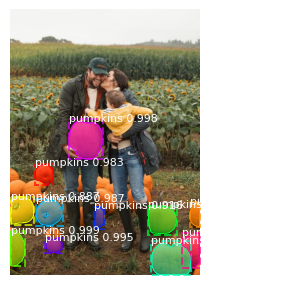

Processing 1 images
image                    shape: (844, 564, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  844.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


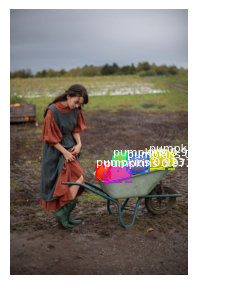

Processing 1 images
image                    shape: (975, 650, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  975.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


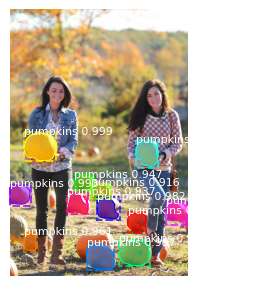

Processing 1 images
image                    shape: (533, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


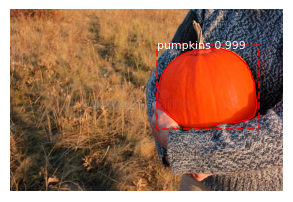

In [44]:
import skimage
real_test_dir = 'path_to_directory\\test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
print(image_paths)
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))